# Southern California Solar Energy Generation Project

#### Data Collection

First, I have to download data from the United States Large-Scale Solar Photovoltaic Database (USPVDB) using the following link: (https://energy.usgs.gov/uspvdb/assets/data/uspvdbCSV.zip). This will give me info on solar farms in CA. This project will only focus on the SP15 region of Souther California, and I will therefore try to isolate that data.

In [1]:
# Read in solar farms dataset
import pandas as pd
farms = pd.read_csv(r"/Users/lukemutz/Desktop/SolarProj/uspvdbCSV/uspvdb_v2_0_20240801.csv")
farms.head()

case_id multi_poly  eia_id p_state    p_county       ylat      xlong  \
0   401476      multi   60058      AL  Lauderdale  34.833813 -87.838258   
1   401865      multi   60679      AL        Dale  31.332202 -85.730144   
2   401866      multi   60680      AL     Calhoun  33.626383 -85.939984   
3   402674      multi   61901      AL     Madison  34.611222 -86.624293   
4   401807      multi   60583      AL    Chambers  32.871904 -85.397060   

    p_area  p_img_date  p_dig_conf  ... p_tech_sec       p_axis p_azimuth  \
0  1735134    20210221           4  ...       c-si  single-axis       180   
1   187820    20211023           4  ...  thin-film  single-axis       180   
2    39717    20210415           4  ...  thin-film   fixed-tilt       180   
3   194595    20201209           4  ...       c-si  single-axis       180   
4  1881927    20210307           4  ...       c-si  single-axis       180   

  p_tilt  p_battery p_cap_ac  p_cap_dc      p_type       p_agrivolt  p_zscore  
0    0.0        NaN     75.0     100.2  greenfield  non-agrivoltaic -0.255342  
1   20.0        NaN     10.6      12.7  greenfield  non-agrivoltaic -0.046230  
2   20.0        NaN      7.4       9.7  greenfield  non-agrivoltaic  3.695493  
3    0.0  batteries     10.0      12.5   superfund  non-agrivoltaic -0.117882  
4    0.0        NaN     79.2     116.9  greenfield  non-agrivoltaic -0.162774  

[5 rows x 24 columns]

In [ ]:
farms.columns

Index(['case_id', 'multi_poly', 'eia_id', 'p_state', 'p_county', 'ylat',
       'xlong', 'p_area', 'p_img_date', 'p_dig_conf', 'p_name', 'p_year',
       'p_pwr_reg', 'p_tech_pri', 'p_tech_sec', 'p_axis', 'p_azimuth',
       'p_tilt', 'p_battery', 'p_cap_ac', 'p_cap_dc', 'p_type', 'p_agrivolt',
       'p_zscore'],
      dtype='object')

Below is an image of the SP15 region of Southern California taken from the CAISO website (https://oasis.caiso.com/mrioasis/logon.do). Rigorious definitions of this region and its border are not publicly available, so I had to use images such as the one below to create a rough estimate. Latitude / Longitude coordinates were used to create a shapely polygon that outlines this area.

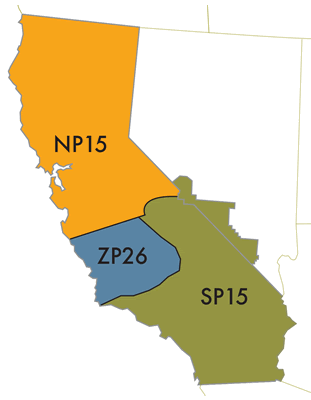

In [ ]:
from shapely.geometry import Point, Polygon
import folium

# New corrected boundary coordinates (lon, lat)
new_coords = [
    [-117.12507, 32.52371],
    [-114.65659, 32.67427],
    [-114.41086, 33.04956],
    [-114.66776, 33.33931],
    [-114.10928, 34.25820],
    [-114.63425, 35.06666],
    [-116.85700, 36.74031],
    [-118.48776, 37.94793],
    [-119.42600, 37.59476],
    [-119.37016, 37.07078],
    [-119.27000, 37.09000],   # Shaver Lake area
    [-117.90000, 35.72000],   # Ridgecrest area
    [-120.56000, 34.55000],   # coast point
    [-119.38132, 34.29512],
    [-118.66647, 33.95300],
    [-117.10273, 32.50488],
    [-117.12507, 32.52371]    # closing the polygon
]

# Convert to Shapely Polygon
polygon = Polygon(new_coords)

# Sample DataFrame with solar farm points
farms = pd.read_csv(r"/Users/lukemutz/Desktop/SolarProj/uspvdbCSV/uspvdb_v2_0_20240801.csv")

# Keep only farms in California
farms = farms[farms['p_state'] == 'CA']

# Check if each point in the DataFrame is within the polygon
farms['point'] = [Point(x, y) for x, y in zip(farms['xlong'], farms['ylat'])]
farms['in_polygon'] = [polygon.contains(point) for point in farms['point']]
filtered_farms = farms[farms['in_polygon']]
print(filtered_farms)

# Create the map centered on CA
map = folium.Map(location=[35.5, -118.5], zoom_start=7)

# Add the polygon region as a filled polygon
folium.Polygon(
    locations=[(lat, lon) for lon, lat in new_coords],  # folium expects (lat, lon)
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2,
    weight=2
).add_to(map)

# Let's see it
map


     case_id multi_poly  eia_id p_state        p_county       ylat  \
95    400339     single   57959      CA       San Diego  33.265240   
96    400403      multi   58149      CA     Los Angeles  34.707428   
97    400537     single   58452      CA     Los Angeles  34.708588   
99    400564     single   58499      CA            Kern  34.903488   
101   400586     single   58527      CA        Imperial  32.967109   
..       ...        ...     ...     ...             ...        ...   
628   402578      multi   61750      CA        Imperial  32.661415   
629   400527      multi   58430      CA        Imperial  32.690795   
630   400180      multi   57490      CA        Imperial  32.658612   
631   404596      multi   63127      CA        Imperial  32.690980   
633   401016     single   59360      CA  San Bernardino  34.471409   

          xlong   p_area  p_img_date  p_dig_conf  ... p_azimuth  p_tilt  \
95  -116.327979   162688    20210523           4  ...       180     NaN   
96  -118.

I want to use several locations within SP15, along with their weather forecasts, to predict hourly solar energy generation for the entire region. Let's start with 3 locations. First, I'll use KMeans to divide SP15 solar farms into 3 clusters. Then, I'll use 'p_cap_ac' to shift the center of these clusters towards solar farms with the highest solar generation capacity.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Load the DataFrame
filtered_farms['p_cap_ac'] = pd.to_numeric(filtered_farms['p_cap_ac'], errors='coerce')

# Extract lat, long, and weights (p_cap_ac)
coords = filtered_farms[['ylat', 'xlong']].values
weights = filtered_farms['p_cap_ac'].values

# KMeans to find 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
filtered_farms['cluster'] = kmeans.fit_predict(coords)

# Compute weighted cluster centroids using p_cap_ac
cluster_centroids = []
for cluster_id in range(3):
    cluster_data = filtered_farms[filtered_farms['cluster'] == cluster_id]
    weighted_lat = np.average(cluster_data['ylat'], weights=cluster_data['p_cap_ac'])
    weighted_lon = np.average(cluster_data['xlong'], weights=cluster_data['p_cap_ac'])
    cluster_centroids.append((weighted_lat, weighted_lon))

cluster_df = pd.DataFrame(cluster_centroids, columns=['latitude', 'longitude'])
cluster_df

/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_36352/4019041972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_farms['p_cap_ac'] = pd.to_numeric(filtered_farms['p_cap_ac'], errors='coerce')
/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_36352/4019041972.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_farms['cluster'] = kmeans.fit_predict(coords)


latitude   longitude
0  34.902543 -118.320018
1  33.336405 -115.331822
2  34.851471 -116.634665

Let's visualize these locations on our map.

In [ ]:
# Bounds
new_coords = [
    [-117.12507, 32.52371],
    [-114.65659, 32.67427],
    [-114.41086, 33.04956],
    [-114.66776, 33.33931],
    [-114.10928, 34.25820],
    [-114.63425, 35.06666],
    [-116.85700, 36.74031],
    [-118.48776, 37.94793],
    [-119.42600, 37.59476],
    [-119.37016, 37.07078],
    [-119.27000, 37.09000],
    [-117.90000, 35.72000],
    [-120.56000, 34.55000],
    [-119.38132, 34.29512],
    [-118.66647, 33.95300],
    [-117.10273, 32.50488],
    [-117.12507, 32.52371]  
]

polygon = Polygon(new_coords)

# Map center based on cluster centers
map_center = [cluster_df['latitude'].mean(), cluster_df['longitude'].mean()]

# Create map
solar_map = folium.Map(location=map_center, zoom_start=7)

# Add the SP15
folium.Polygon(
    locations=[(lat, lon) for lon, lat in new_coords], 
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2,
    weight=2
).add_to(solar_map)

# Add cluster center markers
for _, row in cluster_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Cluster Center\nLat: {row['latitude']:.4f}, Lon: {row['longitude']:.4f}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(solar_map)

# Add legend / label
legend_html = '''
     <div style="position: fixed; 
                 bottom: 30px; left: 30px; width: 120px; height: 55px; 
                 background-color: rgba(255, 255, 255, 0.85);
                 border:2px solid grey; z-index:9999; font-size:14px;
                 padding: 5px;">
     <b>Shaded Region:</b><br>SP15
     </div>
     '''
solar_map.get_root().html.add_child(folium.Element(legend_html))

# Show map
solar_map


Loading in a single HRRR csv file to locate the closest gridpoint to each of our three centroids. HRRR data was downloaded using the Herbie package in Python and saved in csv files for each day that a forecast originated. These data are released at 12UTC each day and contain 48 hour forecasts for gridpoints over the United States. Data was downloaded for the period of December 2020 through May 2024.

In [ ]:
example = pd.read_csv("/Volumes/USB DISK/Weather/hrrr_20201205.csv")
example.head()

Unnamed: 0             step  point                 time  surface  \
0          28  0 days 16:00:00     28  2020-12-05 12:00:00      0.0   
1          36  0 days 16:00:00     36  2020-12-05 12:00:00      0.0   
2          37  0 days 16:00:00     37  2020-12-05 12:00:00      0.0   
3          48  0 days 16:00:00     48  2020-12-05 12:00:00      0.0   
4          64  0 days 16:00:00     64  2020-12-05 12:00:00      0.0   

    latitude   longitude           valid_time  \
0  36.148012  238.384150  2020-12-06 04:00:00   
1  41.848526  238.131130  2020-12-06 04:00:00   
2  36.123839  245.851258  2020-12-06 04:00:00   
3  37.038818  242.815352  2020-12-06 04:00:00   
4  41.936274  241.570753  2020-12-06 04:00:00   

                             metpy_crs  unknown  ...  cfnsf  vbdsf  vddsf  \
0  Projection: lambert_conformal_conic      0.0  ...    0.0    0.0    0.0   
1  Projection: lambert_conformal_conic      0.0  ...    0.0    0.0    0.0   
2  Projection: lambert_conformal_conic      0.0  ...    0.0    0.0    0.0   
3  Projection: lambert_conformal_conic      0.0  ...    0.0    0.0    0.0   
4  Projection: lambert_conformal_conic      0.0  ...    0.0    0.0    0.0   

     lai  vgtyp  gribfile_projection              y             x  \
0  2.250    5.0                  NaN   20693.847443 -2.142520e+06   
1  0.375   10.0                  NaN  638693.847443 -1.998520e+06   
2  0.125    7.0                  NaN -129306.152557 -1.488520e+06   
3  0.125    7.0                  NaN   23693.847443 -1.734520e+06   
4  0.250   10.0                  NaN  578693.847443 -1.719520e+06   

   point_latitude  point_longitude  
0       36.155258      -121.628310  
1       41.841575      -121.872063  
2       36.123404      -114.143935  
3       37.041692      -117.173532  
4       41.926313      -118.424979  

[5 rows x 55 columns]

In [12]:
# POINT ONE

# Target latitude and longitude
target_lat = 34.902543
target_lon = -118.320018

# Compute the Euclidean distance for each row
example["distance"] = np.sqrt((example["point_latitude"] - target_lat)**2 + (example["point_longitude"] - target_lon)**2)

# Find the row with the minimum distance
closest_row = example.loc[example["distance"].idxmin()]

# Extract the closest latitude and longitude
closest_lat = closest_row["point_latitude"]
closest_lon = closest_row["point_longitude"]

print(f"Closest grid point to ({target_lat}, {target_lon}): ({closest_lat}, {closest_lon})")


Closest grid point to (34.902543, -118.320018): (34.829286, -118.299435)


In [13]:
# POINT TWO

# Target latitude and longitude
target_lat = 33.336405
target_lon = -115.331822

# Compute the Euclidean distance for each row
example["distance"] = np.sqrt((example["point_latitude"] - target_lat)**2 + (example["point_longitude"] - target_lon)**2)

# Find the row with the minimum distance
closest_row = example.loc[example["distance"].idxmin()]

# Extract the closest latitude and longitude
closest_lat = closest_row["point_latitude"]
closest_lon = closest_row["point_longitude"]

print(f"Closest grid point to ({target_lat}, {target_lon}): ({closest_lat}, {closest_lon})")


Closest grid point to (33.336405, -115.331822): (33.220794, -115.283758)


In [14]:
# POINT THREE

# Target latitude and longitude
target_lat = 34.851471
target_lon = -116.634665

# Compute the Euclidean distance for each row
example["distance"] = np.sqrt((example["point_latitude"] - target_lat)**2 + (example["point_longitude"] - target_lon)**2)

# Find the row with the minimum distance
closest_row = example.loc[example["distance"].idxmin()]

# Extract the closest latitude and longitude
closest_lat = closest_row["point_latitude"]
closest_lon = closest_row["point_longitude"]

print(f"Closest grid point to ({target_lat}, {target_lon}): ({closest_lat}, {closest_lon})")


Closest grid point to (34.851471, -116.634665): (34.870479, -116.796785)


Now that we have the three closest gridpoints, I'll pull the data for all of these locations from the individual HRRR csv files and create a dataframe with just this information.

In [ ]:
import glob

# Define file path pattern and get all matching CSV files
folder_path = "/Volumes/USB DISK/Weather/"
csv_files = sorted(glob.glob(folder_path + "hrrr_*.csv")) 

# Target gridpoints
target_coords = [
    (34.829286, -118.299435),   # Gridpoint 1
    (33.220794, -115.283758),    # Gridpoint 2
    (34.870479, -116.796785)      # Gridpoint 3
]
tol = 1e-6  # Tolerance for floating-point precision

# Initialize list
filtered_dfs = []

# Loop through files
for file in csv_files:
    df = pd.read_csv(file)
    
    # Filter for any of the three coordinates
    mask = pd.Series(False, index=df.index)
    for lat, lon in target_coords:
        mask |= (
            (df["point_latitude"].sub(lat).abs() < tol) & 
            (df["point_longitude"].sub(lon).abs() < tol)
        )

    filtered_df = df[mask]
    #print(f"{file} -> {len(filtered_df)} rows matched")

    if not filtered_df.empty:
        filtered_dfs.append(filtered_df)

# Combine all filtered rows into one DataFrame
full_df = pd.concat(filtered_dfs, ignore_index=True) if filtered_dfs else pd.DataFrame()

# Take a look
print(full_df.head())
print(f"Total rows in final dataset: {len(full_df)}")


   Unnamed: 0             step  point                 time  surface  \
0      4239.0  0 days 16:00:00   4239  2020-12-05 12:00:00      0.0   
1      5000.0  0 days 16:00:00   5000  2020-12-05 12:00:00      0.0   
2      6081.0  0 days 16:00:00   6081  2020-12-05 12:00:00      0.0   
3     18471.0  0 days 17:00:00   4239  2020-12-05 12:00:00      0.0   
4     19232.0  0 days 17:00:00   5000  2020-12-05 12:00:00      0.0   

    latitude   longitude           valid_time  \
0  33.208817  244.723222  2020-12-06 04:00:00   
1  34.870602  243.187135  2020-12-06 04:00:00   
2  34.818891  241.688987  2020-12-06 04:00:00   
3  33.208817  244.723222  2020-12-06 05:00:00   
4  34.870602  243.187135  2020-12-06 05:00:00   

                             metpy_crs  unknown  ...   lai  vgtyp  \
0  Projection: lambert_conformal_conic      0.0  ...  0.00   16.0   
1  Projection: lambert_conformal_conic      0.0  ...  0.25    7.0   
2  Projection: lambert_conformal_conic      0.0  ...  0.50    7.0   
3 

In [16]:
full_df.head()

Unnamed: 0             step  point                 time  surface  \
0      4239.0  0 days 16:00:00   4239  2020-12-05 12:00:00      0.0   
1      5000.0  0 days 16:00:00   5000  2020-12-05 12:00:00      0.0   
2      6081.0  0 days 16:00:00   6081  2020-12-05 12:00:00      0.0   
3     18471.0  0 days 17:00:00   4239  2020-12-05 12:00:00      0.0   
4     19232.0  0 days 17:00:00   5000  2020-12-05 12:00:00      0.0   

    latitude   longitude           valid_time  \
0  33.208817  244.723222  2020-12-06 04:00:00   
1  34.870602  243.187135  2020-12-06 04:00:00   
2  34.818891  241.688987  2020-12-06 04:00:00   
3  33.208817  244.723222  2020-12-06 05:00:00   
4  34.870602  243.187135  2020-12-06 05:00:00   

                             metpy_crs  unknown  ...   lai  vgtyp  \
0  Projection: lambert_conformal_conic      0.0  ...  0.00   16.0   
1  Projection: lambert_conformal_conic      0.0  ...  0.25    7.0   
2  Projection: lambert_conformal_conic      0.0  ...  0.50    7.0   
3  Projection: lambert_conformal_conic      0.0  ...  0.00   16.0   
4  Projection: lambert_conformal_conic      0.0  ...  0.25    7.0   

   gribfile_projection              y             x  point_latitude  \
0                  NaN -429306.152557 -1.650520e+06       33.220794   
1                  NaN -219306.152557 -1.752520e+06       34.870479   
2                  NaN -195306.152557 -1.887520e+06       34.829286   
3                  NaN -429306.152557 -1.650520e+06       33.220794   
4                  NaN -219306.152557 -1.752520e+06       34.870479   

   point_longitude  Unnamed: 0.1  gppbfas  Unnamed: 0.2  
0      -115.283758           NaN      NaN           NaN  
1      -116.796785           NaN      NaN           NaN  
2      -118.299435           NaN      NaN           NaN  
3      -115.283758           NaN      NaN           NaN  
4      -116.796785           NaN      NaN           NaN  

[5 rows x 58 columns]

In [ ]:
# Save to USB
full_df.to_csv("/Volumes/USB DISK/NewSP15/AllCentroids/hrrr_allcentroids.csv", index=False)

In [ ]:
# Let's mess around with the data a bit
working_data = pd.read_csv("/Volumes/USB DISK/NewSP15/AllCentroids/hrrr_allcentroids.csv")
working_data.head()

Unnamed: 0             step  point                 time  surface  \
0      4239.0  0 days 16:00:00   4239  2020-12-05 12:00:00      0.0   
1      5000.0  0 days 16:00:00   5000  2020-12-05 12:00:00      0.0   
2      6081.0  0 days 16:00:00   6081  2020-12-05 12:00:00      0.0   
3     18471.0  0 days 17:00:00   4239  2020-12-05 12:00:00      0.0   
4     19232.0  0 days 17:00:00   5000  2020-12-05 12:00:00      0.0   

    latitude   longitude           valid_time  \
0  33.208817  244.723222  2020-12-06 04:00:00   
1  34.870602  243.187135  2020-12-06 04:00:00   
2  34.818891  241.688987  2020-12-06 04:00:00   
3  33.208817  244.723222  2020-12-06 05:00:00   
4  34.870602  243.187135  2020-12-06 05:00:00   

                             metpy_crs  unknown  ...   lai  vgtyp  \
0  Projection: lambert_conformal_conic      0.0  ...  0.00   16.0   
1  Projection: lambert_conformal_conic      0.0  ...  0.25    7.0   
2  Projection: lambert_conformal_conic      0.0  ...  0.50    7.0   
3  Projection: lambert_conformal_conic      0.0  ...  0.00   16.0   
4  Projection: lambert_conformal_conic      0.0  ...  0.25    7.0   

   gribfile_projection              y             x  point_latitude  \
0                  NaN -429306.152557 -1.650520e+06       33.220794   
1                  NaN -219306.152557 -1.752520e+06       34.870479   
2                  NaN -195306.152557 -1.887520e+06       34.829286   
3                  NaN -429306.152557 -1.650520e+06       33.220794   
4                  NaN -219306.152557 -1.752520e+06       34.870479   

   point_longitude  Unnamed: 0.1  gppbfas  Unnamed: 0.2  
0      -115.283758           NaN      NaN           NaN  
1      -116.796785           NaN      NaN           NaN  
2      -118.299435           NaN      NaN           NaN  
3      -115.283758           NaN      NaN           NaN  
4      -116.796785           NaN      NaN           NaN  

[5 rows x 58 columns]

Let's look at missing data. Given the nature of HRRR data, I don't expect much missing data for individual columns.

In [18]:
missing_percent = working_data.isnull().mean() * 100
print(missing_percent)

Unnamed: 0              13.972527
step                     0.000000
point                    0.000000
time                     0.000000
surface                  0.000000
latitude                 0.000000
longitude                0.000000
valid_time               0.000000
metpy_crs                0.000000
unknown                  0.000000
siconc                   0.005531
cape                     0.002766
t                        0.000000
sp                       0.000000
blh                      0.005531
lsm                      0.005531
ishf                     0.000000
fsr                      0.000000
vis                      0.000000
prate                    0.000000
sde                      0.002766
cin                      0.002766
orog                     0.000000
tp                       0.000000
lhtfl                    0.000000
hail                     0.002766
crain                    0.000000
cfrzr                    0.000000
cicep                    0.000000
csnow         

Most variables with more than 1% missing are not potential features and will eventually be dropped. I will investigate how to deal with the rest of these missing values and variables in the data engineering stage.



HRRR data works in UTC, but our area of concern is on the west coast of California and uses PT. I will make that conversion now. 

In [23]:
working_data["valid_time"].tail(205).head(10)

108265    2024-05-03 22:00:00
108266    2024-05-03 23:00:00
108267    2024-05-03 23:00:00
108268    2024-05-03 23:00:00
108269             2024-05-04
108270             2024-05-04
108271    2024-05-04 00:00:00
108272    2024-05-04 01:00:00
108273    2024-05-04 01:00:00
108274    2024-05-04 01:00:00
Name: valid_time, dtype: object

It looks like midnight is handled inconsistently. Let's make sure it's recorded the same as all other times before making the time zone change.

In [ ]:
# Convert to string to check which values are missing time
working_data["valid_time"] = working_data["valid_time"].astype(str)

# Add " 00:00:00" only to date-only values. These are for the midnight values
working_data.loc[~working_data["valid_time"].str.contains(" "), "valid_time"] += " 00:00:00"

# Back to datetime
working_data["valid_time"] = pd.to_datetime(working_data["valid_time"])

In [ ]:
import pytz

# Define UTC and Pacific Time zones
utc_zone = pytz.utc
pt_zone = pytz.timezone("America/Los_Angeles")

# Convert 'valid_time' from UTC to Pacific Time
working_data["valid_time_PT"] = working_data["valid_time"].dt.tz_localize(utc_zone).dt.tz_convert(pt_zone)

print(working_data["valid_time_PT"].dtype)  # Check data type
working_data["valid_time_PT"].tail(205).head(10)  # View the same values as before

datetime64[ns, America/Los_Angeles]


108265   2024-05-03 15:00:00-07:00
108266   2024-05-03 16:00:00-07:00
108267   2024-05-03 16:00:00-07:00
108268   2024-05-03 16:00:00-07:00
108269   2024-05-03 17:00:00-07:00
108270   2024-05-03 17:00:00-07:00
108271   2024-05-03 17:00:00-07:00
108272   2024-05-03 18:00:00-07:00
108273   2024-05-03 18:00:00-07:00
108274   2024-05-03 18:00:00-07:00
Name: valid_time_PT, dtype: datetime64[ns, America/Los_Angeles]

I believe pytz handles time changes appropriately, but let's take a look under the hood to confirm.

In [ ]:
# Ensure datetime format
working_data["valid_time_PT"] = pd.to_datetime(working_data["valid_time_PT"])

# Create a unique identifier for each point
working_data["point_id"] = working_data["point_latitude"].astype(str) + "_" + working_data["point_longitude"].astype(str)

# Define two known DST transition dates in Pacific Time
spring_forward_day = "2023-03-12"
fall_back_day = "2023-11-05"

# Filter around each transition
spring_df = working_data[
    (working_data["valid_time_PT"] >= spring_forward_day) &
    (working_data["valid_time_PT"] < "2023-03-13")
].copy()

fall_df = working_data[
    (working_data["valid_time_PT"] >= fall_back_day) &
    (working_data["valid_time_PT"] < "2023-11-06")
].copy()

# Sort and preview first 30 rows per point for each
print("🌱 SPRING FORWARD — First 30 rows by point:")
for point in spring_df["point_id"].unique():
    print(f"\nPoint: {point}")
    display(spring_df[spring_df["point_id"] == point].sort_values("valid_time_PT").head(30))

print("🍂 FALL BACK — First 30 rows by point:")
for point in fall_df["point_id"].unique():
    print(f"\nPoint: {point}")
    display(fall_df[fall_df["point_id"] == point].sort_values("valid_time_PT").head(30))


🌱 SPRING FORWARD — First 30 rows by point:

Point: 33.220794_-115.283758


Unnamed: 0             step  point                 time  surface  \
71840         NaN  1 days 20:00:00   4239  2023-03-10 12:00:00      0.0   
71855     61167.0  0 days 20:00:00   4239  2023-03-11 12:00:00      0.0   
71858     75399.0  0 days 21:00:00   4239  2023-03-11 12:00:00      0.0   
71861     89631.0  0 days 22:00:00   4239  2023-03-11 12:00:00      0.0   
71864    103863.0  0 days 23:00:00   4239  2023-03-11 12:00:00      0.0   
71867    118095.0           1 days   4239  2023-03-11 12:00:00      0.0   
71870    132327.0  1 days 01:00:00   4239  2023-03-11 12:00:00      0.0   
71873    146559.0  1 days 02:00:00   4239  2023-03-11 12:00:00      0.0   
71876    160791.0  1 days 03:00:00   4239  2023-03-11 12:00:00      0.0   
71879    175023.0  1 days 04:00:00   4239  2023-03-11 12:00:00      0.0   
71882    189255.0  1 days 05:00:00   4239  2023-03-11 12:00:00      0.0   
71885    203487.0  1 days 06:00:00   4239  2023-03-11 12:00:00      0.0   
71888    217719.0  1 days 07:00:00   4239  2023-03-11 12:00:00      0.0   
71891    231951.0  1 days 08:00:00   4239  2023-03-11 12:00:00      0.0   
71894    246183.0  1 days 09:00:00   4239  2023-03-11 12:00:00      0.0   
71897    260415.0  1 days 10:00:00   4239  2023-03-11 12:00:00      0.0   
71900    274647.0  1 days 11:00:00   4239  2023-03-11 12:00:00      0.0   
71903    288879.0  1 days 12:00:00   4239  2023-03-11 12:00:00      0.0   
71906    303111.0  1 days 13:00:00   4239  2023-03-11 12:00:00      0.0   
71909    317343.0  1 days 14:00:00   4239  2023-03-11 12:00:00      0.0   
71912    331575.0  1 days 15:00:00   4239  2023-03-11 12:00:00      0.0   
71915    345807.0  1 days 16:00:00   4239  2023-03-11 12:00:00      0.0   
71930      4239.0  0 days 16:00:00   4239  2023-03-12 12:00:00      0.0   
71918         NaN  1 days 17:00:00   4239  2023-03-11 12:00:00      0.0   
71933     18471.0  0 days 17:00:00   4239  2023-03-12 12:00:00      0.0   
71921         NaN  1 days 18:00:00   4239  2023-03-11 12:00:00      0.0   
71936     32703.0  0 days 18:00:00   4239  2023-03-12 12:00:00      0.0   

        latitude   longitude          valid_time  \
71840  33.208817  244.723222 2023-03-12 08:00:00   
71855  33.208817  244.723222 2023-03-12 08:00:00   
71858  33.208817  244.723222 2023-03-12 09:00:00   
71861  33.208817  244.723222 2023-03-12 10:00:00   
71864  33.208817  244.723222 2023-03-12 11:00:00   
71867  33.208817  244.723222 2023-03-12 12:00:00   
71870  33.208817  244.723222 2023-03-12 13:00:00   
71873  33.208817  244.723222 2023-03-12 14:00:00   
71876  33.208817  244.723222 2023-03-12 15:00:00   
71879  33.208817  244.723222 2023-03-12 16:00:00   
71882  33.208817  244.723222 2023-03-12 17:00:00   
71885  33.208817  244.723222 2023-03-12 18:00:00   
71888  33.208817  244.723222 2023-03-12 19:00:00   
71891  33.208817  244.723222 2023-03-12 20:00:00   
71894  33.208817  244.723222 2023-03-12 21:00:00   
71897  33.208817  244.723222 2023-03-12 22:00:00   
71900  33.208817  244.723222 2023-03-12 23:00:00   
71903  33.208817  244.723222 2023-03-13 00:00:00   
71906  33.208817  244.723222 2023-03-13 01:00:00   
71909  33.208817  244.723222 2023-03-13 02:00:00   
71912  33.208817  244.723222 2023-03-13 03:00:00   
71915  33.208817  244.723222 2023-03-13 04:00:00   
71930  33.208817  244.723222 2023-03-13 04:00:00   
71918  33.208817  244.723222 2023-03-13 05:00:00   
71933  33.208817  244.723222 2023-03-13 05:00:00   
71921  33.208817  244.723222 2023-03-13 06:00:00   
71936  33.208817  244.723222 2023-03-13 06:00:00   

                                 metpy_crs  unknown  ...  gribfile_projection  \
71840  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71855  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71858  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71861  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71864  Projection: lambert_conformal_conic  


Point: 34.870479_-116.796785


Unnamed: 0             step  point                 time  surface  \
71841         NaN  1 days 20:00:00   5000  2023-03-10 12:00:00      0.0   
71856     61928.0  0 days 20:00:00   5000  2023-03-11 12:00:00      0.0   
71859     76160.0  0 days 21:00:00   5000  2023-03-11 12:00:00      0.0   
71862     90392.0  0 days 22:00:00   5000  2023-03-11 12:00:00      0.0   
71865    104624.0  0 days 23:00:00   5000  2023-03-11 12:00:00      0.0   
71868    118856.0           1 days   5000  2023-03-11 12:00:00      0.0   
71871    133088.0  1 days 01:00:00   5000  2023-03-11 12:00:00      0.0   
71874    147320.0  1 days 02:00:00   5000  2023-03-11 12:00:00      0.0   
71877    161552.0  1 days 03:00:00   5000  2023-03-11 12:00:00      0.0   
71880    175784.0  1 days 04:00:00   5000  2023-03-11 12:00:00      0.0   
71883    190016.0  1 days 05:00:00   5000  2023-03-11 12:00:00      0.0   
71886    204248.0  1 days 06:00:00   5000  2023-03-11 12:00:00      0.0   
71889    218480.0  1 days 07:00:00   5000  2023-03-11 12:00:00      0.0   
71892    232712.0  1 days 08:00:00   5000  2023-03-11 12:00:00      0.0   
71895    246944.0  1 days 09:00:00   5000  2023-03-11 12:00:00      0.0   
71898    261176.0  1 days 10:00:00   5000  2023-03-11 12:00:00      0.0   
71901    275408.0  1 days 11:00:00   5000  2023-03-11 12:00:00      0.0   
71904    289640.0  1 days 12:00:00   5000  2023-03-11 12:00:00      0.0   
71907    303872.0  1 days 13:00:00   5000  2023-03-11 12:00:00      0.0   
71910    318104.0  1 days 14:00:00   5000  2023-03-11 12:00:00      0.0   
71913    332336.0  1 days 15:00:00   5000  2023-03-11 12:00:00      0.0   
71916    346568.0  1 days 16:00:00   5000  2023-03-11 12:00:00      0.0   
71931      5000.0  0 days 16:00:00   5000  2023-03-12 12:00:00      0.0   
71919         NaN  1 days 17:00:00   5000  2023-03-11 12:00:00      0.0   
71934     19232.0  0 days 17:00:00   5000  2023-03-12 12:00:00      0.0   
71922         NaN  1 days 18:00:00   5000  2023-03-11 12:00:00      0.0   
71937     33464.0  0 days 18:00:00   5000  2023-03-12 12:00:00      0.0   

        latitude   longitude          valid_time  \
71841  34.870602  243.187135 2023-03-12 08:00:00   
71856  34.870602  243.187135 2023-03-12 08:00:00   
71859  34.870602  243.187135 2023-03-12 09:00:00   
71862  34.870602  243.187135 2023-03-12 10:00:00   
71865  34.870602  243.187135 2023-03-12 11:00:00   
71868  34.870602  243.187135 2023-03-12 12:00:00   
71871  34.870602  243.187135 2023-03-12 13:00:00   
71874  34.870602  243.187135 2023-03-12 14:00:00   
71877  34.870602  243.187135 2023-03-12 15:00:00   
71880  34.870602  243.187135 2023-03-12 16:00:00   
71883  34.870602  243.187135 2023-03-12 17:00:00   
71886  34.870602  243.187135 2023-03-12 18:00:00   
71889  34.870602  243.187135 2023-03-12 19:00:00   
71892  34.870602  243.187135 2023-03-12 20:00:00   
71895  34.870602  243.187135 2023-03-12 21:00:00   
71898  34.870602  243.187135 2023-03-12 22:00:00   
71901  34.870602  243.187135 2023-03-12 23:00:00   
71904  34.870602  243.187135 2023-03-13 00:00:00   
71907  34.870602  243.187135 2023-03-13 01:00:00   
71910  34.870602  243.187135 2023-03-13 02:00:00   
71913  34.870602  243.187135 2023-03-13 03:00:00   
71916  34.870602  243.187135 2023-03-13 04:00:00   
71931  34.870602  243.187135 2023-03-13 04:00:00   
71919  34.870602  243.187135 2023-03-13 05:00:00   
71934  34.870602  243.187135 2023-03-13 05:00:00   
71922  34.870602  243.187135 2023-03-13 06:00:00   
71937  34.870602  243.187135 2023-03-13 06:00:00   

                                 metpy_crs  unknown  ...  gribfile_projection  \
71841  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71856  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71859  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71862  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71865  Projection: lambert_conformal_conic  


Point: 34.829286_-118.299435


Unnamed: 0             step  point                 time  surface  \
71842         NaN  1 days 20:00:00   6081  2023-03-10 12:00:00      0.0   
71857     63009.0  0 days 20:00:00   6081  2023-03-11 12:00:00      0.0   
71860     77241.0  0 days 21:00:00   6081  2023-03-11 12:00:00      0.0   
71863     91473.0  0 days 22:00:00   6081  2023-03-11 12:00:00      0.0   
71866    105705.0  0 days 23:00:00   6081  2023-03-11 12:00:00      0.0   
71869    119937.0  1 days 00:00:00   6081  2023-03-11 12:00:00      0.0   
71872    134169.0  1 days 01:00:00   6081  2023-03-11 12:00:00      0.0   
71875    148401.0  1 days 02:00:00   6081  2023-03-11 12:00:00      0.0   
71878    162633.0  1 days 03:00:00   6081  2023-03-11 12:00:00      0.0   
71881    176865.0  1 days 04:00:00   6081  2023-03-11 12:00:00      0.0   
71884    191097.0  1 days 05:00:00   6081  2023-03-11 12:00:00      0.0   
71887    205329.0  1 days 06:00:00   6081  2023-03-11 12:00:00      0.0   
71890    219561.0  1 days 07:00:00   6081  2023-03-11 12:00:00      0.0   
71893    233793.0  1 days 08:00:00   6081  2023-03-11 12:00:00      0.0   
71896    248025.0  1 days 09:00:00   6081  2023-03-11 12:00:00      0.0   
71899    262257.0  1 days 10:00:00   6081  2023-03-11 12:00:00      0.0   
71902    276489.0  1 days 11:00:00   6081  2023-03-11 12:00:00      0.0   
71905    290721.0  1 days 12:00:00   6081  2023-03-11 12:00:00      0.0   
71908    304953.0  1 days 13:00:00   6081  2023-03-11 12:00:00      0.0   
71911    319185.0  1 days 14:00:00   6081  2023-03-11 12:00:00      0.0   
71914    333417.0  1 days 15:00:00   6081  2023-03-11 12:00:00      0.0   
71917    347649.0  1 days 16:00:00   6081  2023-03-11 12:00:00      0.0   
71932      6081.0  0 days 16:00:00   6081  2023-03-12 12:00:00      0.0   
71920         NaN  1 days 17:00:00   6081  2023-03-11 12:00:00      0.0   
71935     20313.0  0 days 17:00:00   6081  2023-03-12 12:00:00      0.0   
71923         NaN  1 days 18:00:00   6081  2023-03-11 12:00:00      0.0   
71938     34545.0  0 days 18:00:00   6081  2023-03-12 12:00:00      0.0   

        latitude   longitude          valid_time  \
71842  34.818891  241.688987 2023-03-12 08:00:00   
71857  34.818891  241.688987 2023-03-12 08:00:00   
71860  34.818891  241.688987 2023-03-12 09:00:00   
71863  34.818891  241.688987 2023-03-12 10:00:00   
71866  34.818891  241.688987 2023-03-12 11:00:00   
71869  34.818891  241.688987 2023-03-12 12:00:00   
71872  34.818891  241.688987 2023-03-12 13:00:00   
71875  34.818891  241.688987 2023-03-12 14:00:00   
71878  34.818891  241.688987 2023-03-12 15:00:00   
71881  34.818891  241.688987 2023-03-12 16:00:00   
71884  34.818891  241.688987 2023-03-12 17:00:00   
71887  34.818891  241.688987 2023-03-12 18:00:00   
71890  34.818891  241.688987 2023-03-12 19:00:00   
71893  34.818891  241.688987 2023-03-12 20:00:00   
71896  34.818891  241.688987 2023-03-12 21:00:00   
71899  34.818891  241.688987 2023-03-12 22:00:00   
71902  34.818891  241.688987 2023-03-12 23:00:00   
71905  34.818891  241.688987 2023-03-13 00:00:00   
71908  34.818891  241.688987 2023-03-13 01:00:00   
71911  34.818891  241.688987 2023-03-13 02:00:00   
71914  34.818891  241.688987 2023-03-13 03:00:00   
71917  34.818891  241.688987 2023-03-13 04:00:00   
71932  34.818891  241.688987 2023-03-13 04:00:00   
71920  34.818891  241.688987 2023-03-13 05:00:00   
71935  34.818891  241.688987 2023-03-13 05:00:00   
71923  34.818891  241.688987 2023-03-13 06:00:00   
71938  34.818891  241.688987 2023-03-13 06:00:00   

                                 metpy_crs  unknown  ...  gribfile_projection  \
71842  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71857  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71860  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71863  Projection: lambert_conformal_conic      0.0  ...                  NaN   
71866  Projection: lambert_conformal_conic  

🍂 FALL BACK — First 30 rows by point:

Point: 33.220794_-115.283758


Unnamed: 0             step  point                 time  surface  \
92543         NaN  1 days 19:00:00   4239  2023-11-03 12:00:00      0.0   
92558     46935.0  0 days 19:00:00   4239  2023-11-04 12:00:00      0.0   
92546         NaN  1 days 20:00:00   4239  2023-11-03 12:00:00      0.0   
92561     61167.0  0 days 20:00:00   4239  2023-11-04 12:00:00      0.0   
92564     75399.0  0 days 21:00:00   4239  2023-11-04 12:00:00      0.0   
92567     89631.0  0 days 22:00:00   4239  2023-11-04 12:00:00      0.0   
92570    103863.0  0 days 23:00:00   4239  2023-11-04 12:00:00      0.0   
92573    118095.0           1 days   4239  2023-11-04 12:00:00      0.0   
92576    132327.0  1 days 01:00:00   4239  2023-11-04 12:00:00      0.0   
92579    146559.0  1 days 02:00:00   4239  2023-11-04 12:00:00      0.0   
92582    160791.0  1 days 03:00:00   4239  2023-11-04 12:00:00      0.0   
92585    175023.0  1 days 04:00:00   4239  2023-11-04 12:00:00      0.0   
92588    189255.0  1 days 05:00:00   4239  2023-11-04 12:00:00      0.0   
92591    203487.0  1 days 06:00:00   4239  2023-11-04 12:00:00      0.0   
92594    217719.0  1 days 07:00:00   4239  2023-11-04 12:00:00      0.0   
92597    231951.0  1 days 08:00:00   4239  2023-11-04 12:00:00      0.0   
92600    246183.0  1 days 09:00:00   4239  2023-11-04 12:00:00      0.0   
92603    260415.0  1 days 10:00:00   4239  2023-11-04 12:00:00      0.0   
92606    274647.0  1 days 11:00:00   4239  2023-11-04 12:00:00      0.0   
92609    288879.0  1 days 12:00:00   4239  2023-11-04 12:00:00      0.0   
92612    303111.0  1 days 13:00:00   4239  2023-11-04 12:00:00      0.0   
92615    317343.0  1 days 14:00:00   4239  2023-11-04 12:00:00      0.0   
92618    331575.0  1 days 15:00:00   4239  2023-11-04 12:00:00      0.0   
92621    345807.0  1 days 16:00:00   4239  2023-11-04 12:00:00      0.0   
92636      4239.0  0 days 16:00:00   4239  2023-11-05 12:00:00      0.0   
92624         NaN  1 days 17:00:00   4239  2023-11-04 12:00:00      0.0   
92639     18471.0  0 days 17:00:00   4239  2023-11-05 12:00:00      0.0   
92627         NaN  1 days 18:00:00   4239  2023-11-04 12:00:00      0.0   
92642     32703.0  0 days 18:00:00   4239  2023-11-05 12:00:00      0.0   
92630         NaN  1 days 19:00:00   4239  2023-11-04 12:00:00      0.0   

        latitude   longitude          valid_time  \
92543  33.208817  244.723222 2023-11-05 07:00:00   
92558  33.208817  244.723222 2023-11-05 07:00:00   
92546  33.208817  244.723222 2023-11-05 08:00:00   
92561  33.208817  244.723222 2023-11-05 08:00:00   
92564  33.208817  244.723222 2023-11-05 09:00:00   
92567  33.208817  244.723222 2023-11-05 10:00:00   
92570  33.208817  244.723222 2023-11-05 11:00:00   
92573  33.208817  244.723222 2023-11-05 12:00:00   
92576  33.208817  244.723222 2023-11-05 13:00:00   
92579  33.208817  244.723222 2023-11-05 14:00:00   
92582  33.208817  244.723222 2023-11-05 15:00:00   
92585  33.208817  244.723222 2023-11-05 16:00:00   
92588  33.208817  244.723222 2023-11-05 17:00:00   
92591  33.208817  244.723222 2023-11-05 18:00:00   
92594  33.208817  244.723222 2023-11-05 19:00:00   
92597  33.208817  244.723222 2023-11-05 20:00:00   
92600  33.208817  244.723222 2023-11-05 21:00:00   
92603  33.208817  244.723222 2023-11-05 22:00:00   
92606  33.208817  244.723222 2023-11-05 23:00:00   
92609  33.208817  244.723222 2023-11-06 00:00:00   
92612  33.208817  244.723222 2023-11-06 01:00:00   
92615  33.208817  244.723222 2023-11-06 02:00:00   
92618  33.208817  244.723222 2023-11-06 03:00:00   
92621  33.208817  244.723222 2023-11-06 04:00:00   
92636  33.208817  244.723222 2023-11-06 04:00:00   
92624  33.208817  244.723222 2023-11-06 05:00:00   
92639  33.208817  244.723222 2023-11-06 05:00:00   
92627  33.208817  244.723222 2023-11-06 06:00:00   
92642  33.208817  244.723222 2023-11-06 06:00:00   
92630  33.208817  244.723222 2023-11-06 07:00:00   

                                 metpy_crs  unknown  ...  gribfile_p


Point: 34.870479_-116.796785


Unnamed: 0             step  point                 time  surface  \
92544         NaN  1 days 19:00:00   5000  2023-11-03 12:00:00      0.0   
92559     47696.0  0 days 19:00:00   5000  2023-11-04 12:00:00      0.0   
92547         NaN  1 days 20:00:00   5000  2023-11-03 12:00:00      0.0   
92562     61928.0  0 days 20:00:00   5000  2023-11-04 12:00:00      0.0   
92565     76160.0  0 days 21:00:00   5000  2023-11-04 12:00:00      0.0   
92568     90392.0  0 days 22:00:00   5000  2023-11-04 12:00:00      0.0   
92571    104624.0  0 days 23:00:00   5000  2023-11-04 12:00:00      0.0   
92574    118856.0           1 days   5000  2023-11-04 12:00:00      0.0   
92577    133088.0  1 days 01:00:00   5000  2023-11-04 12:00:00      0.0   
92580    147320.0  1 days 02:00:00   5000  2023-11-04 12:00:00      0.0   
92583    161552.0  1 days 03:00:00   5000  2023-11-04 12:00:00      0.0   
92586    175784.0  1 days 04:00:00   5000  2023-11-04 12:00:00      0.0   
92589    190016.0  1 days 05:00:00   5000  2023-11-04 12:00:00      0.0   
92592    204248.0  1 days 06:00:00   5000  2023-11-04 12:00:00      0.0   
92595    218480.0  1 days 07:00:00   5000  2023-11-04 12:00:00      0.0   
92598    232712.0  1 days 08:00:00   5000  2023-11-04 12:00:00      0.0   
92601    246944.0  1 days 09:00:00   5000  2023-11-04 12:00:00      0.0   
92604    261176.0  1 days 10:00:00   5000  2023-11-04 12:00:00      0.0   
92607    275408.0  1 days 11:00:00   5000  2023-11-04 12:00:00      0.0   
92610    289640.0  1 days 12:00:00   5000  2023-11-04 12:00:00      0.0   
92613    303872.0  1 days 13:00:00   5000  2023-11-04 12:00:00      0.0   
92616    318104.0  1 days 14:00:00   5000  2023-11-04 12:00:00      0.0   
92619    332336.0  1 days 15:00:00   5000  2023-11-04 12:00:00      0.0   
92622    346568.0  1 days 16:00:00   5000  2023-11-04 12:00:00      0.0   
92637      5000.0  0 days 16:00:00   5000  2023-11-05 12:00:00      0.0   
92625         NaN  1 days 17:00:00   5000  2023-11-04 12:00:00      0.0   
92640     19232.0  0 days 17:00:00   5000  2023-11-05 12:00:00      0.0   
92628         NaN  1 days 18:00:00   5000  2023-11-04 12:00:00      0.0   
92643     33464.0  0 days 18:00:00   5000  2023-11-05 12:00:00      0.0   
92631         NaN  1 days 19:00:00   5000  2023-11-04 12:00:00      0.0   

        latitude   longitude          valid_time  \
92544  34.870602  243.187135 2023-11-05 07:00:00   
92559  34.870602  243.187135 2023-11-05 07:00:00   
92547  34.870602  243.187135 2023-11-05 08:00:00   
92562  34.870602  243.187135 2023-11-05 08:00:00   
92565  34.870602  243.187135 2023-11-05 09:00:00   
92568  34.870602  243.187135 2023-11-05 10:00:00   
92571  34.870602  243.187135 2023-11-05 11:00:00   
92574  34.870602  243.187135 2023-11-05 12:00:00   
92577  34.870602  243.187135 2023-11-05 13:00:00   
92580  34.870602  243.187135 2023-11-05 14:00:00   
92583  34.870602  243.187135 2023-11-05 15:00:00   
92586  34.870602  243.187135 2023-11-05 16:00:00   
92589  34.870602  243.187135 2023-11-05 17:00:00   
92592  34.870602  243.187135 2023-11-05 18:00:00   
92595  34.870602  243.187135 2023-11-05 19:00:00   
92598  34.870602  243.187135 2023-11-05 20:00:00   
92601  34.870602  243.187135 2023-11-05 21:00:00   
92604  34.870602  243.187135 2023-11-05 22:00:00   
92607  34.870602  243.187135 2023-11-05 23:00:00   
92610  34.870602  243.187135 2023-11-06 00:00:00   
92613  34.870602  243.187135 2023-11-06 01:00:00   
92616  34.870602  243.187135 2023-11-06 02:00:00   
92619  34.870602  243.187135 2023-11-06 03:00:00   
92622  34.870602  243.187135 2023-11-06 04:00:00   
92637  34.870602  243.187135 2023-11-06 04:00:00   
92625  34.870602  243.187135 2023-11-06 05:00:00   
92640  34.870602  243.187135 2023-11-06 05:00:00   
92628  34.870602  243.187135 2023-11-06 06:00:00   
92643  34.870602  243.187135 2023-11-06 06:00:00   
92631  34.870602  243.187135 2023-11-06 07:00:00   

                                 metpy_crs  unknown  ...  gribfile_p


Point: 34.829286_-118.299435


Unnamed: 0             step  point                 time  surface  \
92545         NaN  1 days 19:00:00   6081  2023-11-03 12:00:00      0.0   
92560     48777.0  0 days 19:00:00   6081  2023-11-04 12:00:00      0.0   
92548         NaN  1 days 20:00:00   6081  2023-11-03 12:00:00      0.0   
92563     63009.0  0 days 20:00:00   6081  2023-11-04 12:00:00      0.0   
92566     77241.0  0 days 21:00:00   6081  2023-11-04 12:00:00      0.0   
92569     91473.0  0 days 22:00:00   6081  2023-11-04 12:00:00      0.0   
92572    105705.0  0 days 23:00:00   6081  2023-11-04 12:00:00      0.0   
92575    119937.0  1 days 00:00:00   6081  2023-11-04 12:00:00      0.0   
92578    134169.0  1 days 01:00:00   6081  2023-11-04 12:00:00      0.0   
92581    148401.0  1 days 02:00:00   6081  2023-11-04 12:00:00      0.0   
92584    162633.0  1 days 03:00:00   6081  2023-11-04 12:00:00      0.0   
92587    176865.0  1 days 04:00:00   6081  2023-11-04 12:00:00      0.0   
92590    191097.0  1 days 05:00:00   6081  2023-11-04 12:00:00      0.0   
92593    205329.0  1 days 06:00:00   6081  2023-11-04 12:00:00      0.0   
92596    219561.0  1 days 07:00:00   6081  2023-11-04 12:00:00      0.0   
92599    233793.0  1 days 08:00:00   6081  2023-11-04 12:00:00      0.0   
92602    248025.0  1 days 09:00:00   6081  2023-11-04 12:00:00      0.0   
92605    262257.0  1 days 10:00:00   6081  2023-11-04 12:00:00      0.0   
92608    276489.0  1 days 11:00:00   6081  2023-11-04 12:00:00      0.0   
92611    290721.0  1 days 12:00:00   6081  2023-11-04 12:00:00      0.0   
92614    304953.0  1 days 13:00:00   6081  2023-11-04 12:00:00      0.0   
92617    319185.0  1 days 14:00:00   6081  2023-11-04 12:00:00      0.0   
92620    333417.0  1 days 15:00:00   6081  2023-11-04 12:00:00      0.0   
92623    347649.0  1 days 16:00:00   6081  2023-11-04 12:00:00      0.0   
92638      6081.0  0 days 16:00:00   6081  2023-11-05 12:00:00      0.0   
92626         NaN  1 days 17:00:00   6081  2023-11-04 12:00:00      0.0   
92641     20313.0  0 days 17:00:00   6081  2023-11-05 12:00:00      0.0   
92629         NaN  1 days 18:00:00   6081  2023-11-04 12:00:00      0.0   
92644     34545.0  0 days 18:00:00   6081  2023-11-05 12:00:00      0.0   
92632         NaN  1 days 19:00:00   6081  2023-11-04 12:00:00      0.0   

        latitude   longitude          valid_time  \
92545  34.818891  241.688987 2023-11-05 07:00:00   
92560  34.818891  241.688987 2023-11-05 07:00:00   
92548  34.818891  241.688987 2023-11-05 08:00:00   
92563  34.818891  241.688987 2023-11-05 08:00:00   
92566  34.818891  241.688987 2023-11-05 09:00:00   
92569  34.818891  241.688987 2023-11-05 10:00:00   
92572  34.818891  241.688987 2023-11-05 11:00:00   
92575  34.818891  241.688987 2023-11-05 12:00:00   
92578  34.818891  241.688987 2023-11-05 13:00:00   
92581  34.818891  241.688987 2023-11-05 14:00:00   
92584  34.818891  241.688987 2023-11-05 15:00:00   
92587  34.818891  241.688987 2023-11-05 16:00:00   
92590  34.818891  241.688987 2023-11-05 17:00:00   
92593  34.818891  241.688987 2023-11-05 18:00:00   
92596  34.818891  241.688987 2023-11-05 19:00:00   
92599  34.818891  241.688987 2023-11-05 20:00:00   
92602  34.818891  241.688987 2023-11-05 21:00:00   
92605  34.818891  241.688987 2023-11-05 22:00:00   
92608  34.818891  241.688987 2023-11-05 23:00:00   
92611  34.818891  241.688987 2023-11-06 00:00:00   
92614  34.818891  241.688987 2023-11-06 01:00:00   
92617  34.818891  241.688987 2023-11-06 02:00:00   
92620  34.818891  241.688987 2023-11-06 03:00:00   
92623  34.818891  241.688987 2023-11-06 04:00:00   
92638  34.818891  241.688987 2023-11-06 04:00:00   
92626  34.818891  241.688987 2023-11-06 05:00:00   
92641  34.818891  241.688987 2023-11-06 05:00:00   
92629  34.818891  241.688987 2023-11-06 06:00:00   
92644  34.818891  241.688987 2023-11-06 06:00:00   
92632  34.818891  241.688987 2023-11-06 07:00:00   

                                 metpy_crs  unknown  ...  gribfile_p

Everything seems to line up as expected here. Following "Valid_time_PT" variable during the change to confirm.

We have no need for three of the first hours in the forecasts data, as they don't forecast into the next day at any point during the year.

In [30]:
unwanted_steps = ["0 days 16:00:00", "0 days 17:00:00", "0 days 18:00:00"]
working_data = working_data[~working_data["step"].astype(str).isin(unwanted_steps)]

There are currently several duplicate time stamps. This occurs from the end of one day's forecast overlapping with the start of the next day's forecast. If we were forecasting something like wind energy gen, it would be very important to keep only the day-ahead valid time stamps so that we aren't using "today's predictions" to predict today's energy generation. However, given the nature of solar energy generation, and where these overlaps occur (during the night), we don't have to worry about this other than removing the duplicates. Overnight solar gen will be zero for all of these overlapping times and I will likely even omit these hours from our models entirely.

In [ ]:
# Ensure 'step' is a timedelta if it's not already
if not pd.api.types.is_timedelta64_dtype(working_data['step']):
    working_data.loc[:, 'step'] = pd.to_timedelta(working_data['step'])

# If you don't have a "point" column, create one based on lat/lon
if 'point' not in working_data.columns:
    working_data['point'] = (
        working_data['point_latitude'].astype(str) + "," + 
        working_data['point_longitude'].astype(str)
    )

# Sort and group
cleaned_data = (
    working_data
    .sort_values("step")  
    .drop_duplicates(subset=["valid_time_PT", "point"], keep="first")
    .reset_index(drop=True)
)

print(f"Original row count: {len(working_data)}")
print(f"Cleaned row count: {len(cleaned_data)}")


Original row count: 97247
Cleaned row count: 89765


Double checking the time change becuase it's so easy to do.

In [38]:
# Spring should have 213 rows during this period. We have a day of 24 hours, followed by a day with 23 hours (when we "spring forward") followed by a day of 24 hours. We should
# see this pattern for all three points and expect 213 rows
(24+23+24) * 3

213

In [39]:
spring_check = cleaned_data[
    (cleaned_data["valid_time_PT"].dt.date >= pd.to_datetime("2023-03-11").date()) &
    (cleaned_data["valid_time_PT"].dt.date <= pd.to_datetime("2023-03-13").date())
].sort_values(["point", "valid_time_PT"])

spring_check[["point", "valid_time_PT", "step"]]


point             valid_time_PT            step
6715    4239 2023-03-11 00:00:00-08:00 0 days 20:00:00
8664    4239 2023-03-11 01:00:00-08:00 0 days 21:00:00
14810   4239 2023-03-11 02:00:00-08:00 0 days 22:00:00
18201   4239 2023-03-11 03:00:00-08:00 0 days 23:00:00
20642   4239 2023-03-11 04:00:00-08:00 1 days 00:00:00
...      ...                       ...             ...
72627   6081 2023-03-13 19:00:00-07:00 1 days 14:00:00
77064   6081 2023-03-13 20:00:00-07:00 1 days 15:00:00
81234   6081 2023-03-13 21:00:00-07:00 1 days 16:00:00
85808   6081 2023-03-13 22:00:00-07:00 1 days 17:00:00
86592   6081 2023-03-13 23:00:00-07:00 1 days 18:00:00

[213 rows x 3 columns]

Nice. We see 213 rows and everything looks good.

In [41]:
# Fall should have 219 rows during this period. We have a day of 24 hours, followed by a day with 25 hours (when we "fall back") followed by a day of 24 hours. We should
# see this pattern for all three points and expect 219 rows
(24+25+24) * 3

219

In [40]:
fall_check = cleaned_data[
    (cleaned_data["valid_time_PT"].dt.date >= pd.to_datetime("2023-11-04").date()) &
    (cleaned_data["valid_time_PT"].dt.date <= pd.to_datetime("2023-11-06").date())
].sort_values(["point", "valid_time_PT"])

fall_check[["point", "valid_time_PT", "step"]]


point             valid_time_PT            step
2923    4239 2023-11-04 00:00:00-07:00 0 days 19:00:00
5820    4239 2023-11-04 01:00:00-07:00 0 days 20:00:00
9178    4239 2023-11-04 02:00:00-07:00 0 days 21:00:00
12814   4239 2023-11-04 03:00:00-07:00 0 days 22:00:00
18219   4239 2023-11-04 04:00:00-07:00 0 days 23:00:00
...      ...                       ...             ...
75324   6081 2023-11-06 19:00:00-08:00 1 days 15:00:00
79071   6081 2023-11-06 20:00:00-08:00 1 days 16:00:00
85889   6081 2023-11-06 21:00:00-08:00 1 days 17:00:00
87936   6081 2023-11-06 22:00:00-08:00 1 days 18:00:00
3264    6081 2023-11-06 23:00:00-08:00 0 days 19:00:00

[219 rows x 3 columns]

Very nice. We see 219 rows and everything checks out.

In [48]:
working_checkpoint = cleaned_data

In [49]:
# Let's convert temperature to F from K
working_checkpoint["t_F"] = (working_checkpoint["t"] - 273.15) * 9/5 + 32

In [ ]:
# Give our points actual names based on nearby towns
point_labels = {
    (33.220794, -115.283758): "Blythe",
    (34.870479, -116.796785): "Barstow",
    (34.829286, -118.299435): "Rosamond"
}

# Apply
def label_point(row):
    coords = (round(row["point_latitude"], 6), round(row["point_longitude"], 6))
    return point_labels.get(coords, "Unknown")

working_checkpoint["point_name"] = working_checkpoint.apply(label_point, axis=1)

In [ ]:
# Let's sort by time
working_checkpoint = working_checkpoint.sort_values("valid_time_PT")
working_checkpoint.head()

Unnamed: 0            step  point                 time  surface  \
0        46935.0 0 days 19:00:00   4239  2020-12-05 12:00:00      0.0   
3622     48777.0 0 days 19:00:00   6081  2020-12-05 12:00:00      0.0   
3623     47696.0 0 days 19:00:00   5000  2020-12-05 12:00:00      0.0   
7295     61167.0 0 days 20:00:00   4239  2020-12-05 12:00:00      0.0   
7296     61928.0 0 days 20:00:00   5000  2020-12-05 12:00:00      0.0   

       latitude   longitude          valid_time  \
0     33.208817  244.723222 2020-12-06 07:00:00   
3622  34.818891  241.688987 2020-12-06 07:00:00   
3623  34.870602  243.187135 2020-12-06 07:00:00   
7295  33.208817  244.723222 2020-12-06 08:00:00   
7296  34.870602  243.187135 2020-12-06 08:00:00   

                                metpy_crs  unknown  ...  Unnamed: 0.2  \
0     Projection: lambert_conformal_conic      0.0  ...           NaN   
3622  Projection: lambert_conformal_conic      0.0  ...           NaN   
3623  Projection: lambert_conformal_conic      0.0  ...           NaN   
7295  Projection: lambert_conformal_conic      0.0  ...           NaN   
7296  Projection: lambert_conformal_conic      0.0  ...           NaN   

                 valid_time_PT               point_id  \
0    2020-12-05 23:00:00-08:00  33.220794_-115.283758   
3622 2020-12-05 23:00:00-08:00  34.829286_-118.299435   
3623 2020-12-05 23:00:00-08:00  34.870479_-116.796785   
7295 2020-12-06 00:00:00-08:00  33.220794_-115.283758   
7296 2020-12-06 00:00:00-08:00  34.870479_-116.796785   

                valid_time_UTC     forecast_issuance_UTC  \
0    2020-12-06 07:00:00+00:00 2020-12-05 12:00:00+00:00   
3622 2020-12-06 07:00:00+00:00 2020-12-05 12:00:00+00:00   
3623 2020-12-06 07:00:00+00:00 2020-12-05 12:00:00+00:00   
7295 2020-12-06 08:00:00+00:00 2020-12-05 12:00:00+00:00   
7296 2020-12-06 08:00:00+00:00 2020-12-05 12:00:00+00:00   

          forecast_issuance_PT  valid_date_PT  issuance_date_PT       t_F  \
0    2020-12-05 04:00:00-08:00     2020-12-05        2020-12-05  49.77851   
3622 2020-12-05 04:00:00-08:00     2020-12-05        2020-12-05  28.17851   
3623 2020-12-05 04:00:00-08:00     2020-12-05        2020-12-05  26.82851   
7295 2020-12-05 04:00:00-08:00     2020-12-06        2020-12-05  50.37611   
7296 2020-12-05 04:00:00-08:00     2020-12-06        2020-12-05  26.52611   

      point_name  
0         Blythe  
3622    Rosamond  
3623     Barstow  
7295      Blythe  
7296     Barstow  

[5 rows x 67 columns]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


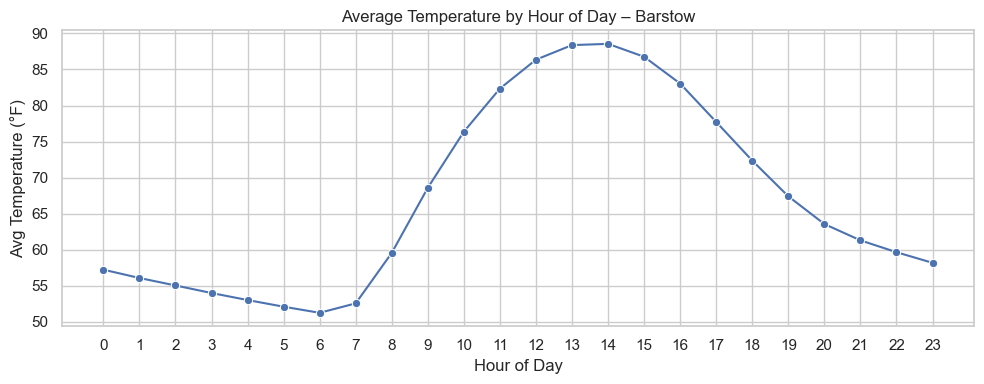

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


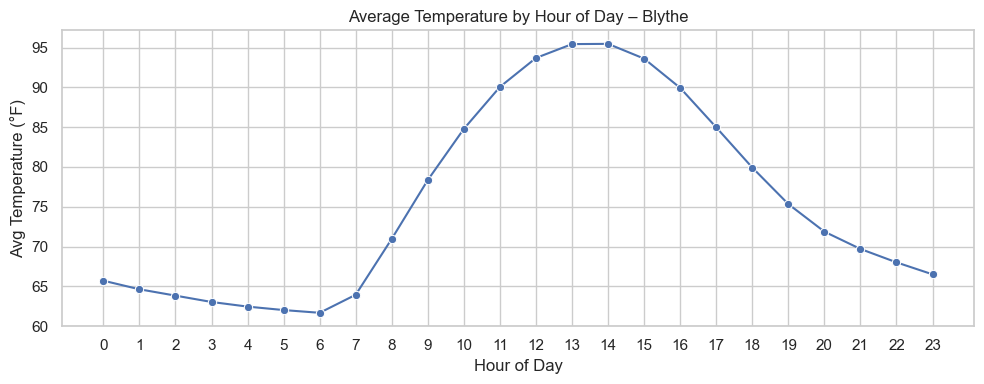

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


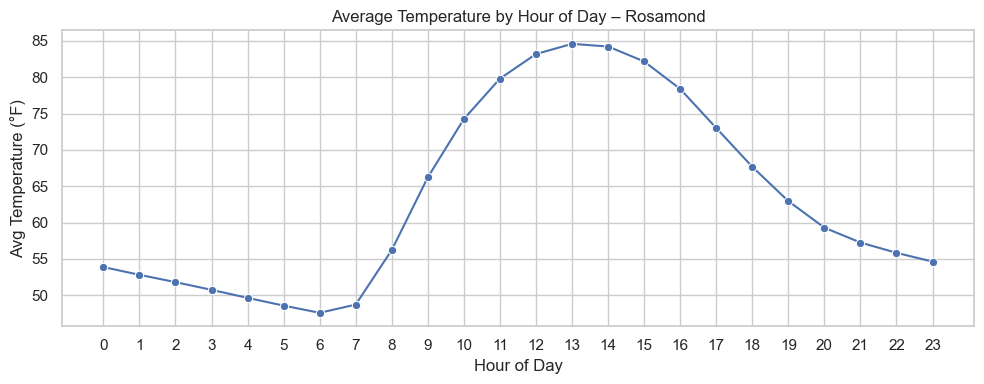

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from the Pacific Time datetime
working_checkpoint["hour"] = working_checkpoint["valid_time_PT"].dt.hour

# Group by hour and location to get average temperature
avg_temp_by_hour = (
    working_checkpoint
    .groupby(["point_name", "hour"])["t_F"]
    .mean()
    .reset_index()
)

# Plot one figure per location
sns.set(style="whitegrid")
locations = avg_temp_by_hour["point_name"].unique()

for loc in locations:
    plt.figure(figsize=(10, 4))
    sns.lineplot(
        data=avg_temp_by_hour[avg_temp_by_hour["point_name"] == loc],
        x="hour", y="t_F", marker="o"
    )
    plt.title(f"Average Temperature by Hour of Day – {loc}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg Temperature (°F)")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Triple check because why not

In [ ]:
# Extract date from valid_time_PT
working_checkpoint['valid_date_PT'] = working_checkpoint['valid_time_PT'].dt.date
working_checkpoint['valid_hour_PT'] = working_checkpoint['valid_time_PT'].dt.hour

# Choose specific dates for spring forward and fall back in the dataset's range
spring_forward_date = pd.to_datetime("2021-03-14").date()  
fall_back_date = pd.to_datetime("2021-11-07").date()        

spring_total = working_checkpoint[working_checkpoint['valid_date_PT'] == spring_forward_date].shape[0]
fall_total = working_checkpoint[working_checkpoint['valid_date_PT'] == fall_back_date].shape[0]

print(f"Spring Forward ({spring_forward_date}) - Total Forecasted Hours: {spring_total}")
print(f"Fall Back ({fall_back_date}) - Total Forecasted Hours: {fall_total}")


Spring Forward (2021-03-14) - Total Forecasted Hours: 69
Fall Back (2021-11-07) - Total Forecasted Hours: 75


In [54]:
working_checkpoint.shape

(89765, 69)

Based on some calculations, it looks like we could be missing a small amount of hours in our dataset. Let's take a look at this.

In [ ]:
# Generate all hourly timestamps using naive datetimes, then localize
all_hours = pd.date_range(
    start="2020-12-05 23:00:00",
    end="2024-05-06 01:00:00",
    freq="H",
    tz="America/Los_Angeles"
)

# Get unique points from the data
points = working_checkpoint['point_name'].drop_duplicates()

# Create full expected combinations of point and hourly timestamps
full_index = pd.MultiIndex.from_product(
    [points, all_hours],
    names=['point_name', 'valid_time_PT']
).to_frame(index=False)

# Merge with actual data
actual = working_checkpoint[['point_name', 'valid_time_PT']]
merged = full_index.merge(actual, on=['point_name', 'valid_time_PT'], how='left', indicator=True)

# Filter to find missing combinations
missing = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

# Show results
print(f"Total missing (point_name, timestamp) combinations: {len(missing)}")
missing.head(25)


Total missing (point_name, timestamp) combinations: 25


/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_36352/772888983.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(


point_name             valid_time_PT
136       Blythe 2020-12-11 15:00:00-08:00
137       Blythe 2020-12-11 16:00:00-08:00
138       Blythe 2020-12-11 17:00:00-08:00
139       Blythe 2020-12-11 18:00:00-08:00
140       Blythe 2020-12-11 19:00:00-08:00
141       Blythe 2020-12-11 20:00:00-08:00
142       Blythe 2020-12-11 21:00:00-08:00
143       Blythe 2020-12-11 22:00:00-08:00
30065   Rosamond 2020-12-11 14:00:00-08:00
30066   Rosamond 2020-12-11 15:00:00-08:00
30067   Rosamond 2020-12-11 16:00:00-08:00
30068   Rosamond 2020-12-11 17:00:00-08:00
30069   Rosamond 2020-12-11 18:00:00-08:00
30070   Rosamond 2020-12-11 19:00:00-08:00
30071   Rosamond 2020-12-11 20:00:00-08:00
30072   Rosamond 2020-12-11 21:00:00-08:00
30073   Rosamond 2020-12-11 22:00:00-08:00
59996    Barstow 2020-12-11 15:00:00-08:00
59997    Barstow 2020-12-11 16:00:00-08:00
59998    Barstow 2020-12-11 17:00:00-08:00
59999    Barstow 2020-12-11 18:00:00-08:00
60000    Barstow 2020-12-11 19:00:00-08:00
60001    Barstow 2020-12-11 20:00:00-08:00
60002    Barstow 2020-12-11 21:00:00-08:00
60003    Barstow 2020-12-11 22:00:00-08:00

Okay, this makes sense. This data should be coming from our 12-10 csv file which was noticably smaller in size than the rest. Since this is so close to the beginning of our dataset (and will actually be lost once we merge with solar gen actuals, which don't go that far back), we can drop up to this date now or later when we merge. 

#### Let's bring in our solar actuals and DAM data

In [ ]:
# ACTUALS

import requests
import zipfile
import io
import time
from datetime import datetime, timedelta

def get_solar_generation_from_OASIS(start_date, end_date, increment_days=30, max_retries=5, retry_delay=30):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    all_data = []
    
    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=increment_days)
        if current_end_date > end_date:
            current_end_date = end_date
        
        start_str = current_start_date.strftime("%Y%m%dT07:00-0000")
        end_str = current_end_date.strftime("%Y%m%dT07:00-0000")

        params = {
            "queryname": "SLD_REN_FCST",
            "market_run_id": "ACTUAL",  
            "resultformat": 6,  
            "startdatetime": start_str,
            "enddatetime": end_str,
            "version": 1
        }
        
        retries = 0
        success = False
        while retries < max_retries and not success:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                if response.headers['Content-Type'] == 'application/x-zip-compressed': 
                    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
                        for zipinfo in thezip.infolist():
                            with thezip.open(zipinfo) as thefile:
                                filename = zipinfo.filename
                                if filename.endswith('.xml'):
                                    try:
                                        data = pd.read_xml(thefile)
                                        all_data.append(data)
                                    except Exception as e:
                                        print(f"Error parsing XML file {filename}: {e}")
                                elif filename.endswith('.csv'):
                                    try:
                                        data = pd.read_csv(thefile, encoding="ISO-8859-1")
                                        all_data.append(data)
                                    except Exception as e:
                                        print(f"Error parsing CSV file {filename}: {e}")
                                else:
                                    print(f"Unrecognized file format: {filename}")
                    success = True
                    time.sleep(0.5)
                else:
                    print(f"Unexpected content type: {response.headers['Content-Type']}")
                    print(response.text)
                    break
            elif response.status_code == 429:
                print(f"Rate limit exceeded. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                retries += 1
            else:
                print(f"Failed to retrieve data for {start_str} to {end_str}: HTTP {response.status_code}")
                break
        if not success:
            print(f"Failed to retrieve data after {max_retries} retries.")
        current_start_date = current_end_date + timedelta(days=1)

    # Ensure a DataFrame is returned
    if all_data:
        combined_data = pd.concat(all_data, ignore_index=True)
        print(combined_data.head())  # debug print
        return combined_data  # ✅ FIX: Returning the DataFrame
    else:
        print('No data dummy')
        return pd.DataFrame()  # ✅ FIX: Returning an empty DataFrame instead of None

# Try
start_date = "2020-12-05"
end_date = "2024-05-04"

df_solar = get_solar_generation_from_OASIS(start_date, end_date)

# Debugging check
print(type(df_solar)) 
print(df_solar.head()) 


Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit ex

In [ ]:
# Making sure we only take the Solar energy actuals from SP15
df_solar_sp15 = df_solar[(df_solar["RENEWABLE_TYPE"] == "Solar") & (df_solar["TRADING_HUB"] == "SP15")]
df_solar_sp15.head()

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
70      NaN    NaN     NaN  NaN  2021-12-01    13.0           0.0   
71      NaN    NaN     NaN  NaN  2021-12-01    15.0           0.0   
72      NaN    NaN     NaN  NaN  2021-12-01    12.0           0.0   
73      NaN    NaN     NaN  NaN  2021-12-01    19.0           0.0   
74      NaN    NaN     NaN  NaN  2021-12-01    11.0           0.0   

        INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
70  2021-12-01T20:00:00-00:00  2021-12-01T21:00:00-00:00        SP15   
71  2021-12-01T22:00:00-00:00  2021-12-01T23:00:00-00:00        SP15   
72  2021-12-01T19:00:00-00:00  2021-12-01T20:00:00-00:00        SP15   
73  2021-12-02T02:00:00-00:00  2021-12-02T03:00:00-00:00        SP15   
74  2021-12-01T18:00:00-00:00  2021-12-01T19:00:00-00:00        SP15   

   RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
70          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
71          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
72          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
73          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
74          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

    MARKET_RUN_ID_POS  RENEW_POS          MW MARKET_RUN_ID  GROUP  
70                3.0        3.0  5978.69191        ACTUAL    3.0  
71                3.0        3.0  5152.40179        ACTUAL    3.0  
72                3.0        3.0  5970.23315        ACTUAL    3.0  
73                3.0        3.0   -13.66388        ACTUAL    3.0  
74                3.0        3.0  5848.59531        ACTUAL    3.0

In [ ]:
# Sorting data by date and hour
df_solar_sp15_sorted = df_solar_sp15.sort_values(by=["OPR_DT", "OPR_HR"])
df_solar_sp15_sorted.tail(10)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
104527      NaN    NaN     NaN  NaN  2024-05-03    15.0           0.0   
104523      NaN    NaN     NaN  NaN  2024-05-03    16.0           0.0   
104534      NaN    NaN     NaN  NaN  2024-05-03    17.0           0.0   
104532      NaN    NaN     NaN  NaN  2024-05-03    18.0           0.0   
104530      NaN    NaN     NaN  NaN  2024-05-03    19.0           0.0   
104528      NaN    NaN     NaN  NaN  2024-05-03    20.0           0.0   
104526      NaN    NaN     NaN  NaN  2024-05-03    21.0           0.0   
104524      NaN    NaN     NaN  NaN  2024-05-03    22.0           0.0   
104522      NaN    NaN     NaN  NaN  2024-05-03    23.0           0.0   
104520      NaN    NaN     NaN  NaN  2024-05-03    24.0           0.0   

            INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
104527  2024-05-03T21:00:00-00:00  2024-05-03T22:00:00-00:00        SP15   
104523  2024-05-03T22:00:00-00:00  2024-05-03T23:00:00-00:00        SP15   
104534  2024-05-03T23:00:00-00:00  2024-05-04T00:00:00-00:00        SP15   
104532  2024-05-04T00:00:00-00:00  2024-05-04T01:00:00-00:00        SP15   
104530  2024-05-04T01:00:00-00:00  2024-05-04T02:00:00-00:00        SP15   
104528  2024-05-04T02:00:00-00:00  2024-05-04T03:00:00-00:00        SP15   
104526  2024-05-04T03:00:00-00:00  2024-05-04T04:00:00-00:00        SP15   
104524  2024-05-04T04:00:00-00:00  2024-05-04T05:00:00-00:00        SP15   
104522  2024-05-04T05:00:00-00:00  2024-05-04T06:00:00-00:00        SP15   
104520  2024-05-04T06:00:00-00:00  2024-05-04T07:00:00-00:00        SP15   

       RENEWABLE_TYPE                                 LABEL  \
104527          Solar  Renewable Forecast Actual Generation   
104523          Solar  Renewable Forecast Actual Generation   
104534          Solar  Renewable Forecast Actual Generation   
104532          Solar  Renewable Forecast Actual Generation   
104530          Solar  Renewable Forecast Actual Generation   
104528          Solar  Renewable Forecast Actual Generation   
104526          Solar  Renewable Forecast Actual Generation   
104524          Solar  Renewable Forecast Actual Generation   
104522          Solar  Renewable Forecast Actual Generation   
104520          Solar  Renewable Forecast Actual Generation   

            XML_DATA_ITEM  MARKET_RUN_ID_POS  RENEW_POS           MW  \
104527  RENEW_FCST_ACT_MW                3.0        3.0  10361.87978   
104523  RENEW_FCST_ACT_MW                3.0        3.0  10014.89937   
104534  RENEW_FCST_ACT_MW                3.0        3.0   9178.37782   
104532  RENEW_FCST_ACT_MW                3.0        3.0   7805.43780   
104530  RENEW_FCST_ACT_MW                3.0        3.0   3604.79214   
104528  RENEW_FCST_ACT_MW                3.0        3.0    198.53636   
104526  RENEW_FCST_ACT_MW                3.0        3.0    -38.96138   
104524  RENEW_FCST_ACT_MW                3.0        3.0    -35.67349   
104522  RENEW_FCST_ACT_MW                3.0        3.0    -35.22847   
104520  RENEW_FCST_ACT_MW                3.0        3.0    -39.58521   

       MARKET_RUN_ID  GROUP  
104527        ACTUAL   33.0  
104523        ACTUAL   33.0  
104534        ACTUAL   33.0  
104532        ACTUAL   33.0  
104530        ACTUAL   33.0  
104528        ACTUAL   33.0  
104526        ACTUAL   33.0  
104524        ACTUAL   33.0  
104522        ACTUAL   33.0  
104520        ACTUAL   33.0

In [ ]:
# Rename data
df_solar_actual = df_solar_sp15_sorted

In [ ]:
# Save to drive
df_solar_actual.to_csv("/Volumes/USB DISK/Solar_Gen_Actuals/df_solar_sp15_actual.csv", index=False)

Now that we've retrieved our actuals, let's pull the predicted solar gen values for the Day-Ahead Market. Actuals only dated back to 2021-12-01, so we will make that our start date for this pull.

In [ ]:
def get_solar_generation_from_OASIS(start_date, end_date, increment_days=30, max_retries=5, retry_delay=30):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    all_data = []
    
    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=increment_days)
        if current_end_date > end_date:
            current_end_date = end_date
        
        start_str = current_start_date.strftime("%Y%m%dT07:00-0000")
        end_str = current_end_date.strftime("%Y%m%dT07:00-0000")

        params = {
            "queryname": "SLD_REN_FCST",
            "market_run_id": "DAM",  # This is what indicates predicteds (day ahead market)
            "resultformat": 6,  
            "startdatetime": start_str,
            "enddatetime": end_str,
            "version": 1
        }
        
        retries = 0
        success = False
        while retries < max_retries and not success:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                if response.headers['Content-Type'] == 'application/x-zip-compressed': 
                    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
                        for zipinfo in thezip.infolist():
                            with thezip.open(zipinfo) as thefile:
                                filename = zipinfo.filename
                                if filename.endswith('.xml'):
                                    try:
                                        data = pd.read_xml(thefile)
                                        all_data.append(data)
                                    except Exception as e:
                                        print(f"Error parsing XML file {filename}: {e}")
                                elif filename.endswith('.csv'):
                                    try:
                                        data = pd.read_csv(thefile, encoding="ISO-8859-1")
                                        all_data.append(data)
                                    except Exception as e:
                                        print(f"Error parsing CSV file {filename}: {e}")
                                else:
                                    print(f"Unrecognized file format: {filename}")
                    success = True
                    time.sleep(0.5)
                else:
                    print(f"Unexpected content type: {response.headers['Content-Type']}")
                    print(response.text)
                    break
            elif response.status_code == 429:
                print(f"Rate limit exceeded. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                retries += 1
            else:
                print(f"Failed to retrieve data for {start_str} to {end_str}: HTTP {response.status_code}")
                break
        if not success:
            print(f"Failed to retrieve data after {max_retries} retries.")
        current_start_date = current_end_date + timedelta(days=1)

    # Ensure a DataFrame is returned
    if all_data:
        combined_data = pd.concat(all_data, ignore_index=True)
        print(combined_data.head())  # debug print
        return combined_data  # ✅ FIX: Returning the DataFrame
    else:
        print('No data dummy')
        return pd.DataFrame()  # ✅ FIX: Returning an empty DataFrame instead of None

# Example usage
start_date = "2021-12-01"
end_date = "2024-05-04"

df_solar_pred = get_solar_generation_from_OASIS(start_date, end_date)

# Debugging check
print(type(df_solar_pred))  
print(df_solar_pred.head())  


Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit exceeded. Retrying in 30 seconds...
Rate limit ex

In [ ]:
# Only keep solar from SP15
df_solar_sp15_pred = df_solar_pred[(df_solar_pred["RENEWABLE_TYPE"] == "Solar") & (df_solar_pred["TRADING_HUB"] == "SP15")]
df_solar_sp15_pred.head()

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
48  2021-12-01      13             0  2021-12-01T20:00:00-00:00   
49  2021-12-01      15             0  2021-12-01T22:00:00-00:00   
50  2021-12-01      12             0  2021-12-01T19:00:00-00:00   
51  2021-12-01      19             0  2021-12-02T02:00:00-00:00   
52  2021-12-01      11             0  2021-12-01T18:00:00-00:00   

          INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
48  2021-12-01T21:00:00-00:00        SP15          Solar   
49  2021-12-01T23:00:00-00:00        SP15          Solar   
50  2021-12-01T20:00:00-00:00        SP15          Solar   
51  2021-12-02T03:00:00-00:00        SP15          Solar   
52  2021-12-01T19:00:00-00:00        SP15          Solar   

                           LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
48  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
49  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
50  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
51  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
52  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   

    RENEW_POS       MW MARKET_RUN_ID  GROUP  
48          2  6443.80           DAM      3  
49          2  5470.53           DAM      3  
50          2  6448.45           DAM      3  
51          2     0.00           DAM      3  
52          2  6467.29           DAM      3

In [ ]:
# Sort by date and hour
df_solar_sp15_pred_sorted = df_solar_sp15_pred.sort_values(by=["OPR_DT", "OPR_HR"])
df_solar_sp15_pred_sorted.head(10)

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
71  2021-12-01       1             0  2021-12-01T08:00:00-00:00   
70  2021-12-01       2             0  2021-12-01T09:00:00-00:00   
68  2021-12-01       3             0  2021-12-01T10:00:00-00:00   
66  2021-12-01       4             0  2021-12-01T11:00:00-00:00   
64  2021-12-01       5             0  2021-12-01T12:00:00-00:00   
62  2021-12-01       6             0  2021-12-01T13:00:00-00:00   
60  2021-12-01       7             0  2021-12-01T14:00:00-00:00   
58  2021-12-01       8             0  2021-12-01T15:00:00-00:00   
56  2021-12-01       9             0  2021-12-01T16:00:00-00:00   
54  2021-12-01      10             0  2021-12-01T17:00:00-00:00   

          INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
71  2021-12-01T09:00:00-00:00        SP15          Solar   
70  2021-12-01T10:00:00-00:00        SP15          Solar   
68  2021-12-01T11:00:00-00:00        SP15          Solar   
66  2021-12-01T12:00:00-00:00        SP15          Solar   
64  2021-12-01T13:00:00-00:00        SP15          Solar   
62  2021-12-01T14:00:00-00:00        SP15          Solar   
60  2021-12-01T15:00:00-00:00        SP15          Solar   
58  2021-12-01T16:00:00-00:00        SP15          Solar   
56  2021-12-01T17:00:00-00:00        SP15          Solar   
54  2021-12-01T18:00:00-00:00        SP15          Solar   

                           LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
71  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
70  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
68  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
66  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
64  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
62  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
60  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
58  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
56  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
54  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   

    RENEW_POS       MW MARKET_RUN_ID  GROUP  
71          2     0.00           DAM      3  
70          2     0.00           DAM      3  
68          2     0.00           DAM      3  
66          2     0.00           DAM      3  
64          2     0.00           DAM      3  
62          2     0.00           DAM      3  
60          2   151.69           DAM      3  
58          2  2438.99           DAM      3  
56          2  5427.53           DAM      3  
54          2  6361.96           DAM      3

In [ ]:
# Save this to drive
df_solar_pred.to_csv("/Volumes/USB DISK/Solar_Gen_Pred/df_solar_sp15_pred.csv", index=False)

Let's read the actuals and predicteds in, look at them a bit under the hood, and then do some merging.

In [56]:
actuals = pd.read_csv("/Volumes/USB DISK/Solar_Gen_Actuals/df_solar_sp15_actual.csv")
actuals.head()

TimeDate  Source  Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
0       NaN     NaN      NaN  NaN  2021-12-01     1.0           0.0   
1       NaN     NaN      NaN  NaN  2021-12-01     2.0           0.0   
2       NaN     NaN      NaN  NaN  2021-12-01     3.0           0.0   
3       NaN     NaN      NaN  NaN  2021-12-01     4.0           0.0   
4       NaN     NaN      NaN  NaN  2021-12-01     5.0           0.0   

       INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
0  2021-12-01T08:00:00-00:00  2021-12-01T09:00:00-00:00        SP15   
1  2021-12-01T09:00:00-00:00  2021-12-01T10:00:00-00:00        SP15   
2  2021-12-01T10:00:00-00:00  2021-12-01T11:00:00-00:00        SP15   
3  2021-12-01T11:00:00-00:00  2021-12-01T12:00:00-00:00        SP15   
4  2021-12-01T12:00:00-00:00  2021-12-01T13:00:00-00:00        SP15   

  RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
0          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
1          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
2          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
4          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

   MARKET_RUN_ID_POS  RENEW_POS       MW MARKET_RUN_ID  GROUP  
0                3.0        3.0  2.50251        ACTUAL    3.0  
1                3.0        3.0  1.58447        ACTUAL    3.0  
2                3.0        3.0  2.47010        ACTUAL    3.0  
3                3.0        3.0  2.27596        ACTUAL    3.0  
4                3.0        3.0  2.04619        ACTUAL    3.0

In [57]:
preds = pd.read_csv("/Volumes/USB DISK/Solar_Gen_Pred/df_solar_sp15_pred.csv")
preds.head()

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
0  2021-12-01       1             0  2021-12-01T08:00:00-00:00   
1  2021-12-01       2             0  2021-12-01T09:00:00-00:00   
2  2021-12-01       3             0  2021-12-01T10:00:00-00:00   
3  2021-12-01       4             0  2021-12-01T11:00:00-00:00   
4  2021-12-01       5             0  2021-12-01T12:00:00-00:00   

         INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
0  2021-12-01T09:00:00-00:00        SP15          Solar   
1  2021-12-01T10:00:00-00:00        SP15          Solar   
2  2021-12-01T11:00:00-00:00        SP15          Solar   
3  2021-12-01T12:00:00-00:00        SP15          Solar   
4  2021-12-01T13:00:00-00:00        SP15          Solar   

                          LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
0  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
1  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
2  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
3  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
4  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   

   RENEW_POS   MW MARKET_RUN_ID  GROUP  
0          2  0.0           DAM      3  
1          2  0.0           DAM      3  
2          2  0.0           DAM      3  
3          2  0.0           DAM      3  
4          2  0.0           DAM      3

In [ ]:
actuals.columns

Index(['TimeDate', 'Source', 'Version', 'RTO', 'OPR_DT', 'OPR_HR',
       'OPR_INTERVAL', 'INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT',
       'TRADING_HUB', 'RENEWABLE_TYPE', 'LABEL', 'XML_DATA_ITEM',
       'MARKET_RUN_ID_POS', 'RENEW_POS', 'MW', 'MARKET_RUN_ID', 'GROUP'],
      dtype='object')

In [ ]:
preds.columns

Index(['OPR_DT', 'OPR_HR', 'OPR_INTERVAL', 'INTERVALSTARTTIME_GMT',
       'INTERVALENDTIME_GMT', 'TRADING_HUB', 'RENEWABLE_TYPE', 'LABEL',
       'XML_DATA_ITEM', 'MARKET_RUN_ID_POS', 'RENEW_POS', 'MW',
       'MARKET_RUN_ID', 'GROUP'],
      dtype='object')

In [58]:
actuals.shape

(20522, 18)

In [59]:
preds.shape

(20567, 14)

It looks like we have fewer hours than we'd expect for this interval of time, so let's run some code to find out where this is coming from

In [ ]:
# Ensure datetime format
actuals['INTERVALSTARTTIME_GMT'] = pd.to_datetime(actuals['INTERVALSTARTTIME_GMT'])

# Sort just in case
actuals = actuals.sort_values('INTERVALSTARTTIME_GMT')

# Generate expected full range of hourly timestamps
expected_hours = pd.date_range(
    start='2021-12-01T08:00:00Z', 
    end='2024-05-04T06:00:00Z', 
    freq='H'
)

# Find missing timestamps
actual_hours = actuals['INTERVALSTARTTIME_GMT'].drop_duplicates()
missing_hours = expected_hours.difference(actual_hours)

# Let's see
missing_df = pd.DataFrame({'missing_hour_UTC': missing_hours})
print(f"Number of missing hours: {len(missing_df)}")
missing_df.head()


Number of missing hours: 717


/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_36352/440257116.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(


missing_hour_UTC
0 2021-12-11 07:00:00+00:00
1 2021-12-11 08:00:00+00:00
2 2021-12-11 09:00:00+00:00
3 2021-12-11 10:00:00+00:00
4 2021-12-11 11:00:00+00:00

In [61]:
# Extract just the date from each missing timestamp
missing_df['missing_date_GMT'] = missing_df['missing_hour_UTC'].dt.date

# Count the number of unique dates
num_unique_days = missing_df['missing_date_GMT'].nunique()

print(f"Number of unique days with at least one missing hour: {num_unique_days}")


Number of unique days with at least one missing hour: 76


In [ ]:
# Extract just the date portion
missing_df['missing_date_UTC'] = missing_df['missing_hour_UTC'].dt.date

# Count number of unique dates
num_unique_days = missing_df['missing_date_UTC'].nunique()
print(f"Number of unique days with at least one missing hour: {num_unique_days}")

# List of those dates
unique_dates = missing_df['missing_date_UTC'].unique()
print("\nDates with missing hours:")
print(sorted(unique_dates))

# Count how many missing hours per date
hours_per_day = missing_df['missing_date_UTC'].value_counts().sort_values(ascending=False)
print("\nNumber of missing hours per date:")
print(hours_per_day)


Number of unique days with at least one missing hour: 76

Dates with missing hours:
[datetime.date(2021, 12, 11), datetime.date(2021, 12, 12), datetime.date(2022, 1, 11), datetime.date(2022, 1, 12), datetime.date(2022, 2, 11), datetime.date(2022, 2, 12), datetime.date(2022, 3, 14), datetime.date(2022, 3, 15), datetime.date(2022, 4, 14), datetime.date(2022, 4, 15), datetime.date(2022, 5, 15), datetime.date(2022, 5, 16), datetime.date(2022, 6, 15), datetime.date(2022, 6, 16), datetime.date(2022, 7, 16), datetime.date(2022, 7, 17), datetime.date(2022, 8, 16), datetime.date(2022, 8, 17), datetime.date(2022, 9, 16), datetime.date(2022, 9, 17), datetime.date(2022, 10, 17), datetime.date(2022, 10, 18), datetime.date(2022, 11, 17), datetime.date(2022, 11, 18), datetime.date(2022, 12, 18), datetime.date(2022, 12, 19), datetime.date(2023, 1, 18), datetime.date(2023, 1, 19), datetime.date(2023, 2, 18), datetime.date(2023, 2, 19), datetime.date(2023, 3, 21), datetime.date(2023, 3, 22), datetime.da

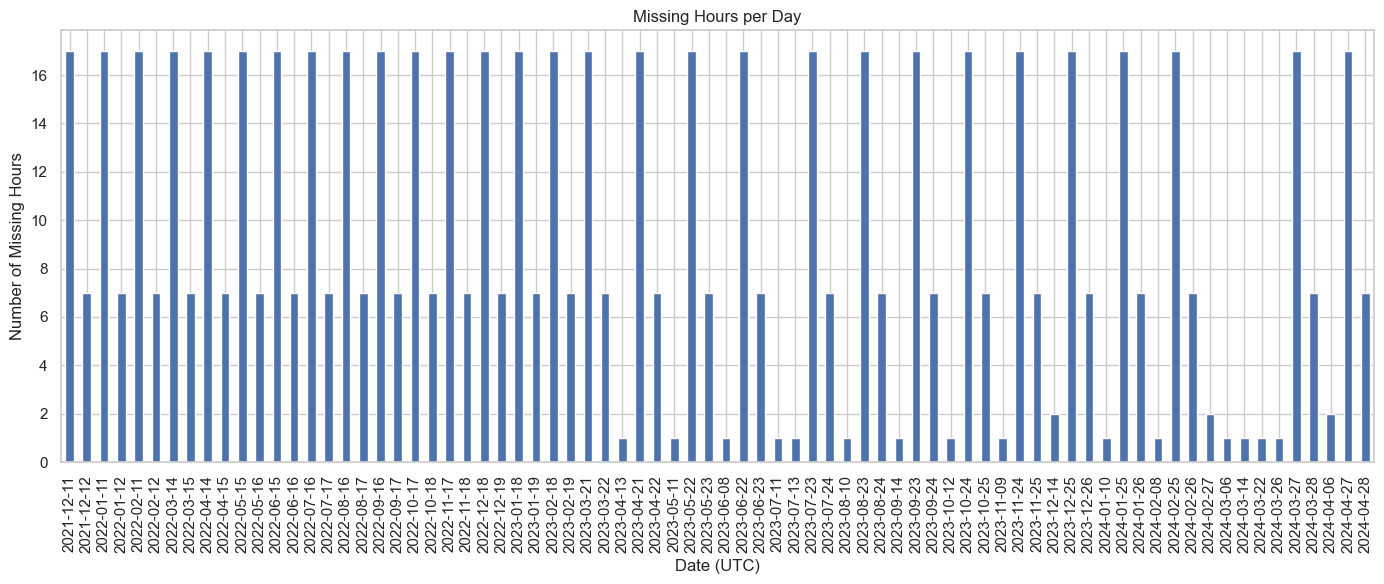

In [63]:
import matplotlib.pyplot as plt

# Sort by date instead of frequency
hours_per_day_sorted = hours_per_day.sort_index()

# Plotting the bar chart
plt.figure(figsize=(14, 6))
hours_per_day_sorted.plot(kind='bar')

plt.title("Missing Hours per Day")
plt.xlabel("Date (UTC)")
plt.ylabel("Number of Missing Hours")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


 There is notably a pattern in the missing data here. We see the 11th and 12th missing for a few months in a row, then the 14th and 15th for a few, then 15th and 16th for a few, then 16th 17th for a few etc. They also look to be 24 hour increments of missing data. Let's do a similar investigation with the preds.

In [ ]:
# Convert INTERVALSTARTTIME_GMT to datetime if not already in datetime format
preds['INTERVALSTARTTIME_GMT'] = pd.to_datetime(preds['INTERVALSTARTTIME_GMT'], errors='coerce')

# Generate all expected hourly timestamps in the range from 2021-12-01T08:00:00 to 2024-05-04T06:00:00
all_hours_preds = pd.date_range(
    start="2021-12-01 08:00:00+00:00",  
    end="2024-05-04 06:00:00+00:00",  
    freq="H"
)

# Check which hours in the all_hours_preds are missing in preds dataset
# We will check for any timestamps that are not in the preds['INTERVALSTARTTIME_GMT'] list
missing_hours_preds = set(all_hours_preds) - set(preds['INTERVALSTARTTIME_GMT'])

# Convert the missing hours set back into a DataFrame for analysis
missing_hours_df_preds = pd.DataFrame(list(missing_hours_preds), columns=["missing_time"])
missing_hours_df_preds.sort_values("missing_time", inplace=True)

# Count the number of missing hours and find out which unique days these missing hours fall on
missing_days_preds = missing_hours_df_preds['missing_time'].dt.date.value_counts().sort_index()

print(f"Number of missing hours: {len(missing_hours_df_preds)}")
print(f"Missing hours by day:\n{missing_days_preds}")



/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_36352/4163719045.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours_preds = pd.date_range(


Number of missing hours: 672
Missing hours by day:
missing_time
2021-12-31    17
2022-01-01     7
2022-01-31    17
2022-02-01     7
2022-03-03    17
2022-03-04     7
2022-04-03    17
2022-04-04     7
2022-05-04    17
2022-05-05     7
2022-06-04    17
2022-06-05     7
2022-07-05    17
2022-07-06     7
2022-08-05    17
2022-08-06     7
2022-09-05    17
2022-09-06     7
2022-10-06    17
2022-10-07     7
2022-11-06    17
2022-11-07     7
2022-12-07    17
2022-12-08     7
2023-01-07    17
2023-01-08     7
2023-02-07    17
2023-02-08     7
2023-03-10    17
2023-03-11     7
2023-04-10    17
2023-04-11     7
2023-05-11    17
2023-05-12     7
2023-06-11    17
2023-06-12     7
2023-07-12    17
2023-07-13     7
2023-08-12    17
2023-08-13     7
2023-09-12    17
2023-09-13     7
2023-10-13    17
2023-10-14     7
2023-11-13    17
2023-11-14     7
2023-12-14    17
2023-12-15     7
2024-01-14    17
2024-01-15     7
2024-02-14    17
2024-02-15     7
2024-03-16    17
2024-03-17     7
2024-04-16    17
2

In [65]:
# Extract just the date from each missing timestamp in the preds dataset
missing_hours_df_preds['missing_date_GMT'] = missing_hours_df_preds['missing_time'].dt.date

# Count the number of unique dates
num_unique_days_preds = missing_hours_df_preds['missing_date_GMT'].nunique()

print(f"Number of unique days with at least one missing hour in preds dataset: {num_unique_days_preds}")


Number of unique days with at least one missing hour in preds dataset: 56


In [ ]:
missing_hours_df_preds['missing_time'] = pd.to_datetime(missing_hours_df_preds['missing_time'])
# Extract just the date from each missing timestamp in the preds dataset
missing_hours_df_preds['missing_date_GMT'] = missing_hours_df_preds['missing_time'].dt.date

# Count the number of unique dates
num_unique_days_preds = missing_hours_df_preds['missing_date_GMT'].nunique()
print(f"Number of unique days with at least one missing hour in preds dataset: {num_unique_days_preds}")

# Count how many missing hours per date
hours_per_day_preds = missing_hours_df_preds['missing_date_GMT'].value_counts().sort_index()
print(f"Missing hours by day:\n{hours_per_day_preds}")


Number of unique days with at least one missing hour in preds dataset: 56
Missing hours by day:
missing_date_GMT
2021-12-31    17
2022-01-01     7
2022-01-31    17
2022-02-01     7
2022-03-03    17
2022-03-04     7
2022-04-03    17
2022-04-04     7
2022-05-04    17
2022-05-05     7
2022-06-04    17
2022-06-05     7
2022-07-05    17
2022-07-06     7
2022-08-05    17
2022-08-06     7
2022-09-05    17
2022-09-06     7
2022-10-06    17
2022-10-07     7
2022-11-06    17
2022-11-07     7
2022-12-07    17
2022-12-08     7
2023-01-07    17
2023-01-08     7
2023-02-07    17
2023-02-08     7
2023-03-10    17
2023-03-11     7
2023-04-10    17
2023-04-11     7
2023-05-11    17
2023-05-12     7
2023-06-11    17
2023-06-12     7
2023-07-12    17
2023-07-13     7
2023-08-12    17
2023-08-13     7
2023-09-12    17
2023-09-13     7
2023-10-13    17
2023-10-14     7
2023-11-13    17
2023-11-14     7
2023-12-14    17
2023-12-15     7
2024-01-14    17
2024-01-15     7
2024-02-14    17
2024-02-15     7
202

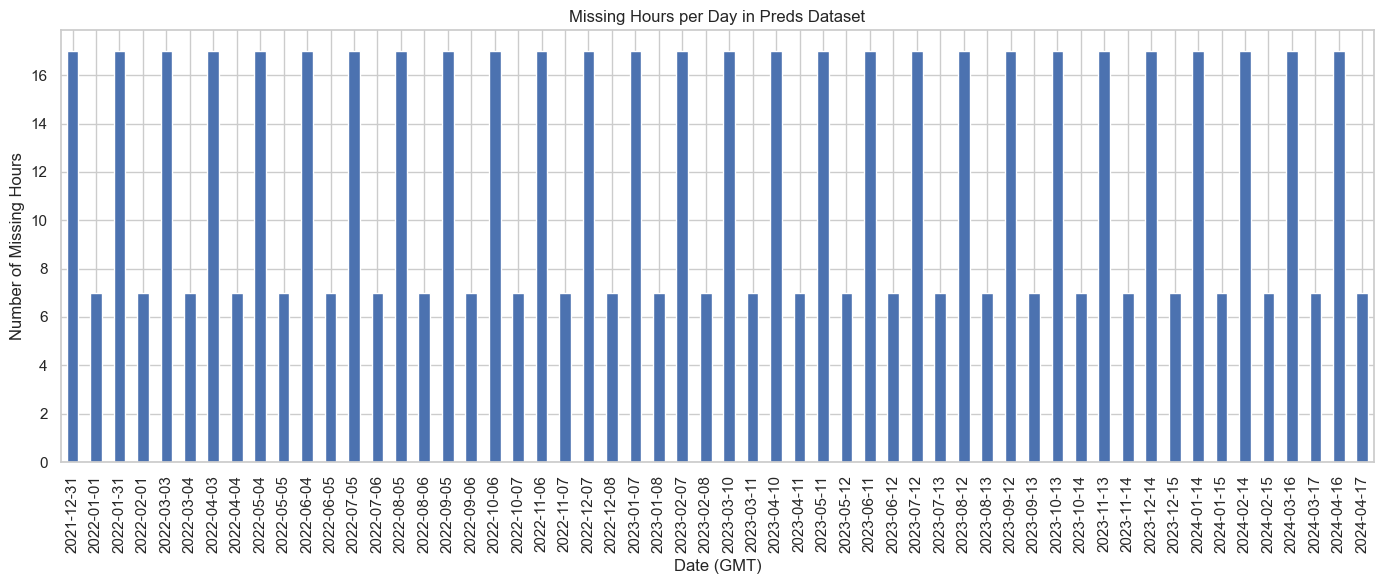

In [ ]:
# Sort by date to make sure x-axis is in order
hours_per_day_preds_sorted = hours_per_day_preds.sort_index()

# Plot bar chart
plt.figure(figsize=(14, 6))
hours_per_day_preds_sorted.plot(kind='bar')

plt.title("Missing Hours per Day in Preds Dataset")
plt.xlabel("Date (GMT)")
plt.ylabel("Number of Missing Hours")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


We again see a pattern in the missing dates here. We see 31st and 1st for a few months, then 3rd and 4th, then 4th and 5th for a few, then 5th and 6th for a few, etc. Seeing patterns like this in both datasets suggests perhaps it's a maintenance issue or on some sort of schedule. Doesn't seem to be super sporadic.

*** I later find out this was not a maintenance issue, but a throttling issue!

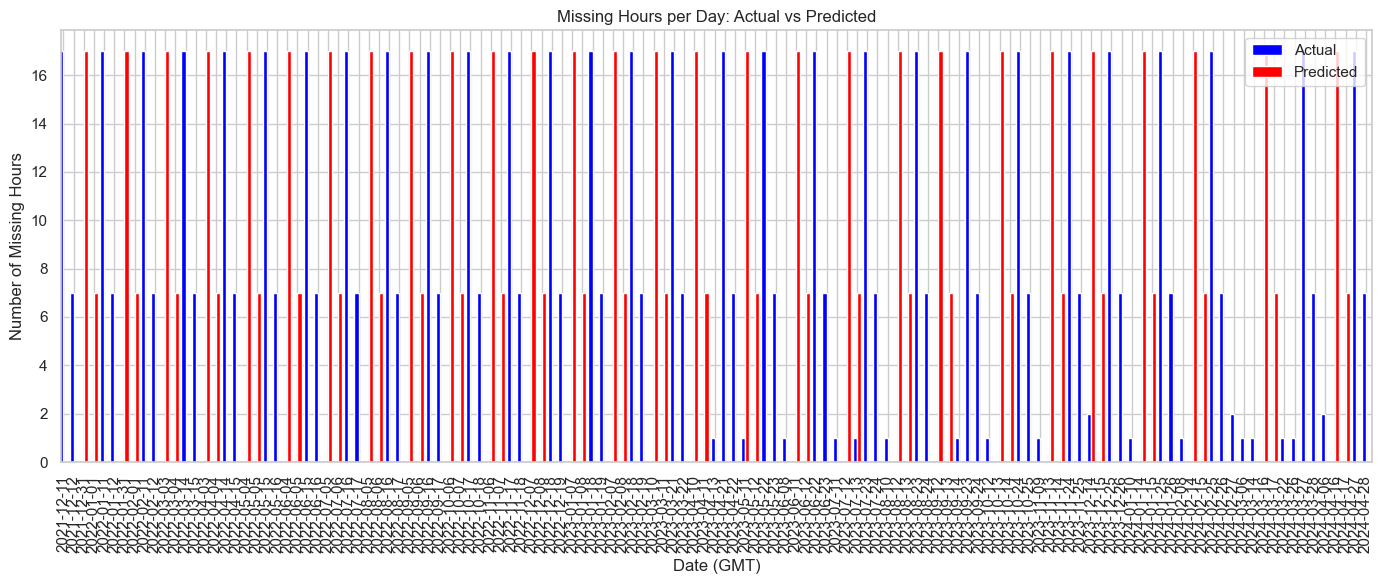

In [ ]:
# Sort both series by date to align them
hours_per_day_sorted_actual = hours_per_day.sort_index()  # Actual data
hours_per_day_sorted_preds = hours_per_day_preds.sort_index()  # Predicted data

# Merge both missing hour counts on the same date index
merged_missing_hours = pd.DataFrame({
    'actual': hours_per_day_sorted_actual,
    'predicted': hours_per_day_sorted_preds
}).fillna(0)  # Fill missing values with 0

plt.figure(figsize=(14, 6))

merged_missing_hours['actual'].plot(kind='bar', color='blue', width=0.4, position=1, label='Actual')
merged_missing_hours['predicted'].plot(kind='bar', color='red', width=0.4, position=0, label='Predicted')

plt.title("Missing Hours per Day: Actual vs Predicted")
plt.xlabel("Date (GMT)")
plt.ylabel("Number of Missing Hours")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()


Alright, semi-painful learning moment here. The gaps in my data shown above are (mostly) not missing when cross-checking with the CAISO API dashboard online (https://oasis.caiso.com/mrioasis/logon.do). It looks like my pulls from the API were throttling and resulting in small amounts of missing data each time. Let's try to target smaller chunks of time and be a bit more conservative with the wait times to fill in these gaps.

In [ ]:
def get_solar_generation_from_OASIS(start_date, end_date, increment_days=14, max_retries=10, retry_delay=40):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    all_data = []
    failed_chunks = []

    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=increment_days)
        if current_end_date > end_date:
            current_end_date = end_date
        
        start_str = current_start_date.strftime("%Y%m%dT07:00-0000")
        end_str = current_end_date.strftime("%Y%m%dT07:00-0000")

        params = {
            "queryname": "SLD_REN_FCST",
            "market_run_id": "ACTUAL",
            "resultformat": 6,
            "startdatetime": start_str,
            "enddatetime": end_str,
            "version": 1
        }
        
        retries = 0
        success = False
        while retries < max_retries and not success:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                if response.headers['Content-Type'] == 'application/x-zip-compressed': 
                    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
                        for zipinfo in thezip.infolist():
                            with thezip.open(zipinfo) as thefile:
                                filename = zipinfo.filename
                                try:
                                    if filename.endswith('.xml'):
                                        data = pd.read_xml(thefile)
                                    elif filename.endswith('.csv'):
                                        data = pd.read_csv(thefile, encoding="ISO-8859-1")
                                    else:
                                        print(f"Unrecognized file format: {filename}")
                                        continue
                                    all_data.append(data)
                                except Exception as e:
                                    print(f"Error parsing {filename}: {e}")
                    success = True
                    time.sleep(5)
                else:
                    print(f"Unexpected content type: {response.headers['Content-Type']}")
                    break
            elif response.status_code == 429:
                wait = retry_delay * (2 ** retries)  # exponential backoff
                print(f"Rate limit exceeded. Retrying in {wait} seconds...")
                time.sleep(wait)
                retries += 1
            else:
                print(f"Failed to retrieve data for {start_str} to {end_str}: HTTP {response.status_code}")
                break
        if not success:
            print(f"❌ Failed to retrieve data for {start_str} to {end_str} after {max_retries} retries.")
            failed_chunks.append((start_str, end_str))
        current_start_date = current_end_date + timedelta(days=1)

    if failed_chunks:
        print("\n⚠️ The following date chunks failed and may have missing data:")
        for chunk in failed_chunks:
            print(f" - {chunk[0]} to {chunk[1]}")

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

start_date = "2021-12-01"
end_date = "2024-05-04"

df_solar_actual_new = get_solar_generation_from_OASIS(start_date, end_date)

print(type(df_solar_actual_new))
df_solar_actual_new.head()  


<class 'pandas.core.frame.DataFrame'>


TimeDate Source    Version   RTO      OPR_DT  OPR_HR  \
0  2025-04-23T14:00:18.628Z  OASIS  v20131201  None         NaN     NaN   
1                      None   None       None    \n         NaN     NaN   
2  2025-04-23T14:00:25.927Z  OASIS  v20131201  None         NaN     NaN   
3                      None   None       None    \n         NaN     NaN   
4                       NaN    NaN        NaN   NaN  2022-01-01    13.0   

   OPR_INTERVAL      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT  \
0           NaN                        NaN                        NaN   
1           NaN                        NaN                        NaN   
2           NaN                        NaN                        NaN   
3           NaN                        NaN                        NaN   
4           0.0  2022-01-01T20:00:00-00:00  2022-01-01T21:00:00-00:00   

  TRADING_HUB RENEWABLE_TYPE                                 LABEL  \
0         NaN            NaN                                   NaN   
1         NaN            NaN                                   NaN   
2         NaN            NaN                                   NaN   
3         NaN            NaN                                   NaN   
4        NP15          Solar  Renewable Forecast Actual Generation   

       XML_DATA_ITEM  MARKET_RUN_ID_POS  RENEW_POS          MW MARKET_RUN_ID  \
0                NaN                NaN        NaN         NaN           NaN   
1                NaN                NaN        NaN         NaN           NaN   
2                NaN                NaN        NaN         NaN           NaN   
3                NaN                NaN        NaN         NaN           NaN   
4  RENEW_FCST_ACT_MW                3.0        3.0  1088.83371        ACTUAL   

   GROUP  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    1.0

In [ ]:
df_solar_actual_new.tail()

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
97440      NaN    NaN     NaN  NaN  2024-05-02    14.0           0.0   
97441      NaN    NaN     NaN  NaN  2024-05-02     8.0           0.0   
97442      NaN    NaN     NaN  NaN  2024-05-02     7.0           0.0   
97443      NaN    NaN     NaN  NaN  2024-05-02    13.0           0.0   
97444      NaN    NaN     NaN  NaN  2024-05-02     6.0           0.0   

           INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
97440  2024-05-02T20:00:00-00:00  2024-05-02T21:00:00-00:00        ZP26   
97441  2024-05-02T14:00:00-00:00  2024-05-02T15:00:00-00:00        ZP26   
97442  2024-05-02T13:00:00-00:00  2024-05-02T14:00:00-00:00        ZP26   
97443  2024-05-02T19:00:00-00:00  2024-05-02T20:00:00-00:00        ZP26   
97444  2024-05-02T12:00:00-00:00  2024-05-02T13:00:00-00:00        ZP26   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
97440           Wind  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97441           Wind  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97442           Wind  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97443           Wind  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97444           Wind  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

       MARKET_RUN_ID_POS  RENEW_POS        MW MARKET_RUN_ID  GROUP  
97440                3.0        1.0  41.86093        ACTUAL   84.0  
97441                3.0        1.0  76.47235        ACTUAL   84.0  
97442                3.0        1.0  79.62578        ACTUAL   84.0  
97443                3.0        1.0  40.07307        ACTUAL   84.0  
97444                3.0        1.0  86.74313        ACTUAL   84.0

In [ ]:
# Only keep solar from SP15 like before
df_solar_sp15_new = df_solar_actual_new[(df_solar_actual_new["RENEWABLE_TYPE"] == "Solar") & (df_solar_actual_new["TRADING_HUB"] == "SP15")]
df_solar_sp15_new.head()

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
52      NaN    NaN     NaN  NaN  2022-01-01    13.0           0.0   
53      NaN    NaN     NaN  NaN  2022-01-01    15.0           0.0   
54      NaN    NaN     NaN  NaN  2022-01-01    12.0           0.0   
55      NaN    NaN     NaN  NaN  2022-01-01    19.0           0.0   
56      NaN    NaN     NaN  NaN  2022-01-01    11.0           0.0   

        INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
52  2022-01-01T20:00:00-00:00  2022-01-01T21:00:00-00:00        SP15   
53  2022-01-01T22:00:00-00:00  2022-01-01T23:00:00-00:00        SP15   
54  2022-01-01T19:00:00-00:00  2022-01-01T20:00:00-00:00        SP15   
55  2022-01-02T02:00:00-00:00  2022-01-02T03:00:00-00:00        SP15   
56  2022-01-01T18:00:00-00:00  2022-01-01T19:00:00-00:00        SP15   

   RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
52          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
53          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
54          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
55          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
56          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

    MARKET_RUN_ID_POS  RENEW_POS          MW MARKET_RUN_ID  GROUP  
52                3.0        3.0  6071.62653        ACTUAL    3.0  
53                3.0        3.0  5298.12336        ACTUAL    3.0  
54                3.0        3.0  6102.93060        ACTUAL    3.0  
55                3.0        3.0   -33.63134        ACTUAL    3.0  
56                3.0        3.0  6165.55810        ACTUAL    3.0

In [ ]:
# Sorting data by date and hour
df_solar_sp15_new = df_solar_sp15_new.sort_values(by=["OPR_DT", "OPR_HR"])
df_solar_sp15_new.tail(10)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
97353      NaN    NaN     NaN  NaN  2024-05-02    15.0           0.0   
97354      NaN    NaN     NaN  NaN  2024-05-02    16.0           0.0   
97355      NaN    NaN     NaN  NaN  2024-05-02    17.0           0.0   
97356      NaN    NaN     NaN  NaN  2024-05-02    18.0           0.0   
97357      NaN    NaN     NaN  NaN  2024-05-02    19.0           0.0   
97363      NaN    NaN     NaN  NaN  2024-05-02    20.0           0.0   
97364      NaN    NaN     NaN  NaN  2024-05-02    21.0           0.0   
97365      NaN    NaN     NaN  NaN  2024-05-02    22.0           0.0   
97366      NaN    NaN     NaN  NaN  2024-05-02    23.0           0.0   
97367      NaN    NaN     NaN  NaN  2024-05-02    24.0           0.0   

           INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
97353  2024-05-02T21:00:00-00:00  2024-05-02T22:00:00-00:00        SP15   
97354  2024-05-02T22:00:00-00:00  2024-05-02T23:00:00-00:00        SP15   
97355  2024-05-02T23:00:00-00:00  2024-05-03T00:00:00-00:00        SP15   
97356  2024-05-03T00:00:00-00:00  2024-05-03T01:00:00-00:00        SP15   
97357  2024-05-03T01:00:00-00:00  2024-05-03T02:00:00-00:00        SP15   
97363  2024-05-03T02:00:00-00:00  2024-05-03T03:00:00-00:00        SP15   
97364  2024-05-03T03:00:00-00:00  2024-05-03T04:00:00-00:00        SP15   
97365  2024-05-03T04:00:00-00:00  2024-05-03T05:00:00-00:00        SP15   
97366  2024-05-03T05:00:00-00:00  2024-05-03T06:00:00-00:00        SP15   
97367  2024-05-03T06:00:00-00:00  2024-05-03T07:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
97353          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97354          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97355          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97356          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97357          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97363          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97364          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97365          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97366          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
97367          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

       MARKET_RUN_ID_POS  RENEW_POS           MW MARKET_RUN_ID  GROUP  
97353                3.0        3.0  11288.36046        ACTUAL   81.0  
97354                3.0        3.0  11001.40134        ACTUAL   81.0  
97355                3.0        3.0   9973.47538        ACTUAL   81.0  
97356                3.0        3.0   8402.94339        ACTUAL   81.0  
97357                3.0        3.0   3420.25934        ACTUAL   81.0  
97363                3.0        3.0    185.29904        ACTUAL   81.0  
97364                3.0        3.0    -40.25716        ACTUAL   81.0  
97365                3.0        3.0    -36.87664        ACTUAL   81.0  
97366                3.0        3.0    -36.28338        ACTUAL   81.0  
97367                3.0        3.0    -36.30694        ACTUAL   81.0

In [ ]:
df_solar_sp15_new.shape

(19107, 18)

In [ ]:
df_solar_sp15_new['INTERVALSTARTTIME_GMT'] = pd.to_datetime(df_solar_sp15_new['INTERVALSTARTTIME_GMT'])

# Sort just in case
df_solar_sp15_new = df_solar_sp15_new.sort_values('INTERVALSTARTTIME_GMT')

# Generate expected full range of hourly timestamps
expected_hours = pd.date_range(
    start='2022-01-01T08:00:00Z', 
    end='2024-05-03T06:00:00Z', 
    freq='H'
)

# Find missing timestamps
actual_hours = df_solar_sp15_new['INTERVALSTARTTIME_GMT'].drop_duplicates()
missing_hours = expected_hours.difference(actual_hours)

missing_df = pd.DataFrame({'missing_hour_UTC': missing_hours})
print(f"Number of missing hours: {len(missing_df)}")
missing_df.head()


Number of missing hours: 1364


/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_84475/4281386275.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(


missing_hour_UTC
0 2022-01-14 07:00:00+00:00
1 2022-01-14 08:00:00+00:00
2 2022-01-14 09:00:00+00:00
3 2022-01-14 10:00:00+00:00
4 2022-01-14 11:00:00+00:00

Here is the deal:

It looks like the gaps we are missing in the solar data are due to errors in the API pulling process. When I ran an ammended script with increased sleep times and smaller chunk pulls, we somehow saw marginally more missing data BUT at different times. I cross checked that times that were present in both datasets had matching MW values, but will double check this again in the code as well. The objective here is to confirm matching MW values when both times are present, and then add values from the new pull to the original dataset to try and fill in some of our gaps.

Step 1

In [ ]:
# Make a copy
actuals_clean = actuals.copy()
new_clean = df_solar_sp15_new.copy()

# Convert datetime columns to naive datetime (remove timezone info)
actuals_clean['INTERVALSTARTTIME_GMT'] = pd.to_datetime(actuals_clean['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
new_clean['INTERVALSTARTTIME_GMT'] = pd.to_datetime(new_clean['INTERVALSTARTTIME_GMT']).dt.tz_convert(None)

Step 2

In [ ]:
# Merge on datetime to find overlaps
merged = pd.merge(
    actuals_clean[['INTERVALSTARTTIME_GMT', 'MW_actual']],
    new_clean[['INTERVALSTARTTIME_GMT', 'MW']],
    on='INTERVALSTARTTIME_GMT'
)

# Find mismatches
mismatches = merged[merged['MW_actual'] != merged['MW']]
print(f"Number of mismatched MW values: {len(mismatches)}")

Number of mismatched MW values: 0


Step 3

In [ ]:
# Identify missing timestamps
old_times = set(actuals_clean['INTERVALSTARTTIME_GMT'])
new_times = set(new_clean['INTERVALSTARTTIME_GMT'])

missing_times = new_times - old_times

# Filter new rows that are truly missing from the original
new_rows = new_clean[new_clean['INTERVALSTARTTIME_GMT'].isin(missing_times)]
print(f"Number of new rows to append: {len(new_rows)}")

Number of new rows to append: 624


In [ ]:
# Combine
updated_actuals = pd.concat([actuals_clean, new_rows], ignore_index=True)

# Sort
updated_actuals = updated_actuals.sort_values('INTERVALSTARTTIME_GMT').reset_index(drop=True)

In [ ]:
updated_actuals.tail(700).head()

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
20446      NaN    NaN     NaN  NaN  2024-04-04    19.0           0.0   
20447      NaN    NaN     NaN  NaN  2024-04-04    20.0           0.0   
20448      NaN    NaN     NaN  NaN  2024-04-04    21.0           0.0   
20449      NaN    NaN     NaN  NaN  2024-04-04    22.0           0.0   
20450      NaN    NaN     NaN  NaN  2024-04-04    23.0           0.0   

      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
20446   2024-04-05 01:00:00  2024-04-05T02:00:00-00:00        SP15   
20447   2024-04-05 02:00:00  2024-04-05T03:00:00-00:00        SP15   
20448   2024-04-05 03:00:00  2024-04-05T04:00:00-00:00        SP15   
20449   2024-04-05 04:00:00  2024-04-05T05:00:00-00:00        SP15   
20450   2024-04-05 05:00:00  2024-04-05T06:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
20446          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20447          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20448          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20449          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20450          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

       MARKET_RUN_ID_POS  RENEW_POS   MW_actual MARKET_RUN_ID  GROUP  MW  
20446                3.0        3.0  1413.20455        ACTUAL   45.0 NaN  
20447                3.0        3.0   -26.33485        ACTUAL   45.0 NaN  
20448                3.0        3.0   -41.46994        ACTUAL   45.0 NaN  
20449                3.0        3.0   -39.72184        ACTUAL   45.0 NaN  
20450                3.0        3.0   -39.95782        ACTUAL   45.0 NaN

In [ ]:
# Check for duplicates
dupes = updated_actuals[updated_actuals.duplicated('INTERVALSTARTTIME_GMT', keep=False)]
print(f"Number of duplicate timestamps: {len(dupes)}")

Number of duplicate timestamps: 0


In [ ]:
# Check for missing hours in our updated dataset

# Ensure INTERVALSTARTTIME_GMT is timezone-naive
updated_actuals['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_actuals['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)

# Set date range
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-05-03")

# Generate expected hourly timestamps
expected_hours = pd.date_range(start=start, end=end, freq='h')  # Use lowercase 'h' instead of deprecated 'H'

# Extract just the timestamps in that range from data
actual_hours = updated_actuals[
    (updated_actuals['INTERVALSTARTTIME_GMT'] >= start) &
    (updated_actuals['INTERVALSTARTTIME_GMT'] <= end)
]['INTERVALSTARTTIME_GMT']

# Identify missing ones
missing_hours = set(expected_hours) - set(actual_hours)
print(f"Number of missing hours: {len(missing_hours)}")


Number of missing hours: 69


Nice, this is much lower than before. Let's inspect the days and hours for this missing data and manually pull that time from the API again.

In [ ]:
updated_actuals['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_actuals['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
# Set the date range
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-05-03")

# Generate expected hourly timestamps
expected_hours = pd.date_range(start=start, end=end, freq='h')

# Filter dataset to include only timestamps in the specified range
actual_hours = updated_actuals[
    (updated_actuals['INTERVALSTARTTIME_GMT'] >= start) &
    (updated_actuals['INTERVALSTARTTIME_GMT'] <= end)
]['INTERVALSTARTTIME_GMT']

# Identify missing hours
missing_hours = sorted(set(expected_hours) - set(actual_hours))

# Convert to DataFrame for analysis
missing_df = pd.DataFrame(missing_hours, columns=["missing_time"])
missing_df["date"] = missing_df["missing_time"].dt.date
missing_df["hour"] = missing_df["missing_time"].dt.hour

# Count missing hours per day
missing_by_day = missing_df["date"].value_counts().sort_index()

print(f"Number of missing hours: {len(missing_df)}")
print("\nMissing hours by day:")
print(missing_by_day)

# show missing timestamps
print("\nSample of missing timestamps:")
print(missing_df.head(20))


Number of missing hours: 69

Missing hours by day:
date
2022-04-14    17
2022-04-15     7
2023-04-13     1
2023-05-11     1
2023-06-08     1
2023-07-11     1
2023-07-13     1
2023-07-23    17
2023-07-24     7
2023-08-10     1
2023-09-14     1
2023-10-12     1
2023-11-09     1
2023-12-14     2
2024-01-10     1
2024-02-08     1
2024-02-27     2
2024-03-06     1
2024-03-14     1
2024-03-22     1
2024-03-26     1
2024-04-06     2
Name: count, dtype: int64

Sample of missing timestamps:
          missing_time        date  hour
0  2022-04-14 07:00:00  2022-04-14     7
1  2022-04-14 08:00:00  2022-04-14     8
2  2022-04-14 09:00:00  2022-04-14     9
3  2022-04-14 10:00:00  2022-04-14    10
4  2022-04-14 11:00:00  2022-04-14    11
5  2022-04-14 12:00:00  2022-04-14    12
6  2022-04-14 13:00:00  2022-04-14    13
7  2022-04-14 14:00:00  2022-04-14    14
8  2022-04-14 15:00:00  2022-04-14    15
9  2022-04-14 16:00:00  2022-04-14    16
10 2022-04-14 17:00:00  2022-04-14    17
11 2022-04-14 18:00:0

The following dates are confirmed to have a missing hour or two. This was done by checking the API dashboard online. As expected, the 17,7 pattern on consecutive days is likely an API pull issue and not missing on the dashboard. I will manually pull these dates again and rejoin them to the dataset.

4/06
3/26
3/22
3/14
3/06
2/27
2/08
1/10
12/14
11/09
10/12
9/14
8/10
7/13
7/11
6/08
5/11
4/13


NOT 7/23 & 7/24 OR 4/14 & 4/15 as expected! 


In [ ]:
updated_actuals.tail(940).head(24)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
20206      NaN    NaN     NaN  NaN  2024-03-25    18.0           0.0   
20207      NaN    NaN     NaN  NaN  2024-03-25    19.0           0.0   
20208      NaN    NaN     NaN  NaN  2024-03-25    20.0           0.0   
20209      NaN    NaN     NaN  NaN  2024-03-25    21.0           0.0   
20210      NaN    NaN     NaN  NaN  2024-03-25    22.0           0.0   
20211      NaN    NaN     NaN  NaN  2024-03-25    23.0           0.0   
20212      NaN    NaN     NaN  NaN  2024-03-25    24.0           0.0   
20213      NaN    NaN     NaN  NaN  2024-03-26     1.0           0.0   
20214      NaN    NaN     NaN  NaN  2024-03-26     2.0           0.0   
20215      NaN    NaN     NaN  NaN  2024-03-26     3.0           0.0   
20216      NaN    NaN     NaN  NaN  2024-03-26     4.0           0.0   
20217      NaN    NaN     NaN  NaN  2024-03-26     5.0           0.0   
20218      NaN    NaN     NaN  NaN  2024-03-26     6.0           0.0   
20219      NaN    NaN     NaN  NaN  2024-03-26     7.0           0.0   
20220      NaN    NaN     NaN  NaN  2024-03-26     8.0           0.0   
20221      NaN    NaN     NaN  NaN  2024-03-26     9.0           0.0   
20222      NaN    NaN     NaN  NaN  2024-03-26    10.0           0.0   
20223      NaN    NaN     NaN  NaN  2024-03-26    11.0           0.0   
20224      NaN    NaN     NaN  NaN  2024-03-26    13.0           0.0   
20225      NaN    NaN     NaN  NaN  2024-03-26    14.0           0.0   
20226      NaN    NaN     NaN  NaN  2024-03-26    15.0           0.0   
20227      NaN    NaN     NaN  NaN  2024-03-26    16.0           0.0   
20228      NaN    NaN     NaN  NaN  2024-03-26    17.0           0.0   
20229      NaN    NaN     NaN  NaN  2024-03-26    18.0           0.0   

      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
20206   2024-03-26 00:00:00  2024-03-26T01:00:00-00:00        SP15   
20207   2024-03-26 01:00:00  2024-03-26T02:00:00-00:00        SP15   
20208   2024-03-26 02:00:00  2024-03-26T03:00:00-00:00        SP15   
20209   2024-03-26 03:00:00  2024-03-26T04:00:00-00:00        SP15   
20210   2024-03-26 04:00:00  2024-03-26T05:00:00-00:00        SP15   
20211   2024-03-26 05:00:00  2024-03-26T06:00:00-00:00        SP15   
20212   2024-03-26 06:00:00  2024-03-26T07:00:00-00:00        SP15   
20213   2024-03-26 07:00:00  2024-03-26T08:00:00-00:00        SP15   
20214   2024-03-26 08:00:00  2024-03-26T09:00:00-00:00        SP15   
20215   2024-03-26 09:00:00  2024-03-26T10:00:00-00:00        SP15   
20216   2024-03-26 10:00:00  2024-03-26T11:00:00-00:00        SP15   
20217   2024-03-26 11:00:00  2024-03-26T12:00:00-00:00        SP15   
20218   2024-03-26 12:00:00  2024-03-26T13:00:00-00:00        SP15   
20219   2024-03-26 13:00:00  2024-03-26T14:00:00-00:00        SP15   
20220   2024-03-26 14:00:00  2024-03-26T15:00:00-00:00        SP15   
20221   2024-03-26 15:00:00  2024-03-26T16:00:00-00:00        SP15   
20222   2024-03-26 16:00:00  2024-03-26T17:00:00-00:00        SP15   
20223   2024-03-26 17:00:00  2024-03-26T18:00:00-00:00        SP15   
20224   2024-03-26 19:00:00  2024-03-26T20:00:00-00:00        SP15   
20225   2024-03-26 20:00:00  2024-03-26T21:00:00-00:00        SP15   
20226   2024-03-26 21:00:00  2024-03-26T22:00:00-00:00        SP15   
20227   2024-03-26 22:00:00  2024-03-26T23:00:00-00:00        SP15   
20228   2024-03-26 23:00:00  2024-03-27T00:00:00-00:00        SP15   
20229   2024-03-27 00:00:00  2024-03-27T01:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
20206          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20207          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20208          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20209          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
20210          Solar  Renewable Forecast Actual G

Let's re-pull the missing data for those two days and then append them to our full actuals dataset. We will then have to rinse and repeat for the predicteds before merging with HRRR data.

In [ ]:
def get_solar_generation_from_OASIS(start_date, end_date, increment_days=14, max_retries=10, retry_delay=40):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    all_data = []
    failed_chunks = []

    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=increment_days)
        if current_end_date > end_date:
            current_end_date = end_date
        
        start_str = current_start_date.strftime("%Y%m%dT07:00-0000")
        end_str = current_end_date.strftime("%Y%m%dT07:00-0000")

        params = {
            "queryname": "SLD_REN_FCST",
            "market_run_id": "ACTUAL",
            "resultformat": 6,
            "startdatetime": start_str,
            "enddatetime": end_str,
            "version": 1
        }
        
        retries = 0
        success = False
        while retries < max_retries and not success:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                if response.headers['Content-Type'] == 'application/x-zip-compressed': 
                    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
                        for zipinfo in thezip.infolist():
                            with thezip.open(zipinfo) as thefile:
                                filename = zipinfo.filename
                                try:
                                    if filename.endswith('.xml'):
                                        data = pd.read_xml(thefile)
                                    elif filename.endswith('.csv'):
                                        data = pd.read_csv(thefile, encoding="ISO-8859-1")
                                    else:
                                        print(f"Unrecognized file format: {filename}")
                                        continue
                                    all_data.append(data)
                                except Exception as e:
                                    print(f"Error parsing {filename}: {e}")
                    success = True
                    time.sleep(5)
                else:
                    print(f"Unexpected content type: {response.headers['Content-Type']}")
                    break
            elif response.status_code == 429:
                wait = retry_delay * (2 ** retries)  # exponential backoff
                print(f"Rate limit exceeded. Retrying in {wait} seconds...")
                time.sleep(wait)
                retries += 1
            else:
                print(f"Failed to retrieve data for {start_str} to {end_str}: HTTP {response.status_code}")
                break
        if not success:
            print(f"❌ Failed to retrieve data for {start_str} to {end_str} after {max_retries} retries.")
            failed_chunks.append((start_str, end_str))
        current_start_date = current_end_date + timedelta(days=1)

    if failed_chunks:
        print("\n⚠️ The following date chunks failed and may have missing data:")
        for chunk in failed_chunks:
            print(f" - {chunk[0]} to {chunk[1]}")

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

start_date = "2022-04-13"
end_date = "2022-04-16"

April22 = get_solar_generation_from_OASIS(start_date, end_date)

print(type(April22))  
April22.head()  


<class 'pandas.core.frame.DataFrame'>


OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
0  2022-04-13      13             0  2022-04-13T19:00:00-00:00   
1  2022-04-13      15             0  2022-04-13T21:00:00-00:00   
2  2022-04-13      12             0  2022-04-13T18:00:00-00:00   
3  2022-04-13      19             0  2022-04-14T01:00:00-00:00   
4  2022-04-13      11             0  2022-04-13T17:00:00-00:00   

         INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
0  2022-04-13T20:00:00-00:00        NP15          Solar   
1  2022-04-13T22:00:00-00:00        NP15          Solar   
2  2022-04-13T19:00:00-00:00        NP15          Solar   
3  2022-04-14T02:00:00-00:00        NP15          Solar   
4  2022-04-13T18:00:00-00:00        NP15          Solar   

                                  LABEL      XML_DATA_ITEM  MARKET_RUN_ID_POS  \
0  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
1  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
2  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
3  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
4  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   

   RENEW_POS          MW MARKET_RUN_ID  GROUP  
0          3   891.82931        ACTUAL      1  
1          3  1001.47606        ACTUAL      1  
2          3   697.87023        ACTUAL      1  
3          3   677.80204        ACTUAL      1  
4          3   650.30597        ACTUAL      1

In [ ]:
# Only keep solar from SP15
April22 = April22[(April22["RENEWABLE_TYPE"] == "Solar") & (April22["TRADING_HUB"] == "SP15")]
April22.head()

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
48  2022-04-13      13             0  2022-04-13T19:00:00-00:00   
49  2022-04-13      15             0  2022-04-13T21:00:00-00:00   
50  2022-04-13      12             0  2022-04-13T18:00:00-00:00   
51  2022-04-13      19             0  2022-04-14T01:00:00-00:00   
52  2022-04-13      11             0  2022-04-13T17:00:00-00:00   

          INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
48  2022-04-13T20:00:00-00:00        SP15          Solar   
49  2022-04-13T22:00:00-00:00        SP15          Solar   
50  2022-04-13T19:00:00-00:00        SP15          Solar   
51  2022-04-14T02:00:00-00:00        SP15          Solar   
52  2022-04-13T18:00:00-00:00        SP15          Solar   

                                   LABEL      XML_DATA_ITEM  \
48  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
49  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
50  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
51  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
52  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

    MARKET_RUN_ID_POS  RENEW_POS          MW MARKET_RUN_ID  GROUP  
48                  3          3  6610.09416        ACTUAL      3  
49                  3          3  6793.17909        ACTUAL      3  
50                  3          3  6868.74170        ACTUAL      3  
51                  3          3  1953.47635        ACTUAL      3  
52                  3          3  6699.69305        ACTUAL      3

In [ ]:
# Sorting data by date and hour
April22 = April22.sort_values(by=["OPR_DT", "OPR_HR"])
April22.tail(10)

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
289  2022-04-15      15             0  2022-04-15T21:00:00-00:00   
295  2022-04-15      16             0  2022-04-15T22:00:00-00:00   
307  2022-04-15      17             0  2022-04-15T23:00:00-00:00   
299  2022-04-15      18             0  2022-04-16T00:00:00-00:00   
291  2022-04-15      19             0  2022-04-16T01:00:00-00:00   
309  2022-04-15      20             0  2022-04-16T02:00:00-00:00   
305  2022-04-15      21             0  2022-04-16T03:00:00-00:00   
301  2022-04-15      22             0  2022-04-16T04:00:00-00:00   
297  2022-04-15      23             0  2022-04-16T05:00:00-00:00   
293  2022-04-15      24             0  2022-04-16T06:00:00-00:00   

           INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
289  2022-04-15T22:00:00-00:00        SP15          Solar   
295  2022-04-15T23:00:00-00:00        SP15          Solar   
307  2022-04-16T00:00:00-00:00        SP15          Solar   
299  2022-04-16T01:00:00-00:00        SP15          Solar   
291  2022-04-16T02:00:00-00:00        SP15          Solar   
309  2022-04-16T03:00:00-00:00        SP15          Solar   
305  2022-04-16T04:00:00-00:00        SP15          Solar   
301  2022-04-16T05:00:00-00:00        SP15          Solar   
297  2022-04-16T06:00:00-00:00        SP15          Solar   
293  2022-04-16T07:00:00-00:00        SP15          Solar   

                                    LABEL      XML_DATA_ITEM  \
289  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
295  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
307  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
299  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
291  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
309  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
305  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
301  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
297  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
293  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

     MARKET_RUN_ID_POS  RENEW_POS          MW MARKET_RUN_ID  GROUP  
289                  3          3  6893.44336        ACTUAL     13  
295                  3          3  7068.10070        ACTUAL     13  
307                  3          3  7193.36096        ACTUAL     13  
299                  3          3  5937.01740        ACTUAL     13  
291                  3          3  1888.60935        ACTUAL     13  
309                  3          3   118.06488        ACTUAL     13  
305                  3          3   -21.55182        ACTUAL     13  
301                  3          3   -20.59411        ACTUAL     13  
297                  3          3   -19.79662        ACTUAL     13  
293                  3          3   -19.78566        ACTUAL     13

In [ ]:
# Standardize timestamp format
April22['INTERVALSTARTTIME_GMT'] = pd.to_datetime(April22['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
updated_actuals['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_actuals['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)

# Merge on INTERVALSTARTTIME_GMT to compare overlapping rows
overlap_check = pd.merge(
    updated_actuals[['INTERVALSTARTTIME_GMT', 'MW_actual']],
    April22[['INTERVALSTARTTIME_GMT', 'MW']],
    on='INTERVALSTARTTIME_GMT',
    how='inner'
)

# Check if overlapping MW values match
mismatch = overlap_check[overlap_check['MW_actual'] != overlap_check['MW']]
print(f"Number of mismatches on overlapping times: {len(mismatch)}")
if len(mismatch) > 0:
    print("Sample mismatches:")
    print(mismatch.head())

# Identify missing times in updated_actuals that are present in April22
missing_times = April22[~April22['INTERVALSTARTTIME_GMT'].isin(updated_actuals['INTERVALSTARTTIME_GMT'])].copy()

# Rename 'MW' to 'MW_actual'
missing_times.rename(columns={'MW': 'MW_actual'}, inplace=True)

# Append missing rows to updated_actuals
updated_actuals = pd.concat([updated_actuals, missing_times], ignore_index=True)
print(f"Updated dataset now has {len(updated_actuals)} rows.")


Number of mismatches on overlapping times: 0
Updated dataset now has 21170 rows.


In [ ]:
len(updated_actuals)

21146

In [ ]:
21170-21146

24

perfect let's repeat this with our last day of missing values.

In [ ]:
def get_solar_generation_from_OASIS(start_date, end_date, increment_days=14, max_retries=10, retry_delay=40):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    all_data = []
    failed_chunks = []

    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=increment_days)
        if current_end_date > end_date:
            current_end_date = end_date
        
        start_str = current_start_date.strftime("%Y%m%dT07:00-0000")
        end_str = current_end_date.strftime("%Y%m%dT07:00-0000")

        params = {
            "queryname": "SLD_REN_FCST",
            "market_run_id": "ACTUAL",
            "resultformat": 6,
            "startdatetime": start_str,
            "enddatetime": end_str,
            "version": 1
        }
        
        retries = 0
        success = False
        while retries < max_retries and not success:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                if response.headers['Content-Type'] == 'application/x-zip-compressed': 
                    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
                        for zipinfo in thezip.infolist():
                            with thezip.open(zipinfo) as thefile:
                                filename = zipinfo.filename
                                try:
                                    if filename.endswith('.xml'):
                                        data = pd.read_xml(thefile)
                                    elif filename.endswith('.csv'):
                                        data = pd.read_csv(thefile, encoding="ISO-8859-1")
                                    else:
                                        print(f"Unrecognized file format: {filename}")
                                        continue
                                    all_data.append(data)
                                except Exception as e:
                                    print(f"Error parsing {filename}: {e}")
                    success = True
                    time.sleep(5)
                else:
                    print(f"Unexpected content type: {response.headers['Content-Type']}")
                    break
            elif response.status_code == 429:
                wait = retry_delay * (2 ** retries)  # exponential backoff
                print(f"Rate limit exceeded. Retrying in {wait} seconds...")
                time.sleep(wait)
                retries += 1
            else:
                print(f"Failed to retrieve data for {start_str} to {end_str}: HTTP {response.status_code}")
                break
        if not success:
            print(f"❌ Failed to retrieve data for {start_str} to {end_str} after {max_retries} retries.")
            failed_chunks.append((start_str, end_str))
        current_start_date = current_end_date + timedelta(days=1)

    if failed_chunks:
        print("\n⚠️ The following date chunks failed and may have missing data:")
        for chunk in failed_chunks:
            print(f" - {chunk[0]} to {chunk[1]}")

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

start_date = "2023-07-22"
end_date = "2023-07-25"

July23 = get_solar_generation_from_OASIS(start_date, end_date)

print(type(July23)) 
July23.head()  


<class 'pandas.core.frame.DataFrame'>


OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
0  2023-07-22      13             0  2023-07-22T19:00:00-00:00   
1  2023-07-22      15             0  2023-07-22T21:00:00-00:00   
2  2023-07-22      12             0  2023-07-22T18:00:00-00:00   
3  2023-07-22      19             0  2023-07-23T01:00:00-00:00   
4  2023-07-22      11             0  2023-07-22T17:00:00-00:00   

         INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
0  2023-07-22T20:00:00-00:00        NP15          Solar   
1  2023-07-22T22:00:00-00:00        NP15          Solar   
2  2023-07-22T19:00:00-00:00        NP15          Solar   
3  2023-07-23T02:00:00-00:00        NP15          Solar   
4  2023-07-22T18:00:00-00:00        NP15          Solar   

                                  LABEL      XML_DATA_ITEM  MARKET_RUN_ID_POS  \
0  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
1  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
2  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
3  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   
4  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                  3   

   RENEW_POS          MW MARKET_RUN_ID  GROUP  
0          3  1705.03401        ACTUAL      1  
1          3  1694.28523        ACTUAL      1  
2          3  1696.86296        ACTUAL      1  
3          3  1110.82768        ACTUAL      1  
4          3  1685.90371        ACTUAL      1

In [ ]:
# Only keep Solar from SP15
July23 = July23[(July23["RENEWABLE_TYPE"] == "Solar") & (July23["TRADING_HUB"] == "SP15")]
July23.head()

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
48  2023-07-22      13             0  2023-07-22T19:00:00-00:00   
49  2023-07-22      15             0  2023-07-22T21:00:00-00:00   
50  2023-07-22      12             0  2023-07-22T18:00:00-00:00   
51  2023-07-22      19             0  2023-07-23T01:00:00-00:00   
52  2023-07-22      11             0  2023-07-22T17:00:00-00:00   

          INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
48  2023-07-22T20:00:00-00:00        SP15          Solar   
49  2023-07-22T22:00:00-00:00        SP15          Solar   
50  2023-07-22T19:00:00-00:00        SP15          Solar   
51  2023-07-23T02:00:00-00:00        SP15          Solar   
52  2023-07-22T18:00:00-00:00        SP15          Solar   

                                   LABEL      XML_DATA_ITEM  \
48  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
49  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
50  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
51  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
52  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

    MARKET_RUN_ID_POS  RENEW_POS          MW MARKET_RUN_ID  GROUP  
48                  3          3  7843.35351        ACTUAL      3  
49                  3          3  7706.22196        ACTUAL      3  
50                  3          3  8129.15081        ACTUAL      3  
51                  3          3  3051.73965        ACTUAL      3  
52                  3          3  8101.19348        ACTUAL      3

In [ ]:
# Sorting data by date and hour
July23 = July23.sort_values(by=["OPR_DT", "OPR_HR"])
July23.tail(10)

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
289  2023-07-24      15             0  2023-07-24T21:00:00-00:00   
295  2023-07-24      16             0  2023-07-24T22:00:00-00:00   
307  2023-07-24      17             0  2023-07-24T23:00:00-00:00   
299  2023-07-24      18             0  2023-07-25T00:00:00-00:00   
291  2023-07-24      19             0  2023-07-25T01:00:00-00:00   
309  2023-07-24      20             0  2023-07-25T02:00:00-00:00   
305  2023-07-24      21             0  2023-07-25T03:00:00-00:00   
301  2023-07-24      22             0  2023-07-25T04:00:00-00:00   
297  2023-07-24      23             0  2023-07-25T05:00:00-00:00   
293  2023-07-24      24             0  2023-07-25T06:00:00-00:00   

           INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
289  2023-07-24T22:00:00-00:00        SP15          Solar   
295  2023-07-24T23:00:00-00:00        SP15          Solar   
307  2023-07-25T00:00:00-00:00        SP15          Solar   
299  2023-07-25T01:00:00-00:00        SP15          Solar   
291  2023-07-25T02:00:00-00:00        SP15          Solar   
309  2023-07-25T03:00:00-00:00        SP15          Solar   
305  2023-07-25T04:00:00-00:00        SP15          Solar   
301  2023-07-25T05:00:00-00:00        SP15          Solar   
297  2023-07-25T06:00:00-00:00        SP15          Solar   
293  2023-07-25T07:00:00-00:00        SP15          Solar   

                                    LABEL      XML_DATA_ITEM  \
289  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
295  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
307  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
299  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
291  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
309  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
305  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
301  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
297  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
293  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

     MARKET_RUN_ID_POS  RENEW_POS          MW MARKET_RUN_ID  GROUP  
289                  3          3  9251.67083        ACTUAL     13  
295                  3          3  8624.61221        ACTUAL     13  
307                  3          3  7372.42142        ACTUAL     13  
299                  3          3  5771.42977        ACTUAL     13  
291                  3          3  3277.64867        ACTUAL     13  
309                  3          3   618.93914        ACTUAL     13  
305                  3          3    65.48704        ACTUAL     13  
301                  3          3     1.50817        ACTUAL     13  
297                  3          3   -38.20003        ACTUAL     13  
293                  3          3   -38.25459        ACTUAL     13

In [ ]:
# Standardize timestamp format
July23['INTERVALSTARTTIME_GMT'] = pd.to_datetime(July23['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
updated_actuals['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_actuals['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)

# Merge on INTERVALSTARTTIME_GMT to compare overlapping rows
overlap_check = pd.merge(
    updated_actuals[['INTERVALSTARTTIME_GMT', 'MW_actual']],
    July23[['INTERVALSTARTTIME_GMT', 'MW']],
    on='INTERVALSTARTTIME_GMT',
    how='inner'
)

# Check if overlapping MW values match
mismatch = overlap_check[overlap_check['MW_actual'] != overlap_check['MW']]
print(f"Number of mismatches on overlapping times: {len(mismatch)}")
if len(mismatch) > 0:
    print("Sample mismatches:")
    print(mismatch.head())

# Identify missing times in updated_actuals that are present in July23
missing_times = July23[~July23['INTERVALSTARTTIME_GMT'].isin(updated_actuals['INTERVALSTARTTIME_GMT'])].copy()

# Rename 'MW' to 'MW_actual'
missing_times.rename(columns={'MW': 'MW_actual'}, inplace=True)

# Append missing rows to updated_actuals
updated_actuals = pd.concat([updated_actuals, missing_times], ignore_index=True)
print(f"Updated dataset now has {len(updated_actuals)} rows.")

Number of mismatches on overlapping times: 0
Updated dataset now has 21194 rows.


In [ ]:
updated_actuals.tail(6840).head(20)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
21178      NaN    NaN     NaN  NaN  2023-07-23     9.0           0.0   
21179      NaN    NaN     NaN  NaN  2023-07-23    10.0           0.0   
21180      NaN    NaN     NaN  NaN  2023-07-23    11.0           0.0   
21181      NaN    NaN     NaN  NaN  2023-07-23    12.0           0.0   
21182      NaN    NaN     NaN  NaN  2023-07-23    13.0           0.0   
21183      NaN    NaN     NaN  NaN  2023-07-23    14.0           0.0   
21184      NaN    NaN     NaN  NaN  2023-07-23    15.0           0.0   
21185      NaN    NaN     NaN  NaN  2023-07-23    16.0           0.0   
21186      NaN    NaN     NaN  NaN  2023-07-23    17.0           0.0   
21187      NaN    NaN     NaN  NaN  2023-07-23    18.0           0.0   
21188      NaN    NaN     NaN  NaN  2023-07-23    19.0           0.0   
21189      NaN    NaN     NaN  NaN  2023-07-23    20.0           0.0   
21190      NaN    NaN     NaN  NaN  2023-07-23    21.0           0.0   
21191      NaN    NaN     NaN  NaN  2023-07-23    22.0           0.0   
21192      NaN    NaN     NaN  NaN  2023-07-23    23.0           0.0   
21193      NaN    NaN     NaN  NaN  2023-07-23    24.0           0.0   
14322      NaN    NaN     NaN  NaN  2023-07-24     1.0           0.0   
14323      NaN    NaN     NaN  NaN  2023-07-24     2.0           0.0   
14324      NaN    NaN     NaN  NaN  2023-07-24     3.0           0.0   
14325      NaN    NaN     NaN  NaN  2023-07-24     4.0           0.0   

      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
21178                   NaT  2023-07-23T16:00:00-00:00        SP15   
21179                   NaT  2023-07-23T17:00:00-00:00        SP15   
21180                   NaT  2023-07-23T18:00:00-00:00        SP15   
21181                   NaT  2023-07-23T19:00:00-00:00        SP15   
21182                   NaT  2023-07-23T20:00:00-00:00        SP15   
21183                   NaT  2023-07-23T21:00:00-00:00        SP15   
21184                   NaT  2023-07-23T22:00:00-00:00        SP15   
21185                   NaT  2023-07-23T23:00:00-00:00        SP15   
21186                   NaT  2023-07-24T00:00:00-00:00        SP15   
21187                   NaT  2023-07-24T01:00:00-00:00        SP15   
21188                   NaT  2023-07-24T02:00:00-00:00        SP15   
21189                   NaT  2023-07-24T03:00:00-00:00        SP15   
21190                   NaT  2023-07-24T04:00:00-00:00        SP15   
21191                   NaT  2023-07-24T05:00:00-00:00        SP15   
21192                   NaT  2023-07-24T06:00:00-00:00        SP15   
21193                   NaT  2023-07-24T07:00:00-00:00        SP15   
14322   2023-08-10 07:00:00  2023-07-24T08:00:00-00:00        SP15   
14323   2023-08-10 08:00:00  2023-07-24T09:00:00-00:00        SP15   
14324   2023-08-10 09:00:00  2023-07-24T10:00:00-00:00        SP15   
14325   2023-08-10 10:00:00  2023-07-24T11:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
21178          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21179          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21180          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21181          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21182          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21183          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21184          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21185          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21186          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21187          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21188          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21189          Solar  Renewable Forecast Actual Ge

In [ ]:
len(updated_actuals)

21170

In [ ]:
21194-21170

24

PERFECT. Let's double check how many missing rows are in this dataset. It should be the 21 we identified on the API dashboard. Then let's ship this out to a csv.

In [ ]:
# Ensure INTERVALSTARTTIME_GMT is timezone-naive
updated_actuals['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_actuals['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)

# Date range
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-05-03")

# Generate expected hourly timestamps
expected_hours = pd.date_range(start=start, end=end, freq='h')

# Filter dataset to include only timestamps in the specified range
actual_hours = updated_actuals[
    (updated_actuals['INTERVALSTARTTIME_GMT'] >= start) &
    (updated_actuals['INTERVALSTARTTIME_GMT'] <= end)
]['INTERVALSTARTTIME_GMT']

# Identify missing hours
missing_hours = sorted(set(expected_hours) - set(actual_hours))

# Convert to DataFrame for analysis
missing_df = pd.DataFrame(missing_hours, columns=["missing_time"])
missing_df["date"] = missing_df["missing_time"].dt.date
missing_df["hour"] = missing_df["missing_time"].dt.hour

# Count missing hours per day
missing_by_day = missing_df["date"].value_counts().sort_index()
print(f"Number of missing hours: {len(missing_df)}")
print("\nMissing hours by day:")
print(missing_by_day)
print("\nSample of missing timestamps:")
print(missing_df.head(20))


Number of missing hours: 21

Missing hours by day:
date
2023-04-13    1
2023-05-11    1
2023-06-08    1
2023-07-11    1
2023-07-13    1
2023-08-10    1
2023-09-14    1
2023-10-12    1
2023-11-09    1
2023-12-14    2
2024-01-10    1
2024-02-08    1
2024-02-27    2
2024-03-06    1
2024-03-14    1
2024-03-22    1
2024-03-26    1
2024-04-06    2
Name: count, dtype: int64

Sample of missing timestamps:
          missing_time        date  hour
0  2023-04-13 16:00:00  2023-04-13    16
1  2023-05-11 16:00:00  2023-05-11    16
2  2023-06-08 16:00:00  2023-06-08    16
3  2023-07-11 17:00:00  2023-07-11    17
4  2023-07-13 16:00:00  2023-07-13    16
5  2023-08-10 16:00:00  2023-08-10    16
6  2023-09-14 16:00:00  2023-09-14    16
7  2023-10-12 16:00:00  2023-10-12    16
8  2023-11-09 17:00:00  2023-11-09    17
9  2023-12-14 02:00:00  2023-12-14     2
10 2023-12-14 17:00:00  2023-12-14    17
11 2024-01-10 02:00:00  2024-01-10     2
12 2024-02-08 17:00:00  2024-02-08    17
13 2024-02-27 18:00:00  2

LETS GOOOOO. Relax, dude. Now let's save.

In [ ]:
updated_actuals = updated_actuals.sort_values(by=["OPR_DT", "OPR_HR"])

In [ ]:
# Let's save this on the drive
updated_actuals.to_csv("/Volumes/USB DISK/NewSP15/Actuals/actuals.csv", index=False)

### Predicted

Okay, now we have to repeat this process for the predicted MW values to fill in those gaps.

In [ ]:
def get_solar_generation_from_OASIS(start_date, end_date, increment_days=14, max_retries=10, retry_delay=40):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    all_data = []
    failed_chunks = []

    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=increment_days)
        if current_end_date > end_date:
            current_end_date = end_date
        
        start_str = current_start_date.strftime("%Y%m%dT07:00-0000")
        end_str = current_end_date.strftime("%Y%m%dT07:00-0000")

        params = {
            "queryname": "SLD_REN_FCST",
            "market_run_id": "DAM", # indicates predicted values
            "resultformat": 6,
            "startdatetime": start_str,
            "enddatetime": end_str,
            "version": 1
        }
        
        retries = 0
        success = False
        while retries < max_retries and not success:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                if response.headers['Content-Type'] == 'application/x-zip-compressed': 
                    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
                        for zipinfo in thezip.infolist():
                            with thezip.open(zipinfo) as thefile:
                                filename = zipinfo.filename
                                try:
                                    if filename.endswith('.xml'):
                                        data = pd.read_xml(thefile)
                                    elif filename.endswith('.csv'):
                                        data = pd.read_csv(thefile, encoding="ISO-8859-1")
                                    else:
                                        print(f"Unrecognized file format: {filename}")
                                        continue
                                    all_data.append(data)
                                except Exception as e:
                                    print(f"Error parsing {filename}: {e}")
                    success = True
                    time.sleep(5)
                else:
                    print(f"Unexpected content type: {response.headers['Content-Type']}")
                    break
            elif response.status_code == 429:
                wait = retry_delay * (2 ** retries)  # exponential backoff
                print(f"Rate limit exceeded. Retrying in {wait} seconds...")
                time.sleep(wait)
                retries += 1
            else:
                print(f"Failed to retrieve data for {start_str} to {end_str}: HTTP {response.status_code}")
                break
        if not success:
            print(f"❌ Failed to retrieve data for {start_str} to {end_str} after {max_retries} retries.")
            failed_chunks.append((start_str, end_str))
        current_start_date = current_end_date + timedelta(days=1)

    if failed_chunks:
        print("\n⚠️ The following date chunks failed and may have missing data:")
        for chunk in failed_chunks:
            print(f" - {chunk[0]} to {chunk[1]}")

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

start_date = "2021-12-01"
end_date = "2024-05-04"

df_solar_pred_new = get_solar_generation_from_OASIS(start_date, end_date)

print(type(df_solar_pred_new))  
df_solar_pred_new.head()  


<class 'pandas.core.frame.DataFrame'>


TimeDate Source    Version   RTO      OPR_DT  OPR_HR  \
0  2025-04-23T17:37:12.548Z  OASIS  v20131201  None         NaN     NaN   
1                      None   None       None    \n         NaN     NaN   
2  2025-04-23T17:37:18.556Z  OASIS  v20131201  None         NaN     NaN   
3                      None   None       None    \n         NaN     NaN   
4                       NaN    NaN        NaN   NaN  2022-01-01    13.0   

   OPR_INTERVAL      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT  \
0           NaN                        NaN                        NaN   
1           NaN                        NaN                        NaN   
2           NaN                        NaN                        NaN   
3           NaN                        NaN                        NaN   
4           0.0  2022-01-01T20:00:00-00:00  2022-01-01T21:00:00-00:00   

  TRADING_HUB RENEWABLE_TYPE                         LABEL     XML_DATA_ITEM  \
0         NaN            NaN                           NaN               NaN   
1         NaN            NaN                           NaN               NaN   
2         NaN            NaN                           NaN               NaN   
3         NaN            NaN                           NaN               NaN   
4        NP15          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   

   MARKET_RUN_ID_POS  RENEW_POS     MW MARKET_RUN_ID  GROUP  
0                NaN        NaN    NaN           NaN    NaN  
1                NaN        NaN    NaN           NaN    NaN  
2                NaN        NaN    NaN           NaN    NaN  
3                NaN        NaN    NaN           NaN    NaN  
4                1.0        2.0  856.9           DAM    1.0

In [ ]:
# Solar from SP15
df_solarpred_sp15_new = df_solar_pred_new[(df_solar_pred_new["RENEWABLE_TYPE"] == "Solar") & (df_solar_pred_new["TRADING_HUB"] == "SP15")]
df_solarpred_sp15_new.head()

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
52      NaN    NaN     NaN  NaN  2022-01-01    13.0           0.0   
53      NaN    NaN     NaN  NaN  2022-01-01    15.0           0.0   
54      NaN    NaN     NaN  NaN  2022-01-01    12.0           0.0   
55      NaN    NaN     NaN  NaN  2022-01-01    19.0           0.0   
56      NaN    NaN     NaN  NaN  2022-01-01    11.0           0.0   

        INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
52  2022-01-01T20:00:00-00:00  2022-01-01T21:00:00-00:00        SP15   
53  2022-01-01T22:00:00-00:00  2022-01-01T23:00:00-00:00        SP15   
54  2022-01-01T19:00:00-00:00  2022-01-01T20:00:00-00:00        SP15   
55  2022-01-02T02:00:00-00:00  2022-01-02T03:00:00-00:00        SP15   
56  2022-01-01T18:00:00-00:00  2022-01-01T19:00:00-00:00        SP15   

   RENEWABLE_TYPE                         LABEL     XML_DATA_ITEM  \
52          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
53          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
54          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
55          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
56          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   

    MARKET_RUN_ID_POS  RENEW_POS       MW MARKET_RUN_ID  GROUP  
52                1.0        2.0  6820.29           DAM    3.0  
53                1.0        2.0  6039.73           DAM    3.0  
54                1.0        2.0  6593.85           DAM    3.0  
55                1.0        2.0     0.00           DAM    3.0  
56                1.0        2.0  6504.60           DAM    3.0

In [ ]:
df_solarpred_sp15_new = df_solarpred_sp15_new.sort_values(by=["OPR_DT", "OPR_HR"])
df_solarpred_sp15_new.tail(10)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
97466      NaN    NaN     NaN  NaN  2024-05-02    15.0           0.0   
97467      NaN    NaN     NaN  NaN  2024-05-02    16.0           0.0   
97468      NaN    NaN     NaN  NaN  2024-05-02    17.0           0.0   
97469      NaN    NaN     NaN  NaN  2024-05-02    18.0           0.0   
97470      NaN    NaN     NaN  NaN  2024-05-02    19.0           0.0   
97476      NaN    NaN     NaN  NaN  2024-05-02    20.0           0.0   
97477      NaN    NaN     NaN  NaN  2024-05-02    21.0           0.0   
97478      NaN    NaN     NaN  NaN  2024-05-02    22.0           0.0   
97479      NaN    NaN     NaN  NaN  2024-05-02    23.0           0.0   
97480      NaN    NaN     NaN  NaN  2024-05-02    24.0           0.0   

           INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
97466  2024-05-02T21:00:00-00:00  2024-05-02T22:00:00-00:00        SP15   
97467  2024-05-02T22:00:00-00:00  2024-05-02T23:00:00-00:00        SP15   
97468  2024-05-02T23:00:00-00:00  2024-05-03T00:00:00-00:00        SP15   
97469  2024-05-03T00:00:00-00:00  2024-05-03T01:00:00-00:00        SP15   
97470  2024-05-03T01:00:00-00:00  2024-05-03T02:00:00-00:00        SP15   
97476  2024-05-03T02:00:00-00:00  2024-05-03T03:00:00-00:00        SP15   
97477  2024-05-03T03:00:00-00:00  2024-05-03T04:00:00-00:00        SP15   
97478  2024-05-03T04:00:00-00:00  2024-05-03T05:00:00-00:00        SP15   
97479  2024-05-03T05:00:00-00:00  2024-05-03T06:00:00-00:00        SP15   
97480  2024-05-03T06:00:00-00:00  2024-05-03T07:00:00-00:00        SP15   

      RENEWABLE_TYPE                         LABEL     XML_DATA_ITEM  \
97466          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97467          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97468          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97469          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97470          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97476          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97477          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97478          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97479          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   
97480          Solar  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW   

       MARKET_RUN_ID_POS  RENEW_POS        MW MARKET_RUN_ID  GROUP  
97466                1.0        2.0  12206.95           DAM   81.0  
97467                1.0        2.0  11823.74           DAM   81.0  
97468                1.0        2.0  11134.90           DAM   81.0  
97469                1.0        2.0   8823.36           DAM   81.0  
97470                1.0        2.0   3804.62           DAM   81.0  
97476                1.0        2.0    339.66           DAM   81.0  
97477                1.0        2.0      0.00           DAM   81.0  
97478                1.0        2.0      0.00           DAM   81.0  
97479                1.0        2.0      0.00           DAM   81.0  
97480                1.0        2.0      0.00           DAM   81.0

In [ ]:
df_solarpred_sp15_new.shape

(19127, 18)

Now, let's compare the data we have in this pull to the data we have from the earlier pull, just like we did for the actual data. 

Step 1

In [ ]:
# Make a copy
pred_clean = preds.copy()
new_clean_pred = df_solarpred_sp15_new.copy()

# Convert datetime columns to naive datetime (remove timezone info)
pred_clean['INTERVALSTARTTIME_GMT'] = pd.to_datetime(pred_clean['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
new_clean_pred['INTERVALSTARTTIME_GMT'] = pd.to_datetime(new_clean_pred['INTERVALSTARTTIME_GMT']).dt.tz_convert(None)

Step 2

In [ ]:
# Merge on datetime to find overlaps
merged = pd.merge(
    pred_clean[['INTERVALSTARTTIME_GMT', 'MW_predicted']],
    new_clean_pred[['INTERVALSTARTTIME_GMT', 'MW']],
    on='INTERVALSTARTTIME_GMT'
)

# Find mismatches
mismatches = merged[merged['MW_predicted'] != merged['MW']]
print(f"Number of mismatched MW values: {len(mismatches)}")

Number of mismatched MW values: 0


Step 3

In [ ]:
# Identify missing timestamps
old_times = set(pred_clean['INTERVALSTARTTIME_GMT'])
new_times = set(new_clean_pred['INTERVALSTARTTIME_GMT'])

missing_times = new_times - old_times

# Filter new rows that are truly missing from the original
new_rows = new_clean_pred[new_clean_pred['INTERVALSTARTTIME_GMT'].isin(missing_times)]
print(f"Number of new rows to append: {len(new_rows)}")

Number of new rows to append: 624


Step 4

In [ ]:
# Combine
updated_pred = pd.concat([pred_clean, new_rows], ignore_index=True)

# Sort
updated_pred = updated_pred.sort_values('INTERVALSTARTTIME_GMT').reset_index(drop=True)

In [ ]:
# Check for duplicates
dupes = updated_pred[updated_pred.duplicated('INTERVALSTARTTIME_GMT', keep=False)]
print(f"Number of duplicate timestamps: {len(dupes)}")

Number of duplicate timestamps: 0


In [ ]:
# Check for missing hours in our updated dataset

updated_pred['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_pred['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-05-03")

# Generate expected hourly timestamps
expected_hours = pd.date_range(start=start, end=end, freq='h')  # Use lowercase 'h' instead of deprecated 'H'

# Extract just the timestamps in that range from data
actual_hours = updated_pred[
    (updated_pred['INTERVALSTARTTIME_GMT'] >= start) &
    (updated_pred['INTERVALSTARTTIME_GMT'] <= end)
]['INTERVALSTARTTIME_GMT']

# Identify missing ones
missing_hours = set(expected_hours) - set(actual_hours)
print(f"Number of missing hours: {len(missing_hours)}")


Number of missing hours: 31


Let's see which days and hours are missing.

In [ ]:
updated_pred['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_pred['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-05-03")

# Generate expected hourly timestamps
expected_hours = pd.date_range(start=start, end=end, freq='h')

# Filter dataset to include only timestamps in the specified range
actual_hours = updated_pred[
    (updated_pred['INTERVALSTARTTIME_GMT'] >= start) &
    (updated_pred['INTERVALSTARTTIME_GMT'] <= end)
]['INTERVALSTARTTIME_GMT']

# Identify missing hours
missing_hours = sorted(set(expected_hours) - set(actual_hours))

# Convert to DataFrame
missing_df = pd.DataFrame(missing_hours, columns=["missing_time"])
missing_df["date"] = missing_df["missing_time"].dt.date
missing_df["hour"] = missing_df["missing_time"].dt.hour

# Count missing hours per day
missing_by_day = missing_df["date"].value_counts().sort_index()
print(f"Number of missing hours: {len(missing_df)}")
print("\nMissing hours by day:")
print(missing_by_day)

print("\nSample of missing timestamps:")
print(missing_df.head(20))


Number of missing hours: 31

Missing hours by day:
date
2022-01-01     7
2023-03-10    17
2023-03-11     7
Name: count, dtype: int64

Sample of missing timestamps:
          missing_time        date  hour
0  2022-01-01 00:00:00  2022-01-01     0
1  2022-01-01 01:00:00  2022-01-01     1
2  2022-01-01 02:00:00  2022-01-01     2
3  2022-01-01 03:00:00  2022-01-01     3
4  2022-01-01 04:00:00  2022-01-01     4
5  2022-01-01 05:00:00  2022-01-01     5
6  2022-01-01 06:00:00  2022-01-01     6
7  2023-03-10 07:00:00  2023-03-10     7
8  2023-03-10 08:00:00  2023-03-10     8
9  2023-03-10 09:00:00  2023-03-10     9
10 2023-03-10 10:00:00  2023-03-10    10
11 2023-03-10 11:00:00  2023-03-10    11
12 2023-03-10 12:00:00  2023-03-10    12
13 2023-03-10 13:00:00  2023-03-10    13
14 2023-03-10 14:00:00  2023-03-10    14
15 2023-03-10 15:00:00  2023-03-10    15
16 2023-03-10 16:00:00  2023-03-10    16
17 2023-03-10 17:00:00  2023-03-10    17
18 2023-03-10 18:00:00  2023-03-10    18
19 2023-03-10 19

In [ ]:
updated_pred = updated_pred.sort_values(by=["OPR_DT", "OPR_HR"])
updated_pred.head(745).tail(30)

OPR_DT  OPR_HR  OPR_INTERVAL INTERVALSTARTTIME_GMT  \
715  2021-12-30    20.0           0.0   2021-12-31 03:00:00   
716  2021-12-30    21.0           0.0   2021-12-31 04:00:00   
717  2021-12-30    22.0           0.0   2021-12-31 05:00:00   
718  2021-12-30    23.0           0.0   2021-12-31 06:00:00   
719  2021-12-31    24.0           0.0   2022-01-01 07:00:00   
720  2022-01-01     1.0           0.0   2022-01-01 08:00:00   
721  2022-01-01     2.0           0.0   2022-01-01 09:00:00   
722  2022-01-01     3.0           0.0   2022-01-01 10:00:00   
723  2022-01-01     4.0           0.0   2022-01-01 11:00:00   
724  2022-01-01     5.0           0.0   2022-01-01 12:00:00   
725  2022-01-01     6.0           0.0   2022-01-01 13:00:00   
726  2022-01-01     7.0           0.0   2022-01-01 14:00:00   
727  2022-01-01     8.0           0.0   2022-01-01 15:00:00   
728  2022-01-01     9.0           0.0   2022-01-01 16:00:00   
729  2022-01-01    10.0           0.0   2022-01-01 17:00:00   
730  2022-01-01    11.0           0.0   2022-01-01 18:00:00   
731  2022-01-01    12.0           0.0   2022-01-01 19:00:00   
732  2022-01-01    13.0           0.0   2022-01-01 20:00:00   
733  2022-01-01    14.0           0.0   2022-01-01 21:00:00   
734  2022-01-01    15.0           0.0   2022-01-01 22:00:00   
735  2022-01-01    16.0           0.0   2022-01-01 23:00:00   
736  2022-01-01    17.0           0.0   2022-01-02 00:00:00   
737  2022-01-01    18.0           0.0   2022-01-02 01:00:00   
738  2022-01-01    19.0           0.0   2022-01-02 02:00:00   
739  2022-01-01    20.0           0.0   2022-01-02 03:00:00   
740  2022-01-01    21.0           0.0   2022-01-02 04:00:00   
741  2022-01-01    22.0           0.0   2022-01-02 05:00:00   
742  2022-01-01    23.0           0.0   2022-01-02 06:00:00   
743  2022-01-01    24.0           0.0   2022-01-02 07:00:00   
744  2022-01-02     1.0           0.0   2022-01-02 08:00:00   

           INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
715  2021-12-31T04:00:00-00:00        SP15          Solar   
716  2021-12-31T05:00:00-00:00        SP15          Solar   
717  2021-12-31T06:00:00-00:00        SP15          Solar   
718  2021-12-31T07:00:00-00:00        SP15          Solar   
719  2022-01-01T08:00:00-00:00        SP15          Solar   
720  2022-01-01T09:00:00-00:00        SP15          Solar   
721  2022-01-01T10:00:00-00:00        SP15          Solar   
722  2022-01-01T11:00:00-00:00        SP15          Solar   
723  2022-01-01T12:00:00-00:00        SP15          Solar   
724  2022-01-01T13:00:00-00:00        SP15          Solar   
725  2022-01-01T14:00:00-00:00        SP15          Solar   
726  2022-01-01T15:00:00-00:00        SP15          Solar   
727  2022-01-01T16:00:00-00:00        SP15          Solar   
728  2022-01-01T17:00:00-00:00        SP15          Solar   
729  2022-01-01T18:00:00-00:00        SP15          Solar   
730  2022-01-01T19:00:00-00:00        SP15          Solar   
731  2022-01-01T20:00:00-00:00        SP15          Solar   
732  2022-01-01T21:00:00-00:00        SP15          Solar   
733  2022-01-01T22:00:00-00:00        SP15          Solar   
734  2022-01-01T23:00:00-00:00        SP15          Solar   
735  2022-01-02T00:00:00-00:00        SP15          Solar   
736  2022-01-02T01:00:00-00:00        SP15          Solar   
737  2022-01-02T02:00:00-00:00        SP15          Solar   
738  2022-01-02T03:00:00-00:00        SP15          Solar   
739  2022-01-02T04:00:00-00:00        SP15          Solar   
740  2022-01-02T05:00:00-00:00        SP15          Solar   
741  2022-01-02T06:00:00-00:00        SP15          Solar   
742  2022-01-02T07:00:00-00:00        SP15          Solar   
743  2022-01-02T08:00:00-00:00        SP15          Solar   
744  2022-01-02T09:00:00-00:00        SP15          Solar   

                            LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
715  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0   
716  Renewable 

Okay, this one is interesting but also makes sense. We don't need to worry about the 7 missing hours on 01-01-2022. This code is using the "INTERVALSTARTTIME_GMT" variable to measure missing hours but midnight on the west coast of california didn't come until it was already 0800 in GMT. We have all data for this day.

Okay, if the same logic follows that we applied for the missing "actuals" data, then we'd expect to be able to recover the remaining 24 hours that are missing. This makes sense - it's reasonable to think that collection of actual observed data could be lost for any number of reasons (maintenance, hardware malfunctions, etc.). However, running a model to predict solar energy generation can be done regardless of those issues. It can also be done ex-post as we are doing here. 

Let's grab these last few hours, merge, and then save as a csv.

In [ ]:
def get_solar_generation_from_OASIS(start_date, end_date, increment_days=14, max_retries=10, retry_delay=40):
    base_url = "http://oasis.caiso.com/oasisapi/SingleZip"
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    all_data = []
    failed_chunks = []

    current_start_date = start_date
    while current_start_date < end_date:
        current_end_date = current_start_date + timedelta(days=increment_days)
        if current_end_date > end_date:
            current_end_date = end_date
        
        start_str = current_start_date.strftime("%Y%m%dT07:00-0000")
        end_str = current_end_date.strftime("%Y%m%dT07:00-0000")

        params = {
            "queryname": "SLD_REN_FCST",
            "market_run_id": "DAM", # indicates predicted values
            "resultformat": 6,
            "startdatetime": start_str,
            "enddatetime": end_str,
            "version": 1
        }
        
        retries = 0
        success = False
        while retries < max_retries and not success:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                if response.headers['Content-Type'] == 'application/x-zip-compressed': 
                    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
                        for zipinfo in thezip.infolist():
                            with thezip.open(zipinfo) as thefile:
                                filename = zipinfo.filename
                                try:
                                    if filename.endswith('.xml'):
                                        data = pd.read_xml(thefile)
                                    elif filename.endswith('.csv'):
                                        data = pd.read_csv(thefile, encoding="ISO-8859-1")
                                    else:
                                        print(f"Unrecognized file format: {filename}")
                                        continue
                                    all_data.append(data)
                                except Exception as e:
                                    print(f"Error parsing {filename}: {e}")
                    success = True
                    time.sleep(5)
                else:
                    print(f"Unexpected content type: {response.headers['Content-Type']}")
                    break
            elif response.status_code == 429:
                wait = retry_delay * (2 ** retries)  # exponential backoff
                print(f"Rate limit exceeded. Retrying in {wait} seconds...")
                time.sleep(wait)
                retries += 1
            else:
                print(f"Failed to retrieve data for {start_str} to {end_str}: HTTP {response.status_code}")
                break
        if not success:
            print(f"❌ Failed to retrieve data for {start_str} to {end_str} after {max_retries} retries.")
            failed_chunks.append((start_str, end_str))
        current_start_date = current_end_date + timedelta(days=1)

    if failed_chunks:
        print("\n⚠️ The following date chunks failed and may have missing data:")
        for chunk in failed_chunks:
            print(f" - {chunk[0]} to {chunk[1]}")

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

start_date = "2023-03-09"
end_date = "2023-03-12"

March23 = get_solar_generation_from_OASIS(start_date, end_date)

print(type(March23))  
March23.head()  


<class 'pandas.core.frame.DataFrame'>


OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
0  2023-03-08      24             0  2023-03-09T07:00:00-00:00   
1  2023-03-08      24             0  2023-03-09T07:00:00-00:00   
2  2023-03-08      24             0  2023-03-09T07:00:00-00:00   
3  2023-03-08      24             0  2023-03-09T07:00:00-00:00   
4  2023-03-08      24             0  2023-03-09T07:00:00-00:00   

         INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
0  2023-03-09T08:00:00-00:00        NP15          Solar   
1  2023-03-09T08:00:00-00:00        NP15           Wind   
2  2023-03-09T08:00:00-00:00        SP15          Solar   
3  2023-03-09T08:00:00-00:00        SP15           Wind   
4  2023-03-09T08:00:00-00:00        ZP26          Solar   

                          LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
0  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
1  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
2  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
3  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
4  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   

   RENEW_POS       MW MARKET_RUN_ID  GROUP  
0          2     0.00           DAM      1  
1          1   103.41           DAM      2  
2          2     0.00           DAM      3  
3          1  1489.48           DAM      4  
4          2     0.00           DAM      5

In [ ]:
# Solar from SP15
March23 = March23[(March23["RENEWABLE_TYPE"] == "Solar") & (March23["TRADING_HUB"] == "SP15")]
March23.head()

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
2   2023-03-08      24             0  2023-03-09T07:00:00-00:00   
53  2023-03-09      13             0  2023-03-09T20:00:00-00:00   
54  2023-03-09      15             0  2023-03-09T22:00:00-00:00   
55  2023-03-09      12             0  2023-03-09T19:00:00-00:00   
56  2023-03-09      19             0  2023-03-10T02:00:00-00:00   

          INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
2   2023-03-09T08:00:00-00:00        SP15          Solar   
53  2023-03-09T21:00:00-00:00        SP15          Solar   
54  2023-03-09T23:00:00-00:00        SP15          Solar   
55  2023-03-09T20:00:00-00:00        SP15          Solar   
56  2023-03-10T03:00:00-00:00        SP15          Solar   

                           LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
2   Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
53  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
54  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
55  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
56  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   

    RENEW_POS       MW MARKET_RUN_ID  GROUP  
2           2     0.00           DAM      3  
53          2  8151.33           DAM      8  
54          2  7823.57           DAM      8  
55          2  8063.02           DAM      8  
56          2    11.85           DAM      8

In [ ]:
# Sorting data by date and hour
March23 = March23.sort_values(by=["OPR_DT", "OPR_HR"])
March23.tail()

OPR_DT  OPR_HR  OPR_INTERVAL      INTERVALSTARTTIME_GMT  \
296  2023-03-11      19             0  2023-03-12T02:00:00-00:00   
297  2023-03-11      20             0  2023-03-12T03:00:00-00:00   
298  2023-03-11      21             0  2023-03-12T04:00:00-00:00   
299  2023-03-11      22             0  2023-03-12T05:00:00-00:00   
300  2023-03-11      23             0  2023-03-12T06:00:00-00:00   

           INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
296  2023-03-12T03:00:00-00:00        SP15          Solar   
297  2023-03-12T04:00:00-00:00        SP15          Solar   
298  2023-03-12T05:00:00-00:00        SP15          Solar   
299  2023-03-12T06:00:00-00:00        SP15          Solar   
300  2023-03-12T07:00:00-00:00        SP15          Solar   

                            LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
296  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
297  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
298  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
299  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   
300  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                  1   

     RENEW_POS    MW MARKET_RUN_ID  GROUP  
296          2  4.75           DAM     18  
297          2  0.00           DAM     18  
298          2  0.00           DAM     18  
299          2  0.00           DAM     18  
300          2  0.00           DAM     18

In [ ]:
len(updated_pred)

21191

In [ ]:
March23['INTERVALSTARTTIME_GMT'] = pd.to_datetime(March23['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
updated_pred['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_pred['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)

# Merge on INTERVALSTARTTIME_GMT to compare overlapping rows
overlap_check = pd.merge(
    updated_pred[['INTERVALSTARTTIME_GMT', 'MW_predicted']],
    March23[['INTERVALSTARTTIME_GMT', 'MW']],
    on='INTERVALSTARTTIME_GMT',
    how='inner'
)

# Check if overlapping MW values match
mismatch = overlap_check[overlap_check['MW_predicted'] != overlap_check['MW']]
print(f"Number of mismatches on overlapping times: {len(mismatch)}")
if len(mismatch) > 0:
    print("Sample mismatches:")
    print(mismatch.head())

# Identify missing times in updated_pred that are present in March23
missing_times = March23[~March23['INTERVALSTARTTIME_GMT'].isin(updated_pred['INTERVALSTARTTIME_GMT'])].copy()

# Rename 'MW' to 'MW_predicted'
missing_times.rename(columns={'MW': 'MW_predicted'}, inplace=True)
updated_pred = pd.concat([updated_pred, missing_times], ignore_index=True)
print(f"Updated dataset now has {len(updated_pred)} rows.")


Number of mismatches on overlapping times: 0
Updated dataset now has 21215 rows.


In [ ]:
21215-21191

24

Nice! Let's double check how many missing rows are in this dataset. It should be the 7 we identified that aren't actually missing.

In [ ]:
updated_pred['INTERVALSTARTTIME_GMT'] = pd.to_datetime(updated_pred['INTERVALSTARTTIME_GMT']).dt.tz_localize(None)
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-05-03")

# Generate expected hourly timestamps
expected_hours = pd.date_range(start=start, end=end, freq='h')

# Filter dataset to include only timestamps in the specified range
actual_hours = updated_pred[
    (updated_pred['INTERVALSTARTTIME_GMT'] >= start) &
    (updated_pred['INTERVALSTARTTIME_GMT'] <= end)
]['INTERVALSTARTTIME_GMT']

# Identify missing hours
missing_hours = sorted(set(expected_hours) - set(actual_hours))

# Convert to DataFrame
missing_df = pd.DataFrame(missing_hours, columns=["missing_time"])
missing_df["date"] = missing_df["missing_time"].dt.date
missing_df["hour"] = missing_df["missing_time"].dt.hour

# Count missing hours per day
missing_by_day = missing_df["date"].value_counts().sort_index()
print(f"Number of missing hours: {len(missing_df)}")
print("\nMissing hours by day:")
print(missing_by_day)

print("\nSample of missing timestamps:")
print(missing_df.head(20))


Number of missing hours: 7

Missing hours by day:
date
2022-01-01    7
Name: count, dtype: int64

Sample of missing timestamps:
         missing_time        date  hour
0 2022-01-01 00:00:00  2022-01-01     0
1 2022-01-01 01:00:00  2022-01-01     1
2 2022-01-01 02:00:00  2022-01-01     2
3 2022-01-01 03:00:00  2022-01-01     3
4 2022-01-01 04:00:00  2022-01-01     4
5 2022-01-01 05:00:00  2022-01-01     5
6 2022-01-01 06:00:00  2022-01-01     6


GREAT! Let's sort and then save to csv.

In [ ]:
updated_pred = updated_pred.sort_values(by=["OPR_DT", "OPR_HR"])

In [ ]:
# Let's save this on the drive
updated_pred.to_csv("/Volumes/USB DISK/NewSP15/Predicteds/predicted.csv", index=False)

Throughout the data collection process, I've noticed some odd values occurring during some of the nights. Let's investigate further.

In [ ]:
# Let's look at this for the actual values

# Filter for the relevant hours (1 AM to 5 AM and 9 PM to 12 AM)
overnight_hours = [0, 1, 2, 3, 4, 22, 23]

# Get the min and max values of MW_actual for these periods
min_max_overnight_values = updated_actuals.loc[updated_actuals['OPR_HR'].isin(overnight_hours), 'MW_actual'].agg(['min', 'max'])

print(min_max_overnight_values)


min    -88.23478
max    386.38344
Name: MW_actual, dtype: float64


In [ ]:
hourly_median = actuals.groupby("OPR_HR")["MW_actual"].median()
hourly_max = actuals.groupby("OPR_HR")["MW_actual"].max()

print("Median by hour:\n", hourly_median)
print("Max by hour:\n", hourly_max)


Median by hour:
 OPR_HR
1.0      -32.084465
2.0      -31.913975
3.0      -32.356840
4.0      -32.715925
5.0      -33.144140
6.0      -31.688055
7.0      154.762530
8.0     2679.238010
9.0     6100.292875
10.0    7435.109000
11.0    7739.635815
12.0    7810.932860
13.0    7760.632905
14.0    7585.892145
15.0    7286.883160
16.0    6547.922560
17.0    5271.699740
18.0    2646.401320
19.0     326.950410
20.0     -11.506905
21.0     -30.448060
22.0     -31.878890
23.0     -31.990845
24.0     -32.028010
25.0       0.000000
Name: MW_actual, dtype: float64
Max by hour:
 OPR_HR
1.0       386.25377
2.0       386.38344
3.0       385.35929
4.0       384.97838
5.0       384.00819
6.0       432.84262
7.0      2691.62144
8.0      6931.18972
9.0     10074.22267
10.0    11284.42121
11.0    11611.65436
12.0    11850.57646
13.0    11872.13137
14.0    11687.05635
15.0    11515.09556
16.0    11001.40134
17.0    10322.91986
18.0     8402.94339
19.0     5059.56307
20.0     1207.39047
21.0      385.58098
22.

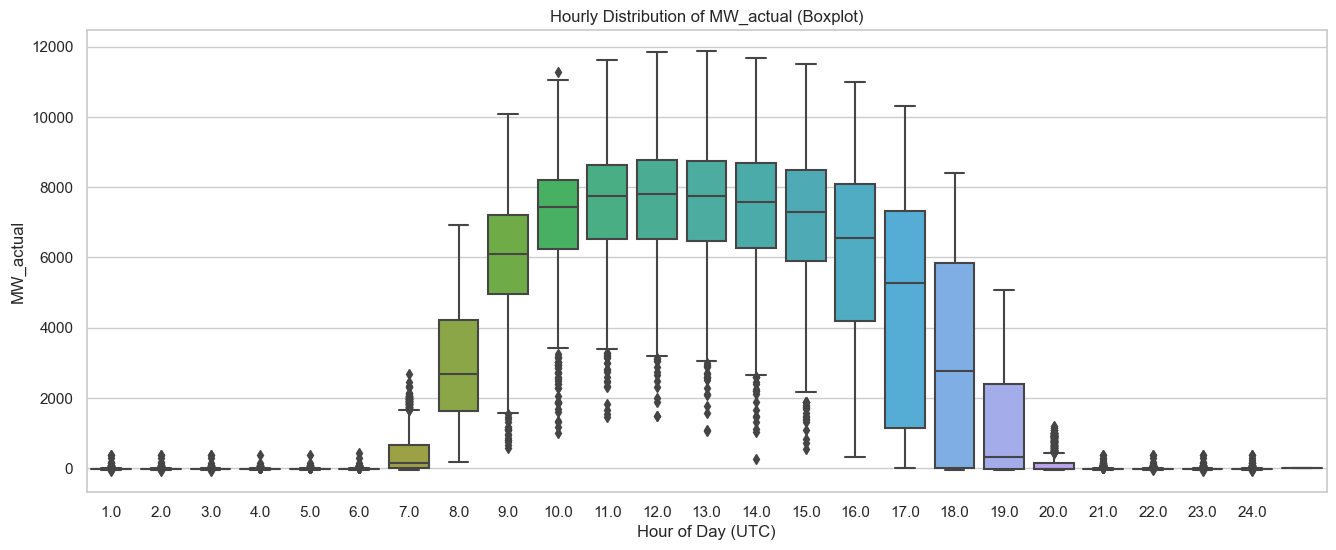

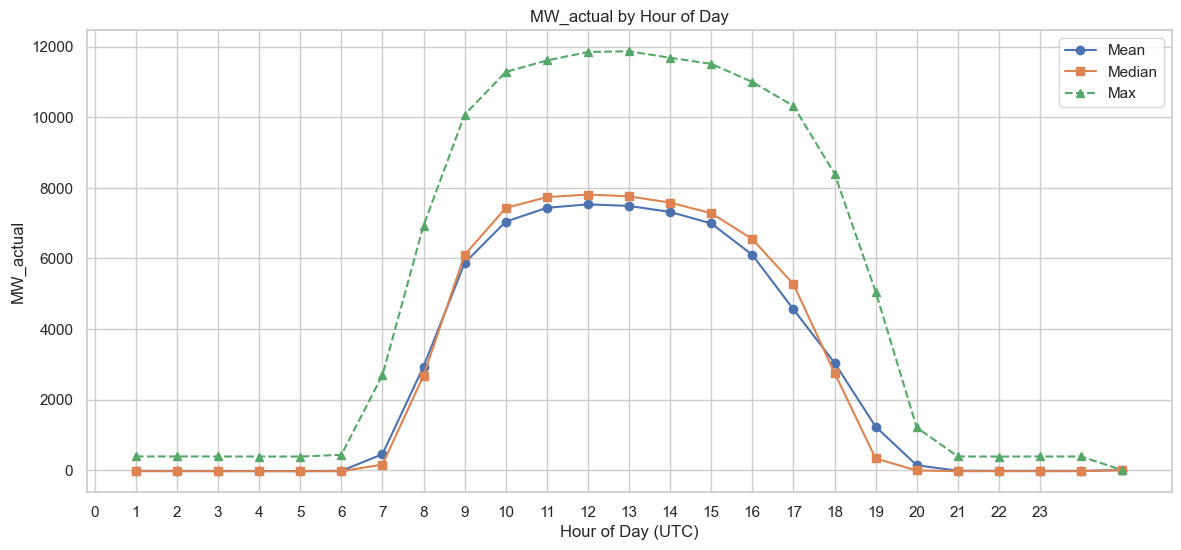

In [ ]:
# Style
sns.set(style="whitegrid")

# BOXPLOT: Distribution of MW_actual for each hour
plt.figure(figsize=(16, 6))
sns.boxplot(data=updated_actuals, x="OPR_HR", y="MW_actual", showfliers=True)
plt.title("Hourly Distribution of MW_actual (Boxplot)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("MW_actual")
plt.xticks(range(24))
plt.show()

# LINE PLOTS: Median, Mean, Max by Hour
hourly_stats = updated_actuals.groupby("OPR_HR")["MW_actual"].agg(["mean", "median", "max"]).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(hourly_stats["OPR_HR"], hourly_stats["mean"], label="Mean", marker="o")
plt.plot(hourly_stats["OPR_HR"], hourly_stats["median"], label="Median", marker="s")
plt.plot(hourly_stats["OPR_HR"], hourly_stats["max"], label="Max", marker="^", linestyle="--")
plt.title("MW_actual by Hour of Day")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("MW_actual")
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

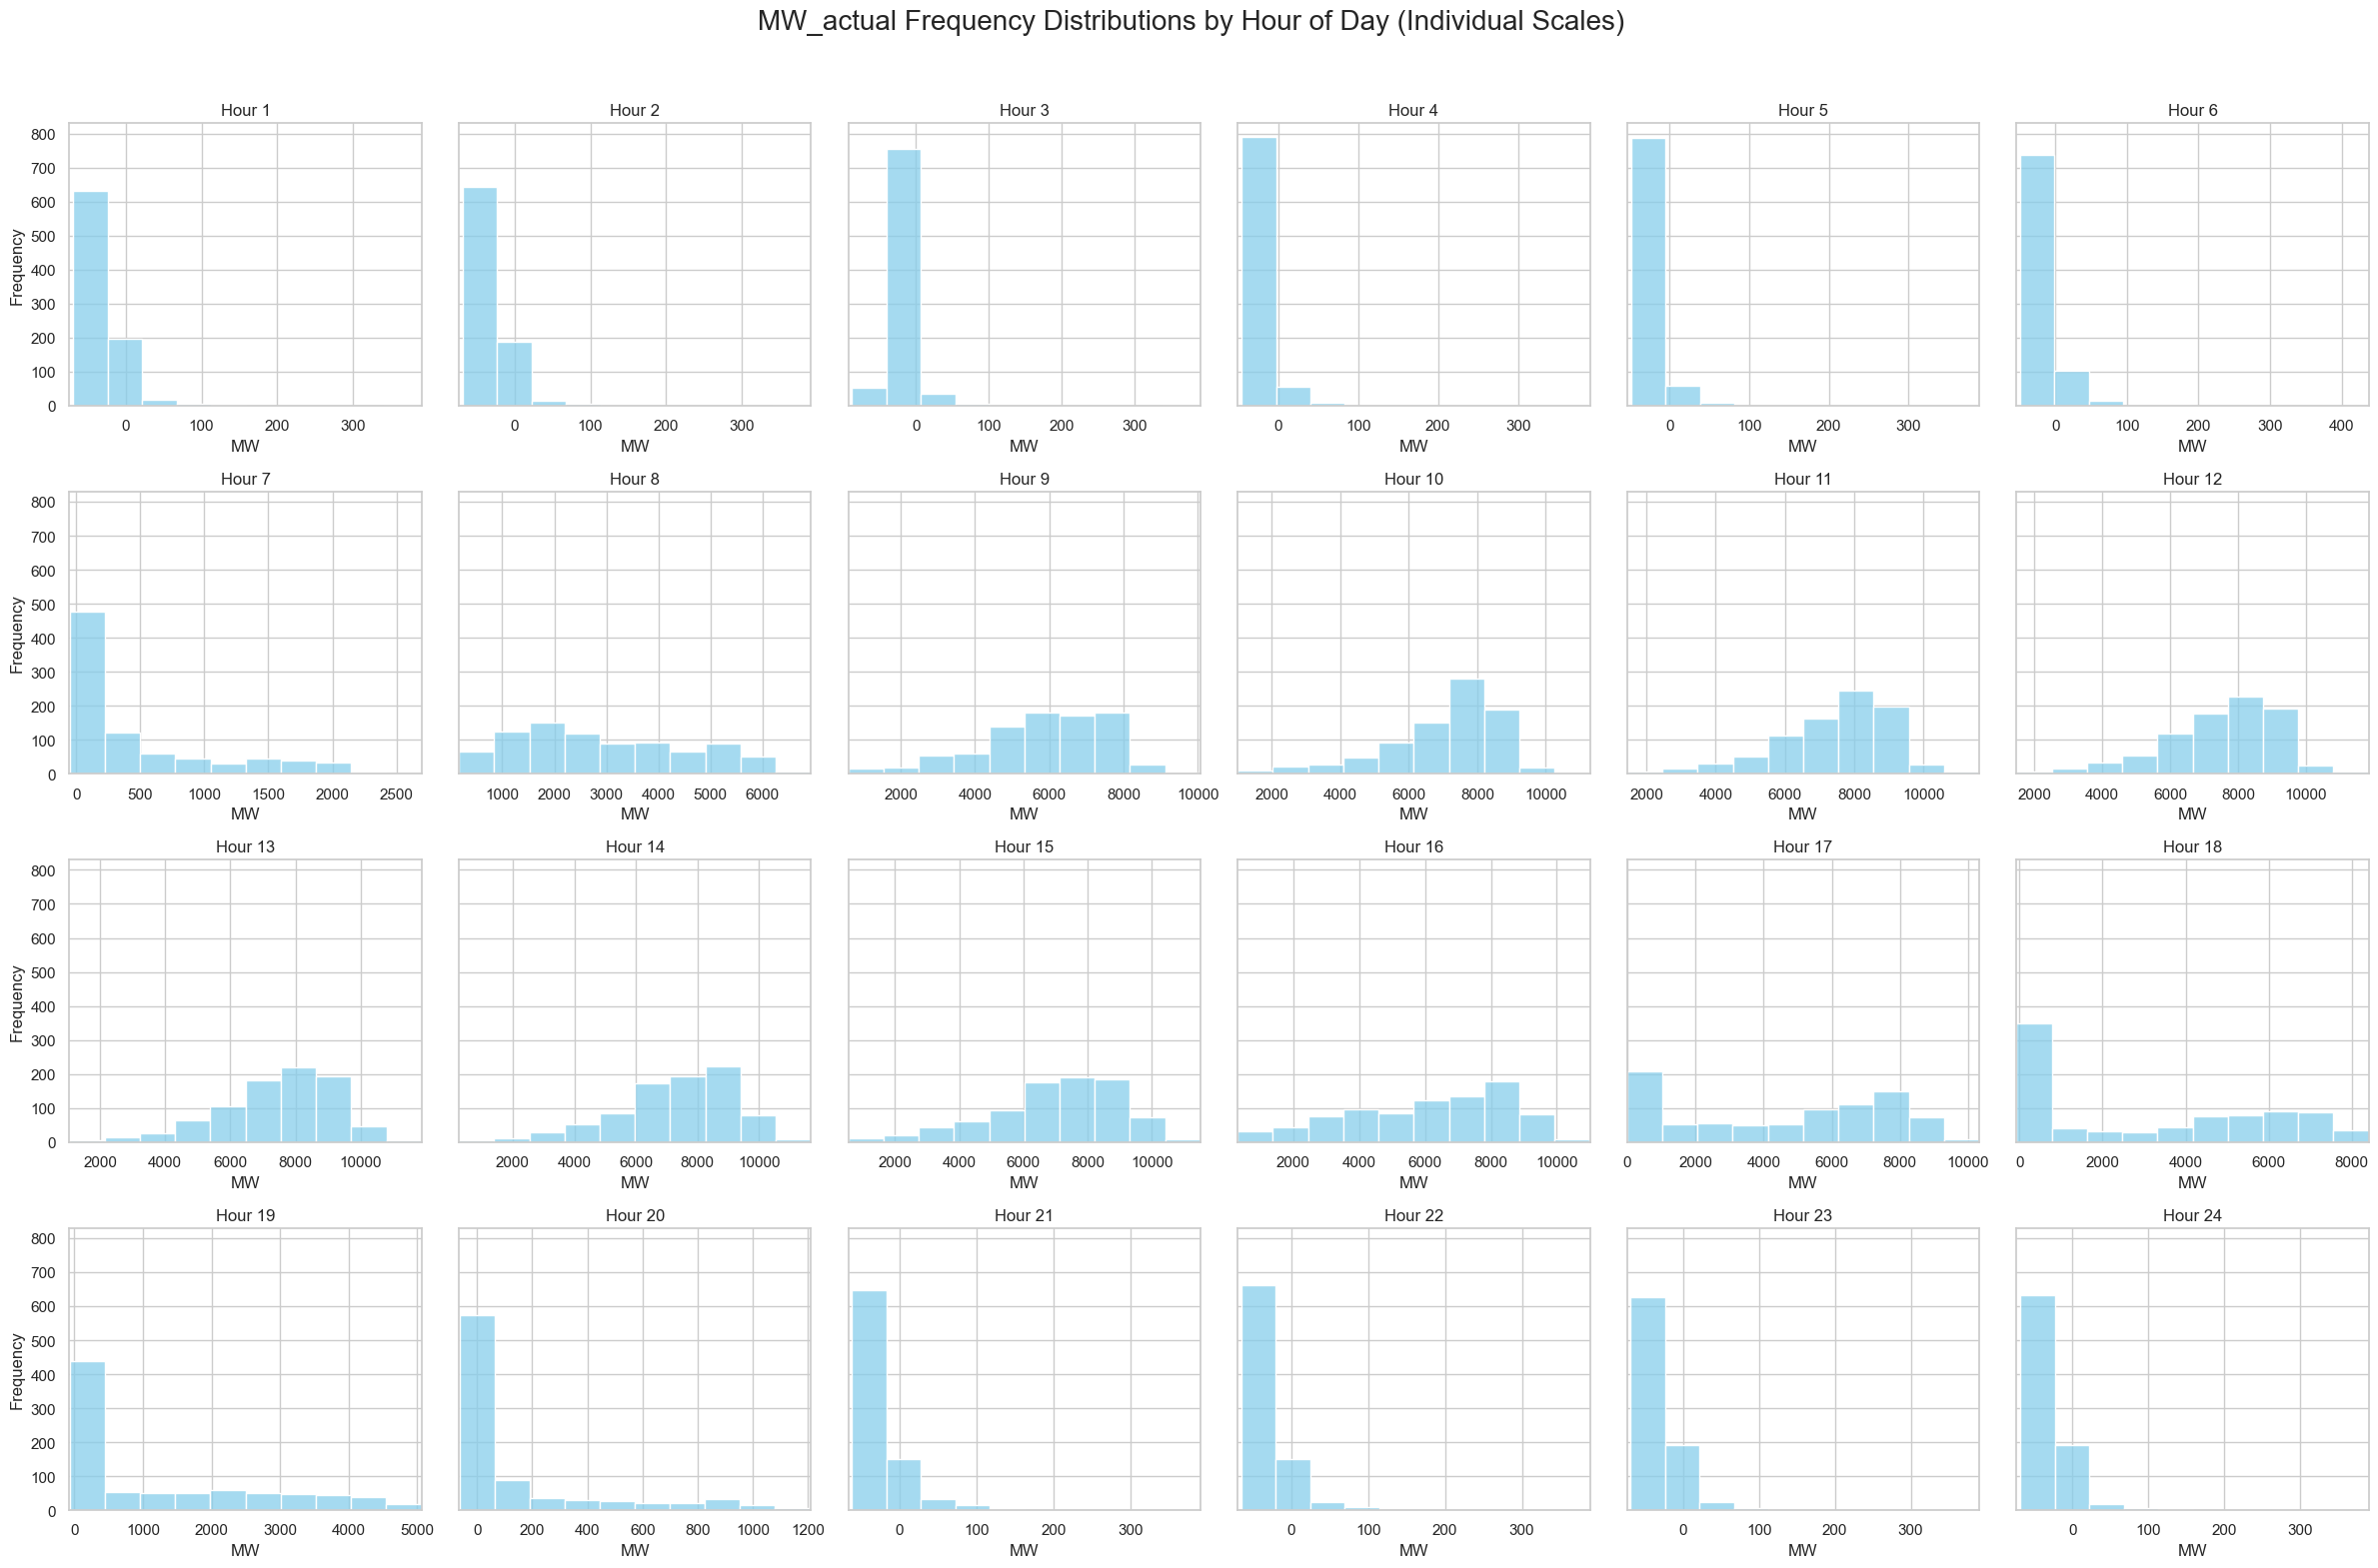

In [ ]:
# FREQUENCY DISTRIBUTIONS: Histogram per hour with individual x-axis limits
import matplotlib.pyplot as plt
import seaborn as sns

# Create 24 subplots (4 rows x 6 cols)
fig, axes = plt.subplots(4, 6, figsize=(24, 16), sharey=True)
axes = axes.flatten()

# Loop through each hour and plot histogram with individual x-limits
for hour in range(1, 25):  
    ax = axes[hour - 1]    
    subset = actuals[actuals["OPR_HR"] == hour]

    if not subset.empty:
        sns.histplot(subset["MW_actual"], bins=10, kde=False, ax=ax, color="skyblue")
        ax.set_title(f"Hour {hour}")
        ax.set_xlabel("MW")
        ax.set_ylabel("Frequency")

        # Set dynamic x-axis based on the distribution for that hour
        hour_min = subset["MW_actual"].min()
        hour_max = subset["MW_actual"].max()
        ax.set_xlim(hour_min - 5, hour_max + 5) 

fig.suptitle("MW_actual Frequency Distributions by Hour of Day (Individual Scales)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# Filter for the overnight hours
overnight_hours = [1, 2, 3, 4, 5, 22, 23, 24]
overnight_data = updated_actuals[updated_actuals['OPR_HR'].isin(overnight_hours)]

# Define target ranges ±10 MW
min_target = -30 #-88.23478
max_target =  386.38344
tolerance = 10

# Count values near the min
min_near_values = overnight_data[np.abs(overnight_data['MW_actual'] - min_target) <= tolerance]

# Count values near the max
max_near_values = overnight_data[np.abs(overnight_data['MW_actual'] - max_target) <= tolerance]

# Output the counts
print(f"Occurrences within ±10 MW of min value ({min_target:.2f}): {len(min_near_values)}")
print(f"Occurrences within ±10 MW of max value ({max_target:.2f}): {len(max_near_values)}")


Occurrences within ±10 MW of min value (-30.00): 4923
Occurrences within ±10 MW of max value (386.38): 14


Okay, here is what I am going to do for the weird non-zero overnight hours. I found that the earliest sunrise in California throughout the year is some time between 5am and 6am. The latest that the sun sets in California throughout the year is some time between 8pm and 9pm. I will manually zero all MW values between these times. I will also manually zero any/all negative MW values as we know that this isn't possible. Aside from knowing that these values can't be correct, the predicted overnight values indicate the same thing. The predicted values are overwhelmingly zero during these hours, with occassional small positive values for some hours. Important to note here is that OPR_HR is the PT equivalent to hour end.

In [ ]:
# Rename dataset
cleaned_actuals = updated_actuals.copy()

# Create a cleaned MW column starting from the original values
cleaned_actuals['MW_actual_cleaned'] = cleaned_actuals['MW_actual']

# Define overnight hours (hour ending)
overnight_hours = [1, 2, 3, 4, 5, 22, 23, 24]

cleaned_actuals.loc[cleaned_actuals['OPR_HR'].isin(overnight_hours), 'MW_actual_cleaned'] = 0
cleaned_actuals.loc[cleaned_actuals['MW_actual_cleaned'] < 0, 'MW_actual_cleaned'] = 0
cleaned_actuals.head()

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
0      NaN    NaN     NaN  NaN  2021-12-01     1.0           0.0   
1      NaN    NaN     NaN  NaN  2021-12-01     2.0           0.0   
2      NaN    NaN     NaN  NaN  2021-12-01     3.0           0.0   
3      NaN    NaN     NaN  NaN  2021-12-01     4.0           0.0   
4      NaN    NaN     NaN  NaN  2021-12-01     5.0           0.0   

  INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
0   2021-12-01 08:00:00  2021-12-01T09:00:00-00:00        SP15          Solar   
1   2021-12-01 09:00:00  2021-12-01T10:00:00-00:00        SP15          Solar   
2   2021-12-01 10:00:00  2021-12-01T11:00:00-00:00        SP15          Solar   
3   2021-12-01 11:00:00  2021-12-01T12:00:00-00:00        SP15          Solar   
4   2021-12-01 12:00:00  2021-12-01T13:00:00-00:00        SP15          Solar   

                                  LABEL      XML_DATA_ITEM  MARKET_RUN_ID_POS  \
0  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
1  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
2  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
3  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
4  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   

   RENEW_POS  MW_actual MARKET_RUN_ID  GROUP  MW  MW_actual_cleaned  
0        3.0    2.50251        ACTUAL    3.0 NaN                0.0  
1        3.0    1.58447        ACTUAL    3.0 NaN                0.0  
2        3.0    2.47010        ACTUAL    3.0 NaN                0.0  
3        3.0    2.27596        ACTUAL    3.0 NaN                0.0  
4        3.0    2.04619        ACTUAL    3.0 NaN                0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

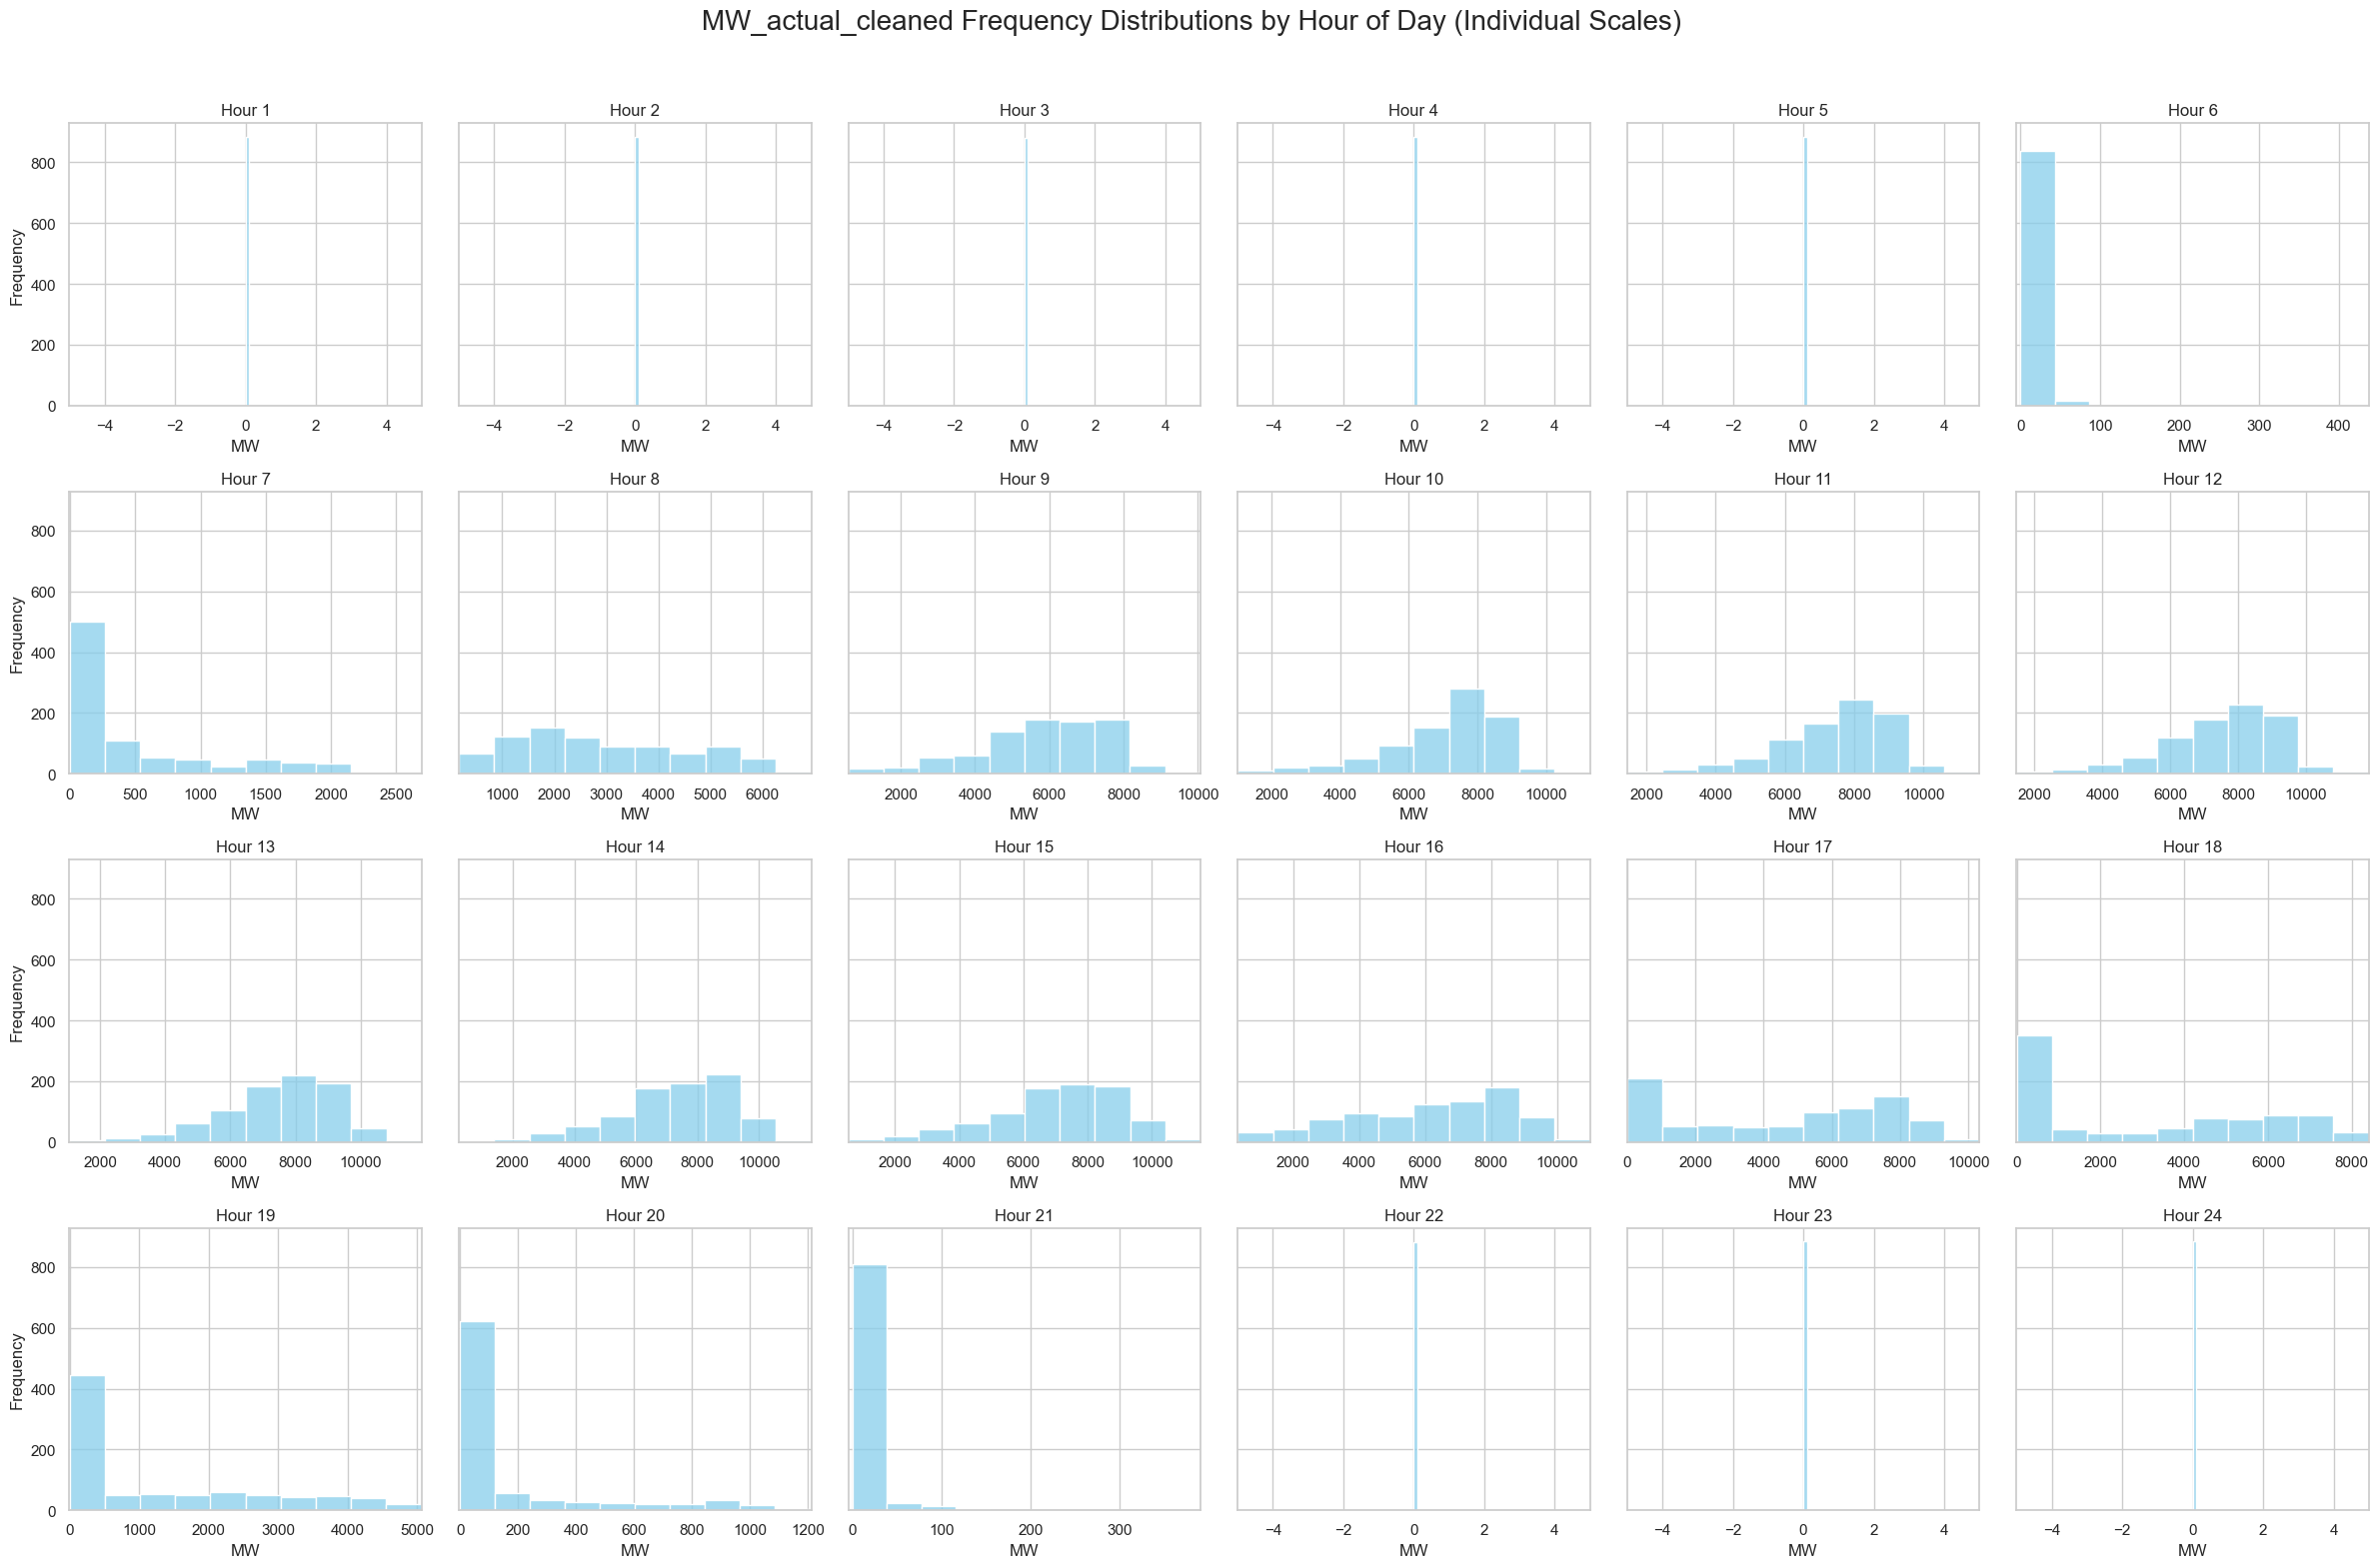

In [ ]:
# FREQUENCY DISTRIBUTIONS: Histogram per hour with individual x-axis limits
import matplotlib.pyplot as plt
import seaborn as sns

# Create 24 subplots
fig, axes = plt.subplots(4, 6, figsize=(24, 16), sharey=True)
axes = axes.flatten()

# Loop through each hour and plot histogram with individual x-limits
for hour in range(1, 25):  
    ax = axes[hour - 1]    
    subset = cleaned_actuals[cleaned_actuals["OPR_HR"] == hour]

    if not subset.empty:
        sns.histplot(subset["MW_actual_cleaned"], bins=10, kde=False, ax=ax, color="skyblue")
        ax.set_title(f"Hour {hour}")
        ax.set_xlabel("MW")
        ax.set_ylabel("Frequency")

        # Set dynamic x-axis based on the distribution for that hour
        hour_min = subset["MW_actual_cleaned"].min()
        hour_max = subset["MW_actual_cleaned"].max()
        ax.set_xlim(hour_min - 5, hour_max + 5)  

fig.suptitle("MW_actual_cleaned Frequency Distributions by Hour of Day (Individual Scales)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


This looks much better.

In [ ]:
# Let's save this on the drive
cleaned_actuals.to_csv("/Volumes/USB DISK/NewSP15/Actuals/CleanedActuals/cleanedactuals.csv", index=False)

In [ ]:
updated_actuals.tail(1285).head(10)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
19861      NaN    NaN     NaN  NaN  2024-03-11     7.0           0.0   
19862      NaN    NaN     NaN  NaN  2024-03-11     8.0           0.0   
19863      NaN    NaN     NaN  NaN  2024-03-11     9.0           0.0   
19864      NaN    NaN     NaN  NaN  2024-03-11    10.0           0.0   
19865      NaN    NaN     NaN  NaN  2024-03-11    11.0           0.0   
19866      NaN    NaN     NaN  NaN  2024-03-11    12.0           0.0   
19867      NaN    NaN     NaN  NaN  2024-03-11    13.0           0.0   
19868      NaN    NaN     NaN  NaN  2024-03-11    14.0           0.0   
19869      NaN    NaN     NaN  NaN  2024-03-11    15.0           0.0   
19870      NaN    NaN     NaN  NaN  2024-03-11    16.0           0.0   

      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
19861   2024-04-05 16:00:00  2024-03-11T14:00:00-00:00        SP15   
19862   2024-04-05 17:00:00  2024-03-11T15:00:00-00:00        SP15   
19863   2024-04-05 18:00:00  2024-03-11T16:00:00-00:00        SP15   
19864   2024-04-05 19:00:00  2024-03-11T17:00:00-00:00        SP15   
19865   2024-04-05 20:00:00  2024-03-11T18:00:00-00:00        SP15   
19866   2024-04-05 21:00:00  2024-03-11T19:00:00-00:00        SP15   
19867   2024-04-05 22:00:00  2024-03-11T20:00:00-00:00        SP15   
19868   2024-04-05 23:00:00  2024-03-11T21:00:00-00:00        SP15   
19869   2024-04-06 00:00:00  2024-03-11T22:00:00-00:00        SP15   
19870   2024-04-06 01:00:00  2024-03-11T23:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
19861          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19862          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19863          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19864          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19865          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19866          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19867          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19868          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19869          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19870          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

       MARKET_RUN_ID_POS  RENEW_POS   MW_actual MARKET_RUN_ID  GROUP  MW  
19861                3.0        3.0   -45.52994        ACTUAL   93.0 NaN  
19862                3.0        3.0  1270.74163        ACTUAL   93.0 NaN  
19863                3.0        3.0  5003.45344        ACTUAL   93.0 NaN  
19864                3.0        3.0  6617.42229        ACTUAL   93.0 NaN  
19865                3.0        3.0  7952.48635        ACTUAL   93.0 NaN  
19866                3.0        3.0  8028.50435        ACTUAL   93.0 NaN  
19867                3.0        3.0  8387.96227        ACTUAL   93.0 NaN  
19868                3.0        3.0  7916.39120        ACTUAL   93.0 NaN  
19869                3.0        3.0  7799.32837        ACTUAL   93.0 NaN  
19870                3.0        3.0  7505.64241        ACTUAL   93.0 NaN

In [ ]:
updated_actuals.tail(1315).head(10)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
19831      NaN    NaN     NaN  NaN  2024-03-09    24.0           0.0   
19832      NaN    NaN     NaN  NaN  2024-03-10     1.0           0.0   
19833      NaN    NaN     NaN  NaN  2024-03-10     2.0           0.0   
19834      NaN    NaN     NaN  NaN  2024-03-10     4.0           0.0   
19835      NaN    NaN     NaN  NaN  2024-03-10     5.0           0.0   
19836      NaN    NaN     NaN  NaN  2024-03-10     6.0           0.0   
19837      NaN    NaN     NaN  NaN  2024-03-10     7.0           0.0   
19838      NaN    NaN     NaN  NaN  2024-03-10     8.0           0.0   
19839      NaN    NaN     NaN  NaN  2024-03-10     9.0           0.0   
19840      NaN    NaN     NaN  NaN  2024-03-10    10.0           0.0   

      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
19831   2024-04-04 10:00:00  2024-03-10T08:00:00-00:00        SP15   
19832   2024-04-04 11:00:00  2024-03-10T09:00:00-00:00        SP15   
19833   2024-04-04 12:00:00  2024-03-10T10:00:00-00:00        SP15   
19834   2024-04-04 13:00:00  2024-03-10T11:00:00-00:00        SP15   
19835   2024-04-04 14:00:00  2024-03-10T12:00:00-00:00        SP15   
19836   2024-04-04 15:00:00  2024-03-10T13:00:00-00:00        SP15   
19837   2024-04-04 16:00:00  2024-03-10T14:00:00-00:00        SP15   
19838   2024-04-04 17:00:00  2024-03-10T15:00:00-00:00        SP15   
19839   2024-04-04 18:00:00  2024-03-10T16:00:00-00:00        SP15   
19840   2024-04-04 19:00:00  2024-03-10T17:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
19831          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19832          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19833          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19834          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19835          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19836          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19837          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19838          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19839          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
19840          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

       MARKET_RUN_ID_POS  RENEW_POS   MW_actual MARKET_RUN_ID  GROUP  MW  
19831                3.0        3.0   -43.44126        ACTUAL   81.0 NaN  
19832                3.0        3.0   -43.33919        ACTUAL   87.0 NaN  
19833                3.0        3.0   -43.57373        ACTUAL   87.0 NaN  
19834                3.0        3.0   -44.65208        ACTUAL   87.0 NaN  
19835                3.0        3.0   -48.45344        ACTUAL   87.0 NaN  
19836                3.0        3.0   -45.39719        ACTUAL   87.0 NaN  
19837                3.0        3.0   -43.72290        ACTUAL   87.0 NaN  
19838                3.0        3.0  1184.75320        ACTUAL   87.0 NaN  
19839                3.0        3.0  4998.05984        ACTUAL   87.0 NaN  
19840                3.0        3.0  6624.04028        ACTUAL   87.0 NaN

Nice. OPR_HR successfully catches time change as well which happens in the above data. Don't forget OPR_HR corresponds to end hour!

In [ ]:
updated_actuals.tail(18010).head(10)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
3184       NaN    NaN     NaN  NaN  2022-04-13    18.0           0.0   
3185       NaN    NaN     NaN  NaN  2022-04-13    19.0           0.0   
3186       NaN    NaN     NaN  NaN  2022-04-13    20.0           0.0   
3187       NaN    NaN     NaN  NaN  2022-04-13    21.0           0.0   
3188       NaN    NaN     NaN  NaN  2022-04-13    22.0           0.0   
3189       NaN    NaN     NaN  NaN  2022-04-13    23.0           0.0   
3190       NaN    NaN     NaN  NaN  2022-04-13    24.0           0.0   
21146      NaN    NaN     NaN  NaN  2022-04-14     1.0           0.0   
21147      NaN    NaN     NaN  NaN  2022-04-14     2.0           0.0   
21148      NaN    NaN     NaN  NaN  2022-04-14     3.0           0.0   

      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
3184    2022-04-18 00:00:00  2022-04-14T01:00:00-00:00        SP15   
3185    2022-04-18 01:00:00  2022-04-14T02:00:00-00:00        SP15   
3186    2022-04-18 02:00:00  2022-04-14T03:00:00-00:00        SP15   
3187    2022-04-18 03:00:00  2022-04-14T04:00:00-00:00        SP15   
3188    2022-04-18 04:00:00  2022-04-14T05:00:00-00:00        SP15   
3189    2022-04-18 05:00:00  2022-04-14T06:00:00-00:00        SP15   
3190    2022-04-18 06:00:00  2022-04-14T07:00:00-00:00        SP15   
21146                   NaT  2022-04-14T08:00:00-00:00        SP15   
21147                   NaT  2022-04-14T09:00:00-00:00        SP15   
21148                   NaT  2022-04-14T10:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
3184           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3185           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3186           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3187           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3188           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3189           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3190           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21146          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21147          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21148          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

       MARKET_RUN_ID_POS  RENEW_POS   MW_actual MARKET_RUN_ID  GROUP  MW  
3184                 3.0        3.0  5431.00125        ACTUAL  148.0 NaN  
3185                 3.0        3.0  1953.47635        ACTUAL  148.0 NaN  
3186                 3.0        3.0   114.64916        ACTUAL  148.0 NaN  
3187                 3.0        3.0     8.44803        ACTUAL  148.0 NaN  
3188                 3.0        3.0   -21.73598        ACTUAL  148.0 NaN  
3189                 3.0        3.0   -20.50016        ACTUAL  148.0 NaN  
3190                 3.0        3.0   -20.76777        ACTUAL  148.0 NaN  
21146                3.0        3.0   -21.02660        ACTUAL    8.0 NaN  
21147                3.0        3.0   -20.12244        ACTUAL    8.0 NaN  
21148                3.0        3.0   -21.04716        ACTUAL    8.0 NaN

In [ ]:
updated_actuals.tail(17985).head(15)

TimeDate Source Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
21164      NaN    NaN     NaN  NaN  2022-04-14    19.0           0.0   
21165      NaN    NaN     NaN  NaN  2022-04-14    20.0           0.0   
21166      NaN    NaN     NaN  NaN  2022-04-14    21.0           0.0   
21167      NaN    NaN     NaN  NaN  2022-04-14    22.0           0.0   
21168      NaN    NaN     NaN  NaN  2022-04-14    23.0           0.0   
21169      NaN    NaN     NaN  NaN  2022-04-14    24.0           0.0   
3191       NaN    NaN     NaN  NaN  2022-04-15     1.0           0.0   
3192       NaN    NaN     NaN  NaN  2022-04-15     2.0           0.0   
3193       NaN    NaN     NaN  NaN  2022-04-15     3.0           0.0   
3194       NaN    NaN     NaN  NaN  2022-04-15     4.0           0.0   
3195       NaN    NaN     NaN  NaN  2022-04-15     5.0           0.0   
3196       NaN    NaN     NaN  NaN  2022-04-15     6.0           0.0   
3197       NaN    NaN     NaN  NaN  2022-04-15     7.0           0.0   
3198       NaN    NaN     NaN  NaN  2022-04-15     8.0           0.0   
3199       NaN    NaN     NaN  NaN  2022-04-15     9.0           0.0   

      INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB  \
21164                   NaT  2022-04-15T02:00:00-00:00        SP15   
21165                   NaT  2022-04-15T03:00:00-00:00        SP15   
21166                   NaT  2022-04-15T04:00:00-00:00        SP15   
21167                   NaT  2022-04-15T05:00:00-00:00        SP15   
21168                   NaT  2022-04-15T06:00:00-00:00        SP15   
21169                   NaT  2022-04-15T07:00:00-00:00        SP15   
3191    2022-04-18 07:00:00  2022-04-15T08:00:00-00:00        SP15   
3192    2022-04-18 08:00:00  2022-04-15T09:00:00-00:00        SP15   
3193    2022-04-18 09:00:00  2022-04-15T10:00:00-00:00        SP15   
3194    2022-04-18 10:00:00  2022-04-15T11:00:00-00:00        SP15   
3195    2022-04-18 11:00:00  2022-04-15T12:00:00-00:00        SP15   
3196    2022-04-18 12:00:00  2022-04-15T13:00:00-00:00        SP15   
3197    2022-04-18 13:00:00  2022-04-15T14:00:00-00:00        SP15   
3198    2022-04-18 14:00:00  2022-04-15T15:00:00-00:00        SP15   
3199    2022-04-18 15:00:00  2022-04-15T16:00:00-00:00        SP15   

      RENEWABLE_TYPE                                 LABEL      XML_DATA_ITEM  \
21164          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21165          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21166          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21167          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21168          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
21169          Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3191           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3192           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3193           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3194           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3195           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3196           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3197           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3198           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   
3199           Solar  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW   

       MARKET_RUN_ID_POS  RENEW_POS   MW_actual MARKET_RUN_ID  GROUP  MW  
21164                3.0        3.0  1964.24173        ACTUAL    8.0 NaN  
21165                3.0        3.0   122.30667        ACTUAL    8.0 NaN  
21166                3.0        3.0    11.61815        ACTUAL    8.0 NaN  
21167                3.0        3.0   -23.28255        ACTUAL    8.0 NaN  
21168                3.0        3.0   -21.96171        ACTUA

It looks like because of how we handled our merge, we see "na" values for values where we merged from smaller/different API pulls, and everything that we added on to this was inserted, and pushed INTERVALSTARTTIME values further down so they aren't aligned properly.

Okay, I just confirmed my suspicion between the API dashboard (that numbers are accurate for MW values relative to INTERVALENDTIME_GMT variable as well as both OPR_DT and OPR_HR variables) and the updated_actuals dataset both before, after, and during merging times from when we filled in gaps. This just means we will have to merge on one of the correct options when building the full dataframe, and NOT INTERVALSTARTTIME_GMT.

#### Let's look at our predicted values.

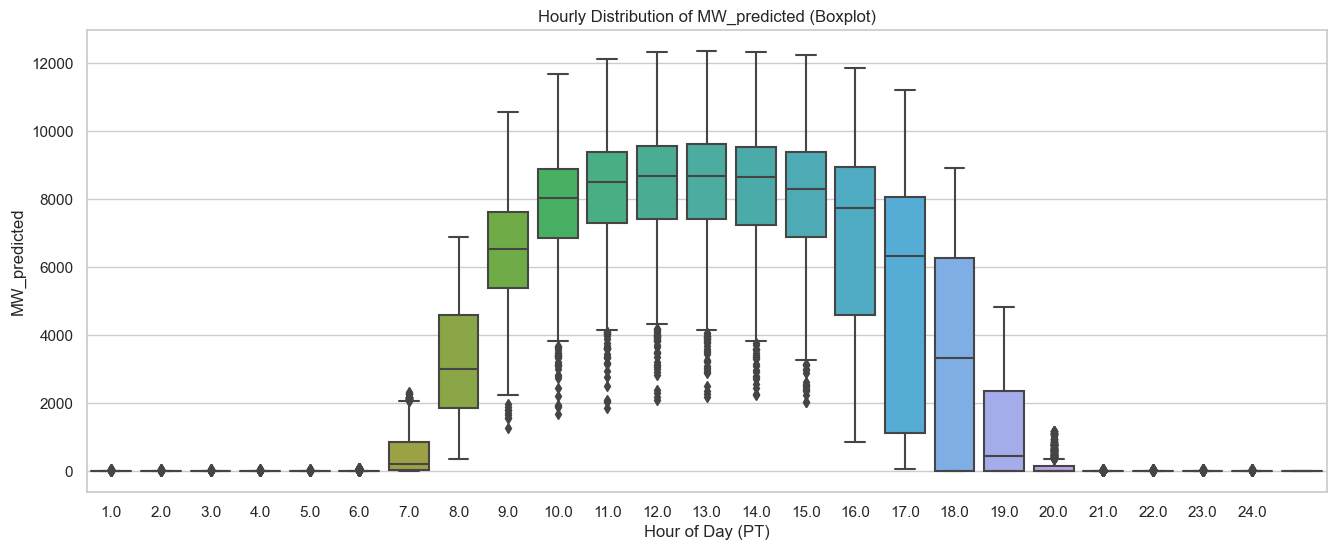

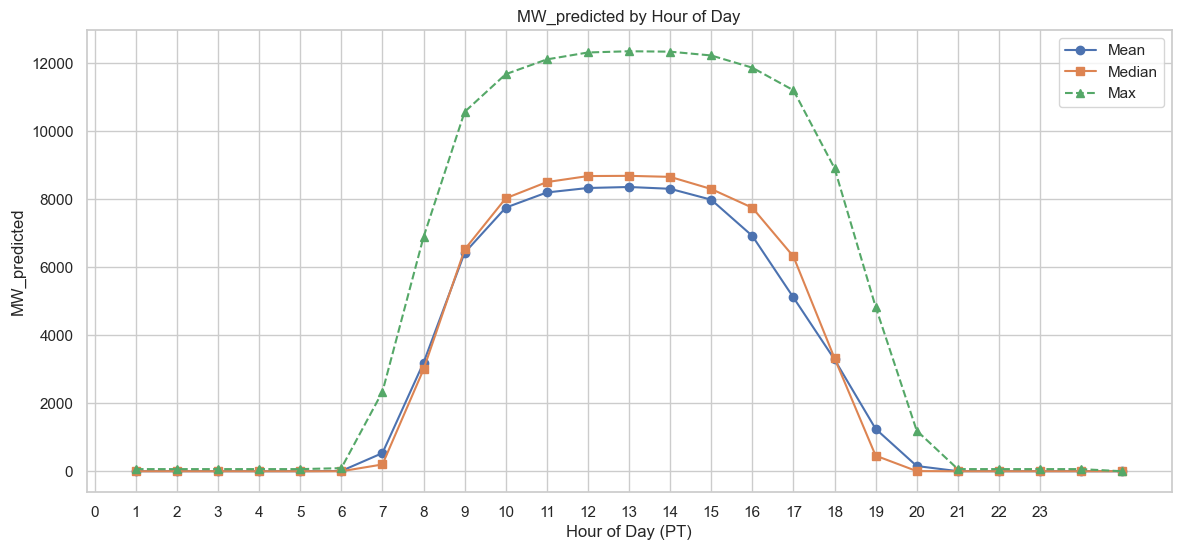

In [ ]:
# Style
sns.set(style="whitegrid")

# BOXPLOT: Distribution of MW_actual for each hour
plt.figure(figsize=(16, 6))
sns.boxplot(data=updated_pred, x="OPR_HR", y="MW_predicted", showfliers=True)
plt.title("Hourly Distribution of MW_predicted (Boxplot)")
plt.xlabel("Hour of Day (PT)")
plt.ylabel("MW_predicted")
plt.xticks(range(24))
plt.show()

# LINE PLOTS: Median, Mean, Max by Hour
hourly_stats = updated_pred.groupby("OPR_HR")["MW_predicted"].agg(["mean", "median", "max"]).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(hourly_stats["OPR_HR"], hourly_stats["mean"], label="Mean", marker="o")
plt.plot(hourly_stats["OPR_HR"], hourly_stats["median"], label="Median", marker="s")
plt.plot(hourly_stats["OPR_HR"], hourly_stats["max"], label="Max", marker="^", linestyle="--")
plt.title("MW_predicted by Hour of Day")
plt.xlabel("Hour of Day (PT)")
plt.ylabel("MW_predicted")
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

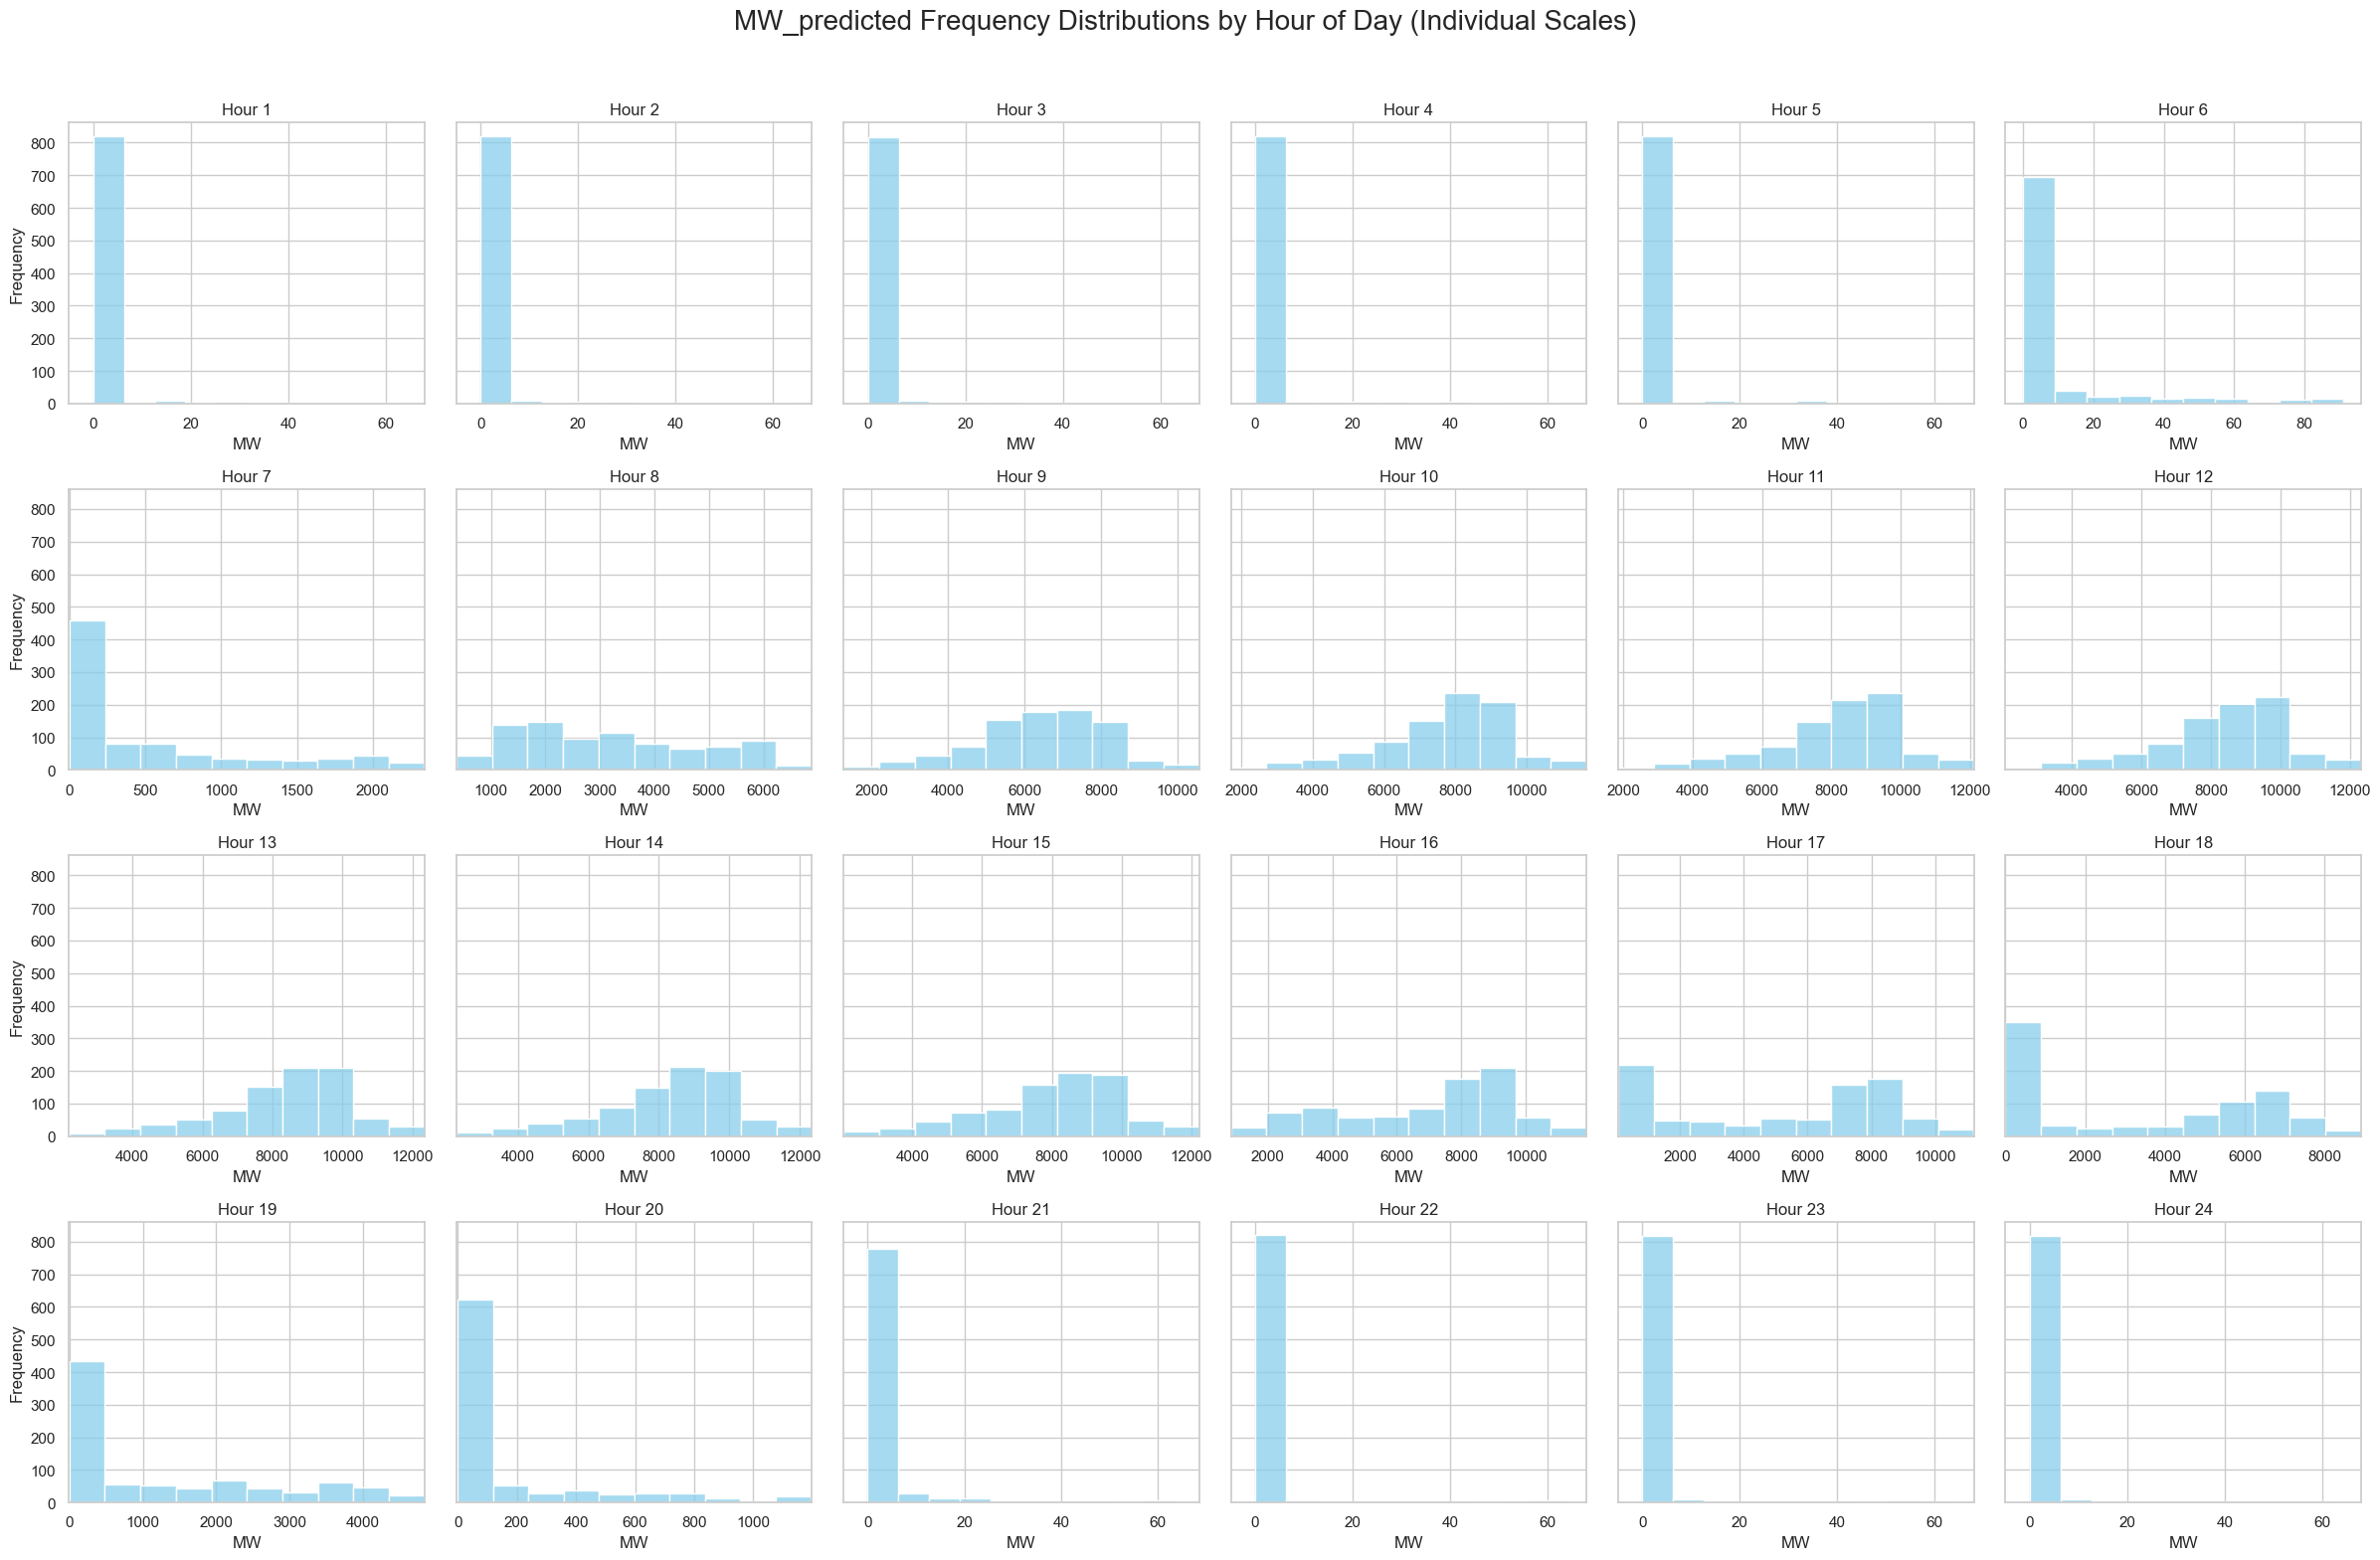

In [ ]:
# FREQUENCY DISTRIBUTIONS: Histogram per hour with individual x-axis limits
import matplotlib.pyplot as plt
import seaborn as sns

# Create 24 subplots
fig, axes = plt.subplots(4, 6, figsize=(24, 16), sharey=True)
axes = axes.flatten()

# Loop through each hour and plot histogram with individual x-limits
for hour in range(1, 25):  
    ax = axes[hour - 1]    
    subset = updated_pred[updated_pred["OPR_HR"] == hour]

    if not subset.empty:
        sns.histplot(subset["MW_predicted"], bins=10, kde=False, ax=ax, color="skyblue")
        ax.set_title(f"Hour {hour}")
        ax.set_xlabel("MW")
        ax.set_ylabel("Frequency")

        # Set dynamic x-axis based on the distribution for that hour
        hour_min = subset["MW_predicted"].min()
        hour_max = subset["MW_predicted"].max()
        ax.set_xlim(hour_min - 5, hour_max + 5)  

fig.suptitle("MW_predicted Frequency Distributions by Hour of Day (Individual Scales)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [84]:
updated_pred.head(990).tail()

OPR_DT  OPR_HR  OPR_INTERVAL INTERVALSTARTTIME_GMT  \
985  2022-01-12     2.0           0.0   2022-01-12 09:00:00   
986  2022-01-12     3.0           0.0   2022-01-12 10:00:00   
987  2022-01-12     4.0           0.0   2022-01-12 11:00:00   
988  2022-01-12     5.0           0.0   2022-01-12 12:00:00   
989  2022-01-12     6.0           0.0   2022-01-12 13:00:00   

           INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
985  2022-01-12T10:00:00-00:00        SP15          Solar   
986  2022-01-12T11:00:00-00:00        SP15          Solar   
987  2022-01-12T12:00:00-00:00        SP15          Solar   
988  2022-01-12T13:00:00-00:00        SP15          Solar   
989  2022-01-12T14:00:00-00:00        SP15          Solar   

                            LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  \
985  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0   
986  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0   
987  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0   
988  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0   
989  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0   

     RENEW_POS  MW_predicted MARKET_RUN_ID  GROUP  TimeDate  Source  Version  \
985        2.0           0.0           DAM   63.0       NaN     NaN      NaN   
986        2.0           0.0           DAM   63.0       NaN     NaN      NaN   
987        2.0           0.0           DAM   63.0       NaN     NaN      NaN   
988        2.0           0.0           DAM   63.0       NaN     NaN      NaN   
989        2.0           0.0           DAM   63.0       NaN     NaN      NaN   

     RTO  MW  
985  NaN NaN  
986  NaN NaN  
987  NaN NaN  
988  NaN NaN  
989  NaN NaN

In [87]:
# Let's look at this for the actual values

# Filter for the relevant hours (1 AM to 5 AM and 10 PM to 12 AM)
overnight_hours = [0, 1, 2, 3, 4, 21, 22, 23]

# Get the min and max values of MW_actual for these periods
min_max_overnight_values = updated_pred.loc[updated_pred['OPR_HR'].isin(overnight_hours), 'MW_predicted'].agg(['min', 'max'])

print(min_max_overnight_values)


min     0.00
max    63.58
Name: MW_predicted, dtype: float64


In [ ]:
# Filter rows where 'MW_predicted' is equal to 63.0
filtered_data = updated_pred[updated_pred['MW_predicted'] == 63.0]

# Take a look
print(filtered_data)

           OPR_DT  OPR_HR  OPR_INTERVAL INTERVALSTARTTIME_GMT  \
15812  2023-09-21    22.0           0.0   2023-09-22 04:00:00   
15813  2023-09-21    23.0           0.0   2023-09-22 05:00:00   
15814  2023-09-21    24.0           0.0   2023-09-22 06:00:00   
16243  2023-10-09    21.0           0.0   2023-10-10 03:00:00   
16244  2023-10-09    22.0           0.0   2023-10-10 04:00:00   
16245  2023-10-09    23.0           0.0   2023-10-10 05:00:00   
16246  2023-10-09    24.0           0.0   2023-10-10 06:00:00   
16266  2023-10-10    20.0           0.0   2023-10-11 02:00:00   
16267  2023-10-10    21.0           0.0   2023-10-11 03:00:00   
16268  2023-10-10    22.0           0.0   2023-10-11 04:00:00   
16269  2023-10-10    23.0           0.0   2023-10-11 05:00:00   
16271  2023-10-11     1.0           0.0   2023-10-11 07:00:00   
16272  2023-10-11     2.0           0.0   2023-10-11 08:00:00   
16273  2023-10-11     3.0           0.0   2023-10-11 09:00:00   
16274  2023-10-11     4.0

There is definitely less of an issue here, but there are still a handful of times overnight that have non-zero values. We will not impute these as they are the predictions that we are trying to beat. NOTE: I made the decision to impute overnight predicted MW values in earlier analysis, but don't think it is the best decision for the final product. However, I will need to rename the dataset and MW value to use this same code.

In [88]:
# Rename the dataset
cleaned_pred = updated_pred.copy()

# Rename the column
cleaned_pred = cleaned_pred.rename(columns={'MW_predicted': 'MW_pred_cleaned'})

Let's merge the actual's and predicteds dataset on INTERVALENDTIME_GMT. We will join on the predicted dataset, which has the correct INTERVALSTARTTIME_GMT variable, so we will maintain that structure.

In [91]:
cleaned_actuals.head()

TimeDate  Source  Version  RTO      OPR_DT  OPR_HR  OPR_INTERVAL  \
0       NaN     NaN      NaN  NaN  2021-12-01     1.0           0.0   
1       NaN     NaN      NaN  NaN  2021-12-01     2.0           0.0   
2       NaN     NaN      NaN  NaN  2021-12-01     3.0           0.0   
3       NaN     NaN      NaN  NaN  2021-12-01     4.0           0.0   
4       NaN     NaN      NaN  NaN  2021-12-01     5.0           0.0   

  INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
0   2021-12-01 08:00:00  2021-12-01T09:00:00-00:00        SP15          Solar   
1   2021-12-01 09:00:00  2021-12-01T10:00:00-00:00        SP15          Solar   
2   2021-12-01 10:00:00  2021-12-01T11:00:00-00:00        SP15          Solar   
3   2021-12-01 11:00:00  2021-12-01T12:00:00-00:00        SP15          Solar   
4   2021-12-01 12:00:00  2021-12-01T13:00:00-00:00        SP15          Solar   

                                  LABEL      XML_DATA_ITEM  MARKET_RUN_ID_POS  \
0  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
1  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
2  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
3  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   
4  Renewable Forecast Actual Generation  RENEW_FCST_ACT_MW                3.0   

   RENEW_POS  MW_actual MARKET_RUN_ID  GROUP  MW  MW_actual_cleaned  
0        3.0    2.50251        ACTUAL    3.0 NaN                0.0  
1        3.0    1.58447        ACTUAL    3.0 NaN                0.0  
2        3.0    2.47010        ACTUAL    3.0 NaN                0.0  
3        3.0    2.27596        ACTUAL    3.0 NaN                0.0  
4        3.0    2.04619        ACTUAL    3.0 NaN                0.0

In [ ]:
cleaned_actuals['INTERVALENDTIME_GMT'] = pd.to_datetime(cleaned_actuals['INTERVALENDTIME_GMT'])
cleaned_pred['INTERVALENDTIME_GMT'] = pd.to_datetime(cleaned_pred['INTERVALENDTIME_GMT'])

# Merge datasets on INTERVALENDTIME_GMT
merged_MW = pd.merge(
    cleaned_pred,
    cleaned_actuals[['INTERVALENDTIME_GMT', 'MW_actual_cleaned', 'MW_actual']],
    on='INTERVALENDTIME_GMT',
    how='left'  # use left join to keep all rows from predictions
)

# Check if merge went well
print(f"Resulting dataset has {len(merged_MW)} rows.")
merged_MW[['INTERVALENDTIME_GMT', 'MW_actual_cleaned']].tail()


Resulting dataset has 21215 rows.


INTERVALENDTIME_GMT  MW_actual_cleaned
21210 2024-05-04 03:00:00+00:00          198.53636
21211 2024-05-04 04:00:00+00:00            0.00000
21212 2024-05-04 05:00:00+00:00            0.00000
21213 2024-05-04 06:00:00+00:00            0.00000
21214 2024-05-04 07:00:00+00:00            0.00000

In [95]:
len(cleaned_pred)

21215

In [96]:
merged_MW.head()

OPR_DT  OPR_HR  OPR_INTERVAL INTERVALSTARTTIME_GMT  \
0  2021-12-01     1.0           0.0   2021-12-01 08:00:00   
1  2021-12-01     2.0           0.0   2021-12-01 09:00:00   
2  2021-12-01     3.0           0.0   2021-12-01 10:00:00   
3  2021-12-01     4.0           0.0   2021-12-01 11:00:00   
4  2021-12-01     5.0           0.0   2021-12-01 12:00:00   

        INTERVALENDTIME_GMT TRADING_HUB RENEWABLE_TYPE  \
0 2021-12-01 09:00:00+00:00        SP15          Solar   
1 2021-12-01 10:00:00+00:00        SP15          Solar   
2 2021-12-01 11:00:00+00:00        SP15          Solar   
3 2021-12-01 12:00:00+00:00        SP15          Solar   
4 2021-12-01 13:00:00+00:00        SP15          Solar   

                          LABEL     XML_DATA_ITEM  MARKET_RUN_ID_POS  ...  \
0  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0  ...   
1  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0  ...   
2  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0  ...   
3  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0  ...   
4  Renewable Forecast Day Ahead  RENEW_FCST_DA_MW                1.0  ...   

   MW_pred_cleaned  MARKET_RUN_ID GROUP  TimeDate  Source  Version  RTO  MW  \
0              0.0            DAM   3.0       NaN     NaN      NaN  NaN NaN   
1              0.0            DAM   3.0       NaN     NaN      NaN  NaN NaN   
2              0.0            DAM   3.0       NaN     NaN      NaN  NaN NaN   
3              0.0            DAM   3.0       NaN     NaN      NaN  NaN NaN   
4              0.0            DAM   3.0       NaN     NaN      NaN  NaN NaN   

   MW_actual_cleaned  MW_actual  
0                0.0    2.50251  
1                0.0    1.58447  
2                0.0    2.47010  
3                0.0    2.27596  
4                0.0    2.04619  

[5 rows x 21 columns]

In [ ]:
# Let's save this on the drive
merged_MW.to_csv("/Volumes/USB DISK/NewSP15/MergedMW/merged_MW.csv", index=False)

In [ ]:
# Assume INTERVALSTARTTIME_GMT is GMT and needs to be converted to UTC
merged_MW['INTERVALSTARTTIME_GMT'] = pd.to_datetime(merged_MW['INTERVALSTARTTIME_GMT'], utc=True)
merged_MW['INTERVALSTARTTIME_GMT'] = merged_MW['INTERVALSTARTTIME_GMT'].dt.tz_convert('UTC').dt.tz_localize(None)

working_checkpoint['valid_time'] = pd.to_datetime(working_checkpoint['valid_time'])  # Already UTC naive

# Select only columns I want
cols_to_merge = [
    'INTERVALSTARTTIME_GMT', 'MW_actual_cleaned', 'MW_pred_cleaned',
    'OPR_DT', 'OPR_HR', 'INTERVALENDTIME_GMT',
    'TRADING_HUB', 'RENEWABLE_TYPE', 'LABEL', 'XML_DATA_ITEM'
]
merged_subset = merged_MW[cols_to_merge].copy()

# Rename columns
merged_subset = merged_subset.rename(columns={
    col: f"{col}_CAISO" for col in cols_to_merge if col != 'INTERVALSTARTTIME_GMT'
})

# Merge!
final_merged = pd.merge(
    working_checkpoint,
    merged_subset,
    left_on='valid_time',
    right_on='INTERVALSTARTTIME_GMT',
    how='left'
)

# Confirm
print(f"Merged dataset shape: {final_merged.shape}")
final_merged.head()


Merged dataset shape: (89765, 79)


Unnamed: 0            step  point                 time  surface   latitude  \
0     46935.0 0 days 19:00:00   4239  2020-12-05 12:00:00      0.0  33.208817   
1     48777.0 0 days 19:00:00   6081  2020-12-05 12:00:00      0.0  34.818891   
2     47696.0 0 days 19:00:00   5000  2020-12-05 12:00:00      0.0  34.870602   
3     61167.0 0 days 20:00:00   4239  2020-12-05 12:00:00      0.0  33.208817   
4     61928.0 0 days 20:00:00   5000  2020-12-05 12:00:00      0.0  34.870602   

    longitude          valid_time                            metpy_crs  \
0  244.723222 2020-12-06 07:00:00  Projection: lambert_conformal_conic   
1  241.688987 2020-12-06 07:00:00  Projection: lambert_conformal_conic   
2  243.187135 2020-12-06 07:00:00  Projection: lambert_conformal_conic   
3  244.723222 2020-12-06 08:00:00  Projection: lambert_conformal_conic   
4  243.187135 2020-12-06 08:00:00  Projection: lambert_conformal_conic   

   unknown  ...  INTERVALSTARTTIME_GMT  MW_actual_cleaned_CAISO  \
0      0.0  ...                    NaT                      NaN   
1      0.0  ...                    NaT                      NaN   
2      0.0  ...                    NaT                      NaN   
3      0.0  ...                    NaT                      NaN   
4      0.0  ...                    NaT                      NaN   

   MW_pred_cleaned_CAISO  OPR_DT_CAISO  OPR_HR_CAISO  \
0                    NaN           NaN           NaN   
1                    NaN           NaN           NaN   
2                    NaN           NaN           NaN   
3                    NaN           NaN           NaN   
4                    NaN           NaN           NaN   

   INTERVALENDTIME_GMT_CAISO  TRADING_HUB_CAISO  RENEWABLE_TYPE_CAISO  \
0                        NaT                NaN                   NaN   
1                        NaT                NaN                   NaN   
2                        NaT                NaN                   NaN   
3                        NaT                NaN                   NaN   
4                        NaT                NaN                   NaN   

   LABEL_CAISO  XML_DATA_ITEM_CAISO  
0          NaN                  NaN  
1          NaN                  NaN  
2          NaN                  NaN  
3          NaN                  NaN  
4          NaN                  NaN  

[5 rows x 79 columns]

In [98]:
final_merged.head(30000).tail()

Unnamed: 0            step  point                 time  surface  \
29995         NaN 1 days 17:00:00   6081  2022-01-25 12:00:00      0.0   
29996         NaN 1 days 18:00:00   5000  2022-01-25 12:00:00      0.0   
29997         NaN 1 days 18:00:00   6081  2022-01-25 12:00:00      0.0   
29998         NaN 1 days 18:00:00   4239  2022-01-25 12:00:00      0.0   
29999     48777.0 0 days 19:00:00   6081  2022-01-26 12:00:00      0.0   

        latitude   longitude          valid_time  \
29995  34.818891  241.688987 2022-01-27 05:00:00   
29996  34.870602  243.187135 2022-01-27 06:00:00   
29997  34.818891  241.688987 2022-01-27 06:00:00   
29998  33.208817  244.723222 2022-01-27 06:00:00   
29999  34.818891  241.688987 2022-01-27 07:00:00   

                                 metpy_crs  unknown  ...  \
29995  Projection: lambert_conformal_conic      0.0  ...   
29996  Projection: lambert_conformal_conic      0.0  ...   
29997  Projection: lambert_conformal_conic      0.0  ...   
29998  Projection: lambert_conformal_conic      0.0  ...   
29999  Projection: lambert_conformal_conic      0.0  ...   

       INTERVALSTARTTIME_GMT  MW_actual_cleaned_CAISO  MW_pred_cleaned_CAISO  \
29995    2022-01-27 05:00:00                      0.0                    0.0   
29996    2022-01-27 06:00:00                      0.0                    0.0   
29997    2022-01-27 06:00:00                      0.0                    0.0   
29998    2022-01-27 06:00:00                      0.0                    0.0   
29999    2022-01-27 07:00:00                      0.0                    0.0   

       OPR_DT_CAISO  OPR_HR_CAISO  INTERVALENDTIME_GMT_CAISO  \
29995    2022-01-26          22.0  2022-01-27 06:00:00+00:00   
29996    2022-01-26          23.0  2022-01-27 07:00:00+00:00   
29997    2022-01-26          23.0  2022-01-27 07:00:00+00:00   
29998    2022-01-26          23.0  2022-01-27 07:00:00+00:00   
29999    2022-01-26          24.0  2022-01-27 08:00:00+00:00   

       TRADING_HUB_CAISO  RENEWABLE_TYPE_CAISO                   LABEL_CAISO  \
29995               SP15                 Solar  Renewable Forecast Day Ahead   
29996               SP15                 Solar  Renewable Forecast Day Ahead   
29997               SP15                 Solar  Renewable Forecast Day Ahead   
29998               SP15                 Solar  Renewable Forecast Day Ahead   
29999               SP15                 Solar  Renewable Forecast Day Ahead   

       XML_DATA_ITEM_CAISO  
29995     RENEW_FCST_DA_MW  
29996     RENEW_FCST_DA_MW  
29997     RENEW_FCST_DA_MW  
29998     RENEW_FCST_DA_MW  
29999     RENEW_FCST_DA_MW  

[5 rows x 79 columns]

In [99]:
final_merged.columns

Index(['Unnamed: 0', 'step', 'point', 'time', 'surface', 'latitude',
       'longitude', 'valid_time', 'metpy_crs', 'unknown', 'siconc', 'cape',
       't', 'sp', 'blh', 'lsm', 'ishf', 'fsr', 'vis', 'prate', 'sde', 'cin',
       'orog', 'tp', 'lhtfl', 'hail', 'crain', 'cfrzr', 'cicep', 'csnow',
       'cpofp', 'snowc', 'sdwe', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf',
       'ulwrf', 'bgrun', 'ssrun', 'veg', 'gflux', 'cnwat', 'frzr', 'cfnsf',
       'vbdsf', 'vddsf', 'lai', 'vgtyp', 'gribfile_projection', 'y', 'x',
       'point_latitude', 'point_longitude', 'Unnamed: 0.1', 'gppbfas',
       'Unnamed: 0.2', 'valid_time_PT', 'point_id', 'valid_time_UTC',
       'forecast_issuance_UTC', 'forecast_issuance_PT', 'valid_date_PT',
       'issuance_date_PT', 't_F', 'point_name', 'hour', 'valid_hour_PT',
       'INTERVALSTARTTIME_GMT', 'MW_actual_cleaned_CAISO',
       'MW_pred_cleaned_CAISO', 'OPR_DT_CAISO', 'OPR_HR_CAISO',
       'INTERVALENDTIME_GMT_CAISO', 'TRADING_HUB_CAISO',
       'RE

In [100]:
final_merged[['valid_date_PT', 'valid_hour_PT', 'INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT_CAISO', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO']].head(35230).tail()

valid_date_PT  valid_hour_PT INTERVALSTARTTIME_GMT  \
35225    2022-04-09             14   2022-04-09 21:00:00   
35226    2022-04-09             14   2022-04-09 21:00:00   
35227    2022-04-09             14   2022-04-09 21:00:00   
35228    2022-04-09             15   2022-04-09 22:00:00   
35229    2022-04-09             15   2022-04-09 22:00:00   

      INTERVALENDTIME_GMT_CAISO  MW_actual_cleaned_CAISO  \
35225 2022-04-09 22:00:00+00:00               6319.15125   
35226 2022-04-09 22:00:00+00:00               6319.15125   
35227 2022-04-09 22:00:00+00:00               6319.15125   
35228 2022-04-09 23:00:00+00:00               6722.09368   
35229 2022-04-09 23:00:00+00:00               6722.09368   

       MW_pred_cleaned_CAISO  
35225                8925.25  
35226                8925.25  
35227                8925.25  
35228                8614.59  
35229                8614.59

Great. I cross checked this with several dates & times on the API dashboard and our merge looks correct and consistent in terms of dates, times, and MW actual and predicted values. However, this data is still limited by what we have in our merged_MW data in terms of dates. Let's trim things to only keep rows that have both predicted and actual MW values as that is our target.

In [ ]:
complete_df = final_merged[
    final_merged["MW_actual_cleaned_CAISO"].notna() & final_merged["MW_pred_cleaned_CAISO"].notna()
].reset_index(drop=True)
print(complete_df.shape)
complete_df.head()

(60396, 79)


Unnamed: 0            step  point                 time  surface   latitude  \
0     61928.0 0 days 20:00:00   5000  2021-11-30 12:00:00      0.0  34.870602   
1     63009.0 0 days 20:00:00   6081  2021-11-30 12:00:00      0.0  34.818891   
2     61167.0 0 days 20:00:00   4239  2021-11-30 12:00:00      0.0  33.208817   
3     76160.0 0 days 21:00:00   5000  2021-11-30 12:00:00      0.0  34.870602   
4     77241.0 0 days 21:00:00   6081  2021-11-30 12:00:00      0.0  34.818891   

    longitude          valid_time                            metpy_crs  \
0  243.187135 2021-12-01 08:00:00  Projection: lambert_conformal_conic   
1  241.688987 2021-12-01 08:00:00  Projection: lambert_conformal_conic   
2  244.723222 2021-12-01 08:00:00  Projection: lambert_conformal_conic   
3  243.187135 2021-12-01 09:00:00  Projection: lambert_conformal_conic   
4  241.688987 2021-12-01 09:00:00  Projection: lambert_conformal_conic   

   unknown  ...  INTERVALSTARTTIME_GMT  MW_actual_cleaned_CAISO  \
0      0.0  ...    2021-12-01 08:00:00                      0.0   
1      0.0  ...    2021-12-01 08:00:00                      0.0   
2      0.0  ...    2021-12-01 08:00:00                      0.0   
3      0.0  ...    2021-12-01 09:00:00                      0.0   
4      0.0  ...    2021-12-01 09:00:00                      0.0   

   MW_pred_cleaned_CAISO  OPR_DT_CAISO  OPR_HR_CAISO  \
0                    0.0    2021-12-01           1.0   
1                    0.0    2021-12-01           1.0   
2                    0.0    2021-12-01           1.0   
3                    0.0    2021-12-01           2.0   
4                    0.0    2021-12-01           2.0   

   INTERVALENDTIME_GMT_CAISO  TRADING_HUB_CAISO  RENEWABLE_TYPE_CAISO  \
0  2021-12-01 09:00:00+00:00               SP15                 Solar   
1  2021-12-01 09:00:00+00:00               SP15                 Solar   
2  2021-12-01 09:00:00+00:00               SP15                 Solar   
3  2021-12-01 10:00:00+00:00               SP15                 Solar   
4  2021-12-01 10:00:00+00:00               SP15                 Solar   

                    LABEL_CAISO  XML_DATA_ITEM_CAISO  
0  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW  
1  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW  
2  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW  
3  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW  
4  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW  

[5 rows x 79 columns]

In [102]:
complete_df[['point_name','valid_date_PT', 'valid_hour_PT', 'INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT_CAISO', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO']].head()

point_name valid_date_PT  valid_hour_PT INTERVALSTARTTIME_GMT  \
0    Barstow    2021-12-01              0   2021-12-01 08:00:00   
1   Rosamond    2021-12-01              0   2021-12-01 08:00:00   
2     Blythe    2021-12-01              0   2021-12-01 08:00:00   
3    Barstow    2021-12-01              1   2021-12-01 09:00:00   
4   Rosamond    2021-12-01              1   2021-12-01 09:00:00   

  INTERVALENDTIME_GMT_CAISO  MW_actual_cleaned_CAISO  MW_pred_cleaned_CAISO  
0 2021-12-01 09:00:00+00:00                      0.0                    0.0  
1 2021-12-01 09:00:00+00:00                      0.0                    0.0  
2 2021-12-01 09:00:00+00:00                      0.0                    0.0  
3 2021-12-01 10:00:00+00:00                      0.0                    0.0  
4 2021-12-01 10:00:00+00:00                      0.0                    0.0

In [103]:
complete_df.loc[:, "MW_error"] = complete_df["MW_actual_cleaned_CAISO"] - complete_df['MW_pred_cleaned_CAISO']

In [ ]:
# Let's save this on the drive
complete_df.to_csv("/Volumes/USB DISK/NewSP15/AllMergedNew/AllCleaned.csv", index=False)

### Continued EDA / Feature Engineering

Okay, so the first thing that immediately comes to mind when it comes to feature engineering in the context of this project is seasonality. This is an easy variable to add right off the bat as a 1-hot encoding.

In [ ]:
# Create a 'season' variable
def assign_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # months 9, 10, 11
        return 'fall'

complete_df['valid_date_PT'] = pd.to_datetime(complete_df['valid_date_PT'])
complete_df['season'] = complete_df['valid_date_PT'].dt.month.apply(assign_season)

# One-hot encode the season
season_dummies = pd.get_dummies(complete_df['season'], prefix='season')
complete_df = pd.concat([complete_df, season_dummies], axis=1)

# Check dis out
complete_df[['valid_date_PT', 'season']].head()

valid_date_PT  season
0    2021-12-01  winter
1    2021-12-01  winter
2    2021-12-01  winter
3    2021-12-01  winter
4    2021-12-01  winter

In [105]:
complete_df[['season_winter']].head()

season_winter
0           True
1           True
2           True
3           True
4           True

In a perfect world, we could manipulate time to add a 1-day lag of actual MW generated for each hour.  However, the HRRR forecasts are released daily at 12 UTC (~4am PT) of the day prior to the forecast. This means we won't have "today's" values at the time that we are forecasting for tomorrow. However, it looks like actual hourly MW gen values are released almost in real time, so we can add a two day lag for actual MW gen. Let's do this.

In [ ]:
# Sort by valid_time_PT 
complete_df = complete_df.sort_values(['valid_time_PT', 'point']).reset_index(drop=True)

# Drop duplicate CAISO-level MW_actual values
# (We only want one MW_actual_cleaned_CAISO value per timestamp)
caiso_actuals = complete_df[['valid_time_PT', 'MW_actual_cleaned_CAISO']].drop_duplicates()

# Shift by 48 hours (2 days)
# Because valid_time_PT has timezone info, shifting works correctly across DST changes
caiso_actuals['MW_actual_cleaned_CAISO_lag2days'] = caiso_actuals['MW_actual_cleaned_CAISO'].shift(48)

# Merge back into full dataset
complete_df = complete_df.merge(
    caiso_actuals[['valid_time_PT', 'MW_actual_cleaned_CAISO_lag2days']],
    on='valid_time_PT',
    how='left'
)
caiso_actuals[['valid_time_PT', 'MW_actual_cleaned_CAISO', 'MW_actual_cleaned_CAISO_lag2days']].head(100)
complete_df.head(100)

Unnamed: 0            step  point                 time  surface  \
0      61167.0 0 days 20:00:00   4239  2021-11-30 12:00:00      0.0   
1      61928.0 0 days 20:00:00   5000  2021-11-30 12:00:00      0.0   
2      63009.0 0 days 20:00:00   6081  2021-11-30 12:00:00      0.0   
3      75399.0 0 days 21:00:00   4239  2021-11-30 12:00:00      0.0   
4      76160.0 0 days 21:00:00   5000  2021-11-30 12:00:00      0.0   
..         ...             ...    ...                  ...      ...   
95    162633.0 1 days 03:00:00   6081  2021-12-01 12:00:00      0.0   
96    175023.0 1 days 04:00:00   4239  2021-12-01 12:00:00      0.0   
97    175784.0 1 days 04:00:00   5000  2021-12-01 12:00:00      0.0   
98    176865.0 1 days 04:00:00   6081  2021-12-01 12:00:00      0.0   
99    189255.0 1 days 05:00:00   4239  2021-12-01 12:00:00      0.0   

     latitude   longitude          valid_time  \
0   33.208817  244.723222 2021-12-01 08:00:00   
1   34.870602  243.187135 2021-12-01 08:00:00   
2   34.818891  241.688987 2021-12-01 08:00:00   
3   33.208817  244.723222 2021-12-01 09:00:00   
4   34.870602  243.187135 2021-12-01 09:00:00   
..        ...         ...                 ...   
95  34.818891  241.688987 2021-12-02 15:00:00   
96  33.208817  244.723222 2021-12-02 16:00:00   
97  34.870602  243.187135 2021-12-02 16:00:00   
98  34.818891  241.688987 2021-12-02 16:00:00   
99  33.208817  244.723222 2021-12-02 17:00:00   

                              metpy_crs  unknown  ...  RENEWABLE_TYPE_CAISO  \
0   Projection: lambert_conformal_conic      0.0  ...                 Solar   
1   Projection: lambert_conformal_conic      0.0  ...                 Solar   
2   Projection: lambert_conformal_conic      0.0  ...                 Solar   
3   Projection: lambert_conformal_conic      0.0  ...                 Solar   
4   Projection: lambert_conformal_conic      0.0  ...                 Solar   
..                                  ...      ...  ...                   ...   
95  Projection: lambert_conformal_conic      0.0  ...                 Solar   
96  Projection: lambert_conformal_conic      0.0  ...                 Solar   
97  Projection: lambert_conformal_conic      0.0  ...                 Solar   
98  Projection: lambert_conformal_conic      0.0  ...                 Solar   
99  Projection: lambert_conformal_conic      0.0  ...                 Solar   

                     LABEL_CAISO  XML_DATA_ITEM_CAISO   MW_error  season  \
0   Renewable Forecast Day Ahead     RENEW_FCST_DA_MW    0.00000  winter   
1   Renewable Forecast Day Ahead     RENEW_FCST_DA_MW    0.00000  winter   
2   Renewable Forecast Day Ahead     RENEW_FCST_DA_MW    0.00000  winter   
3   Renewable Forecast Day Ahead     RENEW_FCST_DA_MW    0.00000  winter   
4   Renewable Forecast Day Ahead     RENEW_FCST_DA_MW    0.00000  winter   
..                           ...                  ...        ...     ...   
95  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW -292.92318  winter   
96  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW -161.30868  winter   
97  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW -161.30868  winter   
98  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW -161.30868  winter   
99  Renewable Forecast Day Ahead     RENEW_FCST_DA_MW -219.13039  winter   

    season_fall  season_spring  season_summer  season_winter  \
0         False          False          False           True   
1         False          False          False           True   
2         False          False          False           True   
3         False          False          False           True   
4         False          False          False           True   
..          ...            ...            ...            ...   
95        False          False          False           True   
96        False          False          False           True   
97        False          False          False           True   
98        False          False          False           True

In [107]:
# I'm an idiot, the first two days don't have a 2 day lag so I won't be able to see the data in .head()
caiso_actuals[['valid_time_PT', 'MW_actual_cleaned_CAISO', 'MW_actual_cleaned_CAISO_lag2days']].tail(60)

valid_time_PT  MW_actual_cleaned_CAISO  \
60216 2024-05-01 12:00:00-07:00              10784.43245   
60219 2024-05-01 13:00:00-07:00              10633.56842   
60222 2024-05-01 14:00:00-07:00              10533.44989   
60225 2024-05-01 15:00:00-07:00               9902.26576   
60228 2024-05-01 16:00:00-07:00               9160.59697   
60231 2024-05-01 17:00:00-07:00               8202.97595   
60234 2024-05-01 18:00:00-07:00               3557.54333   
60237 2024-05-01 19:00:00-07:00                176.47347   
60240 2024-05-01 20:00:00-07:00                  0.00000   
60243 2024-05-01 21:00:00-07:00                  0.00000   
60246 2024-05-01 22:00:00-07:00                  0.00000   
60249 2024-05-01 23:00:00-07:00                  0.00000   
60252 2024-05-02 00:00:00-07:00                  0.00000   
60255 2024-05-02 01:00:00-07:00                  0.00000   
60258 2024-05-02 02:00:00-07:00                  0.00000   
60261 2024-05-02 03:00:00-07:00                  0.00000   
60264 2024-05-02 04:00:00-07:00                  0.00000   
60267 2024-05-02 05:00:00-07:00                  0.00000   
60270 2024-05-02 06:00:00-07:00               1446.87378   
60273 2024-05-02 07:00:00-07:00               6709.75124   
60276 2024-05-02 08:00:00-07:00              10059.69427   
60279 2024-05-02 09:00:00-07:00              11284.42121   
60282 2024-05-02 10:00:00-07:00              11611.65436   
60285 2024-05-02 11:00:00-07:00              11850.57646   
60288 2024-05-02 12:00:00-07:00              11872.13137   
60291 2024-05-02 13:00:00-07:00              11687.05635   
60294 2024-05-02 14:00:00-07:00              11288.36046   
60297 2024-05-02 15:00:00-07:00              11001.40134   
60300 2024-05-02 16:00:00-07:00               9973.47538   
60303 2024-05-02 17:00:00-07:00               8402.94339   
60306 2024-05-02 18:00:00-07:00               3420.25934   
60309 2024-05-02 19:00:00-07:00                185.29904   
60312 2024-05-02 20:00:00-07:00                  0.00000   
60315 2024-05-02 21:00:00-07:00                  0.00000   
60318 2024-05-02 22:00:00-07:00                  0.00000   
60321 2024-05-02 23:00:00-07:00                  0.00000   
60324 2024-05-03 00:00:00-07:00                  0.00000   
60327 2024-05-03 01:00:00-07:00                  0.00000   
60330 2024-05-03 02:00:00-07:00                  0.00000   
60333 2024-05-03 03:00:00-07:00                  0.00000   
60336 2024-05-03 04:00:00-07:00                  0.00000   
60339 2024-05-03 05:00:00-07:00                  0.00000   
60342 2024-05-03 06:00:00-07:00               1424.41811   
60345 2024-05-03 07:00:00-07:00               6682.41047   
60348 2024-05-03 08:00:00-07:00              10051.23868   
60351 2024-05-03 09:00:00-07:00              11049.71867   
60354 2024-05-03 10:00:00-07:00              11526.06855   
60357 2024-05-03 11:00:00-07:00              11756.86693   
60360 2024-05-03 12:00:00-07:00              11686.71515   
60363 2024-05-03 13:00:00-07:00              11514.10369   
60366 2024-05-03 14:00:00-07:00              10361.87978   
60369 2024-05-03 15:00:00-07:00              10014.89937   
60372 2024-05-03 16:00:00-07:00               9178.37782   
60375 2024-05-03 17:00:00-07:00               7805.43780   
60378 2024-05-03 18:00:00-07:00               3604.79214   
60381 2024-05-03 19:00:00-07:00                198.53636   
60384 2024-05-03 20:00:00-07:00                  0.00000   
60387 2024-05-03 21:00:00-07:00                  0.00000   
60390 2024-05-03 22:00:00-07:00                  0.00000   
60393 2024-05-03 23:00:00-07:00                  0.00000   

       MW_actual_cleaned_CAISO_lag2days  
60216                       10231.73835  
60219                       10145.85967  
60222                        9838.09176  
60225                        9682.17573  
60228                        9312.00097  
60231                        8211.06092  
60234                        3449.73432  
60237                

In [ ]:
# Awesome. The merging set looks accurate, let's make sure things still look good here. Will need two .head calls given we replicate these values for each point for each hour
complete_df[['valid_time_PT', 'valid_hour_PT', 'point_name', 'MW_actual_cleaned_CAISO', 'MW_actual_cleaned_CAISO_lag2days']].tail(60).head(10)

valid_time_PT  valid_hour_PT point_name  \
60336 2024-05-03 04:00:00-07:00              4     Blythe   
60337 2024-05-03 04:00:00-07:00              4    Barstow   
60338 2024-05-03 04:00:00-07:00              4   Rosamond   
60339 2024-05-03 05:00:00-07:00              5     Blythe   
60340 2024-05-03 05:00:00-07:00              5    Barstow   
60341 2024-05-03 05:00:00-07:00              5   Rosamond   
60342 2024-05-03 06:00:00-07:00              6     Blythe   
60343 2024-05-03 06:00:00-07:00              6    Barstow   
60344 2024-05-03 06:00:00-07:00              6   Rosamond   
60345 2024-05-03 07:00:00-07:00              7     Blythe   

       MW_actual_cleaned_CAISO  MW_actual_cleaned_CAISO_lag2days  
60336                  0.00000                           0.00000  
60337                  0.00000                           0.00000  
60338                  0.00000                           0.00000  
60339                  0.00000                           0.00000  
60340                  0.00000                           0.00000  
60341                  0.00000                           0.00000  
60342               1424.41811                        1526.83535  
60343               1424.41811                        1526.83535  
60344               1424.41811                        1526.83535  
60345               6682.41047                        6931.18972

In [109]:
complete_df[['valid_time_PT', 'valid_hour_PT', 'point_name', 'MW_actual_cleaned_CAISO', 'MW_actual_cleaned_CAISO_lag2days']].tail(204).head(10)

valid_time_PT  valid_hour_PT point_name  \
60192 2024-05-01 04:00:00-07:00              4     Blythe   
60193 2024-05-01 04:00:00-07:00              4    Barstow   
60194 2024-05-01 04:00:00-07:00              4   Rosamond   
60195 2024-05-01 05:00:00-07:00              5     Blythe   
60196 2024-05-01 05:00:00-07:00              5    Barstow   
60197 2024-05-01 05:00:00-07:00              5   Rosamond   
60198 2024-05-01 06:00:00-07:00              6     Blythe   
60199 2024-05-01 06:00:00-07:00              6    Barstow   
60200 2024-05-01 06:00:00-07:00              6   Rosamond   
60201 2024-05-01 07:00:00-07:00              7     Blythe   

       MW_actual_cleaned_CAISO  MW_actual_cleaned_CAISO_lag2days  
60192                  0.00000                           0.00000  
60193                  0.00000                           0.00000  
60194                  0.00000                           0.00000  
60195                  0.00000                           0.00000  
60196                  0.00000                           0.00000  
60197                  0.00000                           0.00000  
60198               1526.83535                        1351.57383  
60199               1526.83535                        1351.57383  
60200               1526.83535                        1351.57383  
60201               6931.18972                        6585.51511

Awesome. This works.

Okay, another big thing to consider is how data was recorded from our two main sources (HRRR weather & CAISO API).

HRRR - Hourly forecasted weather values AT a specific point in time for a given location.

CAISO - Actual and forecasted solar energy generation for an INTERVAL of time for the SP15 region of California.

Given this difference, I'd like to create a list of new HRRR variables that represent the average value (quantitative vars only) between start hour and end hour for each hourly interval. My thinking is that this would be a marginally better representation of the weather for a given location for the INTERVAL of time that this solar energy is collected across. I will do this for all of the numeric variables in the dataset and then decide which version to use when I create my feature matrix. Important to note that this is not an appropriate transformation for all numeric variables, but this will just give us the option, and allow me to make that decision once I get to feature selection.

In [ ]:
# Only include numeric float64 or int32 columns from 'siconc' to 'lai'
start_col = 'siconc'
end_col = 'lai' # These are basically just our bounds for the potential HRRR weather features
cols_range = complete_df.columns.tolist()
start_idx = cols_range.index(start_col)
end_idx = cols_range.index(end_col) + 1
weather_cols = cols_range[start_idx:end_idx]

# Filter only float64 or int32 columns
numeric_weather_cols = [col for col in weather_cols if complete_df[col].dtype in ['float64', 'int32']]

# Sort and group
w_avgs_sorted = complete_df.sort_values(['point', 'valid_time']).copy()
w_avgs_sorted['valid_time'] = pd.to_datetime(w_avgs_sorted['valid_time'])

# Compute average with next hour if available and same location
for col in numeric_weather_cols:
    next_valid_time = w_avgs_sorted.groupby("point")["valid_time"].shift(-1)
    next_val = w_avgs_sorted.groupby("point")[col].shift(-1)
    next_valid_time = pd.to_datetime(next_valid_time)
    time_diff = (next_valid_time - w_avgs_sorted["valid_time"]).dt.total_seconds() / 3600
    same_hour = (time_diff == 1)
    w_avgs_sorted[f"{col}_avg"] = w_avgs_sorted[col].where(~same_hour, (w_avgs_sorted[col] + next_val) / 2)

w_avgs_sorted[['point', 'point_name', 'valid_date_PT', 'valid_hour_PT', 't', 't_avg', 'sp', 'sp_avg']].head(10)

point point_name valid_date_PT  valid_hour_PT          t       t_avg  \
0    4239     Blythe    2021-12-01              0  289.66907  291.312715   
3    4239     Blythe    2021-12-01              1  292.95636  292.921690   
6    4239     Blythe    2021-12-01              2  292.88702  292.948210   
9    4239     Blythe    2021-12-01              3  293.00940  293.220400   
12   4239     Blythe    2021-12-01              4  293.43140  293.208315   
15   4239     Blythe    2021-12-01              5  292.98523  292.782075   
18   4239     Blythe    2021-12-01              6  292.57892  292.704195   
21   4239     Blythe    2021-12-01              7  292.82947  294.212335   
24   4239     Blythe    2021-12-01              8  295.59520  297.249140   
27   4239     Blythe    2021-12-01              9  298.90308  300.351670   

         sp   sp_avg  
0   98640.0  98655.0  
3   98670.0  98690.0  
6   98710.0  98715.0  
9   98720.0  98720.0  
12  98720.0  98735.0  
15  98750.0  98790.0  
18  98830.0  98845.0  
21  98860.0  98875.0  
24  98890.0  98945.0  
27  99000.0  99005.0

Let's double check a few edge cases

In [112]:
# Cross checking to make sure values turned out as intended
print("t examples")
print((289.66907+292.95636)/2)
print((292.95636+292.88702)/2)
print((292.88702+293.00940)/2)
print("sp examples")
print((98640.0+98670.0)/2)
print((98670.0+98710.0)/2)
print((98710.0+98720.0)/2)

t examples
291.312715
292.92169
292.94821
sp examples
98655.0
98690.0
98715.0


In [113]:
w_avgs_sorted.shape

(60396, 125)

In [114]:
60396/3

20132.0

In [117]:
w_avgs_sorted[['point', 'point_name', 'valid_date_PT', 'valid_hour_PT', 't', 't_avg', 'sp', 'sp_avg']].head(20137).tail(10)

point point_name valid_date_PT  valid_hour_PT           t       t_avg  \
60381   4239     Blythe    2024-05-03             19  302.977360  301.522845   
60384   4239     Blythe    2024-05-03             20  300.068330  299.244950   
60387   4239     Blythe    2024-05-03             21  298.421570  297.590698   
60390   4239     Blythe    2024-05-03             22  296.759827  296.043152   
60393   4239     Blythe    2024-05-03             23  295.326477  295.326477   
1       5000    Barstow    2021-12-01              0  278.794070  278.343965   
4       5000    Barstow    2021-12-01              1  277.893860  277.577940   
7       5000    Barstow    2021-12-01              2  277.262020  277.010710   
10      5000    Barstow    2021-12-01              3  276.759400  276.595400   
13      5000    Barstow    2021-12-01              4  276.431400  276.177065   

            sp   sp_avg  
60381  97610.0  97625.0  
60384  97640.0  97685.0  
60387  97730.0  97740.0  
60390  97750.0  97745.0  
60393  97740.0  97740.0  
1      95190.0  95220.0  
4      95250.0  95270.0  
7      95290.0  95280.0  
10     95270.0  95255.0  
13     95240.0  95255.0

In [118]:
print("t examples")
print((302.977360+300.068330)/2)
print((300.068330+298.421570)/2)
print((298.421570+296.759827)/2)
print((278.794070+277.893860)/2)
print("sp examples")
print((97610.0+97640.0)/2)
print((97640.0+97730.0)/2)
print((97730.0+97750.0)/2)
print((95190.0+95250.0)/2)

t examples
301.52284499999996
299.24495
297.5906985
278.343965
sp examples
97625.0
97685.0
97740.0
95220.0


Great. These values are doing exactly what I wanted them to do. Edge cases look correct, including last value for a region being equivalent to the base variable as there is no next hour to avg with.

In [119]:
w_avgs_sorted['MW_actual_cleaned_CAISO_lag2days'].isna().sum()

144

### Building Feature Matrix

In [ ]:
# Create feature matrix with all vars except our target
# Features = w_avgs_sorted.drop(columns = ['MW_actual_cleaned_CAISO'])
features = w_avgs_sorted

As it stands, we have a bunch of different variables that represent some combination of date and time. Let's remove some of those and keep only a necessary subset.

Include (for now):
1. Year - Perhaps capture longer term changes in solar energy generation that could reflect a growing or shrinking amount of solar farms in SP15 region.
2. Month - Help capture changes in solar angle and seasonality.
3. Hour - Hour of the day has obvious implications of solar angle and sunlight intensity.
4. DST Indicator - Help smooth predictions close to time changes.

In [121]:
# Create a daylight savings indicator. 'valid_time_PT' is a timezone-aware datetime
from datetime import timedelta
import pytz
features['valid_time_PT'] = pd.to_datetime(features['valid_time_PT'], utc=True)
features['valid_time_PT'] = features['valid_time_PT'].dt.tz_convert('America/Los_Angeles')
features['is_dst'] = features['valid_time_PT'].apply(lambda x: x.dst() != timedelta(0))
features['is_dst'].head()

0     False
3     False
6     False
9     False
12    False
Name: is_dst, dtype: bool

In [122]:
features[['is_dst']].tail()

is_dst
60383    True
60386    True
60389    True
60392    True
60395    True

In [123]:
# Create a month variable
features['valid_month_PT'] = features['valid_time_PT'].dt.month
features[['valid_time_PT', 'valid_month_PT', 'valid_hour_PT']].head()

valid_time_PT  valid_month_PT  valid_hour_PT
0  2021-12-01 00:00:00-08:00              12              0
3  2021-12-01 01:00:00-08:00              12              1
6  2021-12-01 02:00:00-08:00              12              2
9  2021-12-01 03:00:00-08:00              12              3
12 2021-12-01 04:00:00-08:00              12              4

In [124]:
features[['valid_time_PT', 'valid_month_PT', 'valid_hour_PT']].tail()

valid_time_PT  valid_month_PT  valid_hour_PT
60383 2024-05-03 19:00:00-07:00               5             19
60386 2024-05-03 20:00:00-07:00               5             20
60389 2024-05-03 21:00:00-07:00               5             21
60392 2024-05-03 22:00:00-07:00               5             22
60395 2024-05-03 23:00:00-07:00               5             23

In [125]:
# Create a year variable
features['valid_year_PT'] = features['valid_time_PT'].dt.year
features[['valid_time_PT', 'valid_month_PT', 'valid_hour_PT', 'valid_year_PT', 'INTERVALSTARTTIME_GMT']].head()

valid_time_PT  valid_month_PT  valid_hour_PT  valid_year_PT  \
0  2021-12-01 00:00:00-08:00              12              0           2021   
3  2021-12-01 01:00:00-08:00              12              1           2021   
6  2021-12-01 02:00:00-08:00              12              2           2021   
9  2021-12-01 03:00:00-08:00              12              3           2021   
12 2021-12-01 04:00:00-08:00              12              4           2021   

   INTERVALSTARTTIME_GMT  
0    2021-12-01 08:00:00  
3    2021-12-01 09:00:00  
6    2021-12-01 10:00:00  
9    2021-12-01 11:00:00  
12   2021-12-01 12:00:00

NOTE: As it stands, I'm planning to run a random forest and XGBoost model. Both of these can handle year and month as they are coded. However, I will consider making transformations to both if I end up running a neural network. I will consider making transformations to model them in a cyclical manner, so that we know values at the end of the day (or year) are close in time to values at the start of the following day (or year).

In [ ]:
columns = features.columns
col_df = pd.DataFrame(columns.values.reshape(-1, 4))  # Adjust the number of columns per row

from IPython.display import display
display(col_df)

0                                 1  \
0             Unnamed: 0                              step   
1                surface                          latitude   
2              metpy_crs                           unknown   
3                      t                                sp   
4                   ishf                               fsr   
5                    sde                               cin   
6                  lhtfl                              hail   
7                  cicep                             csnow   
8                   sdwe                              gust   
9                  uswrf                             dlwrf   
10                 ssrun                               veg   
11                  frzr                             cfnsf   
12                   lai                             vgtyp   
13                     x                    point_latitude   
14               gppbfas                      Unnamed: 0.2   
15        valid_time_UTC             forecast_issuance_UTC   
16      issuance_date_PT                               t_F   
17         valid_hour_PT             INTERVALSTARTTIME_GMT   
18          OPR_DT_CAISO                      OPR_HR_CAISO   
19  RENEWABLE_TYPE_CAISO                       LABEL_CAISO   
20                season                       season_fall   
21         season_winter  MW_actual_cleaned_CAISO_lag2days   
22                 t_avg                            sp_avg   
23              ishf_avg                           fsr_avg   
24               sde_avg                           cin_avg   
25             lhtfl_avg                          hail_avg   
26             cicep_avg                         csnow_avg   
27              sdwe_avg                          gust_avg   
28             uswrf_avg                         dlwrf_avg   
29             ssrun_avg                           veg_avg   
30              frzr_avg                         cfnsf_avg   
31               lai_avg                            is_dst   

                            2                      3  
0                       point                   time  
1                   longitude             valid_time  
2                      siconc                   cape  
3                         blh                    lsm  
4                         vis                  prate  
5                        orog                     tp  
6                       crain                  cfrzr  
7                       cpofp                  snowc  
8                       fricv                  dswrf  
9                       ulwrf                  bgrun  
10                      gflux                  cnwat  
11                      vbdsf                  vddsf  
12        gribfile_projection                      y  
13            point_longitude           Unnamed: 0.1  
14              valid_time_PT               point_id  
15       forecast_issuance_PT          valid_date_PT  
16                 point_name                   hour  
17    MW_actual_cleaned_CAISO  MW_pred_cleaned_CAISO  
18  INTERVALENDTIME_GMT_CAISO      TRADING_HUB_CAISO  
19        XML_DATA_ITEM_CAISO               MW_error  
20              season_spring          season_summer  
21                 siconc_avg               cape_avg  
22                    blh_avg                lsm_avg  
23                    vis_avg              prate_avg  
24                   orog_avg                 tp_avg  
25                  crain_avg              cfrzr_avg  
26                  cpofp_avg              snowc_avg  
27                  fricv_avg              dswrf_avg  
28                  ulwrf_avg              bgrun_avg  
29                  gflux_avg              cnwat_avg  
30                  vbdsf_avg              vddsf_avg  
31             valid_month_PT          valid_year_PT

In [ ]:
# Okay, let's remove some time related variables
features = features.drop(columns = ['valid_date_PT', 'season', 'season_fall', 'season_spring', 'season_summer', 'season_winter', 'INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT_CAISO',
                                    'hour', 'time', 'valid_time', 'step', 'OPR_DT_CAISO', 'OPR_HR_CAISO'])

Good. Now let's trim off some of the descriptive variables that were included from our data downloads. Data that either doesn't change at all or data doesn't relate to our target variable. Will also only keep one representation of location.

In [128]:
features[['XML_DATA_ITEM_CAISO']].describe()

XML_DATA_ITEM_CAISO
count                60396
unique                   1
top       RENEW_FCST_DA_MW
freq                 60396

In [129]:
features = features.drop(columns = ['Unnamed: 0', 'point', 'surface', 'latitude', 'longitude', 'metpy_crs', 'unknown', 'gribfile_projection', 'y', 'x', 'point_latitude', 'point_longitude',
                                     'Unnamed: 0.1', 'gppbfas', 'Unnamed: 0.2', 'point_id', 'TRADING_HUB_CAISO', 'RENEWABLE_TYPE_CAISO', 'LABEL_CAISO',
                                      'XML_DATA_ITEM_CAISO'])
features.columns

Index(['siconc', 'cape', 't', 'sp', 'blh', 'lsm', 'ishf', 'fsr', 'vis',
       'prate', 'sde', 'cin', 'orog', 'tp', 'lhtfl', 'hail', 'crain', 'cfrzr',
       'cicep', 'csnow', 'cpofp', 'snowc', 'sdwe', 'gust', 'fricv', 'dswrf',
       'uswrf', 'dlwrf', 'ulwrf', 'bgrun', 'ssrun', 'veg', 'gflux', 'cnwat',
       'frzr', 'cfnsf', 'vbdsf', 'vddsf', 'lai', 'vgtyp', 'valid_time_PT',
       'valid_time_UTC', 'forecast_issuance_UTC', 'forecast_issuance_PT',
       'issuance_date_PT', 't_F', 'point_name', 'valid_hour_PT',
       'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO', 'MW_error',
       'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg', 'cape_avg', 't_avg',
       'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg', 'fsr_avg', 'vis_avg',
       'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg', 'tp_avg', 'lhtfl_avg',
       'hail_avg', 'crain_avg', 'cfrzr_avg', 'cicep_avg', 'csnow_avg',
       'cpofp_avg', 'snowc_avg', 'sdwe_avg', 'gust_avg', 'fricv_avg',
       'dswrf_avg', 'uswrf_avg', 'dlwrf_a

We know based on how the data was collected that missing values shouldn't be a huge problem, but let's take a look.

In [ ]:
# Filter the columns between 'siconc' and 'vgtyp'
cols_of_interest = w_avgs_sorted.loc[:, 'siconc':'vgtyp']

# Calculate percentage of missing values for each column
missing_percentages = cols_of_interest.isna().mean() * 100

# Print the results
print(missing_percentages)


siconc     0.004967
cape       0.000000
t          0.000000
sp         0.000000
blh        0.004967
lsm        0.004967
ishf       0.000000
fsr        0.000000
vis        0.000000
prate      0.000000
sde        0.004967
cin        0.000000
orog       0.000000
tp         0.000000
lhtfl      0.000000
hail       0.004967
crain      0.000000
cfrzr      0.000000
cicep      0.000000
csnow      0.000000
cpofp      0.000000
snowc      0.004967
sdwe       0.000000
gust       0.000000
fricv      0.000000
dswrf      0.000000
uswrf      0.000000
dlwrf      0.000000
ulwrf      0.000000
bgrun      0.000000
ssrun      0.000000
veg        0.000000
gflux      0.000000
cnwat      0.004967
frzr       0.000000
cfnsf      0.000000
vbdsf      0.000000
vddsf      0.000000
lai        0.000000
vgtyp     48.653884
dtype: float64


Interesting. A preliminary heat map showed some of these same variables with 0.004967 % vissing observations had no results. Let's take a deeper look at them.

In [ ]:
# List of variables I'm interested in
variables = [
    'siconc', 'lsm', 'cfrzr', 'cicep', 'bgrun', 'frzr', 'cfnsf',
    'blh', 'sde', 'hail', 'snowc', 'cnwat', 'vgtyp'
]

selected = w_avgs_sorted[variables]

# Calculate min, max, and standard deviation
summary_stats = selected.agg(['min', 'max', 'std'])
print(summary_stats.T)


              min         max         std
siconc   0.000000     0.00000    0.000000
lsm      1.000000     1.00000    0.000000
cfrzr    0.000000     1.00000    0.008138
cicep    0.000000     0.00000    0.000000
bgrun    0.000000     0.00000    0.000000
frzr     0.000000     0.07520    0.001284
cfnsf    0.000000     0.00000    0.000000
blh     18.644878  5666.02830  757.087948
sde      0.000000     0.05100    0.000827
hail     0.000000     0.00874    0.000069
snowc    0.000000   100.00000    3.568442
cnwat    0.000000     0.50000    0.020042
vgtyp    7.000000    16.00000    4.242709


Exlude all vars with a std of 0 - they have no predictive value.

In [132]:
features = features.drop(columns = ['siconc', 'cicep', 'bgrun', 'cfnsf', 'lsm'])

So something that I've picked up from this data is that certain features can be constant for each location. Things like elevation, and descriptors about the actual land. However, these things are functionally just an additional identifier of each point. I'll write a short block of code below to see how many unique observations each remaining variable has (exluding the _avg variables - I will likely choose to include a few of those later during model building). I'm looking for (and concerned about) variables other than point_name and valid_year_PT that have very few unique vals. 

In [133]:
features.columns

Index(['cape', 't', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'sde', 'cin',
       'orog', 'tp', 'lhtfl', 'hail', 'crain', 'cfrzr', 'csnow', 'cpofp',
       'snowc', 'sdwe', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
       'ssrun', 'veg', 'gflux', 'cnwat', 'frzr', 'vbdsf', 'vddsf', 'lai',
       'vgtyp', 'valid_time_PT', 'valid_time_UTC', 'forecast_issuance_UTC',
       'forecast_issuance_PT', 'issuance_date_PT', 't_F', 'point_name',
       'valid_hour_PT', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO',
       'MW_error', 'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg',
       'cape_avg', 't_avg', 'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg',
       'fsr_avg', 'vis_avg', 'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg',
       'tp_avg', 'lhtfl_avg', 'hail_avg', 'crain_avg', 'cfrzr_avg',
       'cicep_avg', 'csnow_avg', 'cpofp_avg', 'snowc_avg', 'sdwe_avg',
       'gust_avg', 'fricv_avg', 'dswrf_avg', 'uswrf_avg', 'dlwrf_avg',
       'ulwrf_avg', 'bgrun_avg', 'ssrun_avg', 

In [ ]:
cols_to_check = features.loc[:, "cape":"point_name"].columns

# Loop through and print the number of unique values
for col in cols_to_check:
    num_unique = features[col].nunique()
    print(f"{col}: {num_unique} unique values")


cape: 372 unique values
t: 57032 unique values
sp: 858 unique values
blh: 60341 unique values
ishf: 831 unique values
fsr: 332 unique values
vis: 893 unique values
prate: 51 unique values
sde: 38 unique values
cin: 538 unique values
orog: 6 unique values
tp: 1440 unique values
lhtfl: 384 unique values
hail: 5 unique values
crain: 2 unique values
cfrzr: 2 unique values
csnow: 2 unique values
cpofp: 50 unique values
snowc: 2 unique values
sdwe: 58 unique values
gust: 59963 unique values
fricv: 465 unique values
dswrf: 8368 unique values
uswrf: 17977 unique values
dlwrf: 3936 unique values
ulwrf: 58631 unique values
ssrun: 4 unique values
veg: 376 unique values
gflux: 569 unique values
cnwat: 10 unique values
frzr: 9 unique values
vbdsf: 2597 unique values
vddsf: 4228 unique values
lai: 7 unique values
vgtyp: 2 unique values
valid_time_PT: 20132 unique values
valid_time_UTC: 20132 unique values
forecast_issuance_UTC: 857 unique values
forecast_issuance_PT: 857 unique values
issuance_date_

This looks okay. A handful of binary variables here. Combing through the other variables with minimal amounts of unique observations. 

orog - Analysis below. We will remove this.

hail - Analysis below. We will remove this.

ssrun - Analysis below. We will remove this.

cnwat - Analysis below. We will remove this.

frzr - Analysis below. We will remove this.

lai -  Analysis below. We will remove this.

vgtyp - Analysis below. We will remove this.


Using common sense, we'll also investigate variables related to frozen rain or snow and expect to drop them given the location being SoCal.

cfrzr - Analysis below. We will remove this.

csnow - Analysis below. We will remove this.

cpofp - Analysis below. We will remove this.




### orog

In [135]:
# See unique orog values
print("Unique OROG values:", features['orog'].unique())

# Check orog by location
orog_by_point = features.groupby('point_name')['orog'].unique()
print("\nOROG values by location:\n", orog_by_point)


Unique OROG values: [254.3884     254.38839722 588.6071     588.6071167  751.32587
 751.3258667 ]

OROG values by location:
 point_name
Barstow      [588.6071, 588.6071166992188]
Blythe      [254.3884, 254.38839721679688]
Rosamond    [751.32587, 751.3258666992188]
Name: orog, dtype: object


This is just a rounding error. We will remove this variable.

### hail

In [136]:
# See unique hail values
print("Unique hail values:", features['hail'].unique())

# Check hail by location
hail_by_point = features.groupby('point_name')['hail'].unique()
print("\hail values by location:\n", hail_by_point)

Unique hail values: [0.          nan 0.00845 0.00809 0.00859 0.00874]
\hail values by location:
 point_name
Barstow     [0.0, nan, 0.00845, 0.00809, 0.00859, 0.00874]
Blythe                                          [0.0, nan]
Rosamond                                        [0.0, nan]
Name: hail, dtype: object


In [137]:
print(features['hail'].describe())
print(features['hail'].value_counts())

count    6.039300e+04
mean     5.608266e-07
std      6.893770e-05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.740000e-03
Name: hail, dtype: float64
hail
0.00000    60389
0.00845        1
0.00809        1
0.00859        1
0.00874        1
Name: count, dtype: int64


Not enough variation to justify keeping these values. We'll drop hail.

### ssrun

In [138]:
# See unique ssrun values
print("Unique ssrun values:", features['ssrun'].unique())

# Check ssrun by location
ssrun_by_point = features.groupby('point_name')['ssrun'].unique()
print("\ssrun values by location:\n", ssrun_by_point)

Unique ssrun values: [0.    0.125 0.25  0.375]
\ssrun values by location:
 point_name
Barstow     [0.0, 0.25, 0.125, 0.375]
Blythe                   [0.0, 0.125]
Rosamond          [0.0, 0.125, 0.375]
Name: ssrun, dtype: object


In [139]:
print(features['ssrun'].describe())
print(features['ssrun'].value_counts())

count    60396.000000
mean         0.000060
std          0.003772
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.375000
Name: ssrun, dtype: float64
ssrun
0.000    60377
0.125       12
0.250        4
0.375        3
Name: count, dtype: int64


Again, data is too sparse. Drop it.

### cnwat

In [140]:
# See unique cnwat values
print("Unique cnwat values:", features['cnwat'].unique())

# Check cnwat by location
cnwat_by_point = features.groupby('point_name')['cnwat'].unique()
print("\cnwat values by location:\n", cnwat_by_point)

Unique cnwat values: [0.                nan 0.1        0.2        0.2        0.1
 0.3        0.30000001 0.4        0.40000001 0.5       ]
\cnwat values by location:
 point_name
Barstow     [0.0, nan, 0.1, 0.2, 0.2000000029802322, 0.100...
Blythe                                             [0.0, nan]
Rosamond    [0.0, 0.1, 0.1000000014901161, nan, 0.20000000...
Name: cnwat, dtype: object


In [141]:
print(features['cnwat'].describe())
print(features['cnwat'].value_counts())

count    60393.000000
mean         0.001681
std          0.020042
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.500000
Name: cnwat, dtype: float64
cnwat
0.0    59768
0.1      378
0.2      111
0.1       42
0.5       42
0.3       29
0.4       11
0.2        6
0.3        4
0.4        2
Name: count, dtype: int64


In [ ]:
# Check for nulls in either column first
subset = w_avgs_sorted[['cnwat', 'MW_actual_cleaned_CAISO']].dropna()

# Calculate cc
correlation = subset['cnwat'].corr(subset['MW_actual_cleaned_CAISO'])

print(f"Pearson correlation between cnwat and MW_actual_cleaned_CAISO: {correlation:.4f}")

Pearson correlation between cnwat and MW_actual_cleaned_CAISO: -0.0286


Again, too sparse and not enough linear correlation to justify keeping.

### frzr

In [143]:
# See unique frzr values
print("Unique frzr values:", features['frzr'].unique())

# Check frzr by location
frzr_by_point = features.groupby('point_name')['frzr'].unique()
print("\frzr values by location:\n", frzr_by_point)

Unique frzr values: [0.     0.0044 0.06   0.0712 0.0728 0.0752 0.0752 0.0056 0.0056]
rzr values by location:
 point_name
Barstow                                                 [0.0]
Blythe                                                  [0.0]
Rosamond    [0.0, 0.0044, 0.06, 0.0712, 0.0728, 0.0752, 0....
Name: frzr, dtype: object


In [144]:
print(features['frzr'].describe())
print(features['frzr'].value_counts())

count    60396.000000
mean         0.000024
std          0.001284
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.075200
Name: frzr, dtype: float64
frzr
0.0000    60353
0.0056       22
0.0752       13
0.0752        2
0.0056        2
0.0044        1
0.0600        1
0.0712        1
0.0728        1
Name: count, dtype: int64


In [ ]:
# Check for nulls in either column first
subset = w_avgs_sorted[['frzr', 'MW_actual_cleaned_CAISO']].dropna()

# Calculate cc
correlation = subset['frzr'].corr(subset['MW_actual_cleaned_CAISO'])

print(f"Pearson correlation between frzr and MW_actual_cleaned_CAISO: {correlation:.4f}")

Pearson correlation between frzr and MW_actual_cleaned_CAISO: 0.0007


Drop this one too. And the categorical indicator too.

### lai

In [146]:
# See unique lai values
print("Unique lai values:", features['lai'].unique())

# Check lai by location
lai_by_point = features.groupby('point_name')['lai'].unique()
print("\lai values by location:\n", lai_by_point)

Unique lai values: [0.    0.25  0.375 0.5   0.625 0.75  0.875]
\lai values by location:
 point_name
Barstow      [0.25, 0.375, 0.5, 0.625, 0.75]
Blythe                                 [0.0]
Rosamond    [0.5, 0.625, 0.75, 0.875, 0.375]
Name: lai, dtype: object


In [147]:
print(features['lai'].describe())
print(features['lai'].value_counts())

count    60396.000000
mean         0.320882
std          0.262074
min          0.000000
25%          0.000000
50%          0.375000
75%          0.500000
max          0.875000
Name: lai, dtype: float64
lai
0.000    20132
0.500    12165
0.375    11703
0.250     5748
0.625     5328
0.750     4105
0.875     1215
Name: count, dtype: int64


In [ ]:
# Check for nulls in either column first
subset = w_avgs_sorted[['lai', 'MW_actual_cleaned_CAISO']].dropna()

# Calculate cc
correlation = subset['lai'].corr(subset['MW_actual_cleaned_CAISO'])

print(f"Pearson correlation between lai and MW_actual_cleaned_CAISO: {correlation:.4f}")

Pearson correlation between lai and MW_actual_cleaned_CAISO: 0.0264


Not enough to keep here either. This is also at best just a proxy for seasonality which we are already capturing.

In [149]:
# See unique vgtyp values
print("Unique vgtyp values:", features['vgtyp'].unique())

# Check vgtyp by location
vgtyp_by_point = features.groupby('point_name')['vgtyp'].unique()
print("\vgtyp values by location:\n", vgtyp_by_point)

Unique vgtyp values: [nan 16.  7.]
gtyp values by location:
 point_name
Barstow      [nan, 7.0]
Blythe      [nan, 16.0]
Rosamond     [nan, 7.0]
Name: vgtyp, dtype: object


Already seen enough here. Drop this one too.

### cfrzr

In [150]:
print(features['cfrzr'].describe())
print(features['cfrzr'].value_counts())

count    60396.000000
mean         0.000066
std          0.008138
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: cfrzr, dtype: float64
cfrzr
0.0    60392
1.0        4
Name: count, dtype: int64


Drop.

### csnow

In [151]:
print(features['csnow'].describe())
print(features['csnow'].value_counts())

count    60396.000000
mean         0.000778
std          0.027886
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: csnow, dtype: float64
csnow
0.0    60349
1.0       47
Name: count, dtype: int64


Too infrequent. Drop.

### cpofp

In [152]:
print(features['cpofp'].describe())
print(features['cpofp'].value_counts())

count    60396.000000
mean       -49.388666
std          5.835595
min        -50.000000
25%        -50.000000
50%        -50.000000
75%        -50.000000
max        100.000000
Name: cpofp, dtype: float64
cpofp
-50.0000     59695
 0.0000        646
 0.2500          4
 0.0625          3
 100.0000        2
 0.3750          2
 8.8125          1
 71.8125         1
 9.9375          1
 17.1875         1
 38.8125         1
 48.8750         1
 33.5000         1
 46.5625         1
 49.5000         1
 87.0000         1
 24.6875         1
 1.4375          1
 89.4375         1
 88.2500         1
 71.8750         1
 40.3750         1
 15.0000         1
 10.2500         1
 0.3125          1
 98.6250         1
 20.7500         1
 11.4375         1
 10.9375         1
 9.3750          1
 0.1250          1
 1.0625          1
 9.1250          1
 22.5625         1
 4.5000          1
 11.0000         1
 99.4375         1
 0.1875          1
 19.6875         1
 63.3750         1
 21.9375         1
 6.1875    

In [ ]:
# Check for nulls in either column first
subset = w_avgs_sorted[['cpofp', 'MW_actual_cleaned_CAISO']].dropna()

# Calculate cc
correlation = subset['cpofp'].corr(subset['MW_actual_cleaned_CAISO'])

print(f"Pearson correlation between cpofp and MW_actual_cleaned_CAISO: {correlation:.4f}")

Pearson correlation between cpofp and MW_actual_cleaned_CAISO: -0.0449


Same thing. Drop this one.

In [154]:
# Drop the above vars
features = features.drop(columns = ['orog', 'hail', 'ssrun', 'cnwat', 'frzr', 'lai', 'vgtyp', 'cfrzr', 'csnow', 'cpofp'])
features.columns

Index(['cape', 't', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'sde', 'cin',
       'tp', 'lhtfl', 'crain', 'snowc', 'sdwe', 'gust', 'fricv', 'dswrf',
       'uswrf', 'dlwrf', 'ulwrf', 'veg', 'gflux', 'vbdsf', 'vddsf',
       'valid_time_PT', 'valid_time_UTC', 'forecast_issuance_UTC',
       'forecast_issuance_PT', 'issuance_date_PT', 't_F', 'point_name',
       'valid_hour_PT', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO',
       'MW_error', 'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg',
       'cape_avg', 't_avg', 'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg',
       'fsr_avg', 'vis_avg', 'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg',
       'tp_avg', 'lhtfl_avg', 'hail_avg', 'crain_avg', 'cfrzr_avg',
       'cicep_avg', 'csnow_avg', 'cpofp_avg', 'snowc_avg', 'sdwe_avg',
       'gust_avg', 'fricv_avg', 'dswrf_avg', 'uswrf_avg', 'dlwrf_avg',
       'ulwrf_avg', 'bgrun_avg', 'ssrun_avg', 'veg_avg', 'gflux_avg',
       'cnwat_avg', 'frzr_avg', 'cfnsf_avg', 'vbdsf_avg', 'vddsf_avg

In [155]:
# Let's also remove t because we converted temperature to F already with t_F
features = features.drop(columns = ['t'])

In [156]:
# Let's also remove snowc because of how infrequent snow is in SoCal
features = features.drop(columns = ['snowc'])

In [157]:
print(features['sde'].describe())
print(features['sde'].value_counts())

count    60393.000000
mean         0.000023
std          0.000827
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.051000
Name: sde, dtype: float64
sde
0.000    60320
0.003       11
0.018        5
0.017        5
0.025        3
0.002        3
0.020        3
0.026        3
0.051        2
0.009        2
0.012        2
0.004        2
0.043        2
0.043        2
0.019        2
0.001        2
0.028        2
0.027        2
0.048        1
0.039        1
0.003        1
0.002        1
0.034        1
0.006        1
0.029        1
0.031        1
0.036        1
0.049        1
0.001        1
0.015        1
0.046        1
0.022        1
0.010        1
0.024        1
0.030        1
0.032        1
0.008        1
0.016        1
Name: count, dtype: int64


In [158]:
print(features['sdwe'].describe())
print(features['sdwe'].value_counts())

count    60396.000000
mean         0.003517
std          0.123365
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.031250
Name: sdwe, dtype: float64
sdwe
0.00000    60319
0.37500        4
2.96875        3
0.53125        3
0.03125        3
2.90625        3
0.40625        3
3.53125        2
3.96875        2
0.50000        2
2.81250        2
2.84375        2
6.12500        2
0.43750        2
2.78125        1
0.15625        1
1.96875        1
0.06250        1
7.00000        1
0.12500        1
5.28125        1
5.78125        1
7.03125        1
6.53125        1
1.90625        1
5.31250        1
3.84375        1
3.50000        1
2.03125        1
1.25000        1
0.59375        1
3.03125        1
3.00000        1
0.62500        1
4.43750        1
2.06250        1
3.46875        1
0.56250        1
4.81250        1
4.37500        1
4.25000        1
4.06250        1
4.00000        1
3.87500        1
3.78125        1
3.65625        1
1.50000   

In [159]:
features = features.drop(columns = ['sde', 'sdwe'])

Preliminary heat maps led me to investigate the above vars which we will drop due to sparseness and lack of variation.

Now I'll create a heatmap of the features we have left. I will create a map for each location.

In [161]:
features.columns

Index(['cape', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'cin', 'tp',
       'lhtfl', 'crain', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
       'veg', 'gflux', 'vbdsf', 'vddsf', 'valid_time_PT', 'valid_time_UTC',
       'forecast_issuance_UTC', 'forecast_issuance_PT', 'issuance_date_PT',
       't_F', 'point_name', 'valid_hour_PT', 'MW_actual_cleaned_CAISO',
       'MW_pred_cleaned_CAISO', 'MW_error', 'MW_actual_cleaned_CAISO_lag2days',
       'siconc_avg', 'cape_avg', 't_avg', 'sp_avg', 'blh_avg', 'lsm_avg',
       'ishf_avg', 'fsr_avg', 'vis_avg', 'prate_avg', 'sde_avg', 'cin_avg',
       'orog_avg', 'tp_avg', 'lhtfl_avg', 'hail_avg', 'crain_avg', 'cfrzr_avg',
       'cicep_avg', 'csnow_avg', 'cpofp_avg', 'snowc_avg', 'sdwe_avg',
       'gust_avg', 'fricv_avg', 'dswrf_avg', 'uswrf_avg', 'dlwrf_avg',
       'ulwrf_avg', 'bgrun_avg', 'ssrun_avg', 'veg_avg', 'gflux_avg',
       'cnwat_avg', 'frzr_avg', 'cfnsf_avg', 'vbdsf_avg', 'vddsf_avg',
       'lai_avg', 'is_dst', 'vali

In [162]:
features = features.drop(columns = ['valid_time_UTC', 'forecast_issuance_UTC', 'forecast_issuance_PT', 'issuance_date_PT', ])

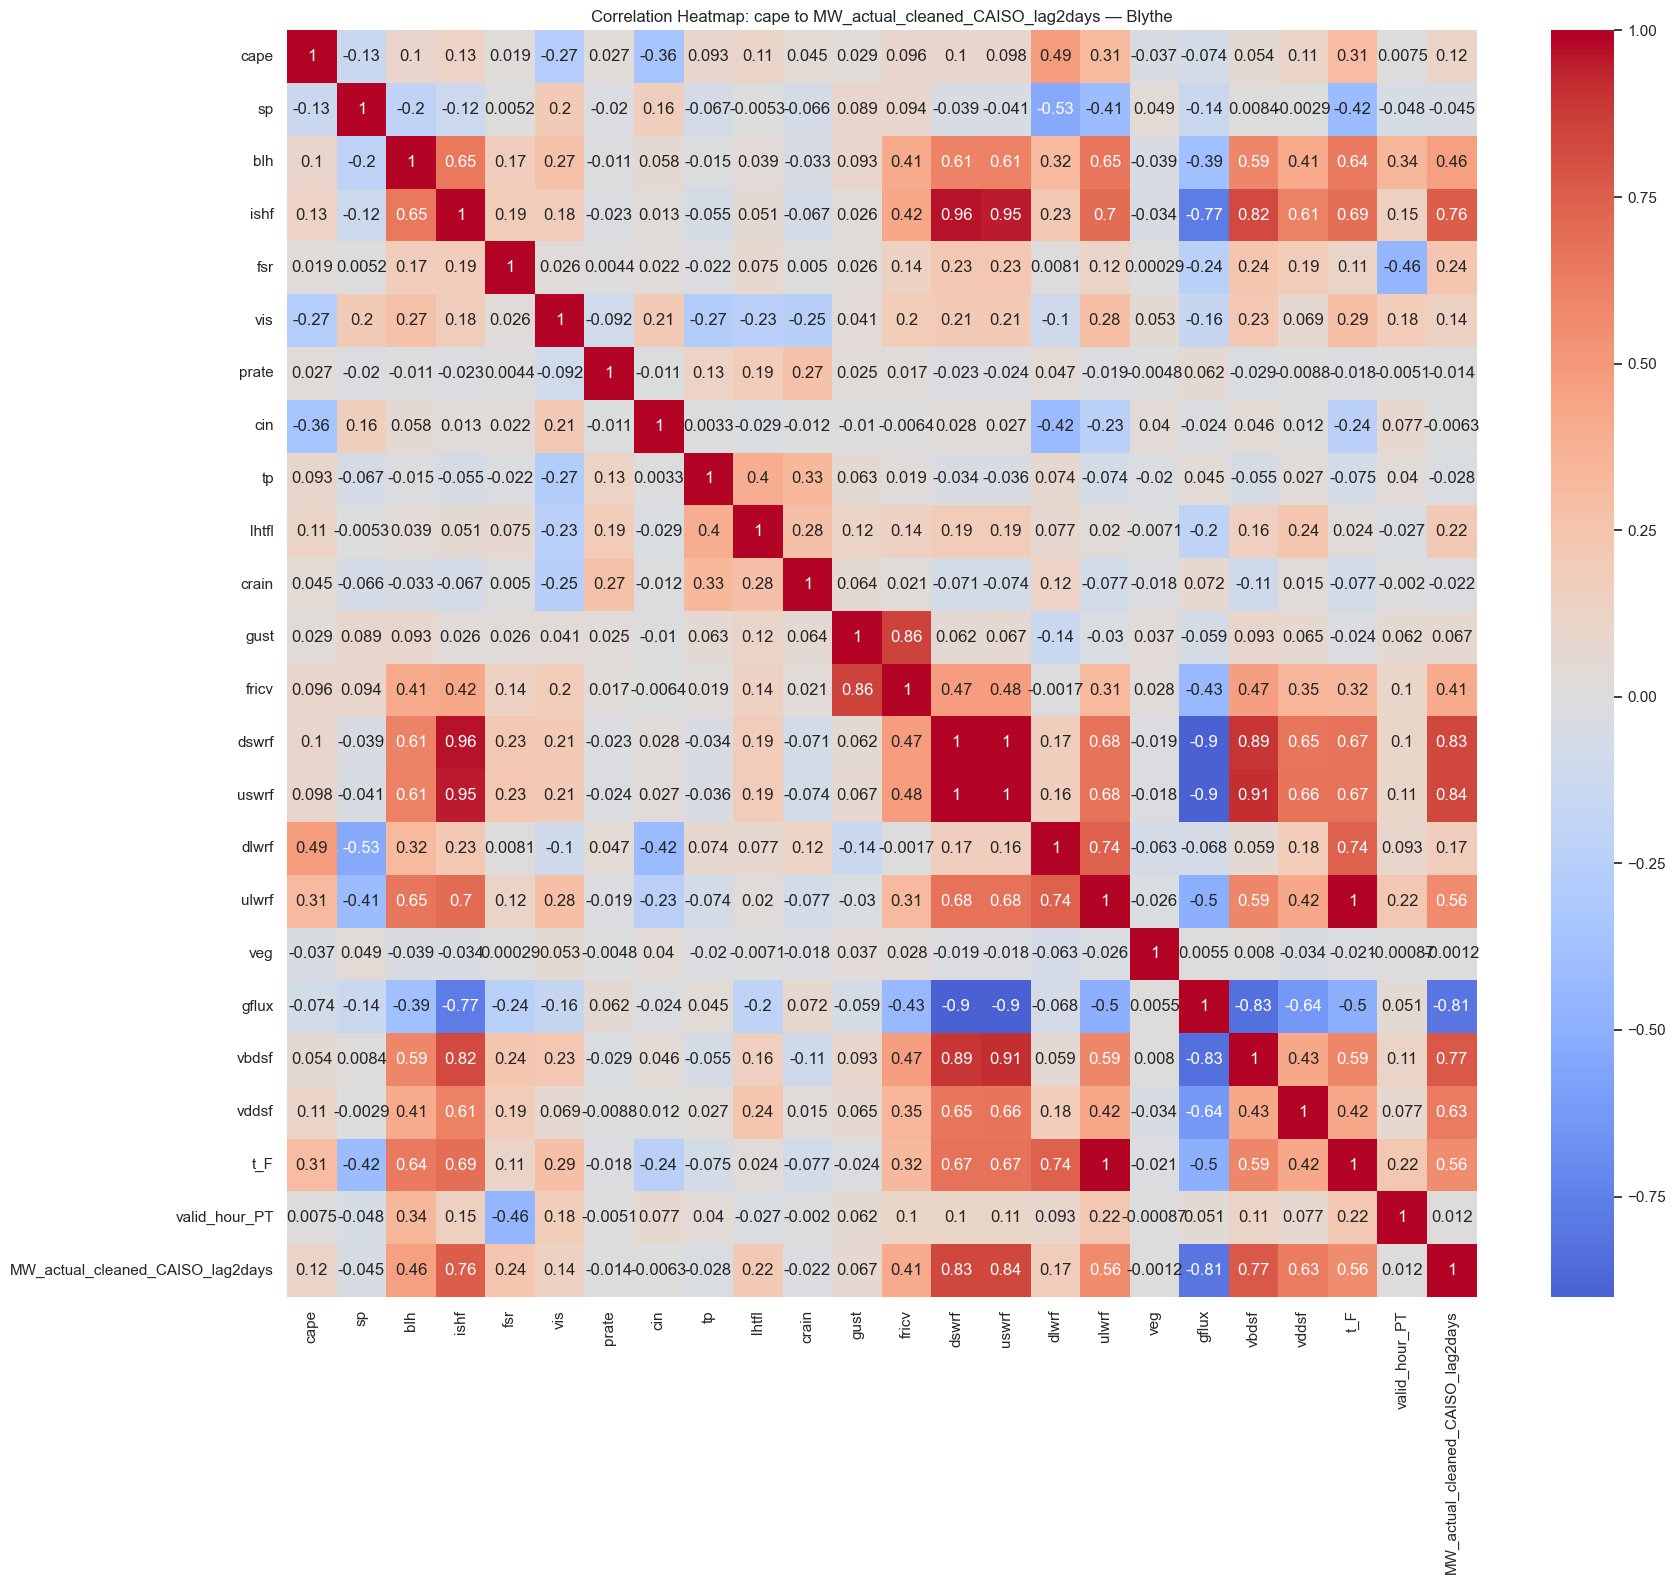

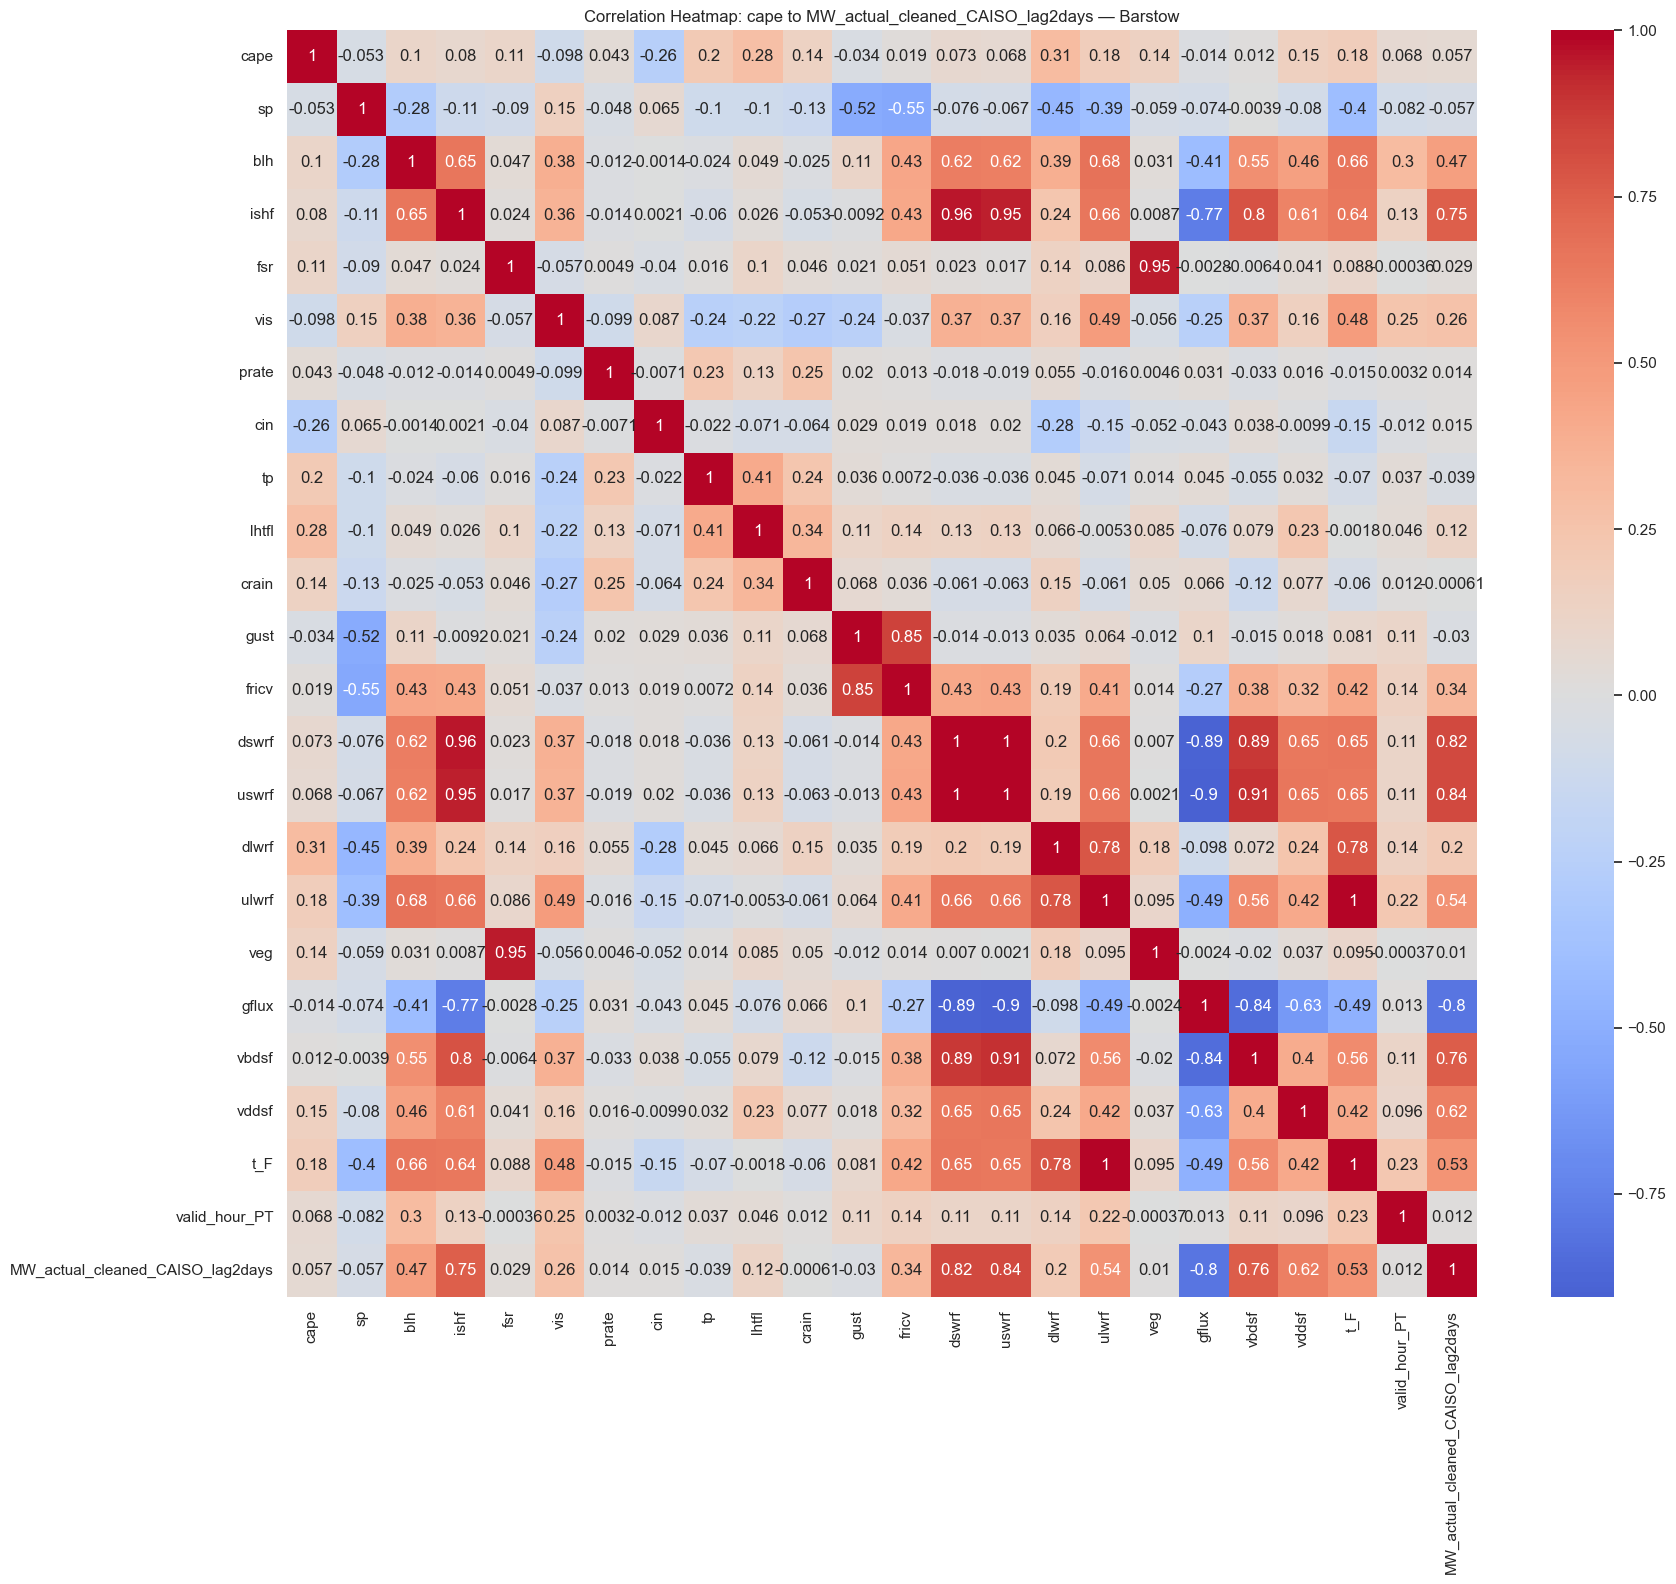

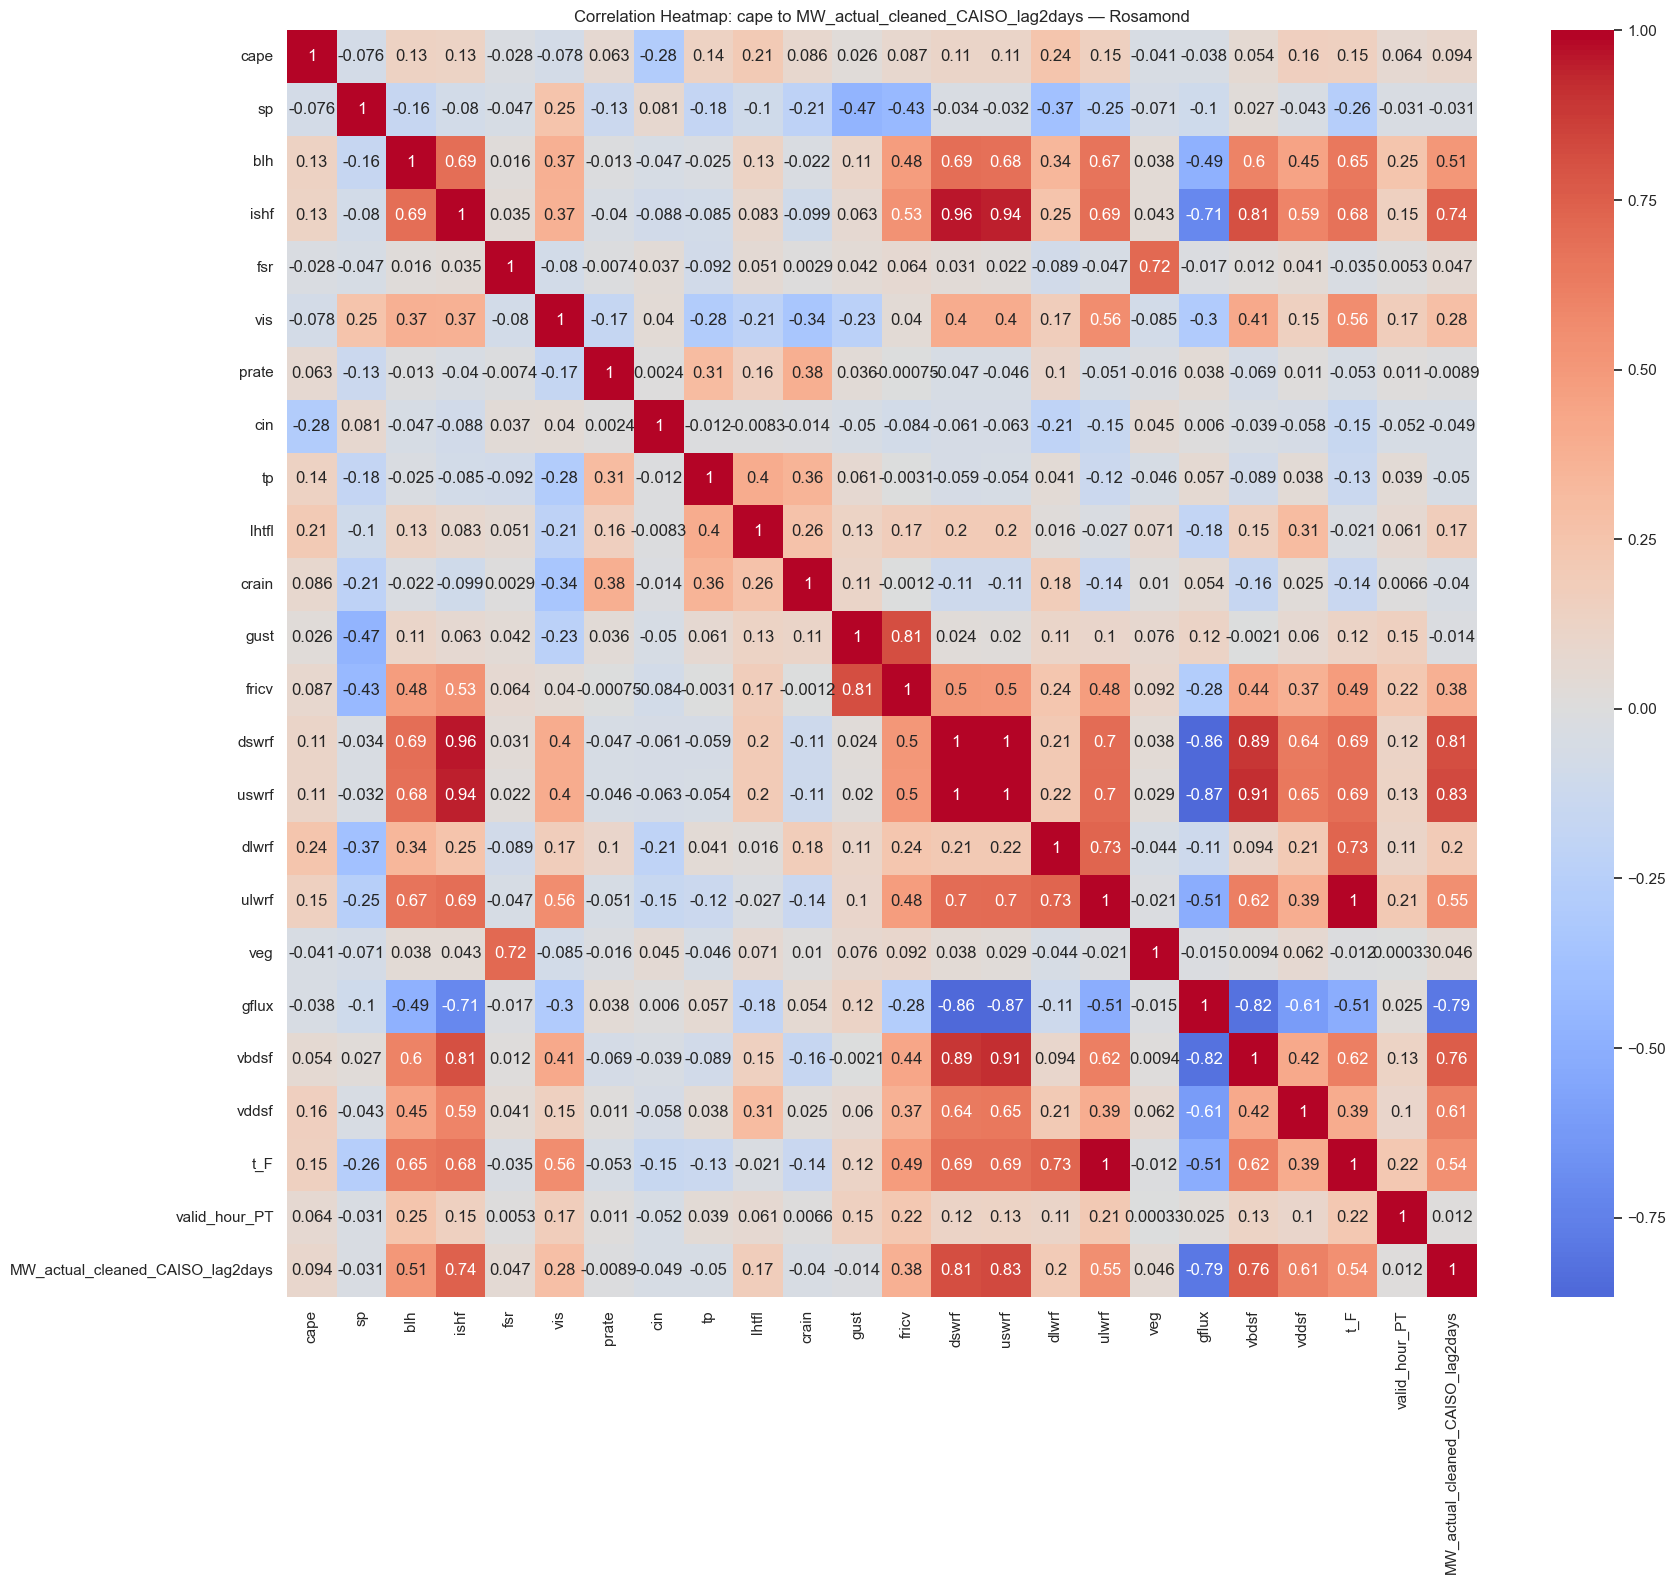

In [ ]:
# Define the start and end of the column
start_col = "cape"
end_col = "MW_actual_cleaned_CAISO_lag2days"

# List of columns to exclude
columns_to_exclude = ["MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]

# Loop through each unique location in the 'point_name' column
for loc in features['point_name'].unique():
    # Filter the dataset for the current location
    subset = features[features['point_name'] == loc]

    # Select the columns 
    cols_in_range = subset.loc[:, start_col:end_col]

    # Drop the excluded columns
    cols_in_range = cols_in_range.drop(columns=[col for col in columns_to_exclude if col in cols_in_range.columns])

    # Keep only numeric columns to ensure valid correlation computation
    numeric_subset = cols_in_range.select_dtypes(include='number')

    # Compute the correlation matrix
    corr = numeric_subset.corr()

    plt.figure(figsize=(18, 16))
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=True)
    plt.title(f'Correlation Heatmap: {start_col} to {end_col} — {loc}')
    plt.tight_layout()
    plt.show()


We see 'ulwrf' and "t_F" have a perfect positive correlation. Let's remove ulwrf.

In [165]:
features = features.drop(columns = ['ulwrf'])

We also see four variables that are all highly correlated across all three locations (dswrf, uswrf, gflux, and vbdsf). We can perform PCA on these vars and only include PC1 if we want. The Random Forest and XGBoost models won't require this as they deal with correlated variables well, but it will be nice to have in the event that we test out some other models like NNs or regression.

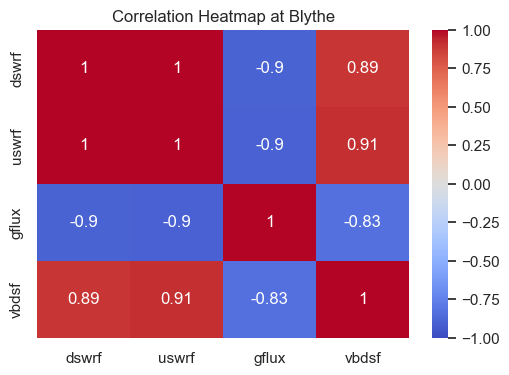

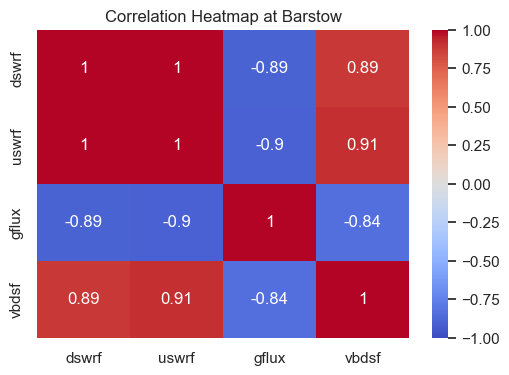

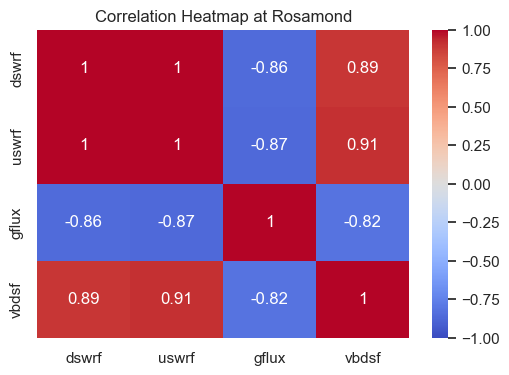

In [ ]:
# Cols to look at
vars_to_check = ['dswrf', 'uswrf', 'gflux', 'vbdsf']

# Loop through each point_name
for point in features['point_name'].unique():
    subset = features[features['point_name'] == point][vars_to_check]
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(subset.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap at {point}')
    plt.show()


In [ ]:
# Cols to look at
vars_to_check = ['dswrf', 'uswrf', 'gflux', 'vbdsf']

# Group by location and compute correlation matrix per group
for location, group in features.groupby('point_name'):
    # Drop rows with NaNs in the variables of interest
    subset = group[vars_to_check].dropna()

    # Make sure values are numeric
    subset = subset.apply(pd.to_numeric, errors='coerce')
    print(f"\nCorrelation matrix for location: {location}")
    print(subset.corr())



Correlation matrix for location: Barstow
          dswrf     uswrf     gflux     vbdsf
dswrf  1.000000  0.996872 -0.891680  0.887907
uswrf  0.996872  1.000000 -0.904901  0.910020
gflux -0.891680 -0.904901  1.000000 -0.839291
vbdsf  0.887907  0.910020 -0.839291  1.000000

Correlation matrix for location: Blythe
          dswrf     uswrf     gflux     vbdsf
dswrf  1.000000  0.997766 -0.895368  0.894839
uswrf  0.997766  1.000000 -0.900630  0.911748
gflux -0.895368 -0.900630  1.000000 -0.831413
vbdsf  0.894839  0.911748 -0.831413  1.000000

Correlation matrix for location: Rosamond
          dswrf     uswrf     gflux     vbdsf
dswrf  1.000000  0.996387 -0.856421  0.893782
uswrf  0.996387  1.000000 -0.866835  0.913097
gflux -0.856421 -0.866835  1.000000 -0.816815
vbdsf  0.893782  0.913097 -0.816815  1.000000


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

vars_to_check = ['dswrf', 'gflux', 'vbdsf']

# Standardize the four variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features[vars_to_check])

# Run PCA
pca = PCA(n_components=1)  # Get just the first principal component
first_pc = pca.fit_transform(X_scaled)

# Add PC1
features['solar_radiation_PC1'] = first_pc


In [169]:
features.columns

Index(['cape', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'cin', 'tp',
       'lhtfl', 'crain', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf', 'veg',
       'gflux', 'vbdsf', 'vddsf', 'valid_time_PT', 't_F', 'point_name',
       'valid_hour_PT', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO',
       'MW_error', 'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg',
       'cape_avg', 't_avg', 'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg',
       'fsr_avg', 'vis_avg', 'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg',
       'tp_avg', 'lhtfl_avg', 'hail_avg', 'crain_avg', 'cfrzr_avg',
       'cicep_avg', 'csnow_avg', 'cpofp_avg', 'snowc_avg', 'sdwe_avg',
       'gust_avg', 'fricv_avg', 'dswrf_avg', 'uswrf_avg', 'dlwrf_avg',
       'ulwrf_avg', 'bgrun_avg', 'ssrun_avg', 'veg_avg', 'gflux_avg',
       'cnwat_avg', 'frzr_avg', 'cfnsf_avg', 'vbdsf_avg', 'vddsf_avg',
       'lai_avg', 'is_dst', 'valid_month_PT', 'valid_year_PT',
       'solar_radiation_PC1'],
      dtype='object')

Now we will drop any rows that have missing values so that we can go through with random forest model building.

In [ ]:
# Select all possibly relevant columns
cols_to_check = features.loc[:, "cape":"MW_actual_cleaned_CAISO_lag2days"]

# Count how many of these columns have missing values
missing_cols = cols_to_check.columns[cols_to_check.isnull().any()]
num_missing_cols = len(missing_cols)

# Count how many rows have at least one missing value in this range
rows_with_missing = cols_to_check.isnull().any(axis=1)
num_rows_with_missing = rows_with_missing.sum()
total_rows = len(features)
percent_rows_with_missing = (num_rows_with_missing / total_rows) * 100

print(f"Number of columns with missing values: {num_missing_cols}")
print(f"Columns with missing values: {list(missing_cols)}\n")
print(f"Rows with ≥1 missing value in these columns: {num_rows_with_missing:,} / {total_rows:,} "
      f"({percent_rows_with_missing:.2f}%)")


Number of columns with missing values: 2
Columns with missing values: ['blh', 'MW_actual_cleaned_CAISO_lag2days']

Rows with ≥1 missing value in these columns: 147 / 60,396 (0.24%)


I really like the two day lag variable and don't see a reasonable way of imputing missing values given the pattern of missing values, so we'll just drop rows with missing values. This should trim the dataset by a bit in the beginning and a few hours in the middle.

In [172]:
# Drop rows with missing values specifically in the 'MW_actual_cleaned_CAISO' column
rf_data = features.dropna(subset=["MW_actual_cleaned_CAISO_lag2days"])

# Confirm the new shape
print(f"New shape after dropping: {rf_data.shape}")

New shape after dropping: (60252, 71)


In [ ]:
cols_to_check = rf_data.loc[:, "cape":"MW_actual_cleaned_CAISO_lag2days"]

# Count how many of these columns have missing vals
missing_cols = cols_to_check.columns[cols_to_check.isnull().any()]
num_missing_cols = len(missing_cols)

# Count how many rows have at least one missing value
rows_with_missing = cols_to_check.isnull().any(axis=1)
num_rows_with_missing = rows_with_missing.sum()
total_rows = len(rf_data)
percent_rows_with_missing = (num_rows_with_missing / total_rows) * 100

print(f"Number of columns with missing values: {num_missing_cols}")
print(f"Columns with missing values: {list(missing_cols)}\n")
print(f"Rows with ≥1 missing value in these columns: {num_rows_with_missing:,} / {total_rows:,} "
      f"({percent_rows_with_missing:.2f}%)")


Number of columns with missing values: 1
Columns with missing values: ['blh']

Rows with ≥1 missing value in these columns: 3 / 60,252 (0.00%)


Given how few rows there are with this value missing I'll just drop these rows.

In [174]:
# Drop rows with missing values for blh
rf_data = rf_data.dropna(subset=["blh"])

# Confirm the new shape
print(f"New shape after dropping: {rf_data.shape}")

New shape after dropping: (60249, 71)


Let's take a look at a few of the hourly profiles of these variables before model building.

In [ ]:
rf_data[['tp', 'valid_hour_PT', '']].head(970).tail()

tp  valid_hour_PT
3039  0.01             21
3042  0.01             22
3045  0.00             23
3048  0.00              0
3051  0.00              1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

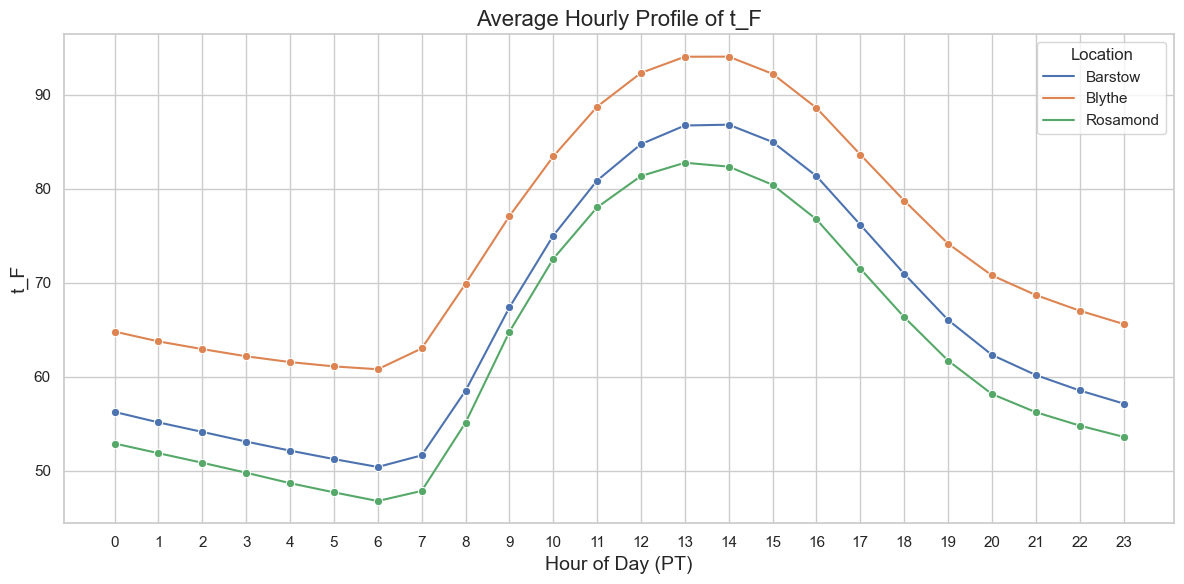

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

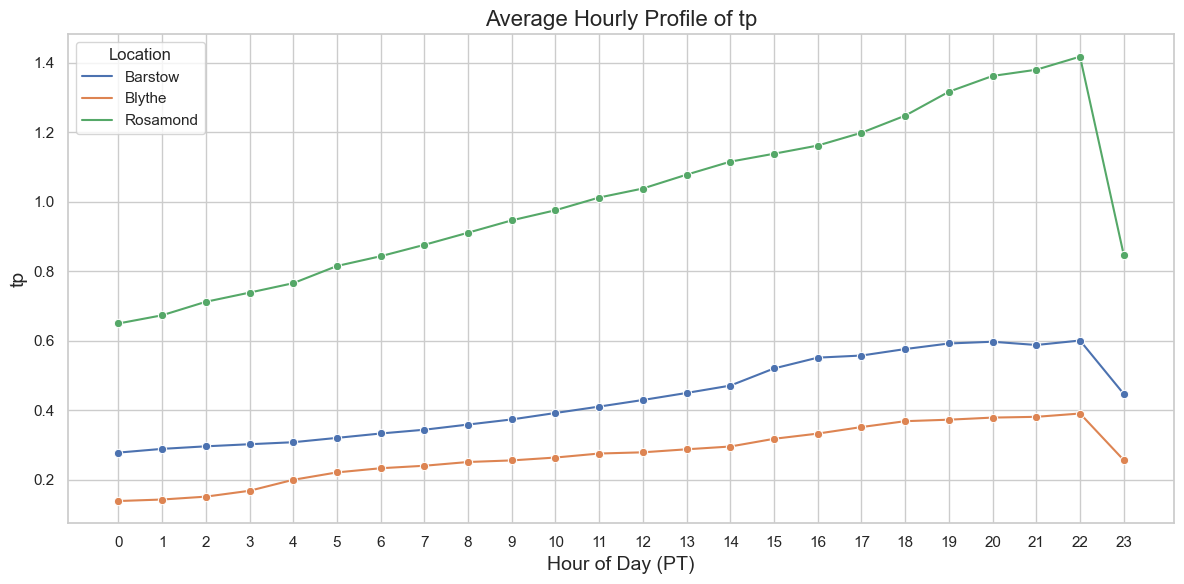

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

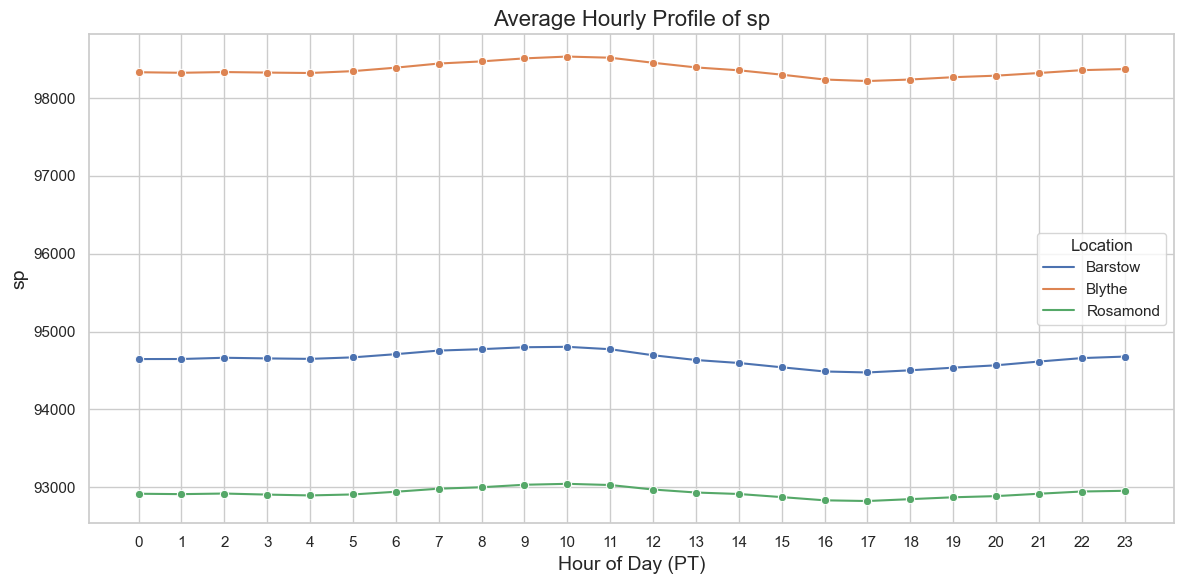

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

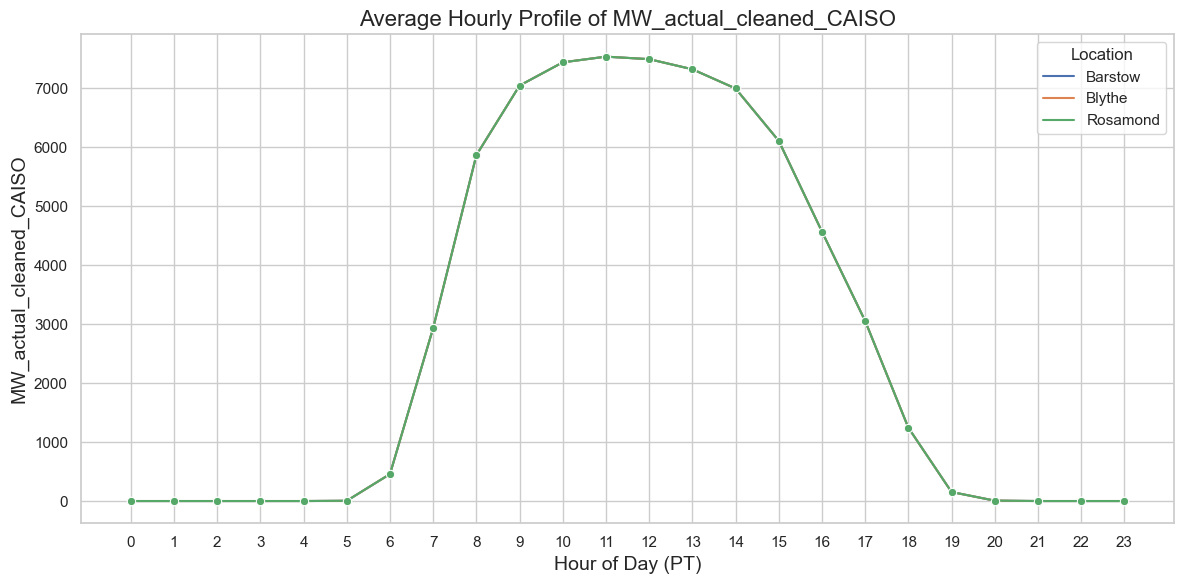

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

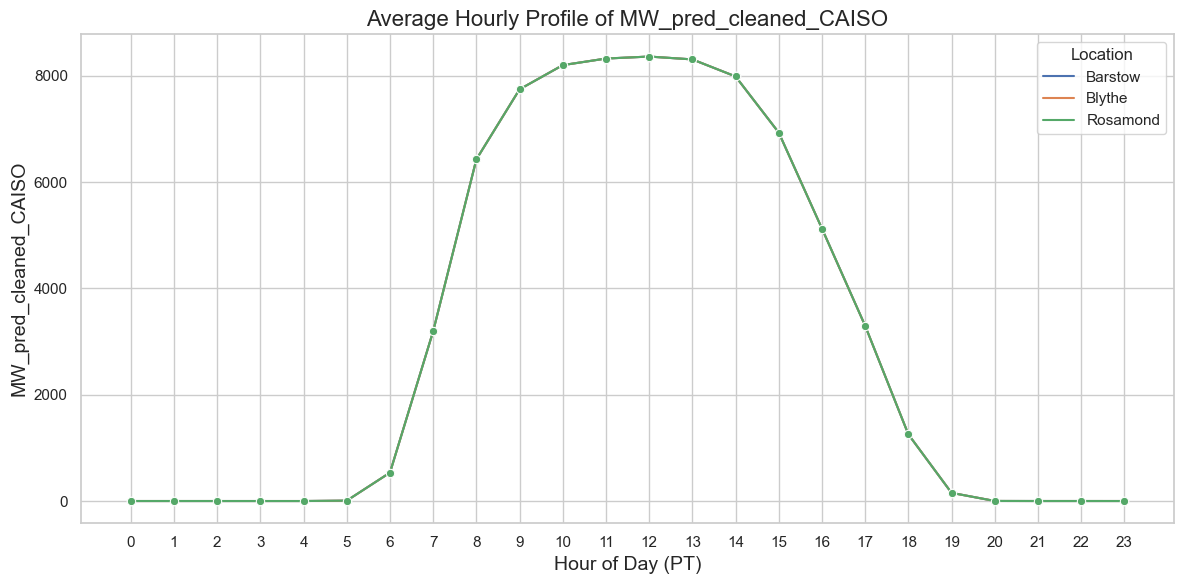

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

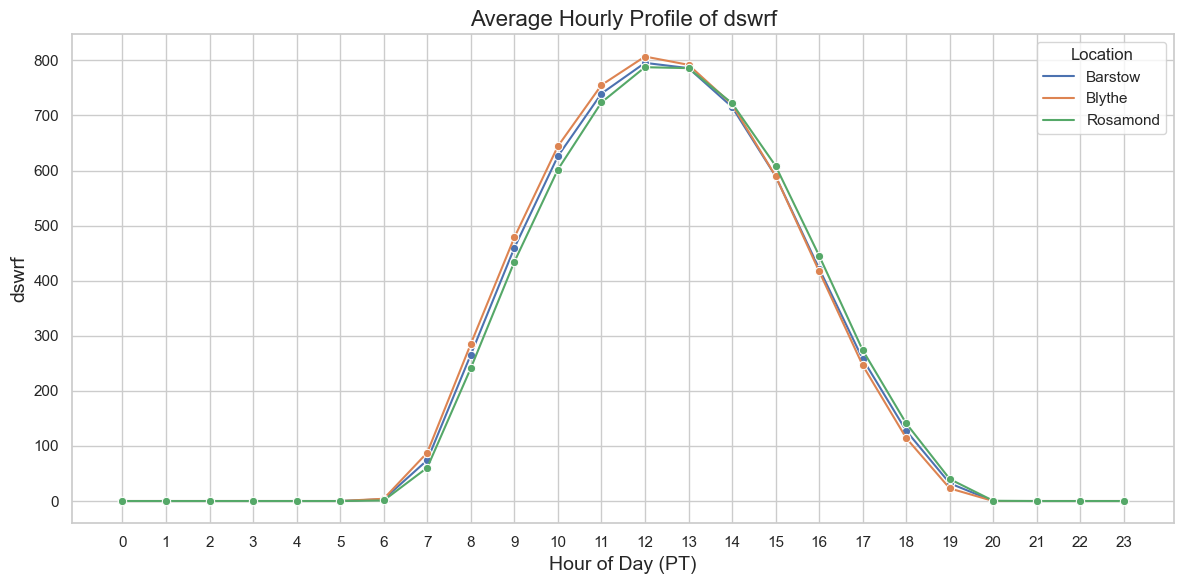

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

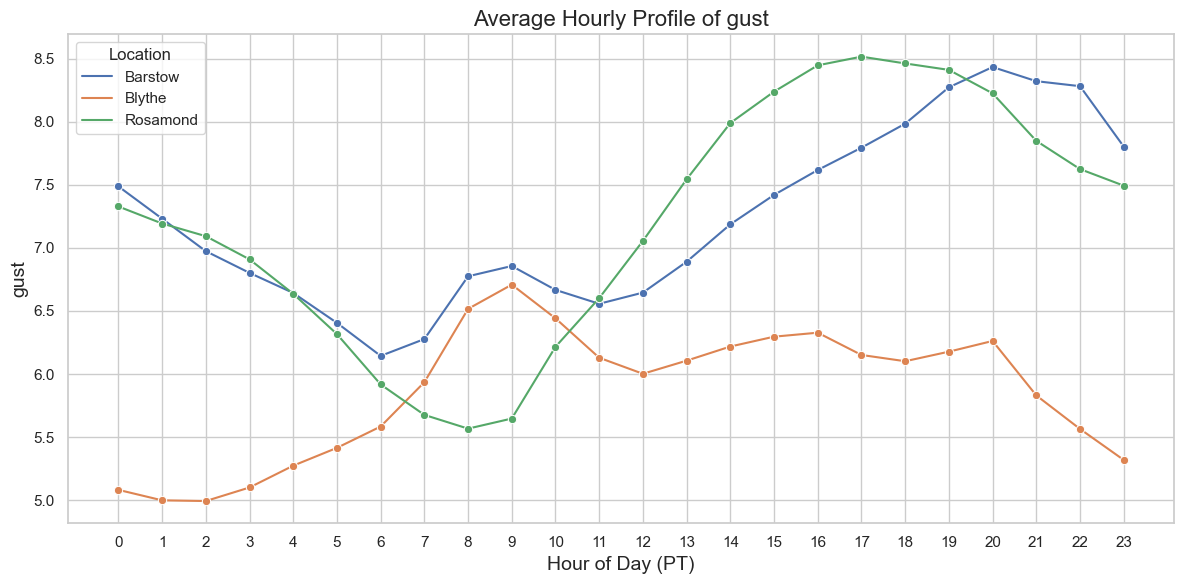

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

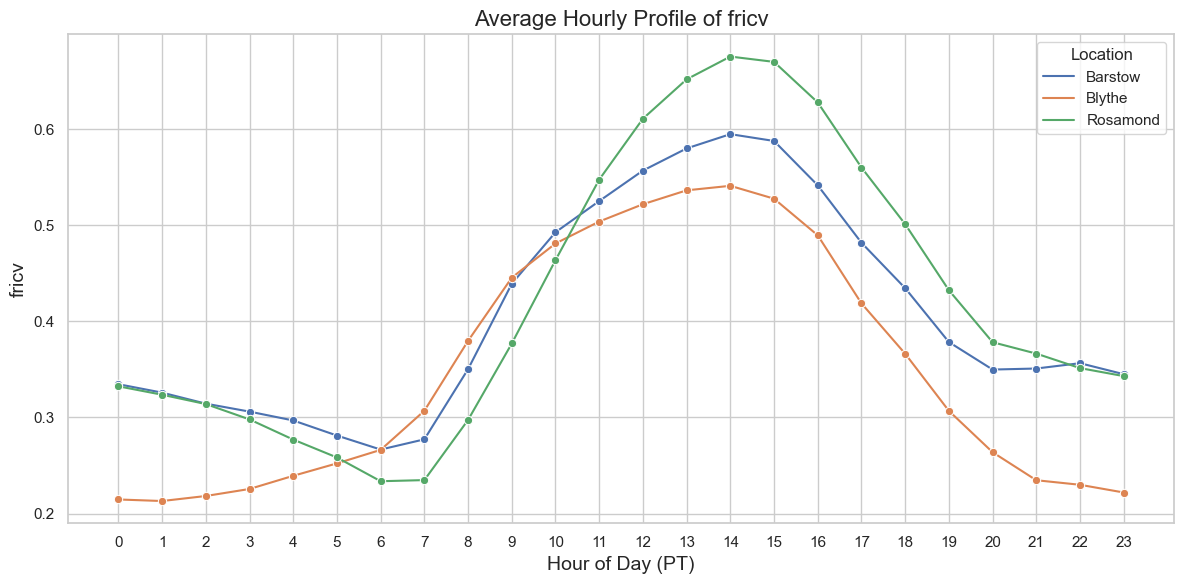

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

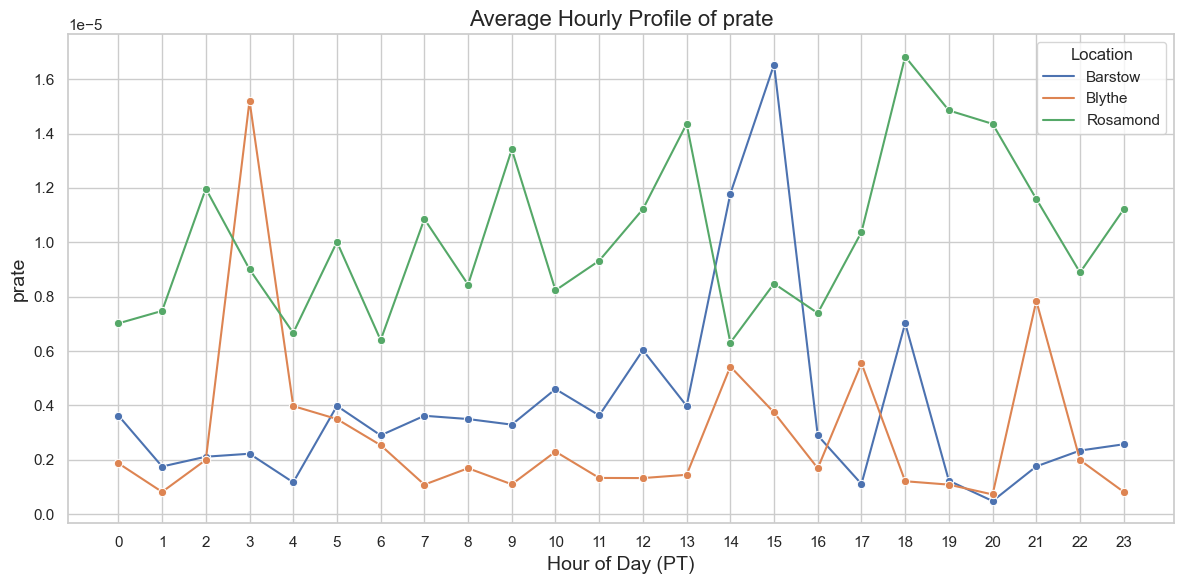

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Version

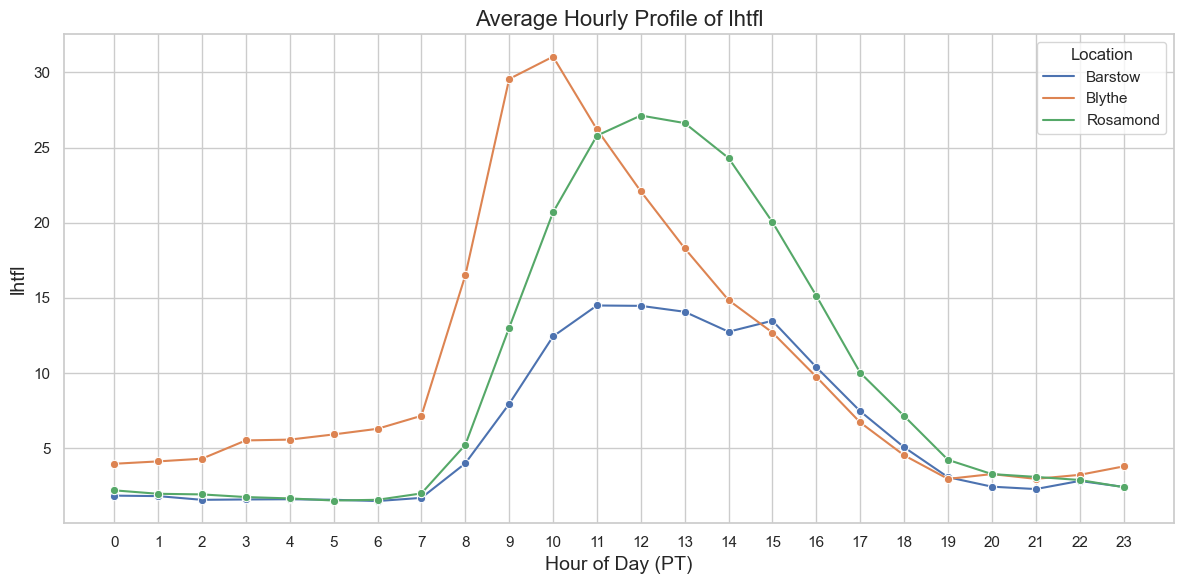

In [ ]:
# Style
sns.set(style="whitegrid")

# List of vars to plot
variables = ['t_F', 'tp', 'sp', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO', 'dswrf', 'gust', 'fricv', 'prate', 'lhtfl']

# Group by valid_hour_PT and point, then compute means for selected variables
hourly_avg = (
    rf_data.groupby(['valid_hour_PT', 'point_name'])[['t_F', 'tp', 'sp', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO', 'dswrf', 'gust', 'fricv', 'prate', 'lhtfl']]
    .mean()
    .reset_index()
)

# Loop through each variable and plot
for var in variables:
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(data=hourly_avg, x='valid_hour_PT', y=var, hue='point_name', marker='o')
    
    plt.title(f'Average Hourly Profile of {var}', fontsize=16)
    plt.xlabel('Hour of Day (PT)', fontsize=14)
    plt.ylabel(var, fontsize=14)
    plt.legend(title='Location')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Most interesting thing from these visuals is that tp (total precipitation) drops sharply during the last hour of the day. I tried shifting this by an hour in either direction to see if data was aligned incorrectly, but that didn't appear to be the case. I will consider dropping if this appears to be an issue during model building, but I'd like to keep it as a sort of proxy for cloud coverage.

### Model Building

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Ensure 'valid_time_PT' is in datetime format
features['valid_time_PT'] = pd.to_datetime(features['valid_time_PT'])

# Sort the DataFrame by 'valid_time_PT' and 'point_name'
features = features.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Split at 80/20
split_index = int(len(features) * 0.8)

# Split the data into training and testing sets
train_df = features.iloc[:split_index]
test_df = features.iloc[split_index:]

# Define the full column range
cape_idx = features.columns.get_loc("cape")
lag2_idx = features.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
feature_cols = features.columns[cape_idx:lag2_idx + 1].tolist()

# Remove non-feature columns if they are in the list
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
feature_cols = [col for col in feature_cols if col not in exclude_cols]

# Define the target variable
target_col = "MW_actual_cleaned_CAISO"

# Extract features and target for training and testing
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

features.head()


cape       sp         blh   ishf     fsr      vis  prate  cin   tp  lhtfl  \
0   0.0  95190.0   38.583710   -8.0  0.0866  79700.0    0.0  0.0  0.0    0.0   
1   0.0  98640.0   94.646210 -112.0  0.0650  90000.0    0.0  0.0  0.0    1.0   
2   0.0  93430.0   21.333708  -13.0  0.1003  70000.0    0.0  0.0  0.0    0.0   
3   0.0  95250.0   40.494644   -3.0  0.0866  79800.0    0.0  0.0  0.0    0.0   
4   0.0  98670.0  252.557140 -130.0  0.0650  90000.0    0.0  0.0  0.0    1.0   

   ...  cnwat_avg  frzr_avg  cfnsf_avg  vbdsf_avg  vddsf_avg  lai_avg  is_dst  \
0  ...        0.0       0.0        0.0        0.0        0.0     0.25   False   
1  ...        0.0       0.0        0.0        0.0        0.0     0.00   False   
2  ...        0.0       0.0        0.0        0.0        0.0     0.50   False   
3  ...        0.0       0.0        0.0        0.0        0.0     0.25   False   
4  ...        0.0       0.0        0.0        0.0        0.0     0.00   False   

   valid_month_PT  valid_year_PT  solar_radiation_PC1  
0              12           2021             1.285171  
1              12           2021             0.690268  
2              12           2021             1.285171  
3              12           2021             1.285171  
4              12           2021             0.605282  

[5 rows x 71 columns]

In [ ]:
# Initialize TimeSeriesSplit with desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

In [185]:
rf_data.columns

Index(['cape', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'cin', 'tp',
       'lhtfl', 'crain', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf', 'veg',
       'gflux', 'vbdsf', 'vddsf', 'valid_time_PT', 't_F', 'point_name',
       'valid_hour_PT', 'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO',
       'MW_error', 'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg',
       'cape_avg', 't_avg', 'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg',
       'fsr_avg', 'vis_avg', 'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg',
       'tp_avg', 'lhtfl_avg', 'hail_avg', 'crain_avg', 'cfrzr_avg',
       'cicep_avg', 'csnow_avg', 'cpofp_avg', 'snowc_avg', 'sdwe_avg',
       'gust_avg', 'fricv_avg', 'dswrf_avg', 'uswrf_avg', 'dlwrf_avg',
       'ulwrf_avg', 'bgrun_avg', 'ssrun_avg', 'veg_avg', 'gflux_avg',
       'cnwat_avg', 'frzr_avg', 'cfnsf_avg', 'vbdsf_avg', 'vddsf_avg',
       'lai_avg', 'is_dst', 'valid_month_PT', 'valid_year_PT',
       'solar_radiation_PC1'],
      dtype='object')

/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_36352/824081654.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.fit_transform(X_train[col])
/var/folders/70/9yy_lf2j0fz2b3bn_9btzxj80000gn/T/ipykernel_36352/824081654.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])  # assumes test set has same categories



Cross-validation results:
   n_estimators     val_MAE    val_RMSE  train_R2    val_R2
0            50  453.355943  805.205605  0.996141  0.945574
1           100  450.391922  798.471711  0.996287  0.946522
2           200  449.290350  795.780485  0.996386  0.946868
3           300  448.627291  795.026328  0.996409  0.946951


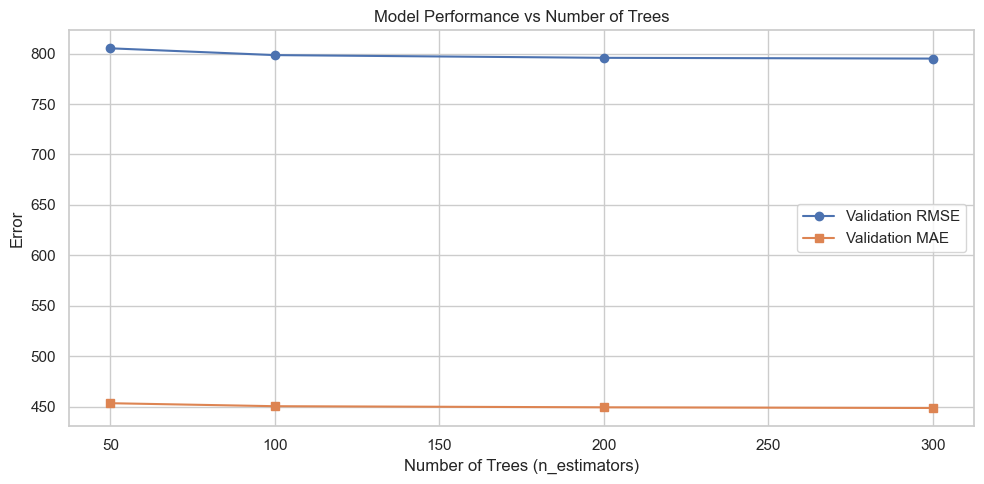


Random Forest - Test MAE: 519.14, RMSE: 964.13
Existing Predictions - Test MAE: 503.77, RMSE: 1029.51


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Sort data and identify features
# Ensure datetime column is in proper format
rf_data['valid_time_PT'] = pd.to_datetime(rf_data['valid_time_PT'])

# Sort chronologically and by location
rf_data = rf_data.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Identify feature columns: everything from 'cape' to 'MW_actual_cleaned_CAISO_lag2days', excluding non-features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = rf_data.columns.get_loc("cape")
lag2_idx = rf_data.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = rf_data.columns[cape_idx:lag2_idx + 1].tolist()
feature_cols = [col for col in all_cols if col not in exclude_cols]

# Target
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological) 
split_index = int(len(rf_data) * 0.8)
train_df = rf_data.iloc[:split_index]
test_df = rf_data.iloc[split_index:]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Identify categorical columns (likely just 'point_name', but this makes it general)
categorical_cols = X_train.select_dtypes(include='object').columns

# Apply label encoding to all categorical columns in both train and test
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  
    label_encoders[col] = le


# TimeSeries cross-validation and model tuning 
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300]

results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE and MAE vs number of trees
plt.figure(figsize=(10, 5))

# RMSE
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', label='Validation RMSE')

# MAE
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', label='Validation MAE')

plt.title('Model Performance vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final model on full training set with best tree count 
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred_rf = final_model.predict(X_test)

# Evaluate on test set 
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")


Let's substitute in some of our weather variables that have been averaged over the course of an hour and see how performance changes. We'll also graph errors on separate axis.


Cross-validation results:
   n_estimators     val_MAE    val_RMSE  train_R2    val_R2
0            50  434.063128  774.767691  0.996285  0.949698
1           100  432.391299  770.913290  0.996457  0.950196
2           200  430.463461  768.241591  0.996555  0.950522
3           300  430.853745  768.629100  0.996581  0.950482


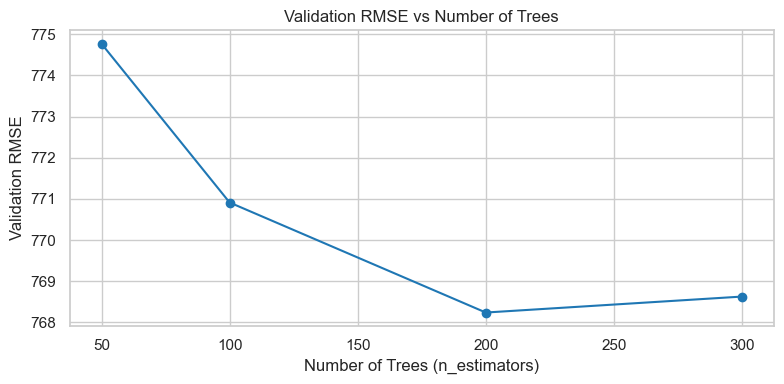

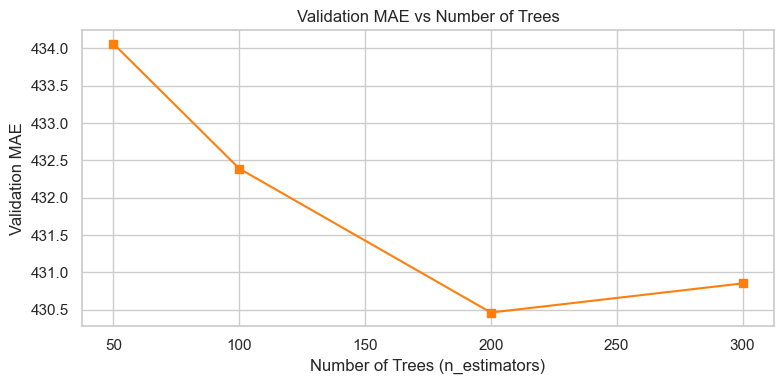


Random Forest - Test MAE: 506.60, RMSE: 945.32
Existing Predictions - Test MAE: 503.77, RMSE: 1029.51


In [ ]:
# Sort data and identify features 

# Ensure datetime column is in proper format
rf_data['valid_time_PT'] = pd.to_datetime(rf_data['valid_time_PT'])

# Sort chronologically and by location to preserve 3-rows-per-hour structure
rf_data = rf_data.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Convert 't_avg' from Kelvin to Fahrenheit (°F = (K - 273.15) * 9/5 + 32)
rf_data['t_avg_F'] = (rf_data['t_avg'] - 273.15) * 9/5 + 32

# Substitution mapping: use these averaged features instead of their originals
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = rf_data.columns.get_loc("cape")
lag2_idx = rf_data.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = rf_data.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological)
split_index = int(len(rf_data) * 0.8)
train_df = rf_data.iloc[:split_index]
test_df = rf_data.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col]
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Label encode any categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# TimeSeries cross-validation and model tuning
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300]
results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', color='tab:blue')
plt.title('Validation RMSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', color='tab:orange')
plt.title('Validation MAE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final model on full training set with best tree count
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred_rf = final_model.predict(X_test)

# Evaluate on test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")

Nice! The variable swaps definitely helped lower MAE and RMSE. And we're already beating RMSE. Let's move on to XGBoost and see if that can solidify our model performance.

### XGBoost

Let's start by running a vanilla XGBoost model with our averaged feature values that we found to be beneficial in the above RF models.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Sort chronologically and by location 
rf_data = rf_data.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)
rf_data['t_avg_F'] = (rf_data['t_avg'] - 273.15) * 9/5 + 32

# One-hot encode 'point_name'
rf_data = pd.get_dummies(rf_data, columns=['point_name'])

# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = rf_data.columns.get_loc("cape")
lag2_idx = rf_data.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = rf_data.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Add month, year, and new one-hot columns to feature list
feature_cols += ['valid_month_PT', 'valid_year_PT']
feature_cols += [col for col in rf_data.columns if col.startswith('point_name_')]

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/Test Split 
split_index = int(len(rf_data) * 0.8)
train_df = rf_data.iloc[:split_index]
test_df = rf_data.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()
y_pred_existing = test_df[benchmark_col].copy()

# TimeSeriesSplit CV with Vanilla XGBoost
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [100, 200, 300]

results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(
            n_estimators=n,
            random_state=42,
            n_jobs=-1
        )  # Vanilla: no tuning
        model.fit(X_t, y_t, eval_set=[(X_val, y_val)], verbose=False)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nVanilla XGBoost CV Results:")
print(results_df)

# Train Final Model on Full Train Set
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model = XGBRegressor(
    n_estimators=int(best_n),
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)

# Test Evaluation 
y_pred_xgb = final_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nVanilla XGBoost - Test MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")


Vanilla XGBoost CV Results:
   n_estimators     val_MAE    val_RMSE  train_R2    val_R2
0           100  436.423763  776.904476  0.994965  0.947786
1           200  450.843892  793.685307  0.997823  0.945615
2           300  456.169076  801.297843  0.998878  0.944621

Vanilla XGBoost - Test MAE: 548.80, RMSE: 1013.15
Existing Predictions - Test MAE: 503.77, RMSE: 1029.51


Okay, beating the benchmark with RMSE but not MAE. Let's do some hyperparameter tuning and optimize for MAE.

In [ ]:
# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = rf_data.columns.get_loc("cape")
lag2_idx = rf_data.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = rf_data.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Add month, year, and new one-hot columns to feature list
feature_cols += ['valid_month_PT', 'valid_year_PT']
feature_cols += [col for col in rf_data.columns if col.startswith('point_name_')]

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/Test Split 
split_index = int(len(rf_data) * 0.8)
train_df = rf_data.iloc[:split_index]
test_df = rf_data.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()
y_pred_existing = test_df[benchmark_col].copy()

# TimeSeriesSplit CV and Hyperparameter Search
tscv = TimeSeriesSplit(n_splits=5)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 250],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "gamma": [0, 1],
    "min_child_weight": [1, 3]
}

xgb_base = XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best RMSE (CV):", -grid.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 250, 'subsample': 0.6}
Best RMSE (CV): 387.8081930626139


In [190]:
# Define optimal model
final_model = XGBRegressor(
    n_estimators= 250,  
    learning_rate= 0.05,
    max_depth= 4,
    subsample= 0.6,
    colsample_bytree= 0.8,
    gamma= 1,
    min_child_weight= 3,
    random_state= 42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# Test Evaluation
y_pred_xgb = final_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)
mse_existing = mean_squared_error(y_test, y_pred_existing)

print(f"\nXGBoost - Test MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, MSE: {mse_xgb:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}, MSE: {mse_existing:.2f}")


XGBoost - Test MAE: 518.52, RMSE: 944.56, MSE: 892190.11
Existing Predictions - Test MAE: 503.77, RMSE: 1029.51, MSE: 1059883.92


Conitnueing to try to improve our model. Let's model month and hour as cyclical using cosine and sine. As it stands at the moment, these variables are modeled in a linear fashion that could suggest hour 23 is "far away" from hour 0, and that month 12 is "far away" from month 1. These additions will help model the cyclical nature of how we record various aspects of time.

In [ ]:
# ---- Model valid_month_PT as cyclical (1-12) ---- #
rf_data['valid_month_sin_cyclical'] = np.sin(2 * np.pi * rf_data['valid_month_PT'] / 12)
rf_data['valid_month_cos_cyclical'] = np.cos(2 * np.pi * rf_data['valid_month_PT'] / 12)

# ---- Model valid_hour_PT as cyclical (0-23) ---- #
rf_data['valid_hour_sin_cyclical'] = np.sin(2 * np.pi * rf_data['valid_hour_PT'] / 24)
rf_data['valid_hour_cos_cyclical'] = np.cos(2 * np.pi * rf_data['valid_hour_PT'] / 24)


In [ ]:
# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = rf_data.columns.get_loc("cape")
lag2_idx = rf_data.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = rf_data.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)


# Start with existing feature_cols, and remove raw cyclical time features
feature_cols = [col for col in feature_cols if col not in ['valid_month_PT', 'valid_hour_PT']]

# Add month, year, and new one-hot columns to feature list
feature_cols += [col for col in rf_data.columns if col.startswith('point_name_')]

# Add cyclical time features
feature_cols += [
    'valid_month_sin_cyclical', 'valid_month_cos_cyclical',
    'valid_hour_sin_cyclical', 'valid_hour_cos_cyclical'
]

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/Test Split 
split_index = int(len(rf_data) * 0.8)
train_df = rf_data.iloc[:split_index]
test_df = rf_data.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()
y_pred_existing = test_df[benchmark_col].copy()

# TimeSeriesSplit CV and Hyperparameter Search
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [100, 200, 250],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "gamma": [0, 1],
    "min_child_weight": [1, 3]
}

xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best RMSE (CV):", -grid.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


Best parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE (CV): 489.5139936836349


In [193]:
# Define optimal model
final_model = XGBRegressor(
    n_estimators= 200,  
    learning_rate= 0.05,
    max_depth= 4,
    subsample= 0.8,
    colsample_bytree= 0.6,
    gamma= 0,
    min_child_weight= 3,
    random_state= 42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# Test Evaluation
y_pred_xgb = final_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)
mse_existing = mean_squared_error(y_test, y_pred_existing)

print(f"\nXGBoost - Test MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, MSE: {mse_xgb:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}, MSE: {mse_existing:.2f}")


XGBoost - Test MAE: 535.95, RMSE: 963.94, MSE: 929176.69
Existing Predictions - Test MAE: 503.77, RMSE: 1029.51, MSE: 1059883.92


In [ ]:
print("First 5 rows:")
print(y_pred_xgb[:5])

print("\nMinimum value in the array:")
print(np.min(y_pred_xgb))


First 5 rows:
[-1.3571367 11.806159   4.6471877  1.5826323 17.686152 ]

Minimum value in the array:
-119.03045


In [200]:
print(y_test[:18])

48199       0.00000
48200       0.00000
48201       0.00000
48202       0.00000
48203       0.00000
48204       0.00000
48205       0.00000
48206       0.00000
48207       0.00000
48208       0.00000
48209       0.00000
48210     608.22486
48211     608.22486
48212     608.22486
48213    4306.24808
48214    4306.24808
48215    4306.24808
48216    6865.08914
Name: MW_actual_cleaned_CAISO, dtype: float64


In [201]:
print(y_pred_xgb[:18])

[-1.3571367e+00  1.1806159e+01  4.6471877e+00  1.5826323e+00
  1.7686152e+01  4.6471877e+00  1.5826323e+00  1.7686152e+01
  4.6471877e+00  3.5164711e+00  1.6930367e+01  4.1109229e+02
  6.2221906e+02  3.0615128e+02  3.6022161e+03  4.0453250e+03
  3.6449878e+03  6.5676147e+03]


Let's try something new here. I want to only predict on daytime hours since we know that nighttime hours should be zero. Let's use our conservative estimates from earlier where we forced actual values to be zero between the latest sunset and earliest sunrise in SoCal. Let's create a new dataset where we remove these overnight hours, and then train some models on a daytime dataset

In [207]:
rf_data[['valid_hour_PT']].max()

valid_hour_PT    23
dtype: int32

Given my lack of domain knowledge heading into the project, this has been a learn as I go type of analysis. Something that just became obvious is the lack of importance of nighttime data. Actually, not only is this "unimportant", it's actually probably detrimental to model training and performance by introducing noise.

I believe these overnight values are actually just introducing unnecessary noise to our data and hurting our models. Aside from the personal motivations for this project, the purpose of an analysis like this would be to get an accurate understanding of next-day solar energy generation to inform buying and selling. Solar generation does not happen overnight. As it stands, my model is predicting non-zero values at night. There is no point in including these hours when we know with certainty what those values will be. I will now remove those hours and re-train some models. I will remove 'valid_hour_PT' values between 9 and 5 as the sun never rises or sets between those times at any point during the year. 

In [ ]:
# Define the list of overnight hours to exclude
overnight_hours = [21, 22, 23, 0, 1, 2, 3, 4]

# Filter to only include rows where valid_hour_PT is NOT in the overnight list
daytime_hours = rf_data[~rf_data['valid_hour_PT'].isin(overnight_hours)].copy() # Remember: This var is hour start!

# check the result
print(f"Original rows: {len(rf_data)}")
print(f"Filtered (daytime) rows: {len(daytime_hours)}")


Original rows: 60249
Filtered (daytime) rows: 39735


In [211]:
daytime_hours.columns

Index(['cape', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'cin', 'tp',
       'lhtfl', 'crain', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf', 'veg',
       'gflux', 'vbdsf', 'vddsf', 'valid_time_PT', 't_F', 'valid_hour_PT',
       'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO', 'MW_error',
       'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg', 'cape_avg', 't_avg',
       'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg', 'fsr_avg', 'vis_avg',
       'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg', 'tp_avg', 'lhtfl_avg',
       'hail_avg', 'crain_avg', 'cfrzr_avg', 'cicep_avg', 'csnow_avg',
       'cpofp_avg', 'snowc_avg', 'sdwe_avg', 'gust_avg', 'fricv_avg',
       'dswrf_avg', 'uswrf_avg', 'dlwrf_avg', 'ulwrf_avg', 'bgrun_avg',
       'ssrun_avg', 'veg_avg', 'gflux_avg', 'cnwat_avg', 'frzr_avg',
       'cfnsf_avg', 'vbdsf_avg', 'vddsf_avg', 'lai_avg', 'is_dst',
       'valid_month_PT', 'valid_year_PT', 'solar_radiation_PC1', 't_avg_F',
       'point_name_Barstow', 'point_name_Blythe', 'po

### Random Forest

In [ ]:
# Define a function to reconstruct 'point_name' from one-hot encoded columns
def get_point_name(row):
    if row['point_name_Barstow']:
        return 'Barstow'
    elif row['point_name_Blythe']:
        return 'Blythe'
    elif row['point_name_Rosamond']:
        return 'Rosamond'
    else:
        return np.nan 

# Apply the function row-wise and assign to a new column
daytime_hours['point_name'] = daytime_hours.apply(get_point_name, axis=1)



Cross-validation results:
   n_estimators     val_MAE    val_RMSE  train_R2    val_R2
0            50  658.266751  961.984203  0.994469  0.915930
1           100  655.802384  957.407071  0.994694  0.916764
2           200  654.440574  953.762776  0.994827  0.917429
3           300  653.071586  951.574056  0.994855  0.917834


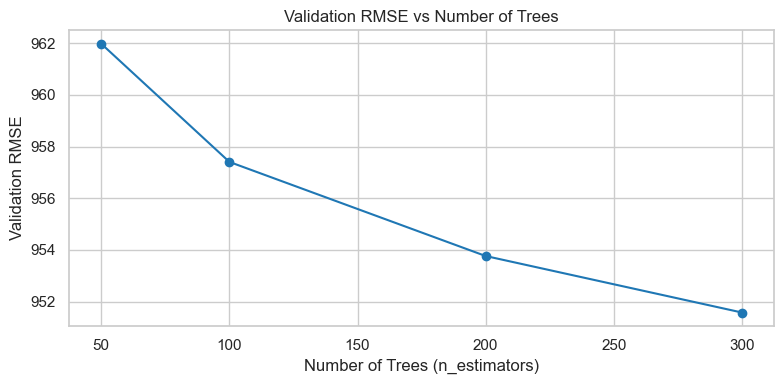

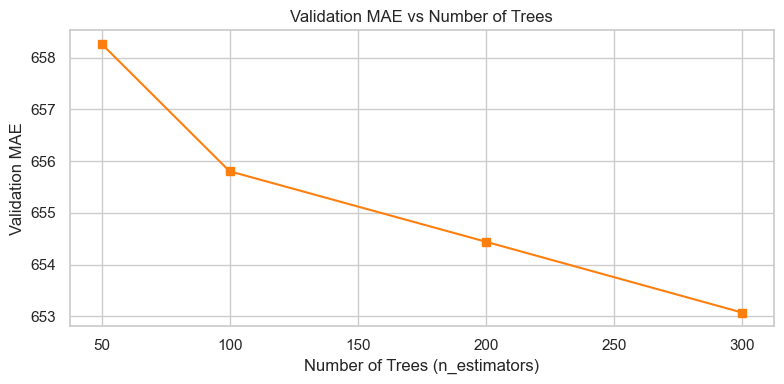


Random Forest - Test MAE: 769.52, RMSE: 1169.38
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Sort data and identify features 

# Ensure datetime column is in proper format
daytime_hours['valid_time_PT'] = pd.to_datetime(daytime_hours['valid_time_PT'])

# Sort chronologically and by location
daytime_hours = daytime_hours.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)
daytime_hours['t_avg_F'] = (daytime_hours['t_avg'] - 273.15) * 9/5 + 32

# Substitution mapping: use these averaged features instead of their originals
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological)
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col]
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Label encode any categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# TimeSeries cross-validation and model tuning
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300]
results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', color='tab:blue')
plt.title('Validation RMSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', color='tab:orange')
plt.title('Validation MAE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final model on full training set with best tree count
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred_rf = final_model.predict(X_test)

# Evaluate on test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")


Cross-validation results:
   n_estimators     val_MAE    val_RMSE  train_R2    val_R2
0            50  658.266751  961.984203  0.994469  0.915930
1           100  655.802384  957.407071  0.994694  0.916764
2           200  654.440574  953.762776  0.994827  0.917429
3           300  653.071586  951.574056  0.994855  0.917834
4           350  653.397447  952.281699  0.994863  0.917705
5           400  653.325802  952.117620  0.994881  0.917733


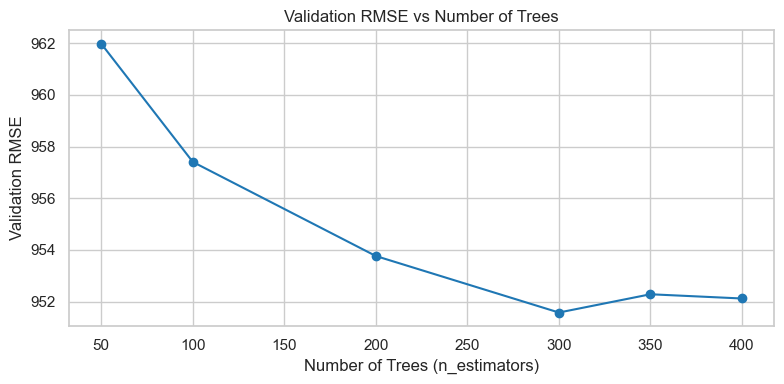

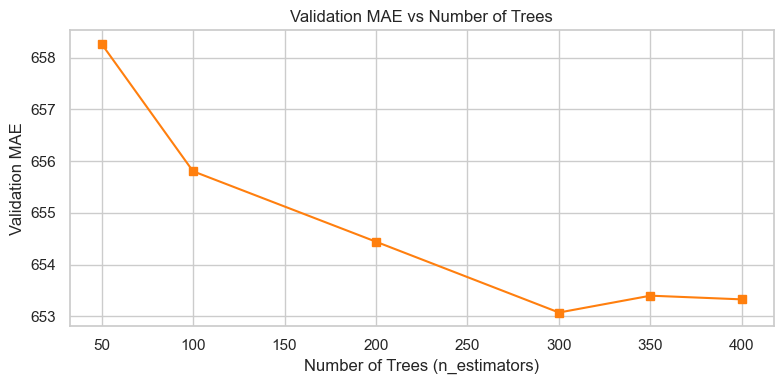


Random Forest - Test MAE: 769.52, RMSE: 1169.38
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71


In [ ]:
# Sort data and identify features 

# Ensure datetime column is in proper format
daytime_hours['valid_time_PT'] = pd.to_datetime(daytime_hours['valid_time_PT'])

# Sort chronologically and by location
daytime_hours = daytime_hours.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological)
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col]
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Label encode any categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# TimeSeries cross-validation and model tuning
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300, 350, 400]
results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', color='tab:blue')
plt.title('Validation RMSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', color='tab:orange')
plt.title('Validation MAE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final model on full training set with best tree count
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred_rf = final_model.predict(X_test)

# Evaluate on test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")

In [ ]:
# ---- Walk-forward test evaluation ---- #
test_size = len(test_df)
window_size = test_size // 4  # 4 equal windows
results_rf = []

for i in range(4):
    start = i * window_size
    end = (i + 1) * window_size if i < 3 else test_size  

    X_window = X_test.iloc[start:end]
    y_window = y_test.iloc[start:end]
    benchmark_window = y_pred_existing.iloc[start:end]

    pred_rf = final_model.predict(X_window)

    mae_rf = mean_absolute_error(y_window, pred_rf)
    rmse_rf = mean_squared_error(y_window, pred_rf, squared=False)

    benchmark_mae = mean_absolute_error(y_window, benchmark_window)
    benchmark_rmse = mean_squared_error(y_window, benchmark_window, squared=False)

    results_rf.append({
        'Window': f'{i+1}',
        'Random Forest - MAE': mae_rf,
        'Benchmark - MAE': benchmark_mae,
        'Random Forest - RMSE': rmse_rf,
        'Benchmark - RMSE': benchmark_rmse
    })

results_rf_df = pd.DataFrame(results_rf)
print("\nWalk-forward Results (Random Forest):")
print(results_rf_df)

print("\nAverage Performance Across All Windows:")
print(results_rf_df.iloc[:, 1:].mean())



Walk-forward Results (Random Forest):
  Window  Random Forest - MAE  Benchmark - MAE  Random Forest - RMSE  \
0      1           587.455889       492.593729            978.095374   
1      2           682.262016       402.719595           1110.977656   
2      3           858.475308       940.776449           1281.845654   
3      4           949.623614      1218.674100           1278.787305   

   Benchmark - RMSE  
0        788.169203  
1        676.801229  
2       1469.445662  
3       1785.345994  

Average Performance Across All Windows:
Random Forest - MAE      769.454207
Benchmark - MAE          763.690968
Random Forest - RMSE    1162.426497
Benchmark - RMSE        1179.940522
dtype: float64


### XGBoost

In [ ]:
# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Start with existing feature_cols, and remove raw cyclical time features
feature_cols = [col for col in feature_cols if col not in ['valid_month_PT', 'valid_hour_PT']]

# Add new one-hot columns to feature list
feature_cols += [col for col in daytime_hours.columns if col.startswith('point_name_')]

# Add cyclical time features
feature_cols += [
    'valid_month_sin_cyclical', 'valid_month_cos_cyclical',
    'valid_hour_sin_cyclical', 'valid_hour_cos_cyclical'
]

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/Test Split 
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()
y_pred_existing = test_df[benchmark_col].copy()

# TimeSeriesSplit CV and Hyperparameter Search
tscv = TimeSeriesSplit(n_splits=5)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 250],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "gamma": [0, 1],
    "min_child_weight": [1, 3]
}

xgb_base = XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best MAE (CV):", -grid.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
Best MAE (CV): 645.4912798682217


In [217]:
# Define optimal model
final_model = XGBRegressor(
    n_estimators= 100,  
    learning_rate= 0.1,
    max_depth= 4,
    subsample= 0.6,
    colsample_bytree= 0.6,
    gamma= 0,
    min_child_weight= 1,
    random_state= 42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# Test Evaluation
y_pred_xgb = final_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)
mse_existing = mean_squared_error(y_test, y_pred_existing)

print(f"\nXGBoost - Test MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, MSE: {mse_xgb:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}, MSE: {mse_existing:.2f}")


XGBoost - Test MAE: 812.13, RMSE: 1190.04, MSE: 1416204.56
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71, MSE: 1607097.18


In [221]:
daytime_hours.columns

Index(['cape', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'cin', 'tp',
       'lhtfl', 'crain', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf', 'veg',
       'gflux', 'vbdsf', 'vddsf', 'valid_time_PT', 't_F', 'valid_hour_PT',
       'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO', 'MW_error',
       'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg', 'cape_avg', 't_avg',
       'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg', 'fsr_avg', 'vis_avg',
       'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg', 'tp_avg', 'lhtfl_avg',
       'hail_avg', 'crain_avg', 'cfrzr_avg', 'cicep_avg', 'csnow_avg',
       'cpofp_avg', 'snowc_avg', 'sdwe_avg', 'gust_avg', 'fricv_avg',
       'dswrf_avg', 'uswrf_avg', 'dlwrf_avg', 'ulwrf_avg', 'bgrun_avg',
       'ssrun_avg', 'veg_avg', 'gflux_avg', 'cnwat_avg', 'frzr_avg',
       'cfnsf_avg', 'vbdsf_avg', 'vddsf_avg', 'lai_avg', 'is_dst',
       'valid_month_PT', 'valid_year_PT', 'solar_radiation_PC1', 't_avg_F',
       'point_name_Barstow', 'point_name_Blythe', 'po

In [ ]:
# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)


# Add month and new one-hot columns to feature list
feature_cols += [col for col in daytime_hours.columns if col.startswith('point_name_')]

feature_cols += [
    'valid_month_PT'
]

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/Test Split 
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()
y_pred_existing = test_df[benchmark_col].copy()

# TimeSeriesSplit CV and Hyperparameter Search
tscv = TimeSeriesSplit(n_splits=5)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 250],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "gamma": [0, 1],
    "min_child_weight": [1, 3]
}

xgb_base = XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best RMSE (CV):", -grid.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 0.6}
Best RMSE (CV): 586.1847501071355


In [225]:
# Define optimal model
final_model = XGBRegressor(
    n_estimators= 250,  
    learning_rate= 0.1,
    max_depth= 4,
    subsample= 0.6,
    colsample_bytree= 0.8,
    gamma= 1,
    min_child_weight= 1,
    random_state= 42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# Test Evaluation
y_pred_xgb = final_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)
mse_existing = mean_squared_error(y_test, y_pred_existing)

print(f"\nXGBoost - Test MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, MSE: {mse_xgb:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}, MSE: {mse_existing:.2f}")


XGBoost - Test MAE: 824.65, RMSE: 1206.59, MSE: 1455862.37
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71, MSE: 1607097.18


Looks like the cyclical modeling of time helps XGBoost. Since we are doing better with RF, let's see if we can add to that and beat MAE.


Cross-validation results:
   n_estimators     val_MAE     val_RMSE  train_R2    val_R2
0            50  758.006228  1100.215325  0.995164  0.884642
1           100  751.136780  1090.385368  0.995340  0.886844
2           200  756.038366  1096.586885  0.995483  0.884693
3           300  758.850713  1100.524815  0.995506  0.883602
4           350  758.101829  1099.305617  0.995517  0.883992
5           400  759.245273  1100.902821  0.995529  0.883453


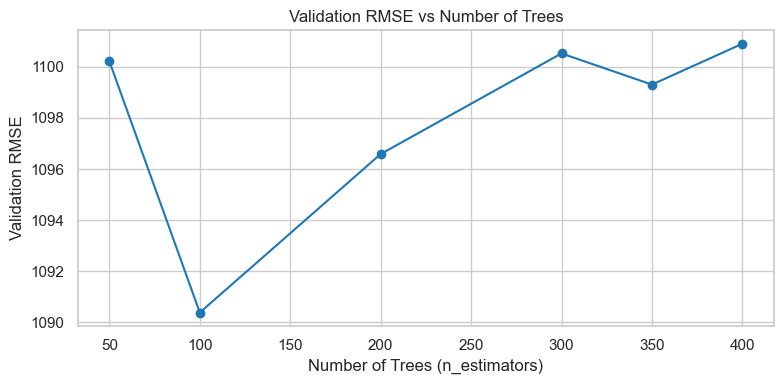

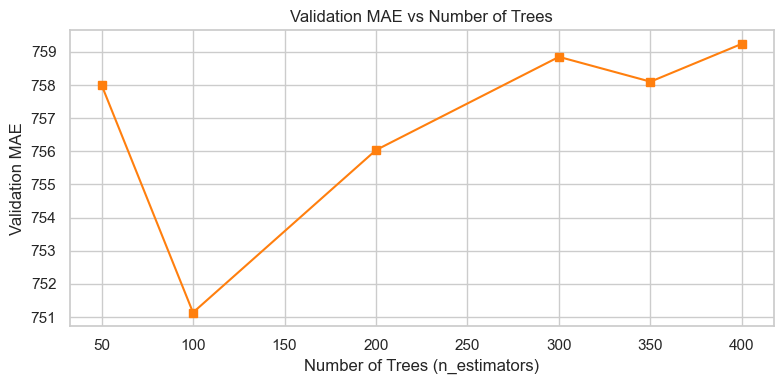


Random Forest - Test MAE: 808.71, RMSE: 1215.90
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71


In [ ]:
# Ensure datetime column is in proper format
daytime_hours['valid_time_PT'] = pd.to_datetime(daytime_hours['valid_time_PT'])

# Sort chronologically and by location
daytime_hours = daytime_hours.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Start with existing feature_cols, and remove raw cyclical time features
feature_cols = [col for col in feature_cols if col not in ['valid_month_PT', 'valid_hour_PT']]

# Add cyclical time features
feature_cols += [
    'valid_month_sin_cyclical', 'valid_month_cos_cyclical',
    'valid_hour_sin_cyclical', 'valid_hour_cos_cyclical'
]

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological)
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col]
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Label encode any categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# TimeSeries cross-validation and model tuning
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300, 350, 400]
results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', color='tab:blue')
plt.title('Validation RMSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', color='tab:orange')
plt.title('Validation MAE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final model on full training set with best tree count
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred_rf = final_model.predict(X_test)

# Evaluate on test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")


Least important features (Random Forest):
                    feature  importance
6                     prate    0.000075
10                    crain    0.000108
7                       cin    0.000698
0                      cape    0.000889
16                      veg    0.001011
4                       fsr    0.001032
24  valid_hour_sin_cyclical    0.001248
8                        tp    0.001584
25  valid_hour_cos_cyclical    0.001604
12                fricv_avg    0.002180


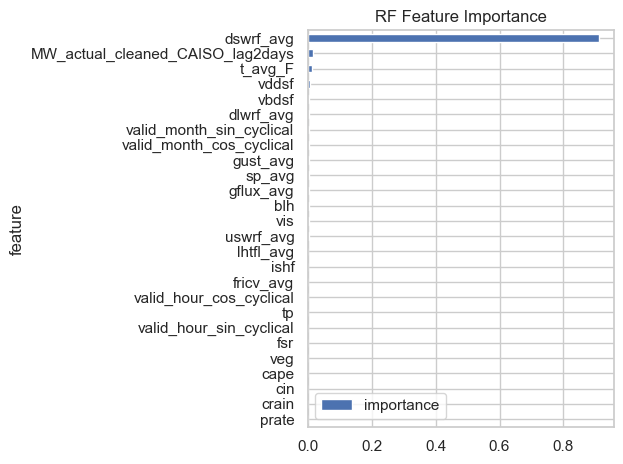


Reduced RF - Test MAE: 813.70, RMSE: 1221.78


In [ ]:
# === Feature importance using built-in method ===
importances = final_model.feature_importances_
feat_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance')

print("\nLeast important features (Random Forest):")
print(feat_importances_df.head(10))

# plot
feat_importances_df.tail(30).plot(kind='barh', x='feature', y='importance', title='RF Feature Importance')
plt.tight_layout()
plt.show()

# === Drop the bottom 5–10 and retrain ===
low_importance_features = feat_importances_df.head(10)['feature'].tolist()
reduced_features = [f for f in feature_cols if f not in low_importance_features]

# Retrain with reduced features
X_train_reduced = train_df[reduced_features].copy()
X_test_reduced = test_df[reduced_features].copy()

# Re-encode if needed
for col in categorical_cols:
    le = label_encoders[col]
    X_train_reduced[col] = le.transform(X_train_reduced[col])
    X_test_reduced[col] = le.transform(X_test_reduced[col])

# Train reduced model
rf_reduced_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
rf_reduced_model.fit(X_train_reduced, y_train)
y_pred_rf_reduced = rf_reduced_model.predict(X_test_reduced)

# Evaluate reduced model
mae_rf_reduced = mean_absolute_error(y_test, y_pred_rf_reduced)
rmse_rf_reduced = mean_squared_error(y_test, y_pred_rf_reduced, squared=False)

print(f"\nReduced RF - Test MAE: {mae_rf_reduced:.2f}, RMSE: {rmse_rf_reduced:.2f}")


This did not help for this instance. Let's try doing this on our best performing RF model.

In [228]:
daytime_hours.columns

Index(['cape', 'sp', 'blh', 'ishf', 'fsr', 'vis', 'prate', 'cin', 'tp',
       'lhtfl', 'crain', 'gust', 'fricv', 'dswrf', 'uswrf', 'dlwrf', 'veg',
       'gflux', 'vbdsf', 'vddsf', 'valid_time_PT', 't_F', 'valid_hour_PT',
       'MW_actual_cleaned_CAISO', 'MW_pred_cleaned_CAISO', 'MW_error',
       'MW_actual_cleaned_CAISO_lag2days', 'siconc_avg', 'cape_avg', 't_avg',
       'sp_avg', 'blh_avg', 'lsm_avg', 'ishf_avg', 'fsr_avg', 'vis_avg',
       'prate_avg', 'sde_avg', 'cin_avg', 'orog_avg', 'tp_avg', 'lhtfl_avg',
       'hail_avg', 'crain_avg', 'cfrzr_avg', 'cicep_avg', 'csnow_avg',
       'cpofp_avg', 'snowc_avg', 'sdwe_avg', 'gust_avg', 'fricv_avg',
       'dswrf_avg', 'uswrf_avg', 'dlwrf_avg', 'ulwrf_avg', 'bgrun_avg',
       'ssrun_avg', 'veg_avg', 'gflux_avg', 'cnwat_avg', 'frzr_avg',
       'cfnsf_avg', 'vbdsf_avg', 'vddsf_avg', 'lai_avg', 'is_dst',
       'valid_month_PT', 'valid_year_PT', 'solar_radiation_PC1', 't_avg_F',
       'point_name_Barstow', 'point_name_Blythe', 'po


Cross-validation results:
   n_estimators     val_MAE    val_RMSE  train_R2    val_R2
0            50  658.266751  961.984203  0.994469  0.915930
1           100  655.802384  957.407071  0.994694  0.916764
2           200  654.440574  953.762776  0.994827  0.917429
3           300  653.071586  951.574056  0.994855  0.917834
4           350  653.397447  952.281699  0.994863  0.917705


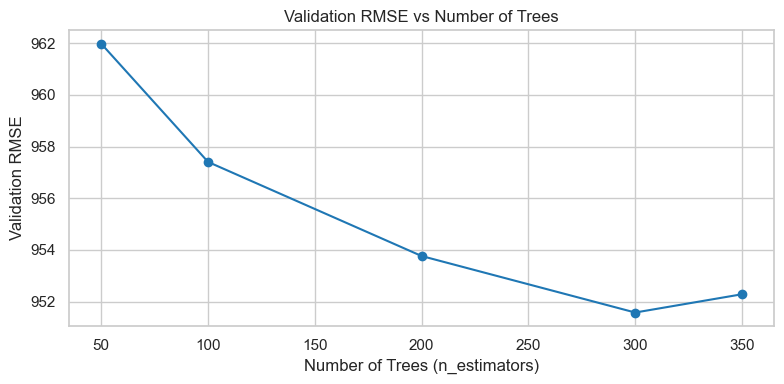

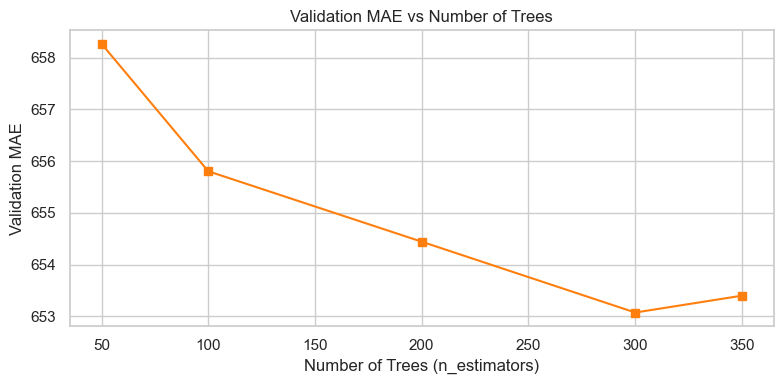


Random Forest - Test MAE: 769.52, RMSE: 1169.38
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71


In [ ]:
### BEST MODEL FOR RF ###
# Ensure datetime column is in proper format
daytime_hours['valid_time_PT'] = pd.to_datetime(daytime_hours['valid_time_PT'])

# Sort chronologically and by location
daytime_hours = daytime_hours.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological)
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col]
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Label encode any categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# TimeSeries cross-validation and model tuning
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300, 350]
results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', color='tab:blue')
plt.title('Validation RMSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', color='tab:orange')
plt.title('Validation MAE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final model on full training set with best tree count
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model_rf = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model_rf.fit(X_train, y_train)

y_pred_rf = final_model_rf.predict(X_test)

# Evaluate on test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")


Least important features (Random Forest):
          feature  importance
6           prate    0.000064
10          crain    0.000122
7             cin    0.000676
0            cape    0.000900
4             fsr    0.001176
16            veg    0.001506
8              tp    0.001953
21  valid_hour_PT    0.002007
12      fricv_avg    0.002325
17      gflux_avg    0.002592


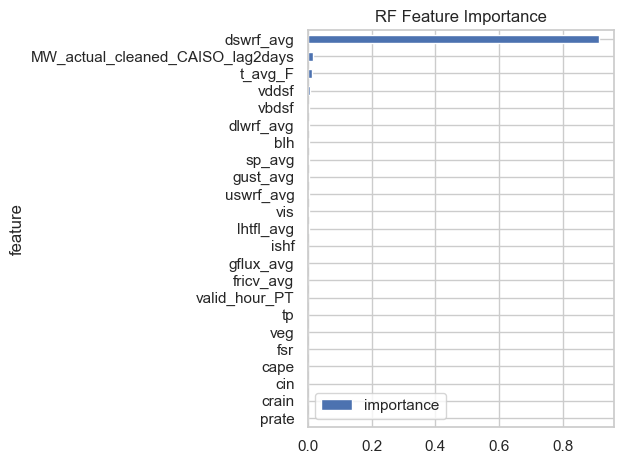


Reduced RF - Test MAE: 769.40, RMSE: 1169.52


In [ ]:
# === Feature importance using built-in method ===
importances = final_model.feature_importances_
feat_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance')

print("\nLeast important features (Random Forest):")
print(feat_importances_df.head(10))

# plot
feat_importances_df.tail(30).plot(kind='barh', x='feature', y='importance', title='RF Feature Importance')
plt.tight_layout()
plt.show()

# === Drop the bottom 5–10 and retrain ===
low_importance_features = feat_importances_df.head(5)['feature'].tolist()
reduced_features = [f for f in feature_cols if f not in low_importance_features]

# Retrain with reduced features
X_train_reduced = train_df[reduced_features].copy()
X_test_reduced = test_df[reduced_features].copy()

# Re-encode if needed
for col in categorical_cols:
    le = label_encoders[col]
    X_train_reduced[col] = le.transform(X_train_reduced[col])
    X_test_reduced[col] = le.transform(X_test_reduced[col])

# Train reduced model
rf_reduced_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
rf_reduced_model.fit(X_train_reduced, y_train)
y_pred_rf_reduced = rf_reduced_model.predict(X_test_reduced)

# Evaluate reduced model
mae_rf_reduced = mean_absolute_error(y_test, y_pred_rf_reduced)
rmse_rf_reduced = mean_squared_error(y_test, y_pred_rf_reduced, squared=False)

print(f"\nReduced RF - Test MAE: {mae_rf_reduced:.2f}, RMSE: {rmse_rf_reduced:.2f}")


Let's try one more thing. Modeling hour as cyclical but as one feature instead of two.

In [235]:
# Combine cyclical hour features into a single angle in radians
daytime_hours['valid_hour_angle'] = np.arctan2(
    daytime_hours['valid_hour_sin_cyclical'], 
    daytime_hours['valid_hour_cos_cyclical']
)

# Combine cyclical month features into a single angle in radians
daytime_hours['valid_month_angle'] = np.arctan2(
    daytime_hours['valid_month_sin_cyclical'], 
    daytime_hours['valid_month_cos_cyclical']
)



Cross-validation results:
   n_estimators     val_MAE     val_RMSE  train_R2    val_R2
0            50  722.197126  1063.329419  0.995095  0.893651
1           100  719.663020  1059.298715  0.995254  0.894553
2           200  721.224419  1061.532913  0.995380  0.893818
3           300  721.855947  1062.479400  0.995405  0.893554
4           350  721.899819  1061.771969  0.995414  0.893820
5           400  721.339348  1060.660245  0.995427  0.894096


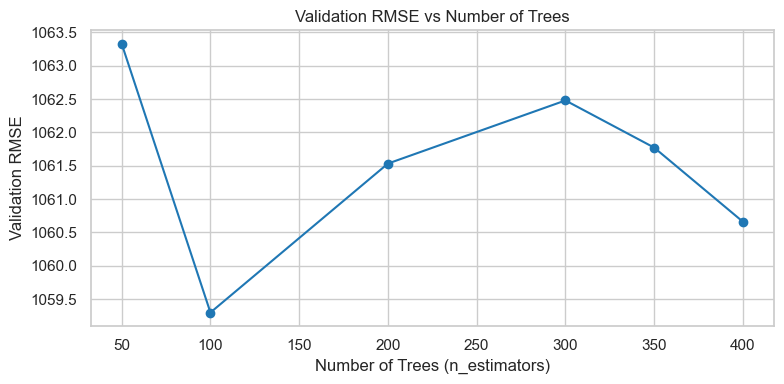

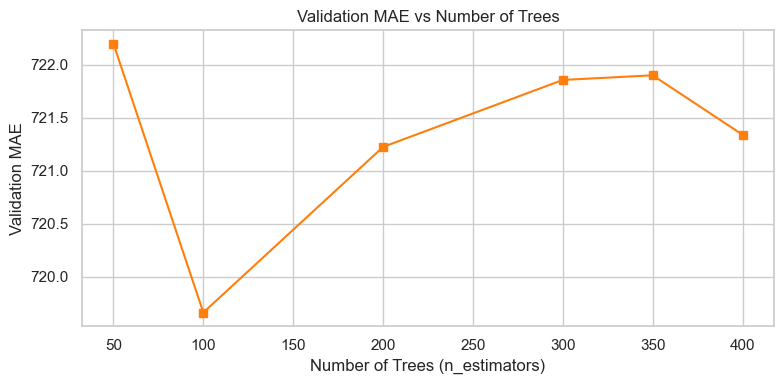


Random Forest - Test MAE: 790.55, RMSE: 1191.51
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71


In [ ]:
# Ensure datetime column is in proper format
daytime_hours['valid_time_PT'] = pd.to_datetime(daytime_hours['valid_time_PT'])

# Sort chronologically and by location
daytime_hours = daytime_hours.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Start with existing feature_cols, and remove raw cyclical time features
feature_cols = [col for col in feature_cols if col not in ['valid_month_PT', 'valid_hour_PT']]

# Add cyclical time features
feature_cols += [
    'valid_hour_angle', 'valid_month_angle'
]

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological)
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col]
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Label encode any categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# TimeSeries cross-validation and model tuning
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300, 350, 400]
results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', color='tab:blue')
plt.title('Validation RMSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', color='tab:orange')
plt.title('Validation MAE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final model on full training set with best tree count
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred_rf = final_model.predict(X_test)

# Evaluate on test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")


Least important features (Random Forest):
             feature  importance
6              prate    0.000060
10             crain    0.000075
7                cin    0.000652
0               cape    0.000872
4                fsr    0.001016
16               veg    0.001289
8                 tp    0.001715
12         fricv_avg    0.002262
3               ishf    0.002445
22  valid_hour_angle    0.002632


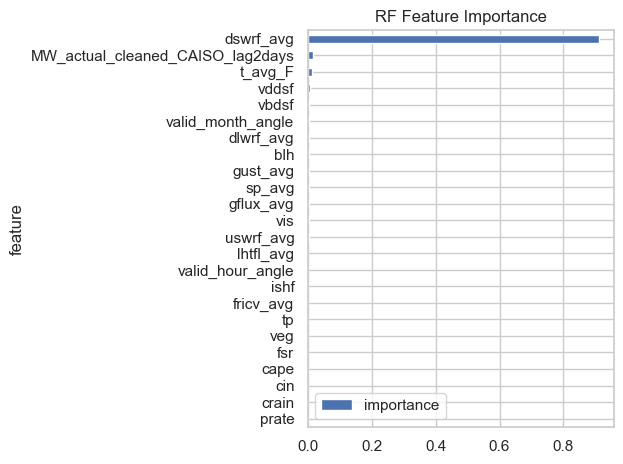


Reduced RF - Test MAE: 790.04, RMSE: 1191.37


In [ ]:
# === Feature importance using built-in method ===
importances = final_model.feature_importances_
feat_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance')

print("\nLeast important features (Random Forest):")
print(feat_importances_df.head(10))

# plot
feat_importances_df.tail(30).plot(kind='barh', x='feature', y='importance', title='RF Feature Importance')
plt.tight_layout()
plt.show()

# === Drop the bottom 5–10 and retrain ===
low_importance_features = feat_importances_df.head(5)['feature'].tolist()
reduced_features = [f for f in feature_cols if f not in low_importance_features]

# Retrain with reduced features
X_train_reduced = train_df[reduced_features].copy()
X_test_reduced = test_df[reduced_features].copy()

# Re-encode if needed
for col in categorical_cols:
    le = label_encoders[col]
    X_train_reduced[col] = le.transform(X_train_reduced[col])
    X_test_reduced[col] = le.transform(X_test_reduced[col])

# Train reduced model
rf_reduced_model = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
rf_reduced_model.fit(X_train_reduced, y_train)
y_pred_rf_reduced = rf_reduced_model.predict(X_test_reduced)

# Evaluate reduced model
mae_rf_reduced = mean_absolute_error(y_test, y_pred_rf_reduced)
rmse_rf_reduced = mean_squared_error(y_test, y_pred_rf_reduced, squared=False)

print(f"\nReduced RF - Test MAE: {mae_rf_reduced:.2f}, RMSE: {rmse_rf_reduced:.2f}")


Let's go back to XGBoost and try to use hyperparameter values that we got from an earlier run in a different notebook. Cell 27 in Damage Control notebook.

In [ ]:
# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error", 'valid_hour_PT', 'valid_month_PT']
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Add month, year, and new one-hot columns to feature list
feature_cols += [col for col in daytime_hours.columns if col.startswith('point_name_')]
feature_cols += ['valid_hour_angle', 'valid_month_angle']

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/Test Split 
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()
y_pred_existing = test_df[benchmark_col].copy()

# Instantiate and fit XGBoost with specified parameters
xgb_model = XGBRegressor(
    objective='reg:absoluteerror',
    colsample_bytree=0.6,
    gamma=0,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    n_estimators=200,
    subsample=0.6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)

mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
mae_benchmark = mean_absolute_error(y_test, y_pred_existing)
rmse_benchmark = np.sqrt(mean_squared_error(y_test, y_pred_existing))

print(f"Model MAE: {mae_model:.2f}")
print(f"Model RMSE: {rmse_model:.2f}")
print(f"Benchmark MAE: {mae_benchmark:.2f}")
print(f"Benchmark RMSE: {rmse_benchmark:.2f}")


Model MAE: 735.08
Model RMSE: 1108.83
Benchmark MAE: 763.86
Benchmark RMSE: 1267.71


In [ ]:
# Use best params found from GridSearchCVs
best_params_mae = {'n_estimators': 200,  
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'gamma': 0,
    'min_child_weight': 3}  # from MAE-optimized model

# Fit each model on the full training data
xgb_mae = XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1, **best_params_mae)
xgb_mae.fit(X_train, y_train)

# ---- Walk-forward test evaluation ---- #
test_size = len(test_df)
window_size = test_size // 4  # 4 evaluation windows
results = []

for i in range(4):
    start = i * window_size
    end = (i + 1) * window_size if i < 3 else test_size
    
    print(f"Window {i+1}: start={start}, end={end}, size={end - start}")

    X_window = X_test.iloc[start:end]
    y_window = y_test.iloc[start:end]
    benchmark_window = y_pred_existing.iloc[start:end]
    
    pred_mae = xgb_mae.predict(X_window)

    mae_mae = mean_absolute_error(y_window, pred_mae)

    rmse_mae = np.sqrt(mean_squared_error(y_window, pred_mae))
    
    benchmark_mae = mean_absolute_error(y_window, benchmark_window)

    results.append({
        'Window': f'{i+1}',
        'MAE Model - MAE': mae_mae,
        'Benchmark - MAE': benchmark_mae,
        'MAE Model - RMSE': rmse_mae,
        'Benchmark - RMSE': benchmark_rmse,
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# average across all windows
print("\nAverage Performance Across All Windows:")
print(results_df.iloc[:, 1:].mean())

Window 1: start=0, end=1986, size=1986
Window 2: start=1986, end=3972, size=1986
Window 3: start=3972, end=5958, size=1986
Window 4: start=5958, end=7947, size=1989
  Window  MAE Model - MAE  Benchmark - MAE  MAE Model - RMSE  Benchmark - RMSE
0      1       528.331207       492.593729        868.768440       1785.345994
1      2       684.344708       402.719595       1086.413226       1785.345994
2      3       819.573149       940.776449       1207.886114       1785.345994
3      4       907.813471      1218.674100       1234.296698       1785.345994

Average Performance Across All Windows:
MAE Model - MAE      735.015634
Benchmark - MAE      763.690968
MAE Model - RMSE    1099.341120
Benchmark - RMSE    1785.345994
dtype: float64


In [ ]:
# Predictions
y_train_pred = xgb_mae.predict(X_train)
y_test_pred = xgb_mae.predict(X_test)

# Training performance
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Test performance
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print results
print("\n--- XGBoost Model Performance ---")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

print(f"\nMAE Overfitting Ratio (Test / Train): {test_mae / train_mae:.2f}")
print(f"RMSE Overfitting Ratio (Test / Train): {test_rmse / train_rmse:.2f}")



--- XGBoost Model Performance ---
Train MAE: 396.579
Train RMSE: 675.969
Test MAE:  735.081
Test RMSE: 1108.825

MAE Overfitting Ratio (Test / Train): 1.85
RMSE Overfitting Ratio (Test / Train): 1.64


Looks like I'm overfitting. Let's tweak some parameters and re-analyze.

In [ ]:
# Use best params that I am manually changing to prevent overfitting. Aiming to beat benchmark error metrics and minimize test:train ratio
best_params_mae = {'n_estimators': 145,  
    'learning_rate': 0.03,
    'max_depth': 3,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'gamma': 1,
    'min_child_weight': 7}  

# Fit each model on the full training data
xgb_mae = XGBRegressor(objective='reg:absoluteerror', random_state=42, n_jobs=-1, **best_params_mae)
xgb_mae.fit(X_train, y_train)

# ---- Walk-forward test evaluation ---- #
test_size = len(test_df)
window_size = test_size // 4  # 4 evaluation windows
results = []

for i in range(4):
    start = i * window_size
    end = (i + 1) * window_size if i < 3 else test_size  
    
    print(f"Window {i+1}: start={start}, end={end}, size={end - start}")

    X_window = X_test.iloc[start:end]
    y_window = y_test.iloc[start:end]
    benchmark_window = y_pred_existing.iloc[start:end]
    
    pred_mae = xgb_mae.predict(X_window)

    mae_mae = mean_absolute_error(y_window, pred_mae)

    rmse_mae = np.sqrt(mean_squared_error(y_window, pred_mae))
    
    benchmark_mae = mean_absolute_error(y_window, benchmark_window)

    results.append({
        'Window': f'{i+1}',
        'MAE Model - MAE': mae_mae,
        'Benchmark - MAE': benchmark_mae,
        'MAE Model - RMSE': rmse_mae,
        'Benchmark - RMSE': benchmark_rmse,
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# average across all windows
print("\nAverage Performance Across All Windows:")
print(results_df.iloc[:, 1:].mean())

Window 1: start=0, end=1986, size=1986
Window 2: start=1986, end=3972, size=1986
Window 3: start=3972, end=5958, size=1986
Window 4: start=5958, end=7947, size=1989
  Window  MAE Model - MAE  Benchmark - MAE  MAE Model - RMSE  Benchmark - RMSE
0      1       600.124075       492.593729        920.689553       1785.345994
1      2       682.455412       402.719595       1036.773374       1785.345994
2      3       789.900565       940.776449       1177.197090       1785.345994
3      4       948.041451      1218.674100       1287.185501       1785.345994

Average Performance Across All Windows:
MAE Model - MAE      755.130376
Benchmark - MAE      763.690968
MAE Model - RMSE    1105.461379
Benchmark - RMSE    1785.345994
dtype: float64


In [ ]:
# Predictions
y_train_pred = xgb_mae.predict(X_train)
y_test_pred = xgb_mae.predict(X_test)

# Training performance
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Test performance
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print results
print("\n--- XGBoost Model Performance ---")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

print(f"\nMAE Overfitting Ratio (Test / Train): {test_mae / train_mae:.2f}")
print(f"RMSE Overfitting Ratio (Test / Train): {test_rmse / train_rmse:.2f}")



--- XGBoost Model Performance ---
Train MAE: 537.867
Train RMSE: 841.954
Test MAE:  755.203
Test RMSE: 1114.208

MAE Overfitting Ratio (Test / Train): 1.40
RMSE Overfitting Ratio (Test / Train): 1.32


### Model Comparisons

Let's use the best models from RF and XGBoost.

#### Best Random Forest Model


Cross-validation results:
   n_estimators     val_MAE    val_RMSE  train_R2    val_R2
0            50  658.266751  961.984203  0.994469  0.915930
1           100  655.802384  957.407071  0.994694  0.916764
2           200  654.440574  953.762776  0.994827  0.917429
3           300  653.071586  951.574056  0.994855  0.917834
4           350  653.397447  952.281699  0.994863  0.917705


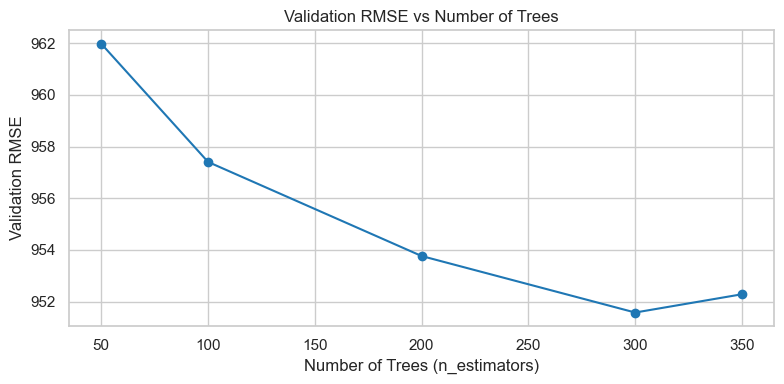

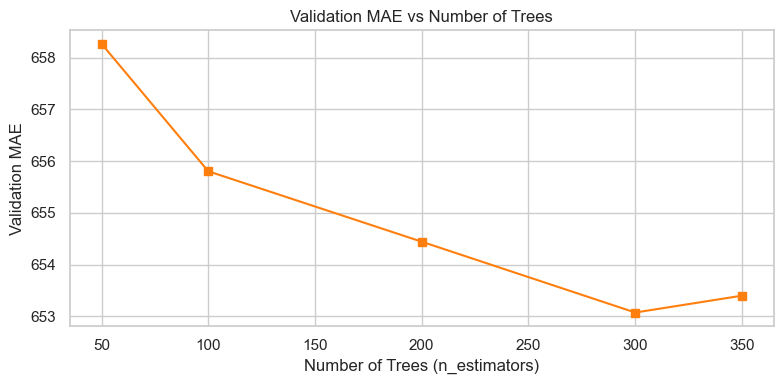


Random Forest - Test MAE: 769.52, RMSE: 1169.38
Existing Predictions - Test MAE: 763.86, RMSE: 1267.71


In [ ]:
# Ensure datetime column is in proper format
daytime_hours['valid_time_PT'] = pd.to_datetime(daytime_hours['valid_time_PT'])

# Sort chronologically and by location
daytime_hours = daytime_hours.sort_values(['valid_time_PT', 'point_name']).reset_index(drop=True)

# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error"]
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/test split (chronological)
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col]
X_test = test_df[feature_cols].copy()
y_test = test_df[target_col]
y_pred_existing = test_df[benchmark_col]

# Label encode any categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# TimeSeries cross-validation and model tuning
tscv = TimeSeriesSplit(n_splits=5)
n_estimators_list = [50, 100, 200, 300, 350]
results = []

for n in n_estimators_list:
    fold_maes = []
    fold_rmses = []
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
        model.fit(X_t, y_t)

        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_t)

        fold_maes.append(mean_absolute_error(y_val, y_val_pred))
        fold_rmses.append(mean_squared_error(y_val, y_val_pred, squared=False))
        fold_train_scores.append(model.score(X_t, y_t))
        fold_val_scores.append(model.score(X_val, y_val))

    results.append({
        'n_estimators': n,
        'val_MAE': np.mean(fold_maes),
        'val_RMSE': np.mean(fold_rmses),
        'train_R2': np.mean(fold_train_scores),
        'val_R2': np.mean(fold_val_scores)
    })

results_df = pd.DataFrame(results)
print("\nCross-validation results:")
print(results_df)

# Plot RMSE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_RMSE'], marker='o', color='tab:blue')
plt.title('Validation RMSE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot MAE vs number of trees
plt.figure(figsize=(8, 4))
plt.plot(results_df['n_estimators'], results_df['val_MAE'], marker='s', color='tab:orange')
plt.title('Validation MAE vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final model on full training set with best tree count
best_n = results_df.sort_values("val_RMSE").iloc[0]["n_estimators"]
final_model_rf = RandomForestRegressor(n_estimators=int(best_n), random_state=42, n_jobs=-1)
final_model_rf.fit(X_train, y_train)

y_pred_rf = final_model_rf.predict(X_test)

# Evaluate on test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_existing = mean_absolute_error(y_test, y_pred_existing)
rmse_existing = mean_squared_error(y_test, y_pred_existing, squared=False)

print(f"\nRandom Forest - Test MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"Existing Predictions - Test MAE: {mae_existing:.2f}, RMSE: {rmse_existing:.2f}")

#### Best XGBoost Model

In [ ]:
# Substitution mapping
feature_subs = {
    't_F': 't_avg_F',
    'sp': 'sp_avg',
    'dswrf': 'dswrf_avg',
    'uswrf': 'uswrf_avg',
    'dlwrf': 'dlwrf_avg',
    'ulwrf': 'ulwrf_avg',
    'gflux': 'gflux_avg',
    'lhtfl': 'lhtfl_avg',
    'fricv': 'fricv_avg',
    'gust': 'gust_avg'
}

# Define boundaries for relevant features
exclude_cols = ["valid_time_PT", "MW_actual_cleaned_CAISO", "MW_pred_cleaned_CAISO", "MW_error", 'valid_hour_PT', 'valid_month_PT']
cape_idx = daytime_hours.columns.get_loc("cape")
lag2_idx = daytime_hours.columns.get_loc("MW_actual_cleaned_CAISO_lag2days")
all_cols = daytime_hours.columns[cape_idx:lag2_idx + 1].tolist()

# Apply substitutions to feature list
feature_cols = []
for col in all_cols:
    if col in exclude_cols:
        continue
    elif col in feature_subs:
        feature_cols.append(feature_subs[col])
    else:
        feature_cols.append(col)

# Add month, year, and new one-hot columns to feature list
feature_cols += [col for col in daytime_hours.columns if col.startswith('point_name_')]
feature_cols += ['valid_hour_angle', 'valid_month_angle']

# Target variables
target_col = "MW_actual_cleaned_CAISO"
benchmark_col = "MW_pred_cleaned_CAISO"

# Train/Test Split 
split_index = int(len(daytime_hours) * 0.8)
train_df = daytime_hours.iloc[:split_index]
test_df = daytime_hours.iloc[split_index:]

X_train_xgb = train_df[feature_cols].copy()
y_train_xgb = train_df[target_col].copy()
X_test_xgb = test_df[feature_cols].copy()
y_test_xgb = test_df[target_col].copy()
y_pred_existing = test_df[benchmark_col].copy()

# Instantiate and fit XGBoost with specified parameters
xgb_model = XGBRegressor(
    objective='reg:absoluteerror',
    colsample_bytree=0.5,
    gamma=1,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=7,
    n_estimators=145,
    subsample=0.4,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict and evaluate
y_pred = xgb_model.predict(X_test_xgb)

mae_model = mean_absolute_error(y_test_xgb, y_pred)
rmse_model = np.sqrt(mean_squared_error(y_test_xgb, y_pred))
mae_benchmark = mean_absolute_error(y_test_xgb, y_pred_existing)
rmse_benchmark = np.sqrt(mean_squared_error(y_test_xgb, y_pred_existing))

print(f"Model MAE: {mae_model:.2f}")
print(f"Model RMSE: {rmse_model:.2f}")
print(f"Benchmark MAE: {mae_benchmark:.2f}")
print(f"Benchmark RMSE: {rmse_benchmark:.2f}")


# ---- Walk-forward test evaluation ---- #
test_size = len(test_df)
window_size = test_size // 4  # 4 evaluation windows
results = []

for i in range(4):
    start = i * window_size
    end = (i + 1) * window_size if i < 3 else test_size 
    
    print(f"Window {i+1}: start={start}, end={end}, size={end - start}")

    X_window = X_test_xgb.iloc[start:end]
    y_window = y_test_xgb.iloc[start:end]
    benchmark_window = y_pred_existing.iloc[start:end]
    
    y_preds = xgb_model.predict(X_window)

    mae_xgb = mean_absolute_error(y_window, y_preds)

    rmse_xgb = np.sqrt(mean_squared_error(y_window, y_preds))
    
    benchmark_mae = mean_absolute_error(y_window, benchmark_window)

    results.append({
        'Window': f'{i+1}',
        'MAE Model - MAE': mae_xgb,
        'Benchmark - MAE': benchmark_mae,
        'MAE Model - RMSE': rmse_xgb,
        'Benchmark - RMSE': benchmark_rmse,
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# average across all windows
print("\nAverage Performance Across All Windows:")
print(results_df.iloc[:, 1:].mean())

Model MAE: 760.24
Model RMSE: 1119.15
Benchmark MAE: 763.86
Benchmark RMSE: 1267.71
Window 1: start=0, end=1986, size=1986
Window 2: start=1986, end=3972, size=1986
Window 3: start=3972, end=5958, size=1986
Window 4: start=5958, end=7947, size=1989
  Window  MAE Model - MAE  Benchmark - MAE  MAE Model - RMSE  Benchmark - RMSE
0      1       595.288832       492.593729        912.350974       1785.345994
1      2       680.845417       402.719595       1037.240065       1785.345994
2      3       798.896300       940.776449       1180.970382       1785.345994
3      4       965.620058      1218.674100       1306.292013       1785.345994

Average Performance Across All Windows:
MAE Model - MAE      760.162652
Benchmark - MAE      763.690968
MAE Model - RMSE    1109.213359
Benchmark - RMSE    1785.345994
dtype: float64


In [ ]:
# Predictions
ytrain_pred = xgb_model.predict(X_train)
ytest_pred = xgb_model.predict(X_test)

# Training performance
train_mae = mean_absolute_error(y_train, ytrain_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, ytrain_pred))

# Test performance
test_mae = mean_absolute_error(y_test, ytest_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, ytest_pred))

# Print results
print("\n--- XGBoost Model Performance ---")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

print(f"\nMAE Overfitting Ratio (Test / Train): {test_mae / train_mae:.2f}")
print(f"RMSE Overfitting Ratio (Test / Train): {test_rmse / train_rmse:.2f}")



--- XGBoost Model Performance ---
Train MAE: 536.680
Train RMSE: 841.259
Test MAE:  760.240
Test RMSE: 1119.154

MAE Overfitting Ratio (Test / Train): 1.42
RMSE Overfitting Ratio (Test / Train): 1.33


Performance Visualizations

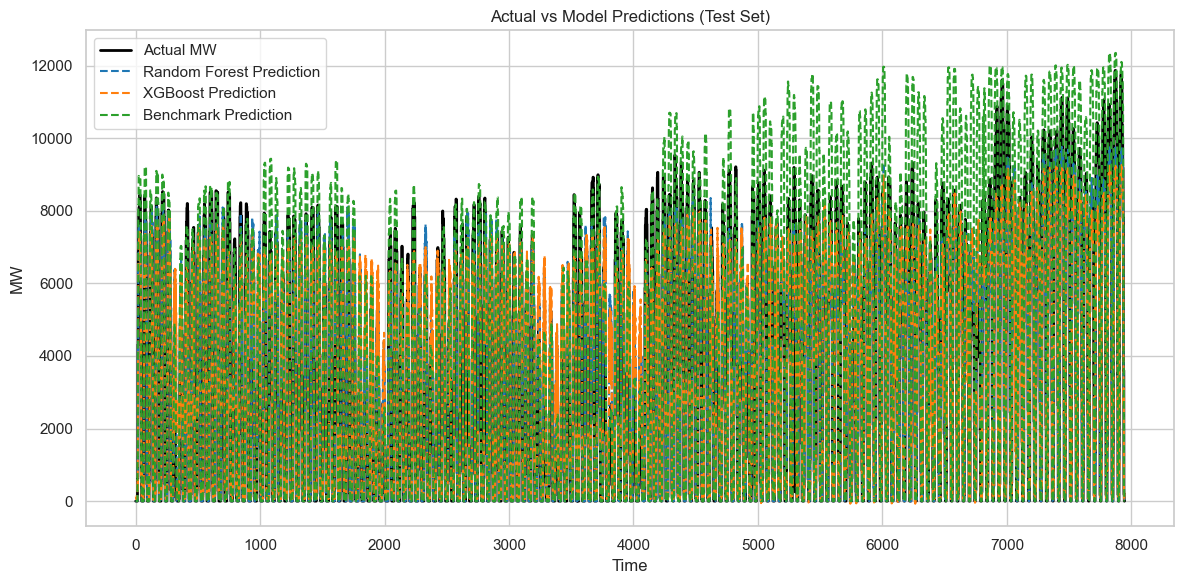

In [347]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual MW', color='black', linewidth=2)
plt.plot(y_pred_rf, label='Random Forest Prediction', linestyle='--', color='tab:blue')
plt.plot(ytest_pred, label='XGBoost Prediction', linestyle='--', color='tab:orange')
plt.plot(y_pred_existing.values, label='Benchmark Prediction', linestyle='--', color='tab:green')

plt.title('Actual vs Model Predictions (Test Set)')
plt.xlabel('Time')
plt.ylabel('MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Okay, this is an absolutely heinous visual lol.

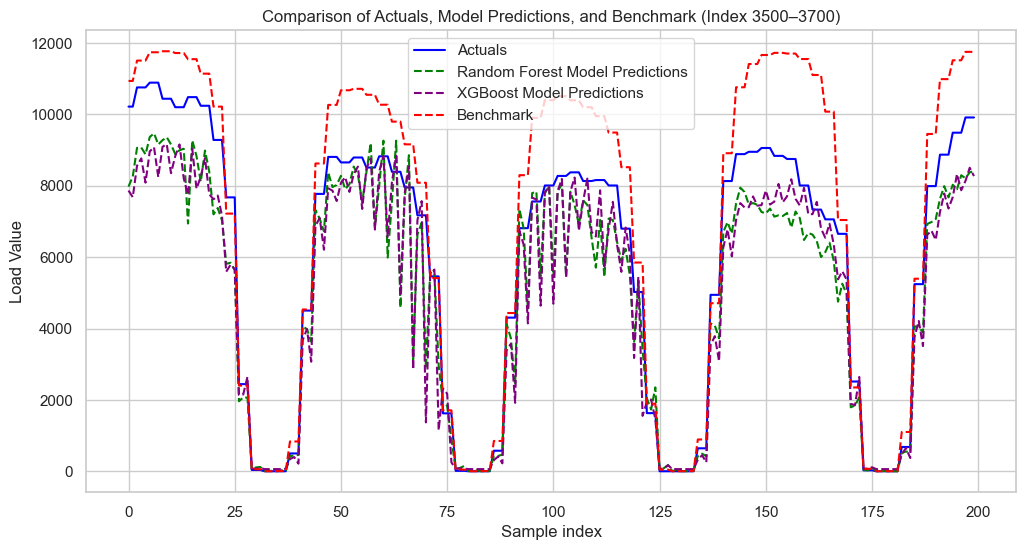

In [ ]:
# Sample for visualization: 200 values starting at specified
start_index = 7000
sample_size = 200
end_index = start_index + sample_size
indices = range(sample_size)  # x-axis range

plt.figure(figsize=(12, 6))

# Plot actuals
plt.plot(indices, y_test.values[start_index:end_index], label="Actuals", color="blue")

# Plot Random Forest model predictions
plt.plot(indices, y_pred_rf[start_index:end_index], label="Random Forest Model Predictions", color="green", linestyle="--")

# Plot XGBoost predictions
plt.plot(indices, ytest_pred[start_index:end_index], label="XGBoost Model Predictions", color="purple", linestyle="--")

# Plot benchmark
plt.plot(indices, y_pred_existing.values[start_index:end_index], label="Benchmark", color="red", linestyle="--")

plt.title("Comparison of Actuals, Model Predictions, and Benchmark (Index 3500–3700)")
plt.xlabel("Sample index")
plt.ylabel("Load Value")
plt.legend()
plt.show()


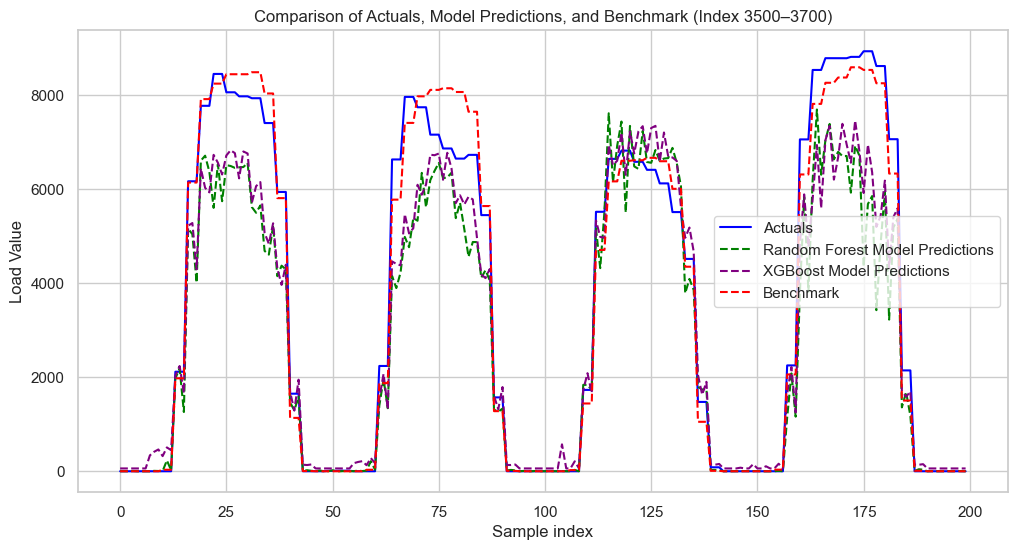

In [ ]:
# Sample for visualization: 200 values starting at index 3500
start_index = 3500
sample_size = 200
end_index = start_index + sample_size
indices = range(sample_size)  # x-axis range

plt.figure(figsize=(12, 6))

# Plot actuals
plt.plot(indices, y_test.values[start_index:end_index], label="Actuals", color="blue")

# Plot Random Forest model predictions
plt.plot(indices, y_pred_rf[start_index:end_index], label="Random Forest Model Predictions", color="green", linestyle="--")

# Plot XGBoost predictions
plt.plot(indices, ytest_pred[start_index:end_index], label="XGBoost Model Predictions", color="purple", linestyle="--")

# Plot benchmark
plt.plot(indices, y_pred_existing.values[start_index:end_index], label="Benchmark", color="red", linestyle="--")

plt.title("Comparison of Actuals, Model Predictions, and Benchmark (Index 3500–3700)")
plt.xlabel("Sample index")
plt.ylabel("Load Value")
plt.legend()
plt.show()


In [350]:
# Combine full-length arrays into a DataFrame
full_comparison_df = pd.DataFrame({
    'Actuals': y_test.values,
    'Random Forest Predictions': y_pred_rf,
    'XGBoost Predictions': ytest_pred,
    'Benchmark Predictions': y_pred_existing.values
})

# Show the first and last 10 values
print("First 10 values:")
print(full_comparison_df.head(20))

print("\nLast 10 values:")
print(full_comparison_df.tail(10))


First 10 values:
       Actuals  Random Forest Predictions  XGBoost Predictions  \
0      0.00000                   2.037747           132.096344   
1      0.00000                   0.599846           132.096344   
2      0.00000                   1.535799           132.096344   
3      0.00000                   1.154394            59.713299   
4      0.00000                   1.044020            59.713299   
5      0.00000                   1.073484            59.713299   
6      0.00000                   0.010783            59.713299   
7      0.00000                   2.564216            59.713299   
8      0.00000                   2.070824            59.713299   
9      0.00000                   0.408862            59.713299   
10     0.00000                   2.466625            59.713299   
11     0.00000                   0.292271            59.713299   
12     0.00000                   0.138587            59.713299   
13     0.00000                   0.349434            59.713

A thought - Let's try to average predictions across the three locations and have only prediction per hour. Could even weight this by solar farm capacity of the three centroids if I really want.

In [ ]:
# Make a copy of your dataframe
df = full_comparison_df.copy()

# Reshape by grouping every 3 rows
avg_df = pd.DataFrame({
    'Actuals': df['Actuals'].groupby(df.index // 3).first(), 
    'Benchmark': df['Benchmark Predictions'].groupby(df.index // 3).first(),
    'RF_Avg_Prediction': df['Random Forest Predictions'].groupby(df.index // 3).mean(),
    'XGB_Avg_Prediction': df['XGBoost Predictions'].groupby(df.index // 3).mean()
})

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("MAE (Random Forest):", mean_absolute_error(avg_df['Actuals'], avg_df['RF_Avg_Prediction']))
print("RMSE (Random Forest):", np.sqrt(mean_squared_error(avg_df['Actuals'], avg_df['RF_Avg_Prediction'])))
print()

print("MAE (XGBoost):", mean_absolute_error(avg_df['Actuals'], avg_df['XGB_Avg_Prediction']))
print("RMSE (XGBoost):", np.sqrt(mean_squared_error(avg_df['Actuals'], avg_df['XGB_Avg_Prediction'])))
print()

print("MAE (Benchmark):", mean_absolute_error(avg_df['Actuals'], avg_df['Benchmark']))
print("RMSE (Benchmark):", np.sqrt(mean_squared_error(avg_df['Actuals'], avg_df['Benchmark'])))


MAE (Random Forest): 738.6947853175748
RMSE (Random Forest): 1102.7441916747305

MAE (XGBoost): 735.4521278014084
RMSE (XGBoost): 1057.0155697480561

MAE (Benchmark): 763.8627249943376
RMSE (Benchmark): 1267.7133669556688


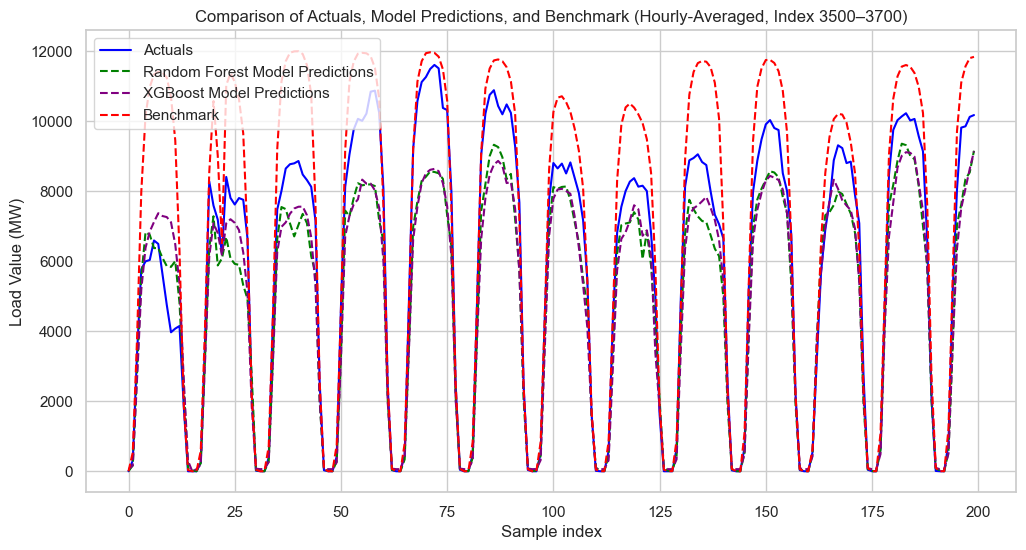

In [ ]:
# Sample for visualization: 200 values starting at specified index
start_index = 2249
sample_size = 200
end_index = start_index + sample_size
indices = range(sample_size)  # x-axis range for plotting

plt.figure(figsize=(12, 6))

# Plot Actuals
plt.plot(indices, avg_df['Actuals'].iloc[start_index:end_index], label="Actuals", color="blue")

# Plot Random Forest averaged predictions
plt.plot(indices, avg_df['RF_Avg_Prediction'].iloc[start_index:end_index], label="Random Forest Model Predictions", color="green", linestyle="--")

# Plot XGBoost averaged predictions
plt.plot(indices, avg_df['XGB_Avg_Prediction'].iloc[start_index:end_index], label="XGBoost Model Predictions", color="purple", linestyle="--")

# Plot Benchmark predictions
plt.plot(indices, avg_df['Benchmark'].iloc[start_index:end_index], label="Benchmark", color="red", linestyle="--")

plt.title("Comparison of Actuals, Model Predictions, and Benchmark (Hourly-Averaged, Index 3500–3700)")
plt.xlabel("Sample index")
plt.ylabel("Load Value (MW)")
plt.legend()
plt.show()


In [ ]:
# Make a copy of your dataframe
df = full_comparison_df.copy()

# Reshape by grouping every 3 rows
avg_df = pd.DataFrame({
    'Actuals': df['Actuals'].groupby(df.index // 3).first(), 
    'Benchmark': df['Benchmark Predictions'].groupby(df.index // 3).first(),
    'RF_Avg_Prediction': df['Random Forest Predictions'].groupby(df.index // 3).mean(),
    'XGB_Avg_Prediction': df['XGBoost Predictions'].groupby(df.index // 3).mean()
})

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("=== Averaged Predictions ===")
print("MAE (Random Forest):", mean_absolute_error(avg_df['Actuals'], avg_df['RF_Avg_Prediction']))
print("RMSE (Random Forest):", np.sqrt(mean_squared_error(avg_df['Actuals'], avg_df['RF_Avg_Prediction'])))
print()

print("MAE (XGBoost):", mean_absolute_error(avg_df['Actuals'], avg_df['XGB_Avg_Prediction']))
print("RMSE (XGBoost):", np.sqrt(mean_squared_error(avg_df['Actuals'], avg_df['XGB_Avg_Prediction'])))
print()

print("MAE (Benchmark):", mean_absolute_error(avg_df['Actuals'], avg_df['Benchmark']))
print("RMSE (Benchmark):", np.sqrt(mean_squared_error(avg_df['Actuals'], avg_df['Benchmark'])))
print()

# Evaluate on full (pre-averaged) data
print("=== Original (Pre-Averaged) Predictions ===")
print("MAE (Random Forest):", mean_absolute_error(df['Actuals'], df['Random Forest Predictions']))
print("RMSE (Random Forest):", np.sqrt(mean_squared_error(df['Actuals'], df['Random Forest Predictions'])))
print()

print("MAE (XGBoost):", mean_absolute_error(df['Actuals'], df['XGBoost Predictions']))
print("RMSE (XGBoost):", np.sqrt(mean_squared_error(df['Actuals'], df['XGBoost Predictions'])))
print()

print("MAE (Benchmark):", mean_absolute_error(df['Actuals'], df['Benchmark Predictions']))
print("RMSE (Benchmark):", np.sqrt(mean_squared_error(df['Actuals'], df['Benchmark Predictions'])))


=== Averaged Predictions ===
MAE (Random Forest): 738.6947853175748
RMSE (Random Forest): 1102.7441916747305

MAE (XGBoost): 735.4521278014084
RMSE (XGBoost): 1057.0155697480561

MAE (Benchmark): 763.8627249943376
RMSE (Benchmark): 1267.7133669556688

=== Original (Pre-Averaged) Predictions ===
MAE (Random Forest): 769.522220739604
RMSE (Random Forest): 1169.377161104371

MAE (XGBoost): 760.2402121851117
RMSE (XGBoost): 1119.154452865237

MAE (Benchmark): 763.8627249943374
RMSE (Benchmark): 1267.7133669556688


Nice! As expected, this leaves the benchmark values unchanged and improves both error metrics for random forest and XGBoost. 

### Let's look at variable importance metrics as well as visualizing error.

##### Random Forest

In [357]:

importances = final_model_rf.feature_importances_
feature_names = X_train.columns

# Create a sorted DataFrame
importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df_rf.head(10))  # Top 10 features


                             Feature  Importance
13                         dswrf_avg    0.912966
22  MW_actual_cleaned_CAISO_lag2days    0.016921
20                           t_avg_F    0.015122
19                             vddsf    0.008315
18                             vbdsf    0.005720
15                         dlwrf_avg    0.004330
2                                blh    0.003895
1                             sp_avg    0.003552
11                          gust_avg    0.003538
14                         uswrf_avg    0.003314


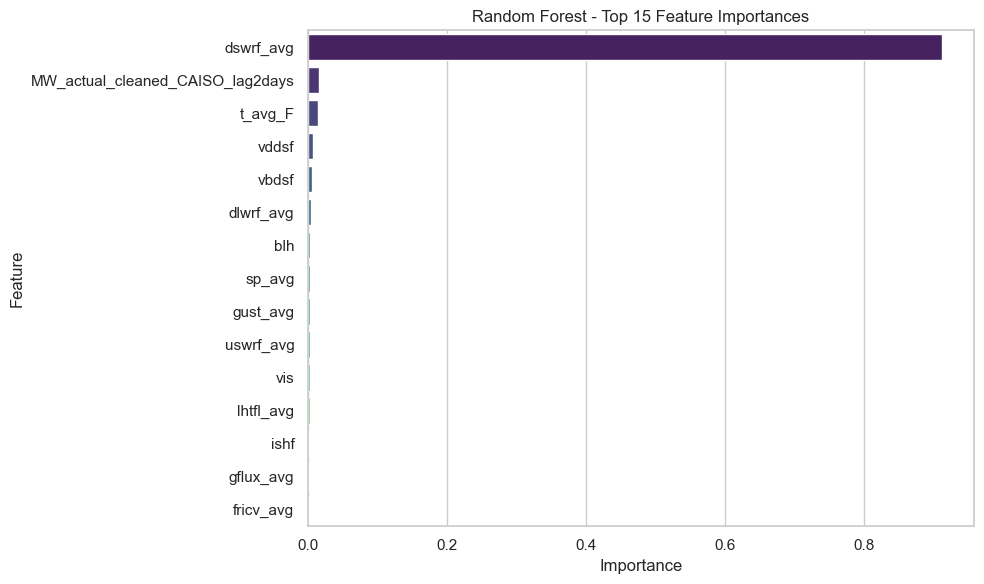

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_rf.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest - Top 15 Feature Importances')
plt.tight_layout()
plt.show()


wow.

##### XGBoost

In [360]:
xgbimportances = xgb_model.feature_importances_
feature_names = X_train_xgb.columns

# Create a sorted DataFrame
xgbimportance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgbimportances
}).sort_values(by='Importance', ascending=False)

print(xgbimportance_df.head(10))  # Top 10 features

                             Feature  Importance
13                         dswrf_avg    0.202575
14                         uswrf_avg    0.163092
19                             vddsf    0.150474
17                         gflux_avg    0.133353
18                             vbdsf    0.069432
3                               ishf    0.063616
21  MW_actual_cleaned_CAISO_lag2days    0.044758
25                  valid_hour_angle    0.041219
20                           t_avg_F    0.022447
8                                 tp    0.012082


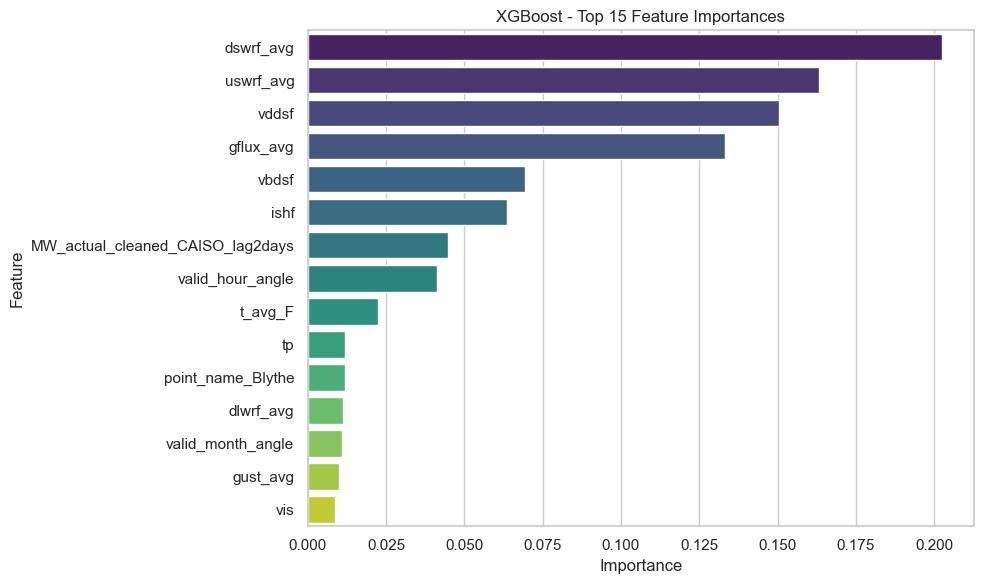

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=xgbimportance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost - Top 15 Feature Importances')
plt.tight_layout()
plt.show()


#### Error visuals

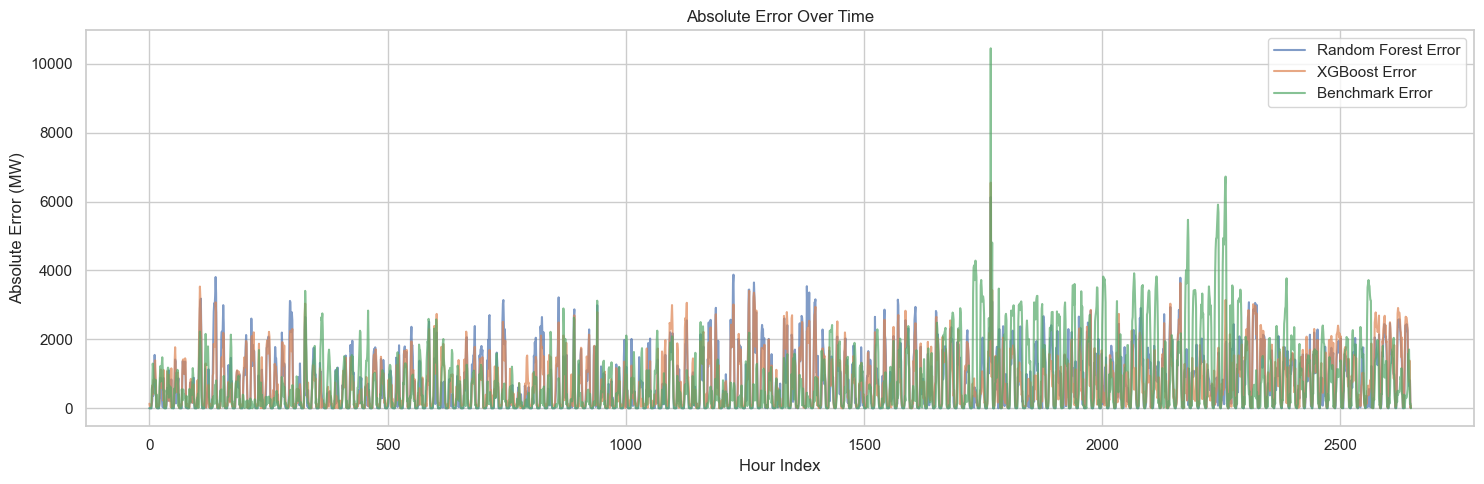

In [ ]:
# Calculate absolute errors
avg_df['RF_Error'] = np.abs(avg_df['Actuals'] - avg_df['RF_Avg_Prediction'])
avg_df['XGB_Error'] = np.abs(avg_df['Actuals'] - avg_df['XGB_Avg_Prediction'])
avg_df['Benchmark_Error'] = np.abs(avg_df['Actuals'] - avg_df['Benchmark'])

# Plot
plt.figure(figsize=(15, 5))
plt.plot(avg_df['RF_Error'], label='Random Forest Error', alpha=0.7)
plt.plot(avg_df['XGB_Error'], label='XGBoost Error', alpha=0.7)
plt.plot(avg_df['Benchmark_Error'], label='Benchmark Error', alpha=0.7)
plt.title('Absolute Error Over Time')
plt.xlabel('Hour Index')
plt.ylabel('Absolute Error (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


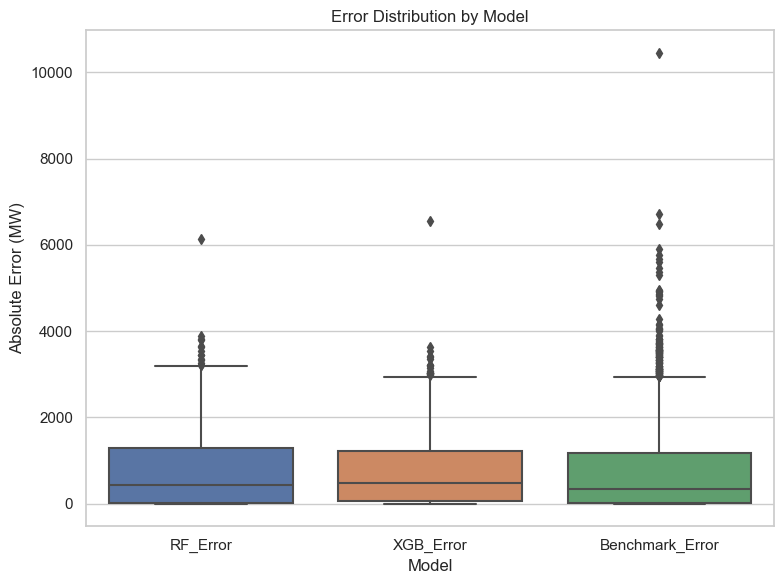

In [363]:
# Melt into long format
melted_errors = avg_df[['RF_Error', 'XGB_Error', 'Benchmark_Error']].melt(var_name='Model', value_name='Absolute Error')

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Model', y='Absolute Error', data=melted_errors)
plt.title('Error Distribution by Model')
plt.ylabel('Absolute Error (MW)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


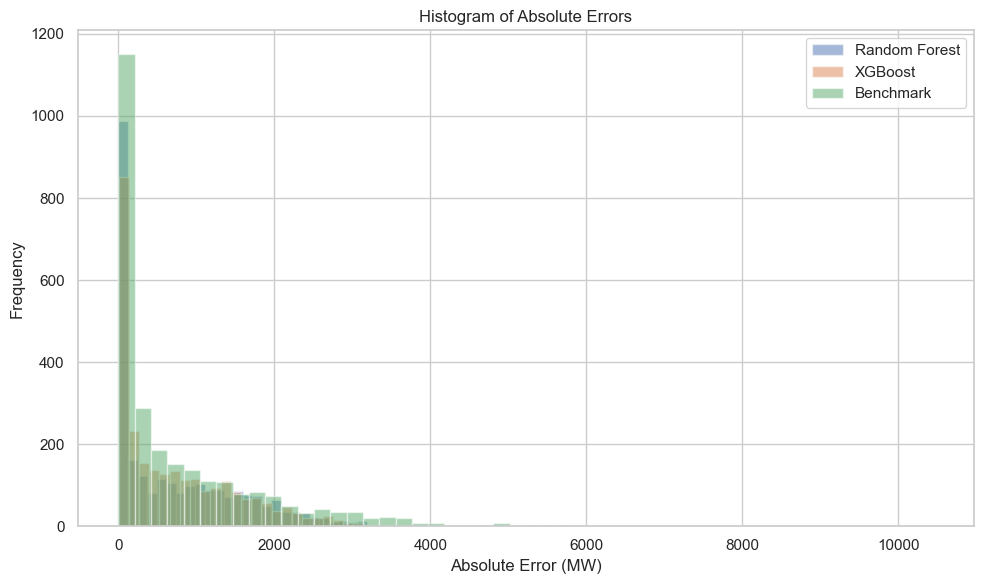

In [364]:
plt.figure(figsize=(10, 6))
plt.hist(avg_df['RF_Error'], bins=50, alpha=0.5, label='Random Forest')
plt.hist(avg_df['XGB_Error'], bins=50, alpha=0.5, label='XGBoost')
plt.hist(avg_df['Benchmark_Error'], bins=50, alpha=0.5, label='Benchmark')
plt.title('Histogram of Absolute Errors')
plt.xlabel('Absolute Error (MW)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Thoughts & Moving Forward

My final thought is that this was a beneficial learning experience where I produced a reasonable pair of predictive models all things considered. As I anticipated at the beginning of this project, it looks like solar energy generation is predictable by an overwhelmingly small subset of features that are related to sunlight and time of day. My best performing random forest and XGBoost models both had downward shortwave radiation flux as the most important feature in their respective feature matrices, and the random forest was almost entirely reliant on this feature. My XGBoost model had a much more even spread of features contributing to predictions, but was still dominated by features related to types of radiation and time. Further models would certainly trim the feature matrix even further and attempt to add a variable that is a direct indication of cloud coverage. On top of this, the most obvious next step if I were to continue improving on these models would be to collect and incorporate more data. As things stand, my 80/20 train test split only allowed for about 6 months to be held out for testing. In an ideal situation, I would have sufficient data to hold out and test an entire year . Other approaches to this problem that I have read about include incremental expansion of the testing set, starting with only the final month of our data being held out for testing, followed by the final two months, three months, etc., and seeing how model performance changes as the train:test ratio gets smaller. However, with no practical use for these predictions on a personal level, I won't be doing a deep dive into these approaches for this project.

Biggest drivers of model performance outside of individual features (in no particular order):

1. Using weather forecasts from three important locations in the SP15 region of SoCal. I think representing three different locations within the region allowed for a thoughtful way to measure solar energy generation for the entire area and ultimately allowed me to capture patterns across geographically unique locations.

2. Averaging predictions across sites for each hour. We saw that this helped lower MAE and RMSE for both the RF and XGBoost model when compared to having three predictions for each hour.

3. Averaging hourly forecasts for weather variables over the same time span for which they were predicting solar energy generation. We saw during random forest model building that this contributed to better performing models.

4. Removal of overnight hours during model training and testing. This could have been refined even further to incorporate specific sunrise and sunset times throughout the year at each location, but my blanket removal of the 9pm-5am hours worked well. In hindsight this decision probably should have been made earlier, but my lack of experience with solar data and the fact that the CAISO API produced predictions for these hours, kept me from doing so until I had already started building models. The logic behind this decision was obvious: Solar panels do not and can not generate energy at night, as moonlight (which is just a reflection of sunlight) is far too weak to generate energy in a solar panel. Keeping these hours in the dataset would just introduce irrelevant (and detrimental) noise, and ultimately hurt model performance.

5. Hyperparameter tuning. While this can certainly improve model performance relative to the vanilla models, I want to explicitly state that this was a tough task to accomplish on an 8 year-old macbook pro. My machine limited the scope of my gridsearch, and I certainly could be leaving some meat on the bone in this department.

The goal of this project was to explore a new area of data that I wasn’t very familiar with, using whatever data was available, while also improving my skills in time series forecasting. This project also provided an opportunity to practice pulling data from CAISO's API. I'm confident that I accomplished these goals and learned a good bit. Given my intentional lack of domain knowledge, there was a huge emphasis on learning. In the absence of academic and professional incentives, I wanted to prioritize technical growth over things like model performance and efficiency during the model building process. I didn't go into this project with a narrow scope of expectations, and I didn't initially navigate the data as comfortably as I might in some other situations. I did, however, quickly become familiar with the data and benefitted from brief struggles and mistakes that came as a direct result of my lack of knowledge in certain areas. I think these minor difficulties helped reinforce previously unknown concepts surrounding solar energy generation as well as strategies for working with time-series data in a very beneficial way. 




# Variable definitions and abbreviations

#### Limited to variables that were in final models

In [ ]:
import pandas as pd

data = [
    ["t_F", "Temperature", "Fahrenheit"],
    ["cape", "Convective Available Potential Energy", "J/kg"],
    ["sp", "Surface Pressure", "Pa"],
    ["blh", "Boundary Layer Height", "m"],
    ["ishf", "Shortwave Radiation Flux (incoming solar radiation)", "W/m²"],
    ["fsr", "Forecast Surface Roughness / Surface Radiative Fluxes / Fraction of Sunlight Reaching the Surface (ChatGPT)", "N/A"],
    ["vis", "Visibility", "m"],
    ["prate", "Precipitation Rate", "kg/(m²·s)"],
    ["cin", "Convective Inhibition", "J/kg"],
    ["tp", "Total Precipitation", "mm"],
    ["lhtfl", "Latent Heat Net Flux", "W/m²"],
    ["crain", "Categorical Rain", "0 or 1"],
    ["gust", "Wind Gust", "m/s"],
    ["fricv", "Frictional Velocity", "m/s"],
    ["dswrf", "Downward Short Wave Radiation Flux", "W/m²"],
    ["uswrf", "Upward Short Wave Radiation Flux", "W/m²"],
    ["dlwrf", "Downward Long Wave Radiation Flux", "W/m²"],
    ["veg", "Vegetation", "%"],
    ["gflux", "Ground Heat Flux", "W/m²"],
    ["vbdsf", "Visible Beam Downward Solar Flux", "W/m²"],
    ["vddsf", "Visible Diffuse Downward Solar Flux", "W/m²"],
]

df = pd.DataFrame(data, columns=["Variable", "Description", "Units"])
pd.set_option("display.max_colwidth", None)
print(df)


In [371]:
from tabulate import tabulate
print(tabulate(df, headers='keys', tablefmt='github', showindex=False))


| Variable   | Description                                                                                                 | Units      |
|------------|-------------------------------------------------------------------------------------------------------------|------------|
| t_F        | Temperature                                                                                                 | Fahrenheit |
| cape       | Convective Available Potential Energy                                                                       | J/kg       |
| sp         | Surface Pressure                                                                                            | Pa         |
| blh        | Boundary Layer Height                                                                                       | m          |
| ishf       | Shortwave Radiation Flux (incoming solar radiation)                                                         | W/m²       |
| fsr        | Forecast Surface Ro